# Imports

In [1]:
#!pip install catboost

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('display.max_columns', None)

# Read diamonds

In [3]:
diamonds_train_sorted = pd.read_csv('../data/diamonds_train_sorted.csv')
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z
0    326   0.21    4      5        2   59.8   61.0  3.89  3.84  2.31
1    326   0.23    5      5        1   61.5   55.0  3.95  3.98  2.43
2    327   0.23    1      5        4   56.9   65.0  4.05  4.07  2.31
3    334   0.29    4      1        3   62.4   58.0  4.20  4.23  2.63
4    335   0.31    1      0        1   63.3   58.0  4.34  4.35  2.75

# Feature engineering

In [4]:
#diamonds_train_sorted['table_xy'] = (diamonds_train_sorted['table'].mean()*(diamonds_train_sorted['x']*diamonds_train_sorted['y']).mean()-diamonds_train_sorted['table']*(diamonds_train_sorted['x']*diamonds_train_sorted['y']))
#diamonds_train_sorted['depth_z'] = (diamonds_train_sorted['depth'].mean()*diamonds_train_sorted['z'].mean()-diamonds_train_sorted['depth']*diamonds_train_sorted['z'])
#diamonds_train_sorted['volume'] = diamonds_train_sorted['x']*diamonds_train_sorted['y']*diamonds_train_sorted['z']
#diamonds_train_sorted['super_feature'] = diamonds_train_sorted['carat'] / diamonds_train_sorted['table'] * diamonds_train_sorted['depth']
#diamonds_train_sorted['super_feature'] = (2*diamonds_train_sorted['z'])/(diamonds_train_sorted['x']+diamonds_train_sorted['y'])
#diamonds_train_sorted['dtc'] = diamonds_train_sorted['depth'] / diamonds_train_sorted['table'] * diamonds_train_sorted['carat']
diamonds_train_sorted['ratio_length_width'] = diamonds_train_sorted['x']/diamonds_train_sorted['y']
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      5        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    5      5        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      5        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      1        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      0        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  
0            1.013021  
1            0.992462  
2            0.995086  
3            0.992908  
4            0.997701

In [5]:
carat_log= []
for i in diamonds_train_sorted['carat']:
    carat_log.append(math.log(i))
diamonds_train_sorted['carat_log'] = carat_log
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      5        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    5      5        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      5        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      1        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      0        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log  
0            1.013021  -1.560648  
1            0.992462  -1.469676  
2            0.995086  -1.469676  
3            0.992908  -1.237874  
4            0.997701  -1.171183

# Create diamond shape

In [6]:
shape = []
for i in diamonds_train_sorted['table'].index:
    if 54<diamonds_train_sorted['table'][i]<57 and 61<diamonds_train_sorted['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_train_sorted['table'][i]<60 and 60<diamonds_train_sorted['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_train_sorted['table'][i]<69 and 69<diamonds_train_sorted['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_train_sorted['table'][i]<63 and 58<diamonds_train_sorted['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [7]:
diamonds_train_sorted['shape'] = shape
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      5        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    5      5        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      5        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      1        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      0        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log    shape  
0            1.013021  -1.560648  Cushion  
1            0.992462  -1.469676    Round  
2            0.995086  -1.469676   others  
3            0.992908  -1.237874     Oval  
4            0.997701  -1.171183     Oval

# Shape label encoding 

In [8]:
diamonds_train_sorted['shape']=diamonds_train_sorted['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      5        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    5      5        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      5        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      1        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      0        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log  shape  
0            1.013021  -1.560648      2  
1            0.992462  -1.469676      4  
2            0.995086  -1.469676      0  
3            0.992908  -1.237874      1  
4            0.997701  -1.171183      1

# Correlation

<Axes: >

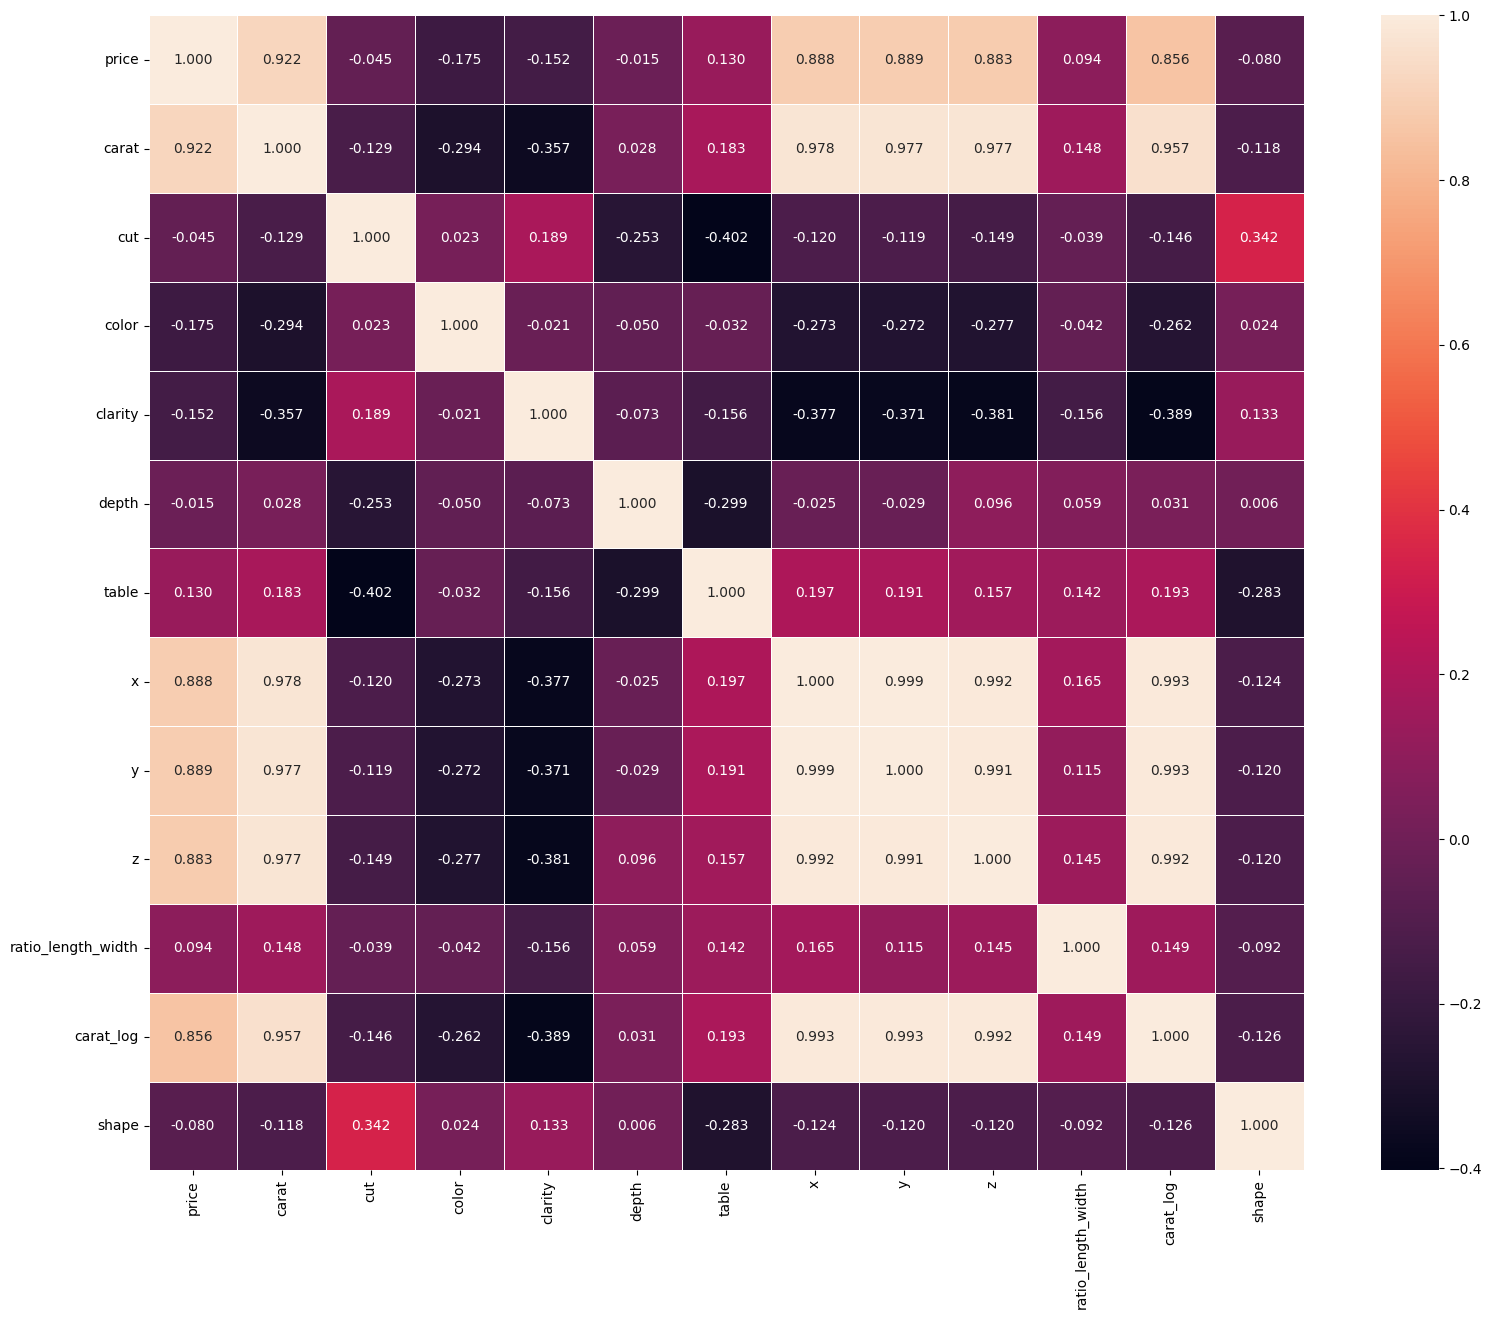

In [9]:
plt.subplots(figsize = (20, 15))
corr = diamonds_train_sorted.corr()
sns.heatmap(data = corr, annot = True, fmt = ".3f", cbar = True, linewidth = .5, 
            annot_kws = {'fontsize':10, 'fontweight':'regular'}, square = True)

# Model train split

In [10]:
X = diamonds_train_sorted[['cut',
                           'color', 
                           'clarity',
                           'ratio_length_width',
                           'carat_log',
                           'shape']]

y = diamonds_train_sorted['price']

In [11]:
# Train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

X_train: (32344, 6), X_test: (8087, 6), y_train: (32344,), y_test: (8087,)
X_train: <class 'pandas.core.frame.DataFrame'>, X_test: <class 'pandas.core.frame.DataFrame'>, y_train: <class 'pandas.core.series.Series'>, y_test: <class 'pandas.core.series.Series'>


# Scaling robust

In [12]:
# Scaling robust
scaler_r = RobustScaler()
scaling_X_train_r = scaler_r.fit_transform(X_train)
scaling_X_test_r = scaler_r.fit_transform(X_test)
scaled_X_train_r = pd.DataFrame(scaling_X_train_r)
scaled_X_train_r

0         1    2         3         4    5
0      0.5  1.000000 -1.0  0.783325  0.000000  0.0
1      0.5  0.333333  0.0  0.861568  0.263016  0.0
2      0.5  0.333333 -1.0 -0.181962  0.058157  3.0
3      0.5 -0.666667  0.0  1.033691  0.482501  3.0
4      0.5 -0.666667 -0.5  0.051578  0.000000  0.0
...    ...       ...  ...       ...       ...  ...
32339  0.5 -0.333333  0.0 -0.137658 -0.559829  3.0
32340 -0.5  1.000000  0.5 -0.283724 -0.559829  0.0
32341  0.5  0.333333  0.0  1.152442  0.797625  0.0
32342 -1.5 -0.333333  1.0 -0.386191 -1.036512  0.0
32343  0.5  1.000000  0.5 -0.125367 -0.439402  0.0

[32344 rows x 6 columns]

In [13]:
scaled_X_test_r = pd.DataFrame(scaling_X_test_r)
scaled_X_test_r

0         1    2         3         4    5
0    -0.5  0.333333 -1.0 -0.425931  0.444091  1.0
1    -1.5 -0.333333 -1.0 -0.640721  1.109115  0.0
2     0.0  0.333333 -1.0  1.089094  0.263016  0.0
3     0.5  0.333333  1.5 -0.285423 -0.559829  3.0
4     0.5  0.000000  1.0  0.878646  0.825168  0.0
...   ...       ...  ...       ...       ...  ...
8082 -0.5  0.000000  0.0 -0.435581  0.014845  1.0
8083 -0.5  0.666667 -0.5 -0.992426 -0.559829 -1.0
8084  0.0 -0.666667  0.5 -0.398938  0.606815  0.0
8085  0.5  0.000000  0.5 -0.020570  0.414329  0.0
8086 -1.5  0.666667 -0.5  0.074728  0.286018  0.0

[8087 rows x 6 columns]

# Scaling standard

In [14]:
"""
scaler = StandardScaler()
scaling_X_train = scaler.fit_transform(X_train)
scaling_X_test = scaler.fit_transform(X_test)
scaled_X_train = pd.DataFrame(scaling_X_train)
scaled_X_train
"""

'\nscaler = StandardScaler()\nscaling_X_train = scaler.fit_transform(X_train)\nscaling_X_test = scaler.fit_transform(X_test)\nscaled_X_train = pd.DataFrame(scaling_X_train)\nscaled_X_train\n'

In [15]:
"""
scaled_X_test = pd.DataFrame(scaling_X_test)
scaled_X_test
"""

'\nscaled_X_test = pd.DataFrame(scaling_X_test)\nscaled_X_test\n'

# Train model CatBoost

In [16]:
# rf model train
train_dataset = cb.Pool(scaled_X_train_r, y_train) 
test_dataset = cb.Pool(scaled_X_test_r, y_test)

In [17]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [18]:
grid = {'iterations': [100, 150, 500],
        'learning_rate': [0.03, 0.1, 0.3],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 5458.0099162	test: 5507.2267120	best: 5507.2267120 (0)	total: 146ms	remaining: 14.5s
1:	learn: 5312.5431625	test: 5361.0908507	best: 5361.0908507 (1)	total: 149ms	remaining: 7.33s
2:	learn: 5173.7997531	test: 5221.9191814	best: 5221.9191814 (2)	total: 153ms	remaining: 4.94s
3:	learn: 5038.5181011	test: 5086.5365449	best: 5086.5365449 (3)	total: 156ms	remaining: 3.75s
4:	learn: 4906.8763973	test: 4954.7529905	best: 4954.7529905 (4)	total: 159ms	remaining: 3.02s
5:	learn: 4782.0665298	test: 4829.4272332	best: 4829.4272332 (5)	total: 162ms	remaining: 2.53s
6:	learn: 4664.9908782	test: 4712.2405788	best: 4712.2405788 (6)	total: 164ms	remaining: 2.18s
7:	learn: 4551.0366811	test: 4597.9686471	best: 4597.9686471 (7)	total: 166ms	remaining: 1.91s
8:	learn: 4440.3007604	test: 4486.8492819	best: 4486.8492819 (8)	total: 168ms	remaining: 1.7s
9:	learn: 4327.3091130	test: 4373.6080510	best: 4373.6080510 (9)	total: 170ms	remaining: 1.53s
10:	learn: 4219.1999693	test: 4265.4709259	best: 42

85:	learn: 1433.2381326	test: 1511.1611783	best: 1511.1611783 (85)	total: 349ms	remaining: 56.9ms
86:	learn: 1424.8337720	test: 1502.6232213	best: 1502.6232213 (86)	total: 352ms	remaining: 52.6ms
87:	learn: 1414.7975998	test: 1492.2155564	best: 1492.2155564 (87)	total: 354ms	remaining: 48.3ms
88:	learn: 1408.0282279	test: 1485.4804763	best: 1485.4804763 (88)	total: 356ms	remaining: 44ms
89:	learn: 1400.1138352	test: 1477.4660962	best: 1477.4660962 (89)	total: 358ms	remaining: 39.8ms
90:	learn: 1393.3949787	test: 1471.2376529	best: 1471.2376529 (90)	total: 360ms	remaining: 35.6ms
91:	learn: 1386.9995037	test: 1465.3452816	best: 1465.3452816 (91)	total: 362ms	remaining: 31.4ms
92:	learn: 1378.2368890	test: 1456.4207876	best: 1456.4207876 (92)	total: 364ms	remaining: 27.4ms
93:	learn: 1370.8104611	test: 1448.9164129	best: 1448.9164129 (93)	total: 367ms	remaining: 23.4ms
94:	learn: 1361.6320284	test: 1439.1777965	best: 1439.1777965 (94)	total: 370ms	remaining: 19.5ms
95:	learn: 1354.772232

76:	learn: 895.5971676	test: 963.4537352	best: 963.4537352 (76)	total: 170ms	remaining: 50.9ms
77:	learn: 892.2588531	test: 960.6850469	best: 960.6850469 (77)	total: 173ms	remaining: 48.7ms
78:	learn: 886.5175746	test: 953.6198857	best: 953.6198857 (78)	total: 175ms	remaining: 46.4ms
79:	learn: 883.3763963	test: 950.5861938	best: 950.5861938 (79)	total: 176ms	remaining: 44.1ms
80:	learn: 879.7454989	test: 947.4428746	best: 947.4428746 (80)	total: 178ms	remaining: 41.8ms
81:	learn: 877.2660660	test: 944.7345296	best: 944.7345296 (81)	total: 180ms	remaining: 39.6ms
82:	learn: 874.7621595	test: 942.6816390	best: 942.6816390 (82)	total: 182ms	remaining: 37.3ms
83:	learn: 871.4864878	test: 939.5565234	best: 939.5565234 (83)	total: 186ms	remaining: 35.5ms
84:	learn: 868.0028730	test: 935.1927422	best: 935.1927422 (84)	total: 190ms	remaining: 33.6ms
85:	learn: 865.1018871	test: 932.2878542	best: 932.2878542 (85)	total: 193ms	remaining: 31.4ms
86:	learn: 862.7338155	test: 930.0418377	best: 930

63:	learn: 730.3616201	test: 779.3196949	best: 779.3196949 (63)	total: 140ms	remaining: 78.6ms
64:	learn: 729.5850984	test: 778.2503393	best: 778.2503393 (64)	total: 142ms	remaining: 76.6ms
65:	learn: 728.9618030	test: 777.4880789	best: 777.4880789 (65)	total: 144ms	remaining: 74.4ms
66:	learn: 725.2702993	test: 775.2914262	best: 775.2914262 (66)	total: 147ms	remaining: 72.6ms
67:	learn: 721.0163639	test: 769.5938524	best: 769.5938524 (67)	total: 150ms	remaining: 70.6ms
68:	learn: 719.8327973	test: 768.8128829	best: 768.8128829 (68)	total: 152ms	remaining: 68.4ms
69:	learn: 719.2559115	test: 768.4856480	best: 768.4856480 (69)	total: 155ms	remaining: 66.6ms
70:	learn: 717.8105549	test: 767.0507516	best: 767.0507516 (70)	total: 159ms	remaining: 65ms
71:	learn: 715.0039118	test: 763.9708385	best: 763.9708385 (71)	total: 161ms	remaining: 62.6ms
72:	learn: 712.3803927	test: 762.0531031	best: 762.0531031 (72)	total: 163ms	remaining: 60.3ms
73:	learn: 709.6541183	test: 758.9706235	best: 758.9

60:	learn: 1731.7163266	test: 1802.1840991	best: 1802.1840991 (60)	total: 132ms	remaining: 84.5ms
61:	learn: 1715.5417473	test: 1786.5733745	best: 1786.5733745 (61)	total: 135ms	remaining: 82.8ms
62:	learn: 1699.8483554	test: 1771.9932188	best: 1771.9932188 (62)	total: 138ms	remaining: 81.1ms
63:	learn: 1685.2915107	test: 1757.8432473	best: 1757.8432473 (63)	total: 141ms	remaining: 79.2ms
64:	learn: 1670.7571908	test: 1744.1608023	best: 1744.1608023 (64)	total: 145ms	remaining: 78.1ms
65:	learn: 1656.9226924	test: 1730.4943204	best: 1730.4943204 (65)	total: 148ms	remaining: 76.2ms
66:	learn: 1643.6613627	test: 1717.2383817	best: 1717.2383817 (66)	total: 150ms	remaining: 73.9ms
67:	learn: 1627.0053156	test: 1700.3772912	best: 1700.3772912 (67)	total: 153ms	remaining: 71.8ms
68:	learn: 1614.1988921	test: 1688.3439074	best: 1688.3439074 (68)	total: 156ms	remaining: 70.2ms
69:	learn: 1601.1338892	test: 1674.7848745	best: 1674.7848745 (69)	total: 158ms	remaining: 67.9ms
70:	learn: 1589.5004

21:	learn: 947.4864583	test: 1012.0213848	best: 1012.0213848 (21)	total: 44.5ms	remaining: 158ms
22:	learn: 930.1990772	test: 992.0194829	best: 992.0194829 (22)	total: 47.3ms	remaining: 158ms
23:	learn: 919.4682723	test: 980.0030959	best: 980.0030959 (23)	total: 49.4ms	remaining: 156ms
24:	learn: 907.7300060	test: 969.2670296	best: 969.2670296 (24)	total: 51.2ms	remaining: 154ms
25:	learn: 899.8097693	test: 961.8881508	best: 961.8881508 (25)	total: 53.2ms	remaining: 151ms
26:	learn: 885.3919856	test: 944.4264224	best: 944.4264224 (26)	total: 55.2ms	remaining: 149ms
27:	learn: 874.3437116	test: 933.7097664	best: 933.7097664 (27)	total: 57.4ms	remaining: 148ms
28:	learn: 867.5146853	test: 926.5907050	best: 926.5907050 (28)	total: 59.5ms	remaining: 146ms
29:	learn: 859.9342015	test: 917.0139401	best: 917.0139401 (29)	total: 61.5ms	remaining: 144ms
30:	learn: 855.1472926	test: 911.9849706	best: 911.9849706 (30)	total: 63.6ms	remaining: 142ms
31:	learn: 848.6275512	test: 905.1423176	best: 9

20:	learn: 3324.3042366	test: 3370.2186236	best: 3370.2186236 (20)	total: 43.5ms	remaining: 164ms
21:	learn: 3249.2723792	test: 3295.8842087	best: 3295.8842087 (21)	total: 45.9ms	remaining: 163ms
22:	learn: 3176.8798114	test: 3223.5781937	best: 3223.5781937 (22)	total: 48.1ms	remaining: 161ms
23:	learn: 3109.6042843	test: 3156.3790002	best: 3156.3790002 (23)	total: 50.1ms	remaining: 159ms
24:	learn: 3042.7516207	test: 3089.7931434	best: 3089.7931434 (24)	total: 52.1ms	remaining: 156ms
25:	learn: 2979.3379834	test: 3027.1465833	best: 3027.1465833 (25)	total: 54.2ms	remaining: 154ms
26:	learn: 2916.1102699	test: 2964.5820435	best: 2964.5820435 (26)	total: 56.3ms	remaining: 152ms
27:	learn: 2855.3441429	test: 2904.5959445	best: 2904.5959445 (27)	total: 58.7ms	remaining: 151ms
28:	learn: 2797.0898945	test: 2847.1562374	best: 2847.1562374 (28)	total: 61.1ms	remaining: 150ms
29:	learn: 2741.6427058	test: 2791.9449600	best: 2791.9449600 (29)	total: 63.1ms	remaining: 147ms
30:	learn: 2686.9142

3:	learn: 3925.1676673	test: 3976.3226369	best: 3976.3226369 (3)	total: 9.97ms	remaining: 239ms
4:	learn: 3610.1336858	test: 3661.5285767	best: 3661.5285767 (4)	total: 12.9ms	remaining: 245ms
5:	learn: 3332.2598992	test: 3385.4993768	best: 3385.4993768 (5)	total: 15ms	remaining: 235ms
6:	learn: 3086.8107594	test: 3139.9784726	best: 3139.9784726 (6)	total: 17ms	remaining: 225ms
7:	learn: 2865.0283386	test: 2919.1932931	best: 2919.1932931 (7)	total: 18.9ms	remaining: 217ms
8:	learn: 2679.6920153	test: 2736.6705049	best: 2736.6705049 (8)	total: 20.9ms	remaining: 211ms
9:	learn: 2506.7416682	test: 2566.4243910	best: 2566.4243910 (9)	total: 23.1ms	remaining: 208ms
10:	learn: 2357.3289144	test: 2419.9744509	best: 2419.9744509 (10)	total: 26.3ms	remaining: 212ms
11:	learn: 2224.2827909	test: 2289.0718158	best: 2289.0718158 (11)	total: 28.8ms	remaining: 211ms
12:	learn: 2105.8026518	test: 2172.0714772	best: 2172.0714772 (12)	total: 31.3ms	remaining: 210ms
13:	learn: 2004.7224958	test: 2075.469

77:	learn: 708.2663603	test: 755.1863103	best: 755.1863103 (77)	total: 157ms	remaining: 44.2ms
78:	learn: 705.2893252	test: 752.4502305	best: 752.4502305 (78)	total: 159ms	remaining: 42.2ms
79:	learn: 703.0003488	test: 749.2760386	best: 749.2760386 (79)	total: 161ms	remaining: 40.2ms
80:	learn: 701.9397309	test: 748.8289030	best: 748.8289030 (80)	total: 163ms	remaining: 38.2ms
81:	learn: 701.4013687	test: 748.4171442	best: 748.4171442 (81)	total: 165ms	remaining: 36.1ms
82:	learn: 701.0758134	test: 747.3570619	best: 747.3570619 (82)	total: 167ms	remaining: 34.1ms
83:	learn: 699.5773042	test: 745.8375505	best: 745.8375505 (83)	total: 168ms	remaining: 32.1ms
84:	learn: 697.3445354	test: 744.2040477	best: 744.2040477 (84)	total: 170ms	remaining: 30.1ms
85:	learn: 696.7605514	test: 743.3271867	best: 743.3271867 (85)	total: 172ms	remaining: 28.1ms
86:	learn: 694.7714730	test: 741.5901931	best: 741.5901931 (86)	total: 174ms	remaining: 26.1ms
87:	learn: 692.0241345	test: 738.9265564	best: 738

42:	learn: 1112.3415629	test: 1188.4384732	best: 1188.4384732 (42)	total: 94ms	remaining: 125ms
43:	learn: 1100.2278314	test: 1175.1534010	best: 1175.1534010 (43)	total: 96.3ms	remaining: 123ms
44:	learn: 1088.0212323	test: 1162.1252833	best: 1162.1252833 (44)	total: 98.6ms	remaining: 120ms
45:	learn: 1079.4976485	test: 1154.5416586	best: 1154.5416586 (45)	total: 100ms	remaining: 118ms
46:	learn: 1072.5340038	test: 1147.8140730	best: 1147.8140730 (46)	total: 103ms	remaining: 116ms
47:	learn: 1064.0828922	test: 1139.2932229	best: 1139.2932229 (47)	total: 105ms	remaining: 114ms
48:	learn: 1057.3877453	test: 1133.2605540	best: 1133.2605540 (48)	total: 107ms	remaining: 111ms
49:	learn: 1047.4979314	test: 1122.3922644	best: 1122.3922644 (49)	total: 109ms	remaining: 109ms
50:	learn: 1040.9370535	test: 1116.3739973	best: 1116.3739973 (50)	total: 113ms	remaining: 109ms
51:	learn: 1031.9083424	test: 1106.2133004	best: 1106.2133004 (51)	total: 116ms	remaining: 107ms
52:	learn: 1024.0217561	test:

84:	learn: 696.5876937	test: 742.4100881	best: 742.4100881 (84)	total: 241ms	remaining: 42.5ms
85:	learn: 696.1798641	test: 742.0483289	best: 742.0483289 (85)	total: 244ms	remaining: 39.7ms
86:	learn: 695.7536976	test: 741.8424072	best: 741.8424072 (86)	total: 246ms	remaining: 36.8ms
87:	learn: 694.2581884	test: 739.9306869	best: 739.9306869 (87)	total: 248ms	remaining: 33.9ms
88:	learn: 692.2035837	test: 737.9769250	best: 737.9769250 (88)	total: 250ms	remaining: 31ms
89:	learn: 691.5156463	test: 736.6557422	best: 736.6557422 (89)	total: 253ms	remaining: 28.1ms
90:	learn: 689.8512119	test: 734.1382153	best: 734.1382153 (90)	total: 255ms	remaining: 25.2ms
91:	learn: 689.3272936	test: 734.0278345	best: 734.0278345 (91)	total: 257ms	remaining: 22.3ms
92:	learn: 689.1162124	test: 733.1624052	best: 733.1624052 (92)	total: 259ms	remaining: 19.5ms
93:	learn: 688.8792128	test: 732.8890017	best: 732.8890017 (93)	total: 261ms	remaining: 16.7ms
94:	learn: 686.6315201	test: 729.9152915	best: 729.9

16:	learn: 1766.9821567	test: 1838.1357444	best: 1838.1357444 (16)	total: 35.3ms	remaining: 276ms
17:	learn: 1706.4445414	test: 1779.3017979	best: 1779.3017979 (17)	total: 37.8ms	remaining: 277ms
18:	learn: 1654.5549173	test: 1728.1084332	best: 1728.1084332 (18)	total: 39.7ms	remaining: 274ms
19:	learn: 1608.7913078	test: 1683.8055172	best: 1683.8055172 (19)	total: 41.6ms	remaining: 271ms
20:	learn: 1558.3250616	test: 1633.1394415	best: 1633.1394415 (20)	total: 43.6ms	remaining: 268ms
21:	learn: 1522.4573135	test: 1599.2061552	best: 1599.2061552 (21)	total: 45.3ms	remaining: 264ms
22:	learn: 1484.5328467	test: 1560.2270924	best: 1560.2270924 (22)	total: 47.2ms	remaining: 261ms
23:	learn: 1454.1324679	test: 1529.9697659	best: 1529.9697659 (23)	total: 49.1ms	remaining: 258ms
24:	learn: 1426.4494731	test: 1503.8062366	best: 1503.8062366 (24)	total: 51.2ms	remaining: 256ms
25:	learn: 1396.8296697	test: 1473.8542156	best: 1473.8542156 (25)	total: 54.3ms	remaining: 259ms
26:	learn: 1367.5067

119:	learn: 790.0213856	test: 850.8444014	best: 850.8444014 (119)	total: 241ms	remaining: 60.2ms
120:	learn: 787.0861288	test: 847.3730935	best: 847.3730935 (120)	total: 244ms	remaining: 58.4ms
121:	learn: 786.0051551	test: 846.4492529	best: 846.4492529 (121)	total: 246ms	remaining: 56.4ms
122:	learn: 784.6130566	test: 844.6599920	best: 844.6599920 (122)	total: 248ms	remaining: 54.4ms
123:	learn: 782.4083904	test: 842.4796757	best: 842.4796757 (123)	total: 250ms	remaining: 52.4ms
124:	learn: 780.8104885	test: 840.8961131	best: 840.8961131 (124)	total: 252ms	remaining: 50.4ms
125:	learn: 779.3460525	test: 839.5986055	best: 839.5986055 (125)	total: 254ms	remaining: 48.4ms
126:	learn: 778.3708992	test: 838.8386009	best: 838.8386009 (126)	total: 256ms	remaining: 46.5ms
127:	learn: 777.5658848	test: 837.7001944	best: 837.7001944 (127)	total: 259ms	remaining: 44.5ms
128:	learn: 776.4687646	test: 836.3306353	best: 836.3306353 (128)	total: 261ms	remaining: 42.5ms
129:	learn: 775.0396561	test: 

56:	learn: 746.7970379	test: 798.5941902	best: 798.5941902 (56)	total: 125ms	remaining: 203ms
57:	learn: 745.7034047	test: 797.0669397	best: 797.0669397 (57)	total: 127ms	remaining: 202ms
58:	learn: 744.9107752	test: 793.3802640	best: 793.3802640 (58)	total: 129ms	remaining: 200ms
59:	learn: 742.2927696	test: 789.6467403	best: 789.6467403 (59)	total: 131ms	remaining: 197ms
60:	learn: 738.2040329	test: 785.5903374	best: 785.5903374 (60)	total: 134ms	remaining: 195ms
61:	learn: 737.3020851	test: 785.2202433	best: 785.2202433 (61)	total: 137ms	remaining: 194ms
62:	learn: 732.1222678	test: 780.1119667	best: 780.1119667 (62)	total: 139ms	remaining: 192ms
63:	learn: 730.3616201	test: 779.3196949	best: 779.3196949 (63)	total: 142ms	remaining: 191ms
64:	learn: 729.5850984	test: 778.2503393	best: 778.2503393 (64)	total: 144ms	remaining: 189ms
65:	learn: 728.9618030	test: 777.4880789	best: 777.4880789 (65)	total: 147ms	remaining: 187ms
66:	learn: 725.2702993	test: 775.2914262	best: 775.2914262 (

3:	learn: 5038.5554291	test: 5086.5740945	best: 5086.5740945 (3)	total: 9.23ms	remaining: 337ms
4:	learn: 4906.9225497	test: 4954.7993933	best: 4954.7993933 (4)	total: 11.7ms	remaining: 340ms
5:	learn: 4782.1244115	test: 4829.4855251	best: 4829.4855251 (5)	total: 13.8ms	remaining: 330ms
6:	learn: 4665.0532018	test: 4712.3032932	best: 4712.3032932 (6)	total: 15.8ms	remaining: 323ms
7:	learn: 4551.1066239	test: 4598.0389918	best: 4598.0389918 (7)	total: 18ms	remaining: 320ms
8:	learn: 4440.3743241	test: 4486.9232525	best: 4486.9232525 (8)	total: 20ms	remaining: 313ms
9:	learn: 4327.3889022	test: 4373.6882803	best: 4373.6882803 (9)	total: 22.1ms	remaining: 310ms
10:	learn: 4219.2854763	test: 4265.5568621	best: 4265.5568621 (10)	total: 24.6ms	remaining: 311ms
11:	learn: 4114.6806529	test: 4161.1554929	best: 4161.1554929 (11)	total: 27.3ms	remaining: 314ms
12:	learn: 4012.7979849	test: 4058.9848012	best: 4058.9848012 (12)	total: 29.3ms	remaining: 308ms
13:	learn: 3915.1604570	test: 3961.227

93:	learn: 1370.9015221	test: 1449.0076961	best: 1449.0076961 (93)	total: 204ms	remaining: 122ms
94:	learn: 1361.7250998	test: 1439.2713841	best: 1439.2713841 (94)	total: 207ms	remaining: 120ms
95:	learn: 1354.8652948	test: 1432.3147588	best: 1432.3147588 (95)	total: 209ms	remaining: 118ms
96:	learn: 1348.8799303	test: 1426.7386319	best: 1426.7386319 (96)	total: 211ms	remaining: 115ms
97:	learn: 1342.2533725	test: 1420.0461336	best: 1420.0461336 (97)	total: 213ms	remaining: 113ms
98:	learn: 1336.4869386	test: 1414.5382092	best: 1414.5382092 (98)	total: 215ms	remaining: 111ms
99:	learn: 1329.1469733	test: 1406.8320368	best: 1406.8320368 (99)	total: 217ms	remaining: 108ms
100:	learn: 1323.7934475	test: 1401.9833870	best: 1401.9833870 (100)	total: 219ms	remaining: 106ms
101:	learn: 1316.5657896	test: 1394.3419744	best: 1394.3419744 (101)	total: 221ms	remaining: 104ms
102:	learn: 1309.5493148	test: 1387.0254491	best: 1387.0254491 (102)	total: 223ms	remaining: 102ms
103:	learn: 1301.8798940

119:	learn: 790.1309236	test: 850.8984826	best: 850.8984826 (119)	total: 245ms	remaining: 61.3ms
120:	learn: 787.1975889	test: 847.4302282	best: 847.4302282 (120)	total: 247ms	remaining: 59.3ms
121:	learn: 786.1085115	test: 846.4957178	best: 846.4957178 (121)	total: 249ms	remaining: 57.2ms
122:	learn: 785.1360472	test: 845.7531624	best: 845.7531624 (122)	total: 251ms	remaining: 55.1ms
123:	learn: 782.9955470	test: 843.0783859	best: 843.0783859 (123)	total: 253ms	remaining: 53.1ms
124:	learn: 781.5726038	test: 841.6374082	best: 841.6374082 (124)	total: 255ms	remaining: 51ms
125:	learn: 779.9859078	test: 840.0420224	best: 840.0420224 (125)	total: 257ms	remaining: 48.9ms
126:	learn: 778.5461960	test: 838.7568367	best: 838.7568367 (126)	total: 259ms	remaining: 46.9ms
127:	learn: 777.7610552	test: 837.5455203	best: 837.5455203 (127)	total: 261ms	remaining: 44.9ms
128:	learn: 775.7027302	test: 834.3998935	best: 834.3998935 (128)	total: 264ms	remaining: 42.9ms
129:	learn: 774.2914578	test: 83

66:	learn: 726.9158762	test: 776.4605557	best: 776.4605557 (66)	total: 129ms	remaining: 159ms
67:	learn: 722.8868290	test: 772.3006114	best: 772.3006114 (67)	total: 131ms	remaining: 158ms
68:	learn: 720.1020874	test: 769.4794239	best: 769.4794239 (68)	total: 133ms	remaining: 157ms
69:	learn: 718.5392003	test: 767.3926875	best: 767.3926875 (69)	total: 135ms	remaining: 155ms
70:	learn: 714.7556665	test: 764.5784253	best: 764.5784253 (70)	total: 137ms	remaining: 153ms
71:	learn: 711.7742728	test: 760.4728824	best: 760.4728824 (71)	total: 140ms	remaining: 152ms
72:	learn: 710.5978391	test: 759.4385069	best: 759.4385069 (72)	total: 142ms	remaining: 150ms
73:	learn: 709.9287905	test: 758.9613586	best: 758.9613586 (73)	total: 144ms	remaining: 148ms
74:	learn: 709.5041955	test: 757.3727425	best: 757.3727425 (74)	total: 147ms	remaining: 147ms
75:	learn: 706.9915430	test: 754.5746142	best: 754.5746142 (75)	total: 149ms	remaining: 145ms
76:	learn: 706.0221905	test: 754.3267429	best: 754.3267429 (

10:	learn: 4219.4279597	test: 4265.7000605	best: 4265.7000605 (10)	total: 22.7ms	remaining: 287ms
11:	learn: 4114.8308134	test: 4161.3063139	best: 4161.3063139 (11)	total: 25.5ms	remaining: 293ms
12:	learn: 4012.9560347	test: 4059.1435257	best: 4059.1435257 (12)	total: 27.8ms	remaining: 293ms
13:	learn: 3915.3259953	test: 3961.3936587	best: 3961.3936587 (13)	total: 29.9ms	remaining: 291ms
14:	learn: 3821.1361331	test: 3867.1338784	best: 3867.1338784 (14)	total: 32.1ms	remaining: 289ms
15:	learn: 3732.0887124	test: 3777.7744910	best: 3777.7744910 (15)	total: 34.2ms	remaining: 286ms
16:	learn: 3646.2760408	test: 3691.6781602	best: 3691.6781602 (16)	total: 36.9ms	remaining: 288ms
17:	learn: 3560.7326197	test: 3606.1626092	best: 3606.1626092 (17)	total: 39.5ms	remaining: 289ms
18:	learn: 3477.7503711	test: 3523.4488662	best: 3523.4488662 (18)	total: 42.3ms	remaining: 291ms
19:	learn: 3397.6769446	test: 3443.4483985	best: 3443.4483985 (19)	total: 44.4ms	remaining: 288ms
20:	learn: 3324.3042

106:	learn: 1286.4245630	test: 1363.4137044	best: 1363.4137044 (106)	total: 229ms	remaining: 92.2ms
107:	learn: 1280.9712037	test: 1357.8442468	best: 1357.8442468 (107)	total: 231ms	remaining: 90ms
108:	learn: 1276.2757749	test: 1353.0703519	best: 1353.0703519 (108)	total: 233ms	remaining: 87.8ms
109:	learn: 1269.4009826	test: 1345.8679835	best: 1345.8679835 (109)	total: 235ms	remaining: 85.6ms
110:	learn: 1264.7882817	test: 1341.4353929	best: 1341.4353929 (110)	total: 237ms	remaining: 83.4ms
111:	learn: 1259.4701210	test: 1335.9863004	best: 1335.9863004 (111)	total: 239ms	remaining: 81.2ms
112:	learn: 1254.0988747	test: 1330.2829702	best: 1330.2829702 (112)	total: 241ms	remaining: 79ms
113:	learn: 1249.4702190	test: 1325.4178432	best: 1325.4178432 (113)	total: 243ms	remaining: 76.8ms
114:	learn: 1245.1838141	test: 1321.3124475	best: 1321.3124475 (114)	total: 245ms	remaining: 74.6ms
115:	learn: 1241.1103502	test: 1317.1079300	best: 1317.1079300 (115)	total: 248ms	remaining: 72.7ms
116:

40:	learn: 1136.7153538	test: 1212.8540242	best: 1212.8540242 (40)	total: 102ms	remaining: 272ms
41:	learn: 1126.1159635	test: 1201.8896069	best: 1201.8896069 (41)	total: 104ms	remaining: 269ms
42:	learn: 1115.3268213	test: 1191.0087225	best: 1191.0087225 (42)	total: 107ms	remaining: 265ms
43:	learn: 1102.9476494	test: 1177.4103861	best: 1177.4103861 (43)	total: 109ms	remaining: 263ms
44:	learn: 1091.9687161	test: 1165.0453904	best: 1165.0453904 (44)	total: 113ms	remaining: 263ms
45:	learn: 1082.8780473	test: 1156.0282396	best: 1156.0282396 (45)	total: 117ms	remaining: 266ms
46:	learn: 1075.6608696	test: 1149.0606486	best: 1149.0606486 (46)	total: 121ms	remaining: 264ms
47:	learn: 1067.6149604	test: 1140.9221369	best: 1140.9221369 (47)	total: 123ms	remaining: 261ms
48:	learn: 1057.7205337	test: 1129.8965409	best: 1129.8965409 (48)	total: 125ms	remaining: 258ms
49:	learn: 1050.6579627	test: 1123.6497066	best: 1123.6497066 (49)	total: 127ms	remaining: 254ms
50:	learn: 1042.3863964	test: 

66:	learn: 731.5566792	test: 781.2369485	best: 781.2369485 (66)	total: 132ms	remaining: 163ms
67:	learn: 728.3005436	test: 778.1126353	best: 778.1126353 (67)	total: 135ms	remaining: 162ms
68:	learn: 724.7375985	test: 775.5181251	best: 775.5181251 (68)	total: 136ms	remaining: 160ms
69:	learn: 720.9010368	test: 770.4280451	best: 770.4280451 (69)	total: 138ms	remaining: 158ms
70:	learn: 719.7533984	test: 769.4289389	best: 769.4289389 (70)	total: 140ms	remaining: 156ms
71:	learn: 719.0644401	test: 769.2603687	best: 769.2603687 (71)	total: 142ms	remaining: 154ms
72:	learn: 715.6684922	test: 764.2014943	best: 764.2014943 (72)	total: 144ms	remaining: 152ms
73:	learn: 715.2788049	test: 763.0118578	best: 763.0118578 (73)	total: 146ms	remaining: 150ms
74:	learn: 711.0845782	test: 758.7605836	best: 758.7605836 (74)	total: 149ms	remaining: 149ms
75:	learn: 710.5965533	test: 758.3925704	best: 758.3925704 (75)	total: 151ms	remaining: 147ms
76:	learn: 708.6281916	test: 755.7451279	best: 755.7451279 (

14:	learn: 3821.8434844	test: 3867.8439716	best: 3867.8439716 (14)	total: 34.2ms	remaining: 308ms
15:	learn: 3732.8074586	test: 3778.4958193	best: 3778.4958193 (15)	total: 36.6ms	remaining: 307ms
16:	learn: 3647.0045007	test: 3692.4090237	best: 3692.4090237 (16)	total: 40.5ms	remaining: 317ms
17:	learn: 3561.4771301	test: 3606.9091841	best: 3606.9091841 (17)	total: 43.4ms	remaining: 318ms
18:	learn: 3478.5109997	test: 3524.2111643	best: 3524.2111643 (18)	total: 46.3ms	remaining: 320ms
19:	learn: 3398.4521682	test: 3444.2249718	best: 3444.2249718 (19)	total: 49.1ms	remaining: 319ms
20:	learn: 3325.1280485	test: 3371.0427155	best: 3371.0427155 (20)	total: 51.8ms	remaining: 318ms
21:	learn: 3250.1359824	test: 3296.7467801	best: 3296.7467801 (21)	total: 54.4ms	remaining: 317ms
22:	learn: 3177.7510675	test: 3224.4479013	best: 3224.4479013 (22)	total: 56.6ms	remaining: 312ms
23:	learn: 3110.4760847	test: 3157.2487416	best: 3157.2487416 (23)	total: 58.6ms	remaining: 308ms
24:	learn: 3043.6245

111:	learn: 1258.6004492	test: 1333.5556587	best: 1333.5556587 (111)	total: 235ms	remaining: 79.6ms
112:	learn: 1253.9231369	test: 1329.1032518	best: 1329.1032518 (112)	total: 237ms	remaining: 77.7ms
113:	learn: 1249.3283055	test: 1324.2646030	best: 1324.2646030 (113)	total: 239ms	remaining: 75.5ms
114:	learn: 1245.1044956	test: 1320.2389320	best: 1320.2389320 (114)	total: 241ms	remaining: 73.4ms
115:	learn: 1241.0280666	test: 1316.0503473	best: 1316.0503473 (115)	total: 243ms	remaining: 71.3ms
116:	learn: 1236.7237337	test: 1311.6761354	best: 1311.6761354 (116)	total: 245ms	remaining: 69.1ms
117:	learn: 1231.5954135	test: 1306.2600164	best: 1306.2600164 (117)	total: 247ms	remaining: 67.1ms
118:	learn: 1225.6664825	test: 1299.8966598	best: 1299.8966598 (118)	total: 249ms	remaining: 65ms
119:	learn: 1221.3115304	test: 1295.4848649	best: 1295.4848649 (119)	total: 252ms	remaining: 62.9ms
120:	learn: 1217.2509573	test: 1291.8900558	best: 1291.8900558 (120)	total: 254ms	remaining: 60.8ms
12

61:	learn: 964.9112018	test: 1038.3883185	best: 1038.3883185 (61)	total: 120ms	remaining: 171ms
62:	learn: 956.8771603	test: 1029.5413872	best: 1029.5413872 (62)	total: 123ms	remaining: 169ms
63:	learn: 952.5109191	test: 1025.2975061	best: 1025.2975061 (63)	total: 125ms	remaining: 168ms
64:	learn: 948.9673913	test: 1021.6134167	best: 1021.6134167 (64)	total: 127ms	remaining: 166ms
65:	learn: 945.0355724	test: 1018.3295163	best: 1018.3295163 (65)	total: 129ms	remaining: 164ms
66:	learn: 941.1188252	test: 1014.3898908	best: 1014.3898908 (66)	total: 131ms	remaining: 162ms
67:	learn: 936.1074824	test: 1008.0713078	best: 1008.0713078 (67)	total: 132ms	remaining: 160ms
68:	learn: 927.8043960	test: 998.1737815	best: 998.1737815 (68)	total: 134ms	remaining: 158ms
69:	learn: 923.2192904	test: 993.5034732	best: 993.5034732 (69)	total: 138ms	remaining: 157ms
70:	learn: 919.4180097	test: 990.4655873	best: 990.4655873 (70)	total: 140ms	remaining: 156ms
71:	learn: 915.8671652	test: 987.1500154	best:

13:	learn: 1118.4981040	test: 1186.7593076	best: 1186.7593076 (13)	total: 28.6ms	remaining: 278ms
14:	learn: 1091.1446785	test: 1155.3590197	best: 1155.3590197 (14)	total: 31.1ms	remaining: 280ms
15:	learn: 1067.9419284	test: 1131.9840758	best: 1131.9840758 (15)	total: 32.9ms	remaining: 276ms
16:	learn: 1041.7966453	test: 1106.2697706	best: 1106.2697706 (16)	total: 34.7ms	remaining: 272ms
17:	learn: 1010.1179397	test: 1071.7536781	best: 1071.7536781 (17)	total: 36.8ms	remaining: 270ms
18:	learn: 991.6228681	test: 1056.7262661	best: 1056.7262661 (18)	total: 38.7ms	remaining: 267ms
19:	learn: 977.5461331	test: 1041.9644848	best: 1041.9644848 (19)	total: 40.7ms	remaining: 265ms
20:	learn: 959.8054821	test: 1023.8913237	best: 1023.8913237 (20)	total: 42.7ms	remaining: 262ms
21:	learn: 949.4284983	test: 1013.2720141	best: 1013.2720141 (21)	total: 44.6ms	remaining: 260ms
22:	learn: 930.6615366	test: 991.8178537	best: 991.8178537 (22)	total: 46.5ms	remaining: 257ms
23:	learn: 920.1112710	test

115:	learn: 668.9180099	test: 712.6547770	best: 712.6547770 (115)	total: 222ms	remaining: 65.1ms
116:	learn: 667.4746053	test: 710.6596598	best: 710.6596598 (116)	total: 225ms	remaining: 63.4ms
117:	learn: 666.9413445	test: 710.6164795	best: 710.6164795 (117)	total: 226ms	remaining: 61.4ms
118:	learn: 666.8411085	test: 710.3745275	best: 710.3745275 (118)	total: 228ms	remaining: 59.5ms
119:	learn: 665.6709703	test: 709.3255939	best: 709.3255939 (119)	total: 230ms	remaining: 57.6ms
120:	learn: 665.3747468	test: 709.0073326	best: 709.0073326 (120)	total: 232ms	remaining: 55.7ms
121:	learn: 664.7807370	test: 708.7721244	best: 708.7721244 (121)	total: 234ms	remaining: 53.8ms
122:	learn: 664.3019677	test: 708.3217565	best: 708.3217565 (122)	total: 237ms	remaining: 52ms
123:	learn: 659.5276982	test: 703.5138251	best: 703.5138251 (123)	total: 241ms	remaining: 50.5ms
124:	learn: 658.7088258	test: 702.9109965	best: 702.9109965 (124)	total: 243ms	remaining: 48.6ms
125:	learn: 657.6294533	test: 70

51:	learn: 1917.2576609	test: 1981.3801544	best: 1981.3801544 (51)	total: 116ms	remaining: 1s
52:	learn: 1893.4024758	test: 1958.6557519	best: 1958.6557519 (52)	total: 121ms	remaining: 1.02s
53:	learn: 1871.9663519	test: 1937.6383368	best: 1937.6383368 (53)	total: 125ms	remaining: 1.03s
54:	learn: 1850.0613270	test: 1916.6261948	best: 1916.6261948 (54)	total: 127ms	remaining: 1.02s
55:	learn: 1827.5985542	test: 1894.2276421	best: 1894.2276421 (55)	total: 129ms	remaining: 1.02s
56:	learn: 1805.5204949	test: 1872.0594495	best: 1872.0594495 (56)	total: 133ms	remaining: 1.03s
57:	learn: 1785.6866733	test: 1853.0980128	best: 1853.0980128 (57)	total: 135ms	remaining: 1.03s
58:	learn: 1766.7932115	test: 1835.3135738	best: 1835.3135738 (58)	total: 137ms	remaining: 1.03s
59:	learn: 1748.8117898	test: 1818.4069538	best: 1818.4069538 (59)	total: 139ms	remaining: 1.02s
60:	learn: 1731.6145158	test: 1802.0881788	best: 1802.0881788 (60)	total: 142ms	remaining: 1.02s
61:	learn: 1715.4424514	test: 178

145:	learn: 1123.2607886	test: 1197.5695221	best: 1197.5695221 (145)	total: 311ms	remaining: 754ms
146:	learn: 1119.3757143	test: 1193.3282921	best: 1193.3282921 (146)	total: 313ms	remaining: 752ms
147:	learn: 1114.9396870	test: 1188.4807447	best: 1188.4807447 (147)	total: 315ms	remaining: 750ms
148:	learn: 1111.0563367	test: 1184.3923160	best: 1184.3923160 (148)	total: 317ms	remaining: 748ms
149:	learn: 1108.3440074	test: 1182.0132099	best: 1182.0132099 (149)	total: 319ms	remaining: 745ms
150:	learn: 1104.6079582	test: 1178.0030847	best: 1178.0030847 (150)	total: 321ms	remaining: 742ms
151:	learn: 1101.8082952	test: 1175.2139865	best: 1175.2139865 (151)	total: 323ms	remaining: 740ms
152:	learn: 1098.3608867	test: 1171.4737874	best: 1171.4737874 (152)	total: 325ms	remaining: 737ms
153:	learn: 1094.8688114	test: 1167.6318718	best: 1167.6318718 (153)	total: 328ms	remaining: 737ms
154:	learn: 1091.7168094	test: 1164.1893006	best: 1164.1893006 (154)	total: 330ms	remaining: 735ms
155:	learn

244:	learn: 916.8093850	test: 984.4762225	best: 984.4762225 (244)	total: 503ms	remaining: 524ms
245:	learn: 915.7063861	test: 983.5709942	best: 983.5709942 (245)	total: 506ms	remaining: 522ms
246:	learn: 914.5028691	test: 982.2155046	best: 982.2155046 (246)	total: 508ms	remaining: 520ms
247:	learn: 912.4654827	test: 979.8077642	best: 979.8077642 (247)	total: 510ms	remaining: 518ms
248:	learn: 911.5047516	test: 978.8166176	best: 978.8166176 (248)	total: 512ms	remaining: 516ms
249:	learn: 910.5785099	test: 978.0019100	best: 978.0019100 (249)	total: 514ms	remaining: 514ms
250:	learn: 909.5814541	test: 977.0245425	best: 977.0245425 (250)	total: 516ms	remaining: 512ms
251:	learn: 908.1979258	test: 975.7086982	best: 975.7086982 (251)	total: 518ms	remaining: 510ms
252:	learn: 907.0275454	test: 974.3080627	best: 974.3080627 (252)	total: 521ms	remaining: 508ms
253:	learn: 906.0422522	test: 973.4375326	best: 973.4375326 (253)	total: 522ms	remaining: 506ms
254:	learn: 905.1229214	test: 972.544180

349:	learn: 820.1299634	test: 881.4689438	best: 881.4689438 (349)	total: 710ms	remaining: 304ms
350:	learn: 819.6381047	test: 881.0841288	best: 881.0841288 (350)	total: 712ms	remaining: 302ms
351:	learn: 819.1193397	test: 880.6179533	best: 880.6179533 (351)	total: 714ms	remaining: 300ms
352:	learn: 818.3215677	test: 879.8586028	best: 879.8586028 (352)	total: 716ms	remaining: 298ms
353:	learn: 817.3662553	test: 878.4811992	best: 878.4811992 (353)	total: 718ms	remaining: 296ms
354:	learn: 816.8890420	test: 878.0586313	best: 878.0586313 (354)	total: 720ms	remaining: 294ms
355:	learn: 816.1566613	test: 877.3646511	best: 877.3646511 (355)	total: 722ms	remaining: 292ms
356:	learn: 815.6908822	test: 876.9985698	best: 876.9985698 (356)	total: 724ms	remaining: 290ms
357:	learn: 814.8485889	test: 875.9794893	best: 875.9794893 (357)	total: 726ms	remaining: 288ms
358:	learn: 814.0550649	test: 875.0149804	best: 875.0149804 (358)	total: 728ms	remaining: 286ms
359:	learn: 813.3386134	test: 874.293537

451:	learn: 769.0723191	test: 826.1233606	best: 826.1233606 (451)	total: 914ms	remaining: 97.1ms
452:	learn: 768.6589357	test: 825.7513233	best: 825.7513233 (452)	total: 917ms	remaining: 95.1ms
453:	learn: 768.2856528	test: 825.3832840	best: 825.3832840 (453)	total: 919ms	remaining: 93.1ms
454:	learn: 768.0501550	test: 825.2041235	best: 825.2041235 (454)	total: 921ms	remaining: 91ms
455:	learn: 767.6549479	test: 824.8197964	best: 824.8197964 (455)	total: 923ms	remaining: 89ms
456:	learn: 767.0728875	test: 823.9262911	best: 823.9262911 (456)	total: 924ms	remaining: 87ms
457:	learn: 766.8308691	test: 823.7010296	best: 823.7010296 (457)	total: 926ms	remaining: 85ms
458:	learn: 766.6222064	test: 823.3635859	best: 823.3635859 (458)	total: 929ms	remaining: 83ms
459:	learn: 766.2272706	test: 822.9820394	best: 822.9820394 (459)	total: 931ms	remaining: 81ms
460:	learn: 765.9377672	test: 822.7067608	best: 822.7067608 (460)	total: 935ms	remaining: 79.1ms
461:	learn: 765.5650848	test: 822.3571911	

116:	learn: 794.1165799	test: 855.4533119	best: 855.4533119 (116)	total: 291ms	remaining: 951ms
117:	learn: 792.4401409	test: 853.8501720	best: 853.8501720 (117)	total: 293ms	remaining: 948ms
118:	learn: 790.9780385	test: 852.0703968	best: 852.0703968 (118)	total: 295ms	remaining: 945ms
119:	learn: 790.0213856	test: 850.8444014	best: 850.8444014 (119)	total: 297ms	remaining: 941ms
120:	learn: 787.0861288	test: 847.3730935	best: 847.3730935 (120)	total: 299ms	remaining: 937ms
121:	learn: 786.0051551	test: 846.4492529	best: 846.4492529 (121)	total: 301ms	remaining: 933ms
122:	learn: 784.6130566	test: 844.6599920	best: 844.6599920 (122)	total: 303ms	remaining: 930ms
123:	learn: 782.4083904	test: 842.4796757	best: 842.4796757 (123)	total: 306ms	remaining: 927ms
124:	learn: 780.8104885	test: 840.8961131	best: 840.8961131 (124)	total: 309ms	remaining: 927ms
125:	learn: 779.3460525	test: 839.5986055	best: 839.5986055 (125)	total: 312ms	remaining: 925ms
126:	learn: 778.3708992	test: 838.838600

203:	learn: 715.7269512	test: 767.2946268	best: 767.2946268 (203)	total: 484ms	remaining: 702ms
204:	learn: 714.5378253	test: 766.0987162	best: 766.0987162 (204)	total: 486ms	remaining: 700ms
205:	learn: 714.2465927	test: 765.7141670	best: 765.7141670 (205)	total: 488ms	remaining: 697ms
206:	learn: 713.8629365	test: 765.3079995	best: 765.3079995 (206)	total: 490ms	remaining: 694ms
207:	learn: 713.6813474	test: 765.2004298	best: 765.2004298 (207)	total: 492ms	remaining: 691ms
208:	learn: 712.2441676	test: 763.2922001	best: 763.2922001 (208)	total: 494ms	remaining: 688ms
209:	learn: 712.0339662	test: 763.1889397	best: 763.1889397 (209)	total: 496ms	remaining: 685ms
210:	learn: 711.8943357	test: 762.5538066	best: 762.5538066 (210)	total: 498ms	remaining: 682ms
211:	learn: 711.4663577	test: 762.4064755	best: 762.4064755 (211)	total: 500ms	remaining: 679ms
212:	learn: 710.2590300	test: 761.2798218	best: 761.2798218 (212)	total: 503ms	remaining: 677ms
213:	learn: 709.8890406	test: 760.927797

304:	learn: 671.7421318	test: 717.9115070	best: 717.9115070 (304)	total: 678ms	remaining: 433ms
305:	learn: 671.6967180	test: 717.6935464	best: 717.6935464 (305)	total: 681ms	remaining: 431ms
306:	learn: 671.6223535	test: 717.6417591	best: 717.6417591 (306)	total: 682ms	remaining: 429ms
307:	learn: 671.3819272	test: 716.9367651	best: 716.9367651 (307)	total: 684ms	remaining: 426ms
308:	learn: 671.2450487	test: 716.6259886	best: 716.6259886 (308)	total: 686ms	remaining: 424ms
309:	learn: 670.3876598	test: 715.4126781	best: 715.4126781 (309)	total: 688ms	remaining: 422ms
310:	learn: 670.2392237	test: 715.2797891	best: 715.2797891 (310)	total: 690ms	remaining: 419ms
311:	learn: 670.1901604	test: 715.0819190	best: 715.0819190 (311)	total: 692ms	remaining: 417ms
312:	learn: 669.8293417	test: 714.9445883	best: 714.9445883 (312)	total: 694ms	remaining: 414ms
313:	learn: 669.7083736	test: 714.8983444	best: 714.8983444 (313)	total: 696ms	remaining: 412ms
314:	learn: 668.9618305	test: 714.082622

405:	learn: 649.9891286	test: 695.1825888	best: 695.1825888 (405)	total: 870ms	remaining: 202ms
406:	learn: 649.0130581	test: 694.1452081	best: 694.1452081 (406)	total: 873ms	remaining: 199ms
407:	learn: 648.8903068	test: 693.7145910	best: 693.7145910 (407)	total: 875ms	remaining: 197ms
408:	learn: 648.7274450	test: 693.5776030	best: 693.5776030 (408)	total: 877ms	remaining: 195ms
409:	learn: 648.3848517	test: 693.1146888	best: 693.1146888 (409)	total: 879ms	remaining: 193ms
410:	learn: 648.2201890	test: 692.8430764	best: 692.8430764 (410)	total: 881ms	remaining: 191ms
411:	learn: 648.1936633	test: 692.8668451	best: 692.8430764 (410)	total: 883ms	remaining: 189ms
412:	learn: 648.1389843	test: 692.8682708	best: 692.8430764 (410)	total: 885ms	remaining: 186ms
413:	learn: 647.8028484	test: 692.5781237	best: 692.5781237 (413)	total: 887ms	remaining: 184ms
414:	learn: 647.7592024	test: 692.5388592	best: 692.5388592 (414)	total: 891ms	remaining: 182ms
415:	learn: 647.7009674	test: 692.455600

0:	learn: 4186.0842139	test: 4231.2299889	best: 4231.2299889 (0)	total: 3.51ms	remaining: 1.75s
1:	learn: 3183.3011924	test: 3224.2623749	best: 3224.2623749 (1)	total: 5.63ms	remaining: 1.4s
2:	learn: 2496.9660231	test: 2542.9014994	best: 2542.9014994 (2)	total: 7.6ms	remaining: 1.26s
3:	learn: 2061.4215293	test: 2116.7260587	best: 2116.7260587 (3)	total: 10.2ms	remaining: 1.26s
4:	learn: 1793.3950160	test: 1857.1332944	best: 1857.1332944 (4)	total: 12.5ms	remaining: 1.23s
5:	learn: 1634.6377724	test: 1698.9968592	best: 1698.9968592 (5)	total: 14.7ms	remaining: 1.21s
6:	learn: 1522.9625945	test: 1594.8306714	best: 1594.8306714 (6)	total: 17.6ms	remaining: 1.24s
7:	learn: 1441.4397312	test: 1512.0988096	best: 1512.0988096 (7)	total: 19.4ms	remaining: 1.2s
8:	learn: 1376.5749400	test: 1452.3449621	best: 1452.3449621 (8)	total: 21.4ms	remaining: 1.17s
9:	learn: 1294.4948258	test: 1365.3788469	best: 1365.3788469 (9)	total: 23.6ms	remaining: 1.16s
10:	learn: 1246.3215488	test: 1314.8623048	

105:	learn: 671.0619974	test: 717.1659947	best: 717.1659947 (105)	total: 207ms	remaining: 769ms
106:	learn: 670.0085265	test: 716.1657976	best: 716.1657976 (106)	total: 209ms	remaining: 768ms
107:	learn: 669.7057401	test: 715.9614082	best: 715.9614082 (107)	total: 211ms	remaining: 767ms
108:	learn: 668.7334384	test: 715.0937895	best: 715.0937895 (108)	total: 213ms	remaining: 765ms
109:	learn: 665.9458727	test: 711.6678615	best: 711.6678615 (109)	total: 215ms	remaining: 763ms
110:	learn: 665.6127230	test: 711.4892962	best: 711.4892962 (110)	total: 217ms	remaining: 761ms
111:	learn: 665.2132643	test: 711.4591935	best: 711.4591935 (111)	total: 219ms	remaining: 759ms
112:	learn: 663.4987757	test: 709.9192269	best: 709.9192269 (112)	total: 221ms	remaining: 757ms
113:	learn: 662.0938085	test: 708.5375665	best: 708.5375665 (113)	total: 224ms	remaining: 757ms
114:	learn: 660.4009205	test: 706.3506911	best: 706.3506911 (114)	total: 226ms	remaining: 756ms
115:	learn: 659.9936771	test: 705.995101

198:	learn: 612.7928212	test: 660.3292346	best: 660.3292346 (198)	total: 404ms	remaining: 612ms
199:	learn: 612.5637014	test: 660.3742753	best: 660.3292346 (198)	total: 407ms	remaining: 610ms
200:	learn: 612.3591595	test: 660.4452961	best: 660.3292346 (198)	total: 409ms	remaining: 608ms
201:	learn: 612.0819088	test: 660.2073301	best: 660.2073301 (201)	total: 411ms	remaining: 606ms
202:	learn: 611.8989534	test: 660.0154108	best: 660.0154108 (202)	total: 413ms	remaining: 604ms
203:	learn: 611.7162769	test: 659.9115178	best: 659.9115178 (203)	total: 415ms	remaining: 602ms
204:	learn: 611.2097042	test: 659.1170674	best: 659.1170674 (204)	total: 417ms	remaining: 600ms
205:	learn: 610.9627986	test: 658.8987174	best: 658.8987174 (205)	total: 419ms	remaining: 598ms
206:	learn: 610.7703583	test: 658.7343952	best: 658.7343952 (206)	total: 421ms	remaining: 597ms
207:	learn: 610.6142008	test: 658.5784937	best: 658.5784937 (207)	total: 424ms	remaining: 595ms
208:	learn: 610.4558240	test: 658.495632

370:	learn: 581.0843626	test: 637.3267234	best: 637.3267234 (370)	total: 807ms	remaining: 281ms
371:	learn: 581.0228038	test: 637.2894188	best: 637.2894188 (371)	total: 809ms	remaining: 278ms
372:	learn: 580.9280629	test: 636.8039261	best: 636.8039261 (372)	total: 811ms	remaining: 276ms
373:	learn: 580.8640090	test: 636.3416401	best: 636.3416401 (373)	total: 813ms	remaining: 274ms
374:	learn: 580.6969778	test: 636.0518869	best: 636.0518869 (374)	total: 815ms	remaining: 272ms
375:	learn: 580.6803476	test: 636.4261258	best: 636.0518869 (374)	total: 817ms	remaining: 270ms
376:	learn: 580.6516075	test: 636.2970273	best: 636.0518869 (374)	total: 819ms	remaining: 267ms
377:	learn: 580.6008008	test: 636.2732872	best: 636.0518869 (374)	total: 822ms	remaining: 265ms
378:	learn: 580.5236086	test: 636.1381916	best: 636.0518869 (374)	total: 823ms	remaining: 263ms
379:	learn: 580.4610084	test: 636.3283161	best: 636.0518869 (374)	total: 825ms	remaining: 261ms
380:	learn: 580.4090999	test: 636.297845

474:	learn: 573.6077650	test: 634.8121148	best: 634.4003639 (450)	total: 1.01s	remaining: 53.4ms
475:	learn: 573.4583407	test: 634.7625654	best: 634.4003639 (450)	total: 1.02s	remaining: 51.3ms
476:	learn: 573.4067426	test: 634.7007456	best: 634.4003639 (450)	total: 1.02s	remaining: 49.1ms
477:	learn: 573.3245719	test: 634.5591171	best: 634.4003639 (450)	total: 1.02s	remaining: 47ms
478:	learn: 573.2904372	test: 634.6410803	best: 634.4003639 (450)	total: 1.02s	remaining: 44.9ms
479:	learn: 573.2498498	test: 634.6673691	best: 634.4003639 (450)	total: 1.02s	remaining: 42.7ms
480:	learn: 573.1365395	test: 634.5654194	best: 634.4003639 (450)	total: 1.03s	remaining: 40.6ms
481:	learn: 573.0968304	test: 634.5062057	best: 634.4003639 (450)	total: 1.03s	remaining: 38.4ms
482:	learn: 572.9281374	test: 634.4022169	best: 634.4003639 (450)	total: 1.03s	remaining: 36.3ms
483:	learn: 572.8822224	test: 634.3949658	best: 634.3949658 (483)	total: 1.03s	remaining: 34.2ms
484:	learn: 572.7732674	test: 63

71:	learn: 1578.4833387	test: 1653.6017240	best: 1653.6017240 (71)	total: 148ms	remaining: 879ms
72:	learn: 1567.7213435	test: 1643.2180406	best: 1643.2180406 (72)	total: 150ms	remaining: 880ms
73:	learn: 1553.4447665	test: 1628.8077326	best: 1628.8077326 (73)	total: 152ms	remaining: 876ms
74:	learn: 1542.9779800	test: 1618.7869318	best: 1618.7869318 (74)	total: 154ms	remaining: 873ms
75:	learn: 1529.2475374	test: 1604.8121188	best: 1604.8121188 (75)	total: 156ms	remaining: 871ms
76:	learn: 1519.6510919	test: 1595.7713133	best: 1595.7713133 (76)	total: 158ms	remaining: 868ms
77:	learn: 1510.2795736	test: 1586.8172890	best: 1586.8172890 (77)	total: 160ms	remaining: 866ms
78:	learn: 1497.5678104	test: 1573.8609000	best: 1573.8609000 (78)	total: 163ms	remaining: 867ms
79:	learn: 1488.8061920	test: 1565.7308698	best: 1565.7308698 (79)	total: 166ms	remaining: 870ms
80:	learn: 1480.3710886	test: 1558.0474866	best: 1558.0474866 (80)	total: 168ms	remaining: 867ms
81:	learn: 1472.3644453	test: 

171:	learn: 1048.2736789	test: 1119.7707137	best: 1119.7707137 (171)	total: 339ms	remaining: 646ms
172:	learn: 1046.2216399	test: 1117.9415385	best: 1117.9415385 (172)	total: 341ms	remaining: 645ms
173:	learn: 1044.2892567	test: 1116.3105804	best: 1116.3105804 (173)	total: 343ms	remaining: 643ms
174:	learn: 1041.0256658	test: 1112.6750583	best: 1112.6750583 (174)	total: 345ms	remaining: 641ms
175:	learn: 1039.1018627	test: 1110.9266977	best: 1110.9266977 (175)	total: 347ms	remaining: 639ms
176:	learn: 1037.2275509	test: 1109.2445074	best: 1109.2445074 (176)	total: 349ms	remaining: 637ms
177:	learn: 1034.1206888	test: 1105.7747425	best: 1105.7747425 (177)	total: 351ms	remaining: 635ms
178:	learn: 1031.1888733	test: 1102.4831621	best: 1102.4831621 (178)	total: 353ms	remaining: 632ms
179:	learn: 1029.3375484	test: 1100.5172657	best: 1100.5172657 (179)	total: 355ms	remaining: 631ms
180:	learn: 1027.5261713	test: 1098.9119640	best: 1098.9119640 (180)	total: 357ms	remaining: 629ms
181:	learn

259:	learn: 898.3905693	test: 964.8351212	best: 964.8351212 (259)	total: 534ms	remaining: 493ms
260:	learn: 897.2736935	test: 963.4652094	best: 963.4652094 (260)	total: 537ms	remaining: 492ms
261:	learn: 896.3175633	test: 962.6153145	best: 962.6153145 (261)	total: 539ms	remaining: 490ms
262:	learn: 895.1482128	test: 961.3948826	best: 961.3948826 (262)	total: 541ms	remaining: 488ms
263:	learn: 893.3055294	test: 959.1477083	best: 959.1477083 (263)	total: 543ms	remaining: 486ms
264:	learn: 892.4586094	test: 958.5005714	best: 958.5005714 (264)	total: 545ms	remaining: 483ms
265:	learn: 891.3755213	test: 957.1795787	best: 957.1795787 (265)	total: 547ms	remaining: 481ms
266:	learn: 890.5553966	test: 956.3719016	best: 956.3719016 (266)	total: 549ms	remaining: 479ms
267:	learn: 889.4993941	test: 955.3101669	best: 955.3101669 (267)	total: 552ms	remaining: 478ms
268:	learn: 888.5304825	test: 954.3748090	best: 954.3748090 (268)	total: 554ms	remaining: 475ms
269:	learn: 887.6488618	test: 953.592457

367:	learn: 808.4363618	test: 868.6154166	best: 868.6154166 (367)	total: 741ms	remaining: 266ms
368:	learn: 807.8473998	test: 868.0622914	best: 868.0622914 (368)	total: 743ms	remaining: 264ms
369:	learn: 807.3242193	test: 867.5555820	best: 867.5555820 (369)	total: 745ms	remaining: 262ms
370:	learn: 806.6279485	test: 866.8136626	best: 866.8136626 (370)	total: 747ms	remaining: 260ms
371:	learn: 805.7838334	test: 865.5779387	best: 865.5779387 (371)	total: 749ms	remaining: 258ms
372:	learn: 805.3830845	test: 865.0934235	best: 865.0934235 (372)	total: 751ms	remaining: 256ms
373:	learn: 804.9058636	test: 864.5961151	best: 864.5961151 (373)	total: 753ms	remaining: 254ms
374:	learn: 804.4757483	test: 864.2571676	best: 864.2571676 (374)	total: 755ms	remaining: 252ms
375:	learn: 803.7920727	test: 863.5677639	best: 863.5677639 (375)	total: 757ms	remaining: 250ms
376:	learn: 803.0655273	test: 862.6806932	best: 862.6806932 (376)	total: 759ms	remaining: 247ms
377:	learn: 802.4476320	test: 862.097406

469:	learn: 763.5712524	test: 820.3080063	best: 820.3080063 (469)	total: 935ms	remaining: 59.7ms
470:	learn: 763.2989261	test: 820.0353494	best: 820.0353494 (470)	total: 937ms	remaining: 57.7ms
471:	learn: 763.0954999	test: 819.7581211	best: 819.7581211 (471)	total: 940ms	remaining: 55.7ms
472:	learn: 762.8881831	test: 819.5656095	best: 819.5656095 (472)	total: 942ms	remaining: 53.8ms
473:	learn: 762.6197558	test: 819.3101477	best: 819.3101477 (473)	total: 945ms	remaining: 51.8ms
474:	learn: 762.2076622	test: 818.7837437	best: 818.7837437 (474)	total: 947ms	remaining: 49.8ms
475:	learn: 762.0341455	test: 818.5498444	best: 818.5498444 (475)	total: 949ms	remaining: 47.9ms
476:	learn: 761.6982330	test: 818.3849685	best: 818.3849685 (476)	total: 952ms	remaining: 45.9ms
477:	learn: 761.3495071	test: 818.0438851	best: 818.0438851 (477)	total: 955ms	remaining: 43.9ms
478:	learn: 761.0933746	test: 817.7557067	best: 817.7557067 (478)	total: 957ms	remaining: 42ms
479:	learn: 760.7787064	test: 81

70:	learn: 921.6878002	test: 990.5499781	best: 990.5499781 (70)	total: 137ms	remaining: 826ms
71:	learn: 917.2617241	test: 986.1201796	best: 986.1201796 (71)	total: 139ms	remaining: 829ms
72:	learn: 911.1849351	test: 979.0794248	best: 979.0794248 (72)	total: 142ms	remaining: 828ms
73:	learn: 908.1050887	test: 976.3187863	best: 976.3187863 (73)	total: 143ms	remaining: 826ms
74:	learn: 903.8531741	test: 972.2795133	best: 972.2795133 (74)	total: 145ms	remaining: 824ms
75:	learn: 900.6382413	test: 969.3754061	best: 969.3754061 (75)	total: 147ms	remaining: 821ms
76:	learn: 895.7026426	test: 963.5670708	best: 963.5670708 (76)	total: 149ms	remaining: 819ms
77:	learn: 892.3649072	test: 960.7986757	best: 960.7986757 (77)	total: 151ms	remaining: 817ms
78:	learn: 886.6241257	test: 953.7343615	best: 953.7343615 (78)	total: 153ms	remaining: 815ms
79:	learn: 883.4832591	test: 950.7009085	best: 950.7009085 (79)	total: 155ms	remaining: 813ms
80:	learn: 879.8531501	test: 947.5579603	best: 947.5579603 (

172:	learn: 733.3979678	test: 787.6590056	best: 787.6590056 (172)	total: 330ms	remaining: 624ms
173:	learn: 733.0581570	test: 787.4133523	best: 787.4133523 (173)	total: 332ms	remaining: 622ms
174:	learn: 732.4745653	test: 786.8166294	best: 786.8166294 (174)	total: 334ms	remaining: 621ms
175:	learn: 731.7764647	test: 786.2049341	best: 786.2049341 (175)	total: 336ms	remaining: 619ms
176:	learn: 731.5310356	test: 785.1325946	best: 785.1325946 (176)	total: 338ms	remaining: 617ms
177:	learn: 730.5320339	test: 784.1821206	best: 784.1821206 (177)	total: 340ms	remaining: 615ms
178:	learn: 729.8842977	test: 783.5332997	best: 783.5332997 (178)	total: 342ms	remaining: 613ms
179:	learn: 728.8278528	test: 782.4399520	best: 782.4399520 (179)	total: 344ms	remaining: 611ms
180:	learn: 728.5345032	test: 781.9786028	best: 781.9786028 (180)	total: 347ms	remaining: 611ms
181:	learn: 728.2467506	test: 781.6582821	best: 781.6582821 (181)	total: 348ms	remaining: 609ms
182:	learn: 727.5465467	test: 780.759523

272:	learn: 683.8932758	test: 732.5475326	best: 732.5475326 (272)	total: 535ms	remaining: 445ms
273:	learn: 683.8006612	test: 732.4805282	best: 732.4805282 (273)	total: 538ms	remaining: 444ms
274:	learn: 683.3861401	test: 732.1033093	best: 732.1033093 (274)	total: 540ms	remaining: 442ms
275:	learn: 683.2492405	test: 731.9175068	best: 731.9175068 (275)	total: 542ms	remaining: 440ms
276:	learn: 682.6823168	test: 731.4021134	best: 731.4021134 (276)	total: 544ms	remaining: 438ms
277:	learn: 682.4690458	test: 731.1673238	best: 731.1673238 (277)	total: 546ms	remaining: 436ms
278:	learn: 682.3395591	test: 730.8722395	best: 730.8722395 (278)	total: 548ms	remaining: 434ms
279:	learn: 681.8871514	test: 729.7333134	best: 729.7333134 (279)	total: 550ms	remaining: 432ms
280:	learn: 681.4166995	test: 729.3288643	best: 729.3288643 (280)	total: 554ms	remaining: 431ms
281:	learn: 681.0065195	test: 728.8001105	best: 728.8001105 (281)	total: 555ms	remaining: 429ms
282:	learn: 680.9404170	test: 728.704000

372:	learn: 656.3668040	test: 701.2503910	best: 701.2333188 (371)	total: 733ms	remaining: 250ms
373:	learn: 656.3177425	test: 701.2219134	best: 701.2219134 (373)	total: 736ms	remaining: 248ms
374:	learn: 655.8205904	test: 700.5478774	best: 700.5478774 (374)	total: 738ms	remaining: 246ms
375:	learn: 655.7505775	test: 700.5609616	best: 700.5478774 (374)	total: 740ms	remaining: 244ms
376:	learn: 655.6753436	test: 700.4572458	best: 700.4572458 (376)	total: 743ms	remaining: 242ms
377:	learn: 655.3853763	test: 700.1892457	best: 700.1892457 (377)	total: 745ms	remaining: 241ms
378:	learn: 655.3629719	test: 700.1165107	best: 700.1165107 (378)	total: 748ms	remaining: 239ms
379:	learn: 655.2072880	test: 700.4759464	best: 700.1165107 (378)	total: 751ms	remaining: 237ms
380:	learn: 654.9622903	test: 700.3504422	best: 700.1165107 (378)	total: 753ms	remaining: 235ms
381:	learn: 654.8844181	test: 700.2804018	best: 700.1165107 (378)	total: 755ms	remaining: 233ms
382:	learn: 654.8253536	test: 700.291958

468:	learn: 636.9711033	test: 682.8566602	best: 682.8566602 (468)	total: 926ms	remaining: 61.2ms
469:	learn: 636.2494976	test: 682.2173395	best: 682.2173395 (469)	total: 928ms	remaining: 59.3ms
470:	learn: 636.2005209	test: 682.1757686	best: 682.1757686 (470)	total: 930ms	remaining: 57.3ms
471:	learn: 636.1541529	test: 682.1684354	best: 682.1684354 (471)	total: 932ms	remaining: 55.3ms
472:	learn: 635.5262371	test: 681.5233361	best: 681.5233361 (472)	total: 934ms	remaining: 53.3ms
473:	learn: 635.4693902	test: 681.4702044	best: 681.4702044 (473)	total: 936ms	remaining: 51.3ms
474:	learn: 635.2567861	test: 681.2805030	best: 681.2805030 (474)	total: 938ms	remaining: 49.4ms
475:	learn: 635.0398267	test: 681.0835659	best: 681.0835659 (475)	total: 940ms	remaining: 47.4ms
476:	learn: 634.9191637	test: 681.4112356	best: 681.0835659 (475)	total: 942ms	remaining: 45.4ms
477:	learn: 634.8772293	test: 681.4715780	best: 681.0835659 (475)	total: 944ms	remaining: 43.4ms
478:	learn: 634.8215969	test: 

63:	learn: 729.1788078	test: 779.9807169	best: 779.9807169 (63)	total: 124ms	remaining: 844ms
64:	learn: 728.5103481	test: 777.3622836	best: 777.3622836 (64)	total: 126ms	remaining: 846ms
65:	learn: 727.6233489	test: 776.9743015	best: 776.9743015 (65)	total: 128ms	remaining: 844ms
66:	learn: 726.9158762	test: 776.4605557	best: 776.4605557 (66)	total: 130ms	remaining: 842ms
67:	learn: 722.8868290	test: 772.3006114	best: 772.3006114 (67)	total: 132ms	remaining: 841ms
68:	learn: 720.1020874	test: 769.4794239	best: 769.4794239 (68)	total: 134ms	remaining: 839ms
69:	learn: 718.5392003	test: 767.3926875	best: 767.3926875 (69)	total: 136ms	remaining: 837ms
70:	learn: 714.7556665	test: 764.5784253	best: 764.5784253 (70)	total: 138ms	remaining: 835ms
71:	learn: 711.7742728	test: 760.4728824	best: 760.4728824 (71)	total: 140ms	remaining: 833ms
72:	learn: 710.5978391	test: 759.4385069	best: 759.4385069 (72)	total: 142ms	remaining: 831ms
73:	learn: 709.9287905	test: 758.9613586	best: 758.9613586 (

166:	learn: 632.8691119	test: 682.0111604	best: 680.8884642 (163)	total: 330ms	remaining: 658ms
167:	learn: 632.6012718	test: 681.3940181	best: 680.8884642 (163)	total: 332ms	remaining: 656ms
168:	learn: 632.2583978	test: 680.1956332	best: 680.1956332 (168)	total: 334ms	remaining: 655ms
169:	learn: 631.8352081	test: 679.8487871	best: 679.8487871 (169)	total: 336ms	remaining: 653ms
170:	learn: 631.5368419	test: 680.7961258	best: 679.8487871 (169)	total: 338ms	remaining: 651ms
171:	learn: 631.2455750	test: 680.5825824	best: 679.8487871 (169)	total: 340ms	remaining: 648ms
172:	learn: 630.9537376	test: 680.6038507	best: 679.8487871 (169)	total: 342ms	remaining: 647ms
173:	learn: 630.7026427	test: 680.3613316	best: 679.8487871 (169)	total: 344ms	remaining: 645ms
174:	learn: 629.8825934	test: 679.1886590	best: 679.1886590 (174)	total: 346ms	remaining: 643ms
175:	learn: 629.6348184	test: 678.9410239	best: 678.9410239 (175)	total: 349ms	remaining: 642ms
176:	learn: 629.3721080	test: 678.975659

266:	learn: 594.8843774	test: 646.8075284	best: 646.8075284 (266)	total: 526ms	remaining: 459ms
267:	learn: 594.7659829	test: 646.9429432	best: 646.8075284 (266)	total: 528ms	remaining: 457ms
268:	learn: 594.6394701	test: 646.7840821	best: 646.7840821 (268)	total: 530ms	remaining: 456ms
269:	learn: 594.5823394	test: 646.7953333	best: 646.7840821 (268)	total: 533ms	remaining: 454ms
270:	learn: 594.4939760	test: 646.8399427	best: 646.7840821 (268)	total: 536ms	remaining: 453ms
271:	learn: 594.4065328	test: 646.7637631	best: 646.7637631 (271)	total: 538ms	remaining: 451ms
272:	learn: 594.3370686	test: 646.7834984	best: 646.7637631 (271)	total: 540ms	remaining: 449ms
273:	learn: 594.2598746	test: 646.8063696	best: 646.7637631 (271)	total: 542ms	remaining: 447ms
274:	learn: 594.1620019	test: 646.6832266	best: 646.6832266 (274)	total: 545ms	remaining: 446ms
275:	learn: 594.0766418	test: 646.7499729	best: 646.6832266 (274)	total: 547ms	remaining: 444ms
276:	learn: 593.9556934	test: 646.627458

357:	learn: 583.2589915	test: 639.5532773	best: 639.0562376 (353)	total: 718ms	remaining: 285ms
358:	learn: 583.2162688	test: 639.5023080	best: 639.0562376 (353)	total: 721ms	remaining: 283ms
359:	learn: 583.1764974	test: 639.4854264	best: 639.0562376 (353)	total: 723ms	remaining: 281ms
360:	learn: 583.1060335	test: 639.4279943	best: 639.0562376 (353)	total: 725ms	remaining: 279ms
361:	learn: 583.0417490	test: 639.3612293	best: 639.0562376 (353)	total: 728ms	remaining: 278ms
362:	learn: 582.9679426	test: 639.3579221	best: 639.0562376 (353)	total: 731ms	remaining: 276ms
363:	learn: 582.9007190	test: 639.3179731	best: 639.0562376 (353)	total: 736ms	remaining: 275ms
364:	learn: 582.7341877	test: 639.0819206	best: 639.0562376 (353)	total: 738ms	remaining: 273ms
365:	learn: 582.6726025	test: 639.0151509	best: 639.0151509 (365)	total: 740ms	remaining: 271ms
366:	learn: 582.6172007	test: 638.9443774	best: 638.9443774 (366)	total: 743ms	remaining: 269ms
367:	learn: 582.5523936	test: 638.951326

445:	learn: 577.6115951	test: 639.1441581	best: 638.0280133 (411)	total: 922ms	remaining: 112ms
446:	learn: 577.5872231	test: 639.1761048	best: 638.0280133 (411)	total: 925ms	remaining: 110ms
447:	learn: 577.5273090	test: 639.2777182	best: 638.0280133 (411)	total: 927ms	remaining: 108ms
448:	learn: 577.5010142	test: 639.2312798	best: 638.0280133 (411)	total: 929ms	remaining: 105ms
449:	learn: 577.4594624	test: 639.2183510	best: 638.0280133 (411)	total: 931ms	remaining: 103ms
450:	learn: 577.4095048	test: 639.1915453	best: 638.0280133 (411)	total: 933ms	remaining: 101ms
451:	learn: 577.3569361	test: 639.2820289	best: 638.0280133 (411)	total: 935ms	remaining: 99.3ms
452:	learn: 577.1151980	test: 639.0905678	best: 638.0280133 (411)	total: 937ms	remaining: 97.2ms
453:	learn: 577.0596594	test: 638.9916224	best: 638.0280133 (411)	total: 939ms	remaining: 95.1ms
454:	learn: 576.9969950	test: 638.9397027	best: 638.0280133 (411)	total: 941ms	remaining: 93.1ms
455:	learn: 576.9049293	test: 638.81

102:	learn: 1309.7038830	test: 1387.1816858	best: 1387.1816858 (102)	total: 263ms	remaining: 1.01s
103:	learn: 1302.0371282	test: 1378.9734335	best: 1378.9734335 (103)	total: 265ms	remaining: 1.01s
104:	learn: 1297.1418990	test: 1374.4848677	best: 1374.4848677 (104)	total: 267ms	remaining: 1s
105:	learn: 1291.4088178	test: 1368.4880780	best: 1368.4880780 (105)	total: 269ms	remaining: 1s
106:	learn: 1286.4245630	test: 1363.4137044	best: 1363.4137044 (106)	total: 272ms	remaining: 998ms
107:	learn: 1280.9712037	test: 1357.8442468	best: 1357.8442468 (107)	total: 274ms	remaining: 994ms
108:	learn: 1276.2757749	test: 1353.0703519	best: 1353.0703519 (108)	total: 276ms	remaining: 989ms
109:	learn: 1269.4009826	test: 1345.8679835	best: 1345.8679835 (109)	total: 278ms	remaining: 985ms
110:	learn: 1264.7882817	test: 1341.4353929	best: 1341.4353929 (110)	total: 280ms	remaining: 981ms
111:	learn: 1259.4701210	test: 1335.9863004	best: 1335.9863004 (111)	total: 282ms	remaining: 977ms
112:	learn: 1254

198:	learn: 989.2530394	test: 1059.1094275	best: 1059.1094275 (198)	total: 468ms	remaining: 708ms
199:	learn: 987.7441675	test: 1057.8498098	best: 1057.8498098 (199)	total: 470ms	remaining: 705ms
200:	learn: 986.2941173	test: 1056.5248082	best: 1056.5248082 (200)	total: 472ms	remaining: 702ms
201:	learn: 984.6066630	test: 1054.5848903	best: 1054.5848903 (201)	total: 474ms	remaining: 699ms
202:	learn: 982.5867753	test: 1052.4616139	best: 1052.4616139 (202)	total: 476ms	remaining: 696ms
203:	learn: 980.6618074	test: 1050.4584715	best: 1050.4584715 (203)	total: 478ms	remaining: 694ms
204:	learn: 978.5516044	test: 1048.1496618	best: 1048.1496618 (204)	total: 480ms	remaining: 691ms
205:	learn: 977.1620930	test: 1047.0135053	best: 1047.0135053 (205)	total: 482ms	remaining: 688ms
206:	learn: 975.0688764	test: 1044.5973232	best: 1044.5973232 (206)	total: 484ms	remaining: 686ms
207:	learn: 973.4593035	test: 1042.9699165	best: 1042.9699165 (207)	total: 486ms	remaining: 683ms
208:	learn: 972.1228

297:	learn: 859.7501208	test: 923.6927429	best: 923.6927429 (297)	total: 661ms	remaining: 448ms
298:	learn: 858.8805219	test: 922.5895240	best: 922.5895240 (298)	total: 663ms	remaining: 446ms
299:	learn: 858.2142330	test: 921.8595973	best: 921.8595973 (299)	total: 665ms	remaining: 444ms
300:	learn: 857.3560725	test: 921.1704623	best: 921.1704623 (300)	total: 667ms	remaining: 441ms
301:	learn: 856.6521878	test: 920.5951063	best: 920.5951063 (301)	total: 669ms	remaining: 439ms
302:	learn: 855.6200457	test: 919.6194570	best: 919.6194570 (302)	total: 671ms	remaining: 437ms
303:	learn: 854.8586688	test: 918.9503842	best: 918.9503842 (303)	total: 673ms	remaining: 434ms
304:	learn: 854.1119033	test: 918.2282291	best: 918.2282291 (304)	total: 675ms	remaining: 432ms
305:	learn: 853.4542763	test: 917.6328746	best: 917.6328746 (305)	total: 677ms	remaining: 429ms
306:	learn: 852.4672252	test: 916.4992958	best: 916.4992958 (306)	total: 679ms	remaining: 427ms
307:	learn: 851.5172982	test: 915.603111

406:	learn: 788.4882473	test: 847.5092031	best: 847.5092031 (406)	total: 869ms	remaining: 199ms
407:	learn: 788.0690480	test: 847.0700155	best: 847.0700155 (407)	total: 872ms	remaining: 197ms
408:	learn: 787.7389378	test: 846.6958184	best: 846.6958184 (408)	total: 874ms	remaining: 194ms
409:	learn: 787.4543455	test: 846.2691159	best: 846.2691159 (409)	total: 876ms	remaining: 192ms
410:	learn: 787.0180489	test: 845.8500536	best: 845.8500536 (410)	total: 878ms	remaining: 190ms
411:	learn: 786.7509324	test: 845.4566052	best: 845.4566052 (411)	total: 880ms	remaining: 188ms
412:	learn: 786.4329740	test: 845.0942568	best: 845.0942568 (412)	total: 882ms	remaining: 186ms
413:	learn: 786.1356365	test: 844.8653734	best: 844.8653734 (413)	total: 885ms	remaining: 184ms
414:	learn: 785.6334809	test: 844.3772148	best: 844.3772148 (414)	total: 886ms	remaining: 182ms
415:	learn: 785.1396278	test: 843.9176583	best: 843.9176583 (415)	total: 890ms	remaining: 180ms
416:	learn: 784.7372987	test: 843.526211

2:	learn: 4279.0817028	test: 4325.8853763	best: 4325.8853763 (2)	total: 6.9ms	remaining: 1.14s
3:	learn: 3925.1676673	test: 3976.3226369	best: 3976.3226369 (3)	total: 9.41ms	remaining: 1.17s
4:	learn: 3610.1336858	test: 3661.5285767	best: 3661.5285767 (4)	total: 11.3ms	remaining: 1.12s
5:	learn: 3332.2598992	test: 3385.4993768	best: 3385.4993768 (5)	total: 13.5ms	remaining: 1.11s
6:	learn: 3086.8107594	test: 3139.9784726	best: 3139.9784726 (6)	total: 15.5ms	remaining: 1.09s
7:	learn: 2865.0283386	test: 2919.1932931	best: 2919.1932931 (7)	total: 17.8ms	remaining: 1.09s
8:	learn: 2679.6920153	test: 2736.6705049	best: 2736.6705049 (8)	total: 20.2ms	remaining: 1.1s
9:	learn: 2506.7416682	test: 2566.4243910	best: 2566.4243910 (9)	total: 22.5ms	remaining: 1.1s
10:	learn: 2357.3289144	test: 2419.9744509	best: 2419.9744509 (10)	total: 25.3ms	remaining: 1.13s
11:	learn: 2224.2827909	test: 2289.0718158	best: 2289.0718158 (11)	total: 27.7ms	remaining: 1.13s
12:	learn: 2105.8026518	test: 2172.0714

99:	learn: 829.2609917	test: 893.7291507	best: 893.7291507 (99)	total: 199ms	remaining: 796ms
100:	learn: 827.6466554	test: 892.4173147	best: 892.4173147 (100)	total: 202ms	remaining: 797ms
101:	learn: 825.0933588	test: 889.9453221	best: 889.9453221 (101)	total: 204ms	remaining: 795ms
102:	learn: 822.5591196	test: 886.6156022	best: 886.6156022 (102)	total: 206ms	remaining: 793ms
103:	learn: 820.2573951	test: 884.4276770	best: 884.4276770 (103)	total: 208ms	remaining: 791ms
104:	learn: 818.2815302	test: 882.5925584	best: 882.5925584 (104)	total: 210ms	remaining: 789ms
105:	learn: 815.9273006	test: 880.7059351	best: 880.7059351 (105)	total: 211ms	remaining: 786ms
106:	learn: 812.2556603	test: 876.3612112	best: 876.3612112 (106)	total: 213ms	remaining: 784ms
107:	learn: 810.6805158	test: 875.1243023	best: 875.1243023 (107)	total: 215ms	remaining: 781ms
108:	learn: 808.9219917	test: 873.0172160	best: 873.0172160 (108)	total: 217ms	remaining: 780ms
109:	learn: 805.8017588	test: 868.5388451	

190:	learn: 723.3912924	test: 775.5502385	best: 775.5502385 (190)	total: 395ms	remaining: 639ms
191:	learn: 722.6856593	test: 774.7299113	best: 774.7299113 (191)	total: 398ms	remaining: 638ms
192:	learn: 721.9271410	test: 774.2571667	best: 774.2571667 (192)	total: 400ms	remaining: 636ms
193:	learn: 721.6310393	test: 773.8704987	best: 773.8704987 (193)	total: 402ms	remaining: 634ms
194:	learn: 720.8711043	test: 773.0605607	best: 773.0605607 (194)	total: 404ms	remaining: 632ms
195:	learn: 720.3850957	test: 772.5990963	best: 772.5990963 (195)	total: 406ms	remaining: 630ms
196:	learn: 719.5781760	test: 771.1672351	best: 771.1672351 (196)	total: 408ms	remaining: 628ms
197:	learn: 719.4160069	test: 770.5428196	best: 770.5428196 (197)	total: 411ms	remaining: 626ms
198:	learn: 719.2037752	test: 770.3022830	best: 770.3022830 (198)	total: 413ms	remaining: 625ms
199:	learn: 718.5036983	test: 769.3151747	best: 769.3151747 (199)	total: 415ms	remaining: 623ms
200:	learn: 718.2545251	test: 768.835972

292:	learn: 680.2276806	test: 725.6235689	best: 725.6235689 (292)	total: 599ms	remaining: 423ms
293:	learn: 680.1858395	test: 725.4788126	best: 725.4788126 (293)	total: 602ms	remaining: 422ms
294:	learn: 679.6988167	test: 725.0432193	best: 725.0432193 (294)	total: 604ms	remaining: 419ms
295:	learn: 679.5842388	test: 724.7720127	best: 724.7720127 (295)	total: 607ms	remaining: 418ms
296:	learn: 679.2445739	test: 724.3228210	best: 724.3228210 (296)	total: 609ms	remaining: 416ms
297:	learn: 679.0099854	test: 723.6314849	best: 723.6314849 (297)	total: 611ms	remaining: 414ms
298:	learn: 678.5607004	test: 723.3743130	best: 723.3743130 (298)	total: 613ms	remaining: 412ms
299:	learn: 678.4898736	test: 723.3319946	best: 723.3319946 (299)	total: 616ms	remaining: 410ms
300:	learn: 678.4361628	test: 723.2942198	best: 723.2942198 (300)	total: 618ms	remaining: 408ms
301:	learn: 678.3236445	test: 723.1408939	best: 723.1408939 (301)	total: 621ms	remaining: 407ms
302:	learn: 677.8723897	test: 722.679723

390:	learn: 656.8337284	test: 701.0393460	best: 700.8359168 (385)	total: 793ms	remaining: 221ms
391:	learn: 656.3915359	test: 700.8154935	best: 700.8154935 (391)	total: 796ms	remaining: 219ms
392:	learn: 656.1774222	test: 700.5740401	best: 700.5740401 (392)	total: 798ms	remaining: 217ms
393:	learn: 655.7287402	test: 699.9496166	best: 699.9496166 (393)	total: 800ms	remaining: 215ms
394:	learn: 655.6635215	test: 699.9620950	best: 699.9496166 (393)	total: 802ms	remaining: 213ms
395:	learn: 655.2444623	test: 699.4813019	best: 699.4813019 (395)	total: 804ms	remaining: 211ms
396:	learn: 655.1917191	test: 699.4521880	best: 699.4521880 (396)	total: 806ms	remaining: 209ms
397:	learn: 655.1316061	test: 699.3897426	best: 699.3897426 (397)	total: 808ms	remaining: 207ms
398:	learn: 654.7970008	test: 699.0821669	best: 699.0821669 (398)	total: 810ms	remaining: 205ms
399:	learn: 654.6447929	test: 699.1352815	best: 699.0821669 (398)	total: 812ms	remaining: 203ms
400:	learn: 654.5879021	test: 699.082556

487:	learn: 632.6773320	test: 678.1852817	best: 678.1852817 (487)	total: 986ms	remaining: 24.2ms
488:	learn: 632.4778919	test: 677.7954320	best: 677.7954320 (488)	total: 988ms	remaining: 22.2ms
489:	learn: 632.4559473	test: 677.8233907	best: 677.7954320 (488)	total: 990ms	remaining: 20.2ms
490:	learn: 632.4109301	test: 677.7798549	best: 677.7798549 (490)	total: 992ms	remaining: 18.2ms
491:	learn: 632.3887641	test: 677.7674117	best: 677.7674117 (491)	total: 994ms	remaining: 16.2ms
492:	learn: 632.3512761	test: 677.7396401	best: 677.7396401 (492)	total: 996ms	remaining: 14.1ms
493:	learn: 632.1611315	test: 677.5958909	best: 677.5958909 (493)	total: 998ms	remaining: 12.1ms
494:	learn: 632.1234722	test: 677.6574067	best: 677.5958909 (493)	total: 1000ms	remaining: 10.1ms
495:	learn: 631.4365205	test: 676.7553187	best: 676.7553187 (495)	total: 1s	remaining: 8.08ms
496:	learn: 631.3862124	test: 676.7493623	best: 676.7493623 (496)	total: 1s	remaining: 6.06ms
497:	learn: 631.1899998	test: 676.5

90:	learn: 690.5558616	test: 738.0251393	best: 738.0251393 (90)	total: 174ms	remaining: 781ms
91:	learn: 688.4234200	test: 734.7741754	best: 734.7741754 (91)	total: 177ms	remaining: 783ms
92:	learn: 686.5738786	test: 732.7446444	best: 732.7446444 (92)	total: 179ms	remaining: 782ms
93:	learn: 685.1593797	test: 731.9956550	best: 731.9956550 (93)	total: 180ms	remaining: 780ms
94:	learn: 683.0233964	test: 729.1188636	best: 729.1188636 (94)	total: 182ms	remaining: 777ms
95:	learn: 681.1875752	test: 727.5231139	best: 727.5231139 (95)	total: 184ms	remaining: 776ms
96:	learn: 680.6620008	test: 727.2248302	best: 727.2248302 (96)	total: 186ms	remaining: 773ms
97:	learn: 679.2948132	test: 726.0920767	best: 726.0920767 (97)	total: 188ms	remaining: 771ms
98:	learn: 677.8407393	test: 722.7741660	best: 722.7741660 (98)	total: 190ms	remaining: 769ms
99:	learn: 677.1094568	test: 722.6277937	best: 722.6277937 (99)	total: 194ms	remaining: 774ms
100:	learn: 675.6865762	test: 721.8499048	best: 721.8499048 

189:	learn: 618.5766347	test: 667.7374210	best: 667.7374210 (189)	total: 369ms	remaining: 603ms
190:	learn: 618.2788702	test: 667.5577017	best: 667.5577017 (190)	total: 372ms	remaining: 601ms
191:	learn: 617.9841086	test: 667.2478015	best: 667.2478015 (191)	total: 374ms	remaining: 600ms
192:	learn: 617.7487629	test: 667.2875203	best: 667.2478015 (191)	total: 376ms	remaining: 598ms
193:	learn: 617.5232187	test: 666.8963566	best: 666.8963566 (193)	total: 378ms	remaining: 597ms
194:	learn: 617.2619984	test: 666.4455992	best: 666.4455992 (194)	total: 381ms	remaining: 595ms
195:	learn: 617.0996771	test: 666.3353878	best: 666.3353878 (195)	total: 383ms	remaining: 594ms
196:	learn: 616.7932011	test: 666.2094042	best: 666.2094042 (196)	total: 386ms	remaining: 593ms
197:	learn: 616.7382721	test: 666.4654654	best: 666.2094042 (196)	total: 388ms	remaining: 592ms
198:	learn: 616.4905665	test: 666.3799586	best: 666.2094042 (196)	total: 391ms	remaining: 591ms
199:	learn: 616.3639516	test: 666.237120

283:	learn: 592.7928630	test: 644.6251012	best: 644.6251012 (283)	total: 577ms	remaining: 439ms
284:	learn: 592.7089432	test: 644.7631804	best: 644.6251012 (283)	total: 580ms	remaining: 438ms
285:	learn: 592.6242798	test: 644.8067206	best: 644.6251012 (283)	total: 582ms	remaining: 436ms
286:	learn: 592.4358192	test: 645.0647289	best: 644.6251012 (283)	total: 584ms	remaining: 433ms
287:	learn: 592.2900799	test: 644.9336642	best: 644.6251012 (283)	total: 587ms	remaining: 432ms
288:	learn: 592.1581695	test: 644.8614817	best: 644.6251012 (283)	total: 589ms	remaining: 430ms
289:	learn: 592.0578521	test: 644.8064487	best: 644.6251012 (283)	total: 591ms	remaining: 428ms
290:	learn: 591.9599046	test: 644.7872349	best: 644.6251012 (283)	total: 593ms	remaining: 426ms
291:	learn: 591.7200647	test: 644.6736125	best: 644.6251012 (283)	total: 596ms	remaining: 424ms
292:	learn: 591.5783483	test: 644.6110788	best: 644.6110788 (292)	total: 598ms	remaining: 423ms
293:	learn: 591.0921622	test: 643.834789

372:	learn: 583.9959677	test: 638.8490234	best: 638.8445161 (367)	total: 773ms	remaining: 263ms
373:	learn: 583.9369910	test: 638.6511862	best: 638.6511862 (373)	total: 775ms	remaining: 261ms
374:	learn: 583.8526422	test: 638.5079633	best: 638.5079633 (374)	total: 777ms	remaining: 259ms
375:	learn: 583.8026079	test: 638.4731780	best: 638.4731780 (375)	total: 779ms	remaining: 257ms
376:	learn: 583.6679409	test: 639.1472544	best: 638.4731780 (375)	total: 781ms	remaining: 255ms
377:	learn: 583.6299389	test: 639.3562395	best: 638.4731780 (375)	total: 783ms	remaining: 253ms
378:	learn: 583.5693031	test: 639.3115342	best: 638.4731780 (375)	total: 785ms	remaining: 251ms
379:	learn: 583.5042731	test: 639.5085569	best: 638.4731780 (375)	total: 787ms	remaining: 249ms
380:	learn: 583.2509602	test: 639.0599196	best: 638.4731780 (375)	total: 789ms	remaining: 247ms
381:	learn: 583.1702534	test: 638.9069478	best: 638.4731780 (375)	total: 791ms	remaining: 244ms
382:	learn: 583.1093007	test: 639.029976

460:	learn: 577.6603488	test: 637.1824275	best: 637.0543024 (459)	total: 978ms	remaining: 82.8ms
461:	learn: 577.5912002	test: 637.1914519	best: 637.0543024 (459)	total: 980ms	remaining: 80.6ms
462:	learn: 577.5242462	test: 637.1688092	best: 637.0543024 (459)	total: 982ms	remaining: 78.5ms
463:	learn: 577.3262604	test: 636.7408177	best: 636.7408177 (463)	total: 984ms	remaining: 76.4ms
464:	learn: 577.2630978	test: 636.7623207	best: 636.7408177 (463)	total: 986ms	remaining: 74.2ms
465:	learn: 577.2154182	test: 636.6590006	best: 636.6590006 (465)	total: 988ms	remaining: 72.1ms
466:	learn: 577.0296863	test: 636.7822562	best: 636.6590006 (465)	total: 992ms	remaining: 70.1ms
467:	learn: 576.9731982	test: 636.6946404	best: 636.6590006 (465)	total: 995ms	remaining: 68ms
468:	learn: 576.9353074	test: 637.0718239	best: 636.6590006 (465)	total: 998ms	remaining: 66ms
469:	learn: 576.8683329	test: 636.9976868	best: 636.6590006 (465)	total: 1s	remaining: 63.9ms
470:	learn: 576.7346917	test: 636.832

133:	learn: 1165.1263578	test: 1239.4831863	best: 1239.4831863 (133)	total: 282ms	remaining: 770ms
134:	learn: 1160.4795045	test: 1234.4683247	best: 1234.4683247 (134)	total: 284ms	remaining: 768ms
135:	learn: 1157.2834997	test: 1231.2489507	best: 1231.2489507 (135)	total: 286ms	remaining: 766ms
136:	learn: 1153.9045459	test: 1228.1107767	best: 1228.1107767 (136)	total: 288ms	remaining: 763ms
137:	learn: 1149.6161877	test: 1223.4590707	best: 1223.4590707 (137)	total: 290ms	remaining: 761ms
138:	learn: 1144.9702361	test: 1218.4855065	best: 1218.4855065 (138)	total: 292ms	remaining: 759ms
139:	learn: 1142.1089530	test: 1215.5029737	best: 1215.5029737 (139)	total: 294ms	remaining: 756ms
140:	learn: 1138.6036006	test: 1212.0007073	best: 1212.0007073 (140)	total: 296ms	remaining: 753ms
141:	learn: 1134.4391232	test: 1207.4248792	best: 1207.4248792 (141)	total: 298ms	remaining: 751ms
142:	learn: 1131.5663244	test: 1204.9095491	best: 1204.9095491 (142)	total: 300ms	remaining: 749ms
143:	learn

233:	learn: 933.1469354	test: 1000.0905240	best: 1000.0905240 (233)	total: 475ms	remaining: 539ms
234:	learn: 932.0015780	test: 998.9987679	best: 998.9987679 (234)	total: 477ms	remaining: 538ms
235:	learn: 930.3260901	test: 997.0323860	best: 997.0323860 (235)	total: 479ms	remaining: 536ms
236:	learn: 929.1887222	test: 996.1617018	best: 996.1617018 (236)	total: 481ms	remaining: 534ms
237:	learn: 927.9925779	test: 995.1770205	best: 995.1770205 (237)	total: 483ms	remaining: 532ms
238:	learn: 925.8546941	test: 992.6495739	best: 992.6495739 (238)	total: 485ms	remaining: 530ms
239:	learn: 924.6489120	test: 991.1796663	best: 991.1796663 (239)	total: 487ms	remaining: 527ms
240:	learn: 923.4670011	test: 990.0232058	best: 990.0232058 (240)	total: 489ms	remaining: 525ms
241:	learn: 922.3236040	test: 989.0968209	best: 989.0968209 (241)	total: 491ms	remaining: 523ms
242:	learn: 921.2971620	test: 987.9510852	best: 987.9510852 (242)	total: 493ms	remaining: 521ms
243:	learn: 919.8193962	test: 986.4174

341:	learn: 826.8512502	test: 887.8674657	best: 887.8674657 (341)	total: 685ms	remaining: 316ms
342:	learn: 826.1438259	test: 886.9099051	best: 886.9099051 (342)	total: 687ms	remaining: 314ms
343:	learn: 825.4623176	test: 886.2683726	best: 886.2683726 (343)	total: 689ms	remaining: 312ms
344:	learn: 824.8906094	test: 885.7072735	best: 885.7072735 (344)	total: 691ms	remaining: 310ms
345:	learn: 823.9458687	test: 884.3470732	best: 884.3470732 (345)	total: 693ms	remaining: 308ms
346:	learn: 823.0537025	test: 883.0528825	best: 883.0528825 (346)	total: 695ms	remaining: 306ms
347:	learn: 822.2106922	test: 882.0371900	best: 882.0371900 (347)	total: 699ms	remaining: 305ms
348:	learn: 821.4916611	test: 881.3563480	best: 881.3563480 (348)	total: 702ms	remaining: 304ms
349:	learn: 820.9768026	test: 880.9518982	best: 880.9518982 (349)	total: 706ms	remaining: 302ms
350:	learn: 820.3057394	test: 880.0796453	best: 880.0796453 (350)	total: 708ms	remaining: 301ms
351:	learn: 819.7613500	test: 879.592718

442:	learn: 773.9927912	test: 830.1482751	best: 830.1482751 (442)	total: 890ms	remaining: 115ms
443:	learn: 773.7893136	test: 829.8466994	best: 829.8466994 (443)	total: 893ms	remaining: 113ms
444:	learn: 773.4351628	test: 829.5209485	best: 829.5209485 (444)	total: 895ms	remaining: 111ms
445:	learn: 773.0305024	test: 829.1144276	best: 829.1144276 (445)	total: 896ms	remaining: 109ms
446:	learn: 772.8208228	test: 828.8278104	best: 828.8278104 (446)	total: 898ms	remaining: 107ms
447:	learn: 772.3922760	test: 828.4116533	best: 828.4116533 (447)	total: 901ms	remaining: 105ms
448:	learn: 771.8453672	test: 827.5653725	best: 827.5653725 (448)	total: 903ms	remaining: 103ms
449:	learn: 771.5828813	test: 827.3685938	best: 827.3685938 (449)	total: 905ms	remaining: 101ms
450:	learn: 771.3216846	test: 827.0642906	best: 827.0642906 (450)	total: 907ms	remaining: 98.5ms
451:	learn: 771.1211702	test: 826.7458921	best: 826.7458921 (451)	total: 909ms	remaining: 96.5ms
452:	learn: 770.6599830	test: 826.1645

35:	learn: 1197.3057532	test: 1274.2334910	best: 1274.2334910 (35)	total: 75.5ms	remaining: 973ms
36:	learn: 1185.4855224	test: 1262.4103966	best: 1262.4103966 (36)	total: 77.9ms	remaining: 975ms
37:	learn: 1171.2943914	test: 1247.8976490	best: 1247.8976490 (37)	total: 80.3ms	remaining: 976ms
38:	learn: 1159.8135543	test: 1237.1209212	best: 1237.1209212 (38)	total: 82.3ms	remaining: 973ms
39:	learn: 1147.9967120	test: 1225.9092846	best: 1225.9092846 (39)	total: 84.4ms	remaining: 970ms
40:	learn: 1132.7009663	test: 1209.4547565	best: 1209.4547565 (40)	total: 86.4ms	remaining: 967ms
41:	learn: 1121.5407242	test: 1197.9386927	best: 1197.9386927 (41)	total: 88.8ms	remaining: 968ms
42:	learn: 1112.3415629	test: 1188.4384732	best: 1188.4384732 (42)	total: 90.7ms	remaining: 964ms
43:	learn: 1100.2278314	test: 1175.1534010	best: 1175.1534010 (43)	total: 92.7ms	remaining: 961ms
44:	learn: 1088.0212323	test: 1162.1252833	best: 1162.1252833 (44)	total: 94.8ms	remaining: 959ms
45:	learn: 1079.4976

124:	learn: 781.4791018	test: 841.2509179	best: 841.2509179 (124)	total: 270ms	remaining: 811ms
125:	learn: 780.2127040	test: 840.1283115	best: 840.1283115 (125)	total: 273ms	remaining: 809ms
126:	learn: 778.9375016	test: 839.4331223	best: 839.4331223 (126)	total: 275ms	remaining: 807ms
127:	learn: 777.6130274	test: 838.0633742	best: 838.0633742 (127)	total: 277ms	remaining: 804ms
128:	learn: 776.9143688	test: 837.1251606	best: 837.1251606 (128)	total: 279ms	remaining: 801ms
129:	learn: 774.7482708	test: 834.8786755	best: 834.8786755 (129)	total: 281ms	remaining: 798ms
130:	learn: 773.8858900	test: 833.8561016	best: 833.8561016 (130)	total: 283ms	remaining: 796ms
131:	learn: 773.1593941	test: 833.0336796	best: 833.0336796 (131)	total: 285ms	remaining: 794ms
132:	learn: 771.5228057	test: 830.9772191	best: 830.9772191 (132)	total: 287ms	remaining: 791ms
133:	learn: 770.3012454	test: 829.7154302	best: 829.7154302 (133)	total: 289ms	remaining: 789ms
134:	learn: 769.0778656	test: 828.493098

227:	learn: 710.9082298	test: 761.6867697	best: 761.6867697 (227)	total: 477ms	remaining: 569ms
228:	learn: 710.7748000	test: 761.5532573	best: 761.5532573 (228)	total: 479ms	remaining: 567ms
229:	learn: 710.3505157	test: 761.1341537	best: 761.1341537 (229)	total: 481ms	remaining: 565ms
230:	learn: 709.6034666	test: 760.4385063	best: 760.4385063 (230)	total: 483ms	remaining: 563ms
231:	learn: 709.2424219	test: 760.0482509	best: 760.0482509 (231)	total: 486ms	remaining: 561ms
232:	learn: 709.1228330	test: 759.9545374	best: 759.9545374 (232)	total: 488ms	remaining: 559ms
233:	learn: 709.0263924	test: 759.8455751	best: 759.8455751 (233)	total: 490ms	remaining: 557ms
234:	learn: 708.4237187	test: 759.2106853	best: 759.2106853 (234)	total: 492ms	remaining: 554ms
235:	learn: 707.7341946	test: 758.5147630	best: 758.5147630 (235)	total: 494ms	remaining: 552ms
236:	learn: 707.6178631	test: 758.5075166	best: 758.5075166 (236)	total: 496ms	remaining: 550ms
237:	learn: 707.4203903	test: 758.091870

325:	learn: 684.4791613	test: 730.3762989	best: 730.3762989 (325)	total: 671ms	remaining: 358ms
326:	learn: 684.4089153	test: 730.3797489	best: 730.3762989 (325)	total: 674ms	remaining: 357ms
327:	learn: 683.6188088	test: 729.6523471	best: 729.6523471 (327)	total: 676ms	remaining: 354ms
328:	learn: 683.5004484	test: 729.5111721	best: 729.5111721 (328)	total: 678ms	remaining: 352ms
329:	learn: 683.4350775	test: 729.2853368	best: 729.2853368 (329)	total: 680ms	remaining: 350ms
330:	learn: 682.6950268	test: 728.7765267	best: 728.7765267 (330)	total: 682ms	remaining: 348ms
331:	learn: 682.6581761	test: 728.7333281	best: 728.7333281 (331)	total: 684ms	remaining: 346ms
332:	learn: 682.6359816	test: 728.6350487	best: 728.6350487 (332)	total: 686ms	remaining: 344ms
333:	learn: 682.3379171	test: 728.4624101	best: 728.4624101 (333)	total: 689ms	remaining: 342ms
334:	learn: 682.2808517	test: 728.4534340	best: 728.4534340 (334)	total: 692ms	remaining: 341ms
335:	learn: 682.1984496	test: 728.337269

429:	learn: 656.1616379	test: 701.7833923	best: 701.7833923 (429)	total: 878ms	remaining: 143ms
430:	learn: 656.1161290	test: 701.7926657	best: 701.7833923 (429)	total: 881ms	remaining: 141ms
431:	learn: 656.0867032	test: 701.8342689	best: 701.7833923 (429)	total: 883ms	remaining: 139ms
432:	learn: 655.6407784	test: 701.3385635	best: 701.3385635 (432)	total: 885ms	remaining: 137ms
433:	learn: 655.3223008	test: 701.0591008	best: 701.0591008 (433)	total: 887ms	remaining: 135ms
434:	learn: 655.1523170	test: 700.9210294	best: 700.9210294 (434)	total: 889ms	remaining: 133ms
435:	learn: 655.1105161	test: 700.8809135	best: 700.8809135 (435)	total: 891ms	remaining: 131ms
436:	learn: 654.8416289	test: 700.7679191	best: 700.7679191 (436)	total: 893ms	remaining: 129ms
437:	learn: 654.8044306	test: 700.7432255	best: 700.7432255 (437)	total: 896ms	remaining: 127ms
438:	learn: 654.7495414	test: 700.6973350	best: 700.6973350 (438)	total: 898ms	remaining: 125ms
439:	learn: 654.6509082	test: 700.678558

32:	learn: 842.8883275	test: 898.9949214	best: 898.9949214 (32)	total: 63.8ms	remaining: 903ms
33:	learn: 837.0422723	test: 893.3101688	best: 893.3101688 (33)	total: 66.4ms	remaining: 910ms
34:	learn: 830.8307725	test: 887.5743354	best: 887.5743354 (34)	total: 68.2ms	remaining: 906ms
35:	learn: 824.1605144	test: 879.1551503	best: 879.1551503 (35)	total: 70.1ms	remaining: 904ms
36:	learn: 818.4694064	test: 871.2895408	best: 871.2895408 (36)	total: 72.4ms	remaining: 906ms
37:	learn: 813.8396093	test: 867.6635746	best: 867.6635746 (37)	total: 74.3ms	remaining: 903ms
38:	learn: 808.1390920	test: 862.2396300	best: 862.2396300 (38)	total: 76.2ms	remaining: 900ms
39:	learn: 803.1534055	test: 857.3748808	best: 857.3748808 (39)	total: 78.2ms	remaining: 899ms
40:	learn: 800.4948219	test: 854.2917260	best: 854.2917260 (40)	total: 80.1ms	remaining: 897ms
41:	learn: 793.8513782	test: 848.0347775	best: 848.0347775 (41)	total: 82.3ms	remaining: 898ms
42:	learn: 790.7902418	test: 845.2373187	best: 845

125:	learn: 657.6294533	test: 701.3780524	best: 701.3780524 (125)	total: 261ms	remaining: 774ms
126:	learn: 656.1412521	test: 700.0123046	best: 700.0123046 (126)	total: 263ms	remaining: 773ms
127:	learn: 655.4438354	test: 699.1229012	best: 699.1229012 (127)	total: 265ms	remaining: 771ms
128:	learn: 654.8819002	test: 698.7950042	best: 698.7950042 (128)	total: 267ms	remaining: 769ms
129:	learn: 654.4979509	test: 698.4285476	best: 698.4285476 (129)	total: 270ms	remaining: 768ms
130:	learn: 653.0923977	test: 697.2359111	best: 697.2359111 (130)	total: 272ms	remaining: 765ms
131:	learn: 652.9737154	test: 697.1452474	best: 697.1452474 (131)	total: 274ms	remaining: 764ms
132:	learn: 652.9050772	test: 696.8402082	best: 696.8402082 (132)	total: 277ms	remaining: 763ms
133:	learn: 652.5122708	test: 696.4223476	best: 696.4223476 (133)	total: 279ms	remaining: 761ms
134:	learn: 651.5583950	test: 695.5368792	best: 695.5368792 (134)	total: 281ms	remaining: 760ms
135:	learn: 650.6196998	test: 694.665133

216:	learn: 611.4871580	test: 656.8521814	best: 656.8521814 (216)	total: 460ms	remaining: 600ms
217:	learn: 611.2183954	test: 656.7164144	best: 656.7164144 (217)	total: 462ms	remaining: 598ms
218:	learn: 610.9209583	test: 656.5817608	best: 656.5817608 (218)	total: 464ms	remaining: 596ms
219:	learn: 610.6960365	test: 656.5289924	best: 656.5289924 (219)	total: 466ms	remaining: 593ms
220:	learn: 610.5248793	test: 656.4326806	best: 656.4326806 (220)	total: 468ms	remaining: 591ms
221:	learn: 610.2920148	test: 656.2448735	best: 656.2448735 (221)	total: 470ms	remaining: 589ms
222:	learn: 610.1760663	test: 656.1172057	best: 656.1172057 (222)	total: 473ms	remaining: 587ms
223:	learn: 609.8645112	test: 655.5143964	best: 655.5143964 (223)	total: 475ms	remaining: 585ms
224:	learn: 609.6744261	test: 655.1324830	best: 655.1324830 (224)	total: 478ms	remaining: 584ms
225:	learn: 609.5128480	test: 654.9838715	best: 654.9838715 (225)	total: 480ms	remaining: 582ms
226:	learn: 609.3572619	test: 654.817166

371:	learn: 587.6779203	test: 640.0856986	best: 640.0856986 (371)	total: 856ms	remaining: 294ms
372:	learn: 587.6087182	test: 640.0059031	best: 640.0059031 (372)	total: 858ms	remaining: 292ms
373:	learn: 587.5861307	test: 639.9983625	best: 639.9983625 (373)	total: 861ms	remaining: 290ms
374:	learn: 587.5214062	test: 639.9700717	best: 639.9700717 (374)	total: 865ms	remaining: 288ms
375:	learn: 587.4550413	test: 640.0583390	best: 639.9700717 (374)	total: 868ms	remaining: 286ms
376:	learn: 587.4204940	test: 640.0428734	best: 639.9700717 (374)	total: 871ms	remaining: 284ms
377:	learn: 587.3326944	test: 640.2032230	best: 639.9700717 (374)	total: 874ms	remaining: 282ms
378:	learn: 585.3268681	test: 637.4683935	best: 637.4683935 (378)	total: 878ms	remaining: 280ms
379:	learn: 585.2642292	test: 637.6421221	best: 637.4683935 (378)	total: 882ms	remaining: 279ms
380:	learn: 585.1899638	test: 637.8031447	best: 637.4683935 (378)	total: 884ms	remaining: 276ms
381:	learn: 585.1635350	test: 637.775526

464:	learn: 580.4099696	test: 636.7313685	best: 635.8331934 (435)	total: 1.05s	remaining: 79.1ms
465:	learn: 580.3427732	test: 636.7002440	best: 635.8331934 (435)	total: 1.05s	remaining: 76.8ms
466:	learn: 580.2378838	test: 636.6402948	best: 635.8331934 (435)	total: 1.05s	remaining: 74.6ms
467:	learn: 580.1998128	test: 636.7979455	best: 635.8331934 (435)	total: 1.06s	remaining: 72.3ms
468:	learn: 580.1203095	test: 636.7238007	best: 635.8331934 (435)	total: 1.06s	remaining: 70ms
469:	learn: 580.0702068	test: 636.6754211	best: 635.8331934 (435)	total: 1.06s	remaining: 67.7ms
470:	learn: 580.0059937	test: 636.5894334	best: 635.8331934 (435)	total: 1.06s	remaining: 65.5ms
471:	learn: 579.9794091	test: 636.5627585	best: 635.8331934 (435)	total: 1.06s	remaining: 63.2ms
472:	learn: 579.9282863	test: 636.5733359	best: 635.8331934 (435)	total: 1.07s	remaining: 61ms
473:	learn: 579.8876988	test: 636.5931079	best: 635.8331934 (435)	total: 1.07s	remaining: 58.7ms
474:	learn: 579.8451668	test: 636.

12:	learn: 1857.6219694	test: 1906.1573424	best: 1906.1573424 (12)	total: 38.3ms	remaining: 256ms
13:	learn: 1741.6882222	test: 1791.1711964	best: 1791.1711964 (13)	total: 42ms	remaining: 258ms
14:	learn: 1633.1359901	test: 1681.5149329	best: 1681.5149329 (14)	total: 45.2ms	remaining: 256ms
15:	learn: 1537.1747133	test: 1587.5445441	best: 1587.5445441 (15)	total: 48.2ms	remaining: 253ms
16:	learn: 1450.8766819	test: 1501.8186131	best: 1501.8186131 (16)	total: 51.4ms	remaining: 251ms
17:	learn: 1376.7709195	test: 1430.8152928	best: 1430.8152928 (17)	total: 54.3ms	remaining: 247ms
18:	learn: 1309.2016861	test: 1365.1110825	best: 1365.1110825 (18)	total: 57.2ms	remaining: 244ms
19:	learn: 1250.1535569	test: 1306.3343915	best: 1306.3343915 (19)	total: 60.2ms	remaining: 241ms
20:	learn: 1198.8367091	test: 1254.6568288	best: 1254.6568288 (20)	total: 63.6ms	remaining: 239ms
21:	learn: 1151.8294203	test: 1208.2185624	best: 1208.2185624 (21)	total: 66.9ms	remaining: 237ms
22:	learn: 1110.975417

57:	learn: 542.4820569	test: 581.1376003	best: 581.1376003 (57)	total: 165ms	remaining: 119ms
58:	learn: 541.3860580	test: 580.6501263	best: 580.6501263 (58)	total: 168ms	remaining: 117ms
59:	learn: 539.9560246	test: 579.2353216	best: 579.2353216 (59)	total: 171ms	remaining: 114ms
60:	learn: 538.9397009	test: 578.3373318	best: 578.3373318 (60)	total: 175ms	remaining: 112ms
61:	learn: 537.2368166	test: 576.0540143	best: 576.0540143 (61)	total: 179ms	remaining: 110ms
62:	learn: 536.4971265	test: 575.1797206	best: 575.1797206 (62)	total: 182ms	remaining: 107ms
63:	learn: 535.2824893	test: 574.2717813	best: 574.2717813 (63)	total: 185ms	remaining: 104ms
64:	learn: 534.2319093	test: 572.4425196	best: 572.4425196 (64)	total: 189ms	remaining: 102ms
65:	learn: 533.7228035	test: 572.2585854	best: 572.2585854 (65)	total: 192ms	remaining: 98.8ms
66:	learn: 532.9726167	test: 571.7201590	best: 571.7201590 (66)	total: 195ms	remaining: 95.9ms
67:	learn: 532.3859169	test: 571.1534249	best: 571.1534249

75:	learn: 1149.7347765	test: 1207.5339998	best: 1207.5339998 (75)	total: 231ms	remaining: 73ms
76:	learn: 1136.3955239	test: 1193.6888598	best: 1193.6888598 (76)	total: 234ms	remaining: 70ms
77:	learn: 1123.2613846	test: 1181.0680553	best: 1181.0680553 (77)	total: 238ms	remaining: 67ms
78:	learn: 1111.0547362	test: 1169.1017051	best: 1169.1017051 (78)	total: 240ms	remaining: 63.9ms
79:	learn: 1099.5258419	test: 1157.7543654	best: 1157.7543654 (79)	total: 243ms	remaining: 60.8ms
80:	learn: 1088.1453575	test: 1146.3688765	best: 1146.3688765 (80)	total: 246ms	remaining: 57.8ms
81:	learn: 1077.3757439	test: 1135.9016128	best: 1135.9016128 (81)	total: 249ms	remaining: 54.7ms
82:	learn: 1066.9797638	test: 1125.9679562	best: 1125.9679562 (82)	total: 254ms	remaining: 51.9ms
83:	learn: 1056.9469606	test: 1116.0807636	best: 1116.0807636 (83)	total: 256ms	remaining: 48.8ms
84:	learn: 1047.2627048	test: 1106.5326339	best: 1106.5326339 (84)	total: 259ms	remaining: 45.7ms
85:	learn: 1037.6634728	te

12:	learn: 778.3032771	test: 838.3198117	best: 838.3198117 (12)	total: 38.4ms	remaining: 257ms
13:	learn: 754.6874917	test: 813.9908813	best: 813.9908813 (13)	total: 41.6ms	remaining: 256ms
14:	learn: 736.1245041	test: 791.9750625	best: 791.9750625 (14)	total: 44.2ms	remaining: 250ms
15:	learn: 722.4064654	test: 779.5954355	best: 779.5954355 (15)	total: 47ms	remaining: 247ms
16:	learn: 701.4842680	test: 755.9991520	best: 755.9991520 (16)	total: 50ms	remaining: 244ms
17:	learn: 688.2996563	test: 738.2788438	best: 738.2788438 (17)	total: 54.4ms	remaining: 248ms
18:	learn: 679.7365245	test: 730.8135492	best: 730.8135492 (18)	total: 58ms	remaining: 247ms
19:	learn: 669.3822439	test: 718.5076788	best: 718.5076788 (19)	total: 62.4ms	remaining: 250ms
20:	learn: 661.0898153	test: 711.1776700	best: 711.1776700 (20)	total: 65.1ms	remaining: 245ms
21:	learn: 655.1254726	test: 702.6749567	best: 702.6749567 (21)	total: 68.1ms	remaining: 241ms
22:	learn: 649.4433475	test: 696.3590753	best: 696.35907

30:	learn: 2518.8320804	test: 2565.1669279	best: 2565.1669279 (30)	total: 117ms	remaining: 261ms
31:	learn: 2462.0709376	test: 2508.8242925	best: 2508.8242925 (31)	total: 122ms	remaining: 258ms
32:	learn: 2406.5404283	test: 2453.3885744	best: 2453.3885744 (32)	total: 125ms	remaining: 253ms
33:	learn: 2353.3278300	test: 2400.9026938	best: 2400.9026938 (33)	total: 128ms	remaining: 249ms
34:	learn: 2301.2025796	test: 2349.2702151	best: 2349.2702151 (34)	total: 131ms	remaining: 243ms
35:	learn: 2250.9689398	test: 2299.0546869	best: 2299.0546869 (35)	total: 135ms	remaining: 240ms
36:	learn: 2202.6188189	test: 2251.2415222	best: 2251.2415222 (36)	total: 138ms	remaining: 236ms
37:	learn: 2156.3134326	test: 2205.0045084	best: 2205.0045084 (37)	total: 143ms	remaining: 234ms
38:	learn: 2110.4274461	test: 2159.4901119	best: 2159.4901119 (38)	total: 148ms	remaining: 231ms
39:	learn: 2066.6765469	test: 2115.9271483	best: 2115.9271483 (39)	total: 153ms	remaining: 230ms
40:	learn: 2023.8733197	test: 

44:	learn: 737.2897436	test: 797.4424721	best: 797.4424721 (44)	total: 148ms	remaining: 181ms
45:	learn: 728.6129075	test: 788.5826953	best: 788.5826953 (45)	total: 151ms	remaining: 177ms
46:	learn: 723.1625814	test: 783.5151724	best: 783.5151724 (46)	total: 154ms	remaining: 173ms
47:	learn: 715.2275001	test: 775.0175587	best: 775.0175587 (47)	total: 156ms	remaining: 169ms
48:	learn: 710.0922145	test: 769.9127955	best: 769.9127955 (48)	total: 159ms	remaining: 165ms
49:	learn: 702.2017075	test: 761.4000088	best: 761.4000088 (49)	total: 162ms	remaining: 162ms
50:	learn: 697.0109875	test: 754.6543681	best: 754.6543681 (50)	total: 166ms	remaining: 159ms
51:	learn: 692.8177259	test: 750.8751197	best: 750.8751197 (51)	total: 169ms	remaining: 156ms
52:	learn: 686.6846245	test: 744.5442551	best: 744.5442551 (52)	total: 172ms	remaining: 152ms
53:	learn: 681.5866238	test: 738.3384287	best: 738.3384287 (53)	total: 174ms	remaining: 149ms
54:	learn: 677.3996906	test: 733.3431479	best: 733.3431479 (

66:	learn: 533.1501972	test: 576.3902056	best: 576.2230363 (65)	total: 221ms	remaining: 109ms
67:	learn: 532.7463739	test: 575.5673038	best: 575.5673038 (67)	total: 225ms	remaining: 106ms
68:	learn: 531.5635530	test: 574.9854668	best: 574.9854668 (68)	total: 229ms	remaining: 103ms
69:	learn: 530.7357716	test: 574.8017890	best: 574.8017890 (69)	total: 232ms	remaining: 99.4ms
70:	learn: 529.9159252	test: 574.1914797	best: 574.1914797 (70)	total: 237ms	remaining: 96.8ms
71:	learn: 529.2141806	test: 573.8181877	best: 573.8181877 (71)	total: 242ms	remaining: 94ms
72:	learn: 528.6206955	test: 573.5204267	best: 573.5204267 (72)	total: 245ms	remaining: 90.5ms
73:	learn: 528.0431924	test: 572.9259385	best: 572.9259385 (73)	total: 247ms	remaining: 86.9ms
74:	learn: 527.5085894	test: 572.0726389	best: 572.0726389 (74)	total: 250ms	remaining: 83.3ms
75:	learn: 526.6932949	test: 571.1677571	best: 571.1677571 (75)	total: 254ms	remaining: 80.3ms
76:	learn: 525.7799219	test: 570.3389050	best: 570.3389

81:	learn: 1081.9536736	test: 1140.6289236	best: 1140.6289236 (81)	total: 307ms	remaining: 67.3ms
82:	learn: 1071.5455659	test: 1130.6764314	best: 1130.6764314 (82)	total: 310ms	remaining: 63.6ms
83:	learn: 1061.3294748	test: 1120.6263374	best: 1120.6263374 (83)	total: 314ms	remaining: 59.8ms
84:	learn: 1051.5235836	test: 1110.9565805	best: 1110.9565805 (84)	total: 317ms	remaining: 55.9ms
85:	learn: 1042.1714075	test: 1101.9001927	best: 1101.9001927 (85)	total: 319ms	remaining: 52ms
86:	learn: 1033.1000455	test: 1093.1074724	best: 1093.1074724 (86)	total: 322ms	remaining: 48.1ms
87:	learn: 1024.4690536	test: 1084.7385722	best: 1084.7385722 (87)	total: 325ms	remaining: 44.4ms
88:	learn: 1015.9988270	test: 1076.2411435	best: 1076.2411435 (88)	total: 328ms	remaining: 40.6ms
89:	learn: 1006.2682707	test: 1066.9188613	best: 1066.9188613 (89)	total: 331ms	remaining: 36.8ms
90:	learn: 997.4703552	test: 1058.3180556	best: 1058.3180556 (90)	total: 334ms	remaining: 33.1ms
91:	learn: 988.4083692	

4:	learn: 1479.0103506	test: 1529.4285774	best: 1529.4285774 (4)	total: 19.3ms	remaining: 367ms
5:	learn: 1265.4213124	test: 1316.7734812	best: 1316.7734812 (5)	total: 22.2ms	remaining: 348ms
6:	learn: 1110.3567232	test: 1166.8832795	best: 1166.8832795 (6)	total: 25ms	remaining: 332ms
7:	learn: 998.4671382	test: 1057.4064168	best: 1057.4064168 (7)	total: 27.7ms	remaining: 318ms
8:	learn: 932.5686822	test: 995.1222943	best: 995.1222943 (8)	total: 30.5ms	remaining: 308ms
9:	learn: 873.7097229	test: 933.8589264	best: 933.8589264 (9)	total: 33.8ms	remaining: 305ms
10:	learn: 840.7361250	test: 900.9929182	best: 900.9929182 (10)	total: 37.1ms	remaining: 300ms
11:	learn: 801.8368862	test: 863.7914389	best: 863.7914389 (11)	total: 40ms	remaining: 294ms
12:	learn: 781.0234727	test: 841.0612636	best: 841.0612636 (12)	total: 42.7ms	remaining: 286ms
13:	learn: 757.2160855	test: 816.5351035	best: 816.5351035 (13)	total: 45.4ms	remaining: 279ms
14:	learn: 734.9296609	test: 792.4563860	best: 792.4563

31:	learn: 2460.4317364	test: 2507.1041255	best: 2507.1041255 (31)	total: 107ms	remaining: 393ms
32:	learn: 2404.8635966	test: 2451.6357995	best: 2451.6357995 (32)	total: 110ms	remaining: 390ms
33:	learn: 2351.8752711	test: 2399.1021480	best: 2399.1021480 (33)	total: 113ms	remaining: 386ms
34:	learn: 2299.6820232	test: 2347.4042048	best: 2347.4042048 (34)	total: 116ms	remaining: 382ms
35:	learn: 2249.4228671	test: 2297.1702718	best: 2297.1702718 (35)	total: 120ms	remaining: 380ms
36:	learn: 2201.1201625	test: 2249.3998424	best: 2249.3998424 (36)	total: 123ms	remaining: 376ms
37:	learn: 2154.7391320	test: 2203.0853112	best: 2203.0853112 (37)	total: 126ms	remaining: 372ms
38:	learn: 2108.7682468	test: 2157.4878106	best: 2157.4878106 (38)	total: 129ms	remaining: 368ms
39:	learn: 2064.9163534	test: 2113.8206364	best: 2113.8206364 (39)	total: 132ms	remaining: 363ms
40:	learn: 2022.0917575	test: 2070.9496388	best: 2070.9496388 (40)	total: 136ms	remaining: 361ms
41:	learn: 1981.2688486	test: 

12:	learn: 1857.6219694	test: 1906.1573424	best: 1906.1573424 (12)	total: 42.3ms	remaining: 446ms
13:	learn: 1741.6882222	test: 1791.1711964	best: 1791.1711964 (13)	total: 45.8ms	remaining: 445ms
14:	learn: 1633.1359901	test: 1681.5149329	best: 1681.5149329 (14)	total: 48.9ms	remaining: 440ms
15:	learn: 1537.1747133	test: 1587.5445441	best: 1587.5445441 (15)	total: 52ms	remaining: 435ms
16:	learn: 1450.8766819	test: 1501.8186131	best: 1501.8186131 (16)	total: 54.9ms	remaining: 429ms
17:	learn: 1376.7709195	test: 1430.8152928	best: 1430.8152928 (17)	total: 59.2ms	remaining: 434ms
18:	learn: 1309.2016861	test: 1365.1110825	best: 1365.1110825 (18)	total: 62.1ms	remaining: 428ms
19:	learn: 1250.1535569	test: 1306.3343915	best: 1306.3343915 (19)	total: 65.2ms	remaining: 424ms
20:	learn: 1198.8367091	test: 1254.6568288	best: 1254.6568288 (20)	total: 68.5ms	remaining: 421ms
21:	learn: 1151.8294203	test: 1208.2185624	best: 1208.2185624 (21)	total: 71.7ms	remaining: 417ms
22:	learn: 1110.975417

117:	learn: 551.8318223	test: 599.1497787	best: 599.1497787 (117)	total: 452ms	remaining: 122ms
118:	learn: 551.2243095	test: 598.7100874	best: 598.7100874 (118)	total: 455ms	remaining: 119ms
119:	learn: 550.1447855	test: 597.3002120	best: 597.3002120 (119)	total: 458ms	remaining: 115ms
120:	learn: 549.6719658	test: 596.8171038	best: 596.8171038 (120)	total: 461ms	remaining: 111ms
121:	learn: 549.1576083	test: 595.7592301	best: 595.7592301 (121)	total: 465ms	remaining: 107ms
122:	learn: 548.7349213	test: 595.1987901	best: 595.1987901 (122)	total: 469ms	remaining: 103ms
123:	learn: 547.2257801	test: 593.6709700	best: 593.6709700 (123)	total: 472ms	remaining: 99ms
124:	learn: 546.6207895	test: 593.4260092	best: 593.4260092 (124)	total: 476ms	remaining: 95.2ms
125:	learn: 546.0701332	test: 592.9347563	best: 592.9347563 (125)	total: 481ms	remaining: 91.6ms
126:	learn: 545.5562714	test: 592.2958689	best: 592.2958689 (126)	total: 486ms	remaining: 88ms
127:	learn: 544.7430640	test: 591.657045

89:	learn: 517.4646501	test: 564.2288295	best: 563.5769174 (84)	total: 282ms	remaining: 188ms
90:	learn: 517.0409093	test: 563.5553456	best: 563.5553456 (90)	total: 285ms	remaining: 185ms
91:	learn: 516.6229874	test: 562.5145390	best: 562.5145390 (91)	total: 288ms	remaining: 182ms
92:	learn: 516.3114756	test: 563.5893790	best: 562.5145390 (91)	total: 291ms	remaining: 178ms
93:	learn: 515.1172855	test: 562.2700922	best: 562.2700922 (93)	total: 293ms	remaining: 175ms
94:	learn: 514.6368133	test: 562.0112083	best: 562.0112083 (94)	total: 296ms	remaining: 172ms
95:	learn: 514.2888443	test: 561.6345325	best: 561.6345325 (95)	total: 300ms	remaining: 169ms
96:	learn: 513.2485039	test: 562.1450246	best: 561.6345325 (95)	total: 302ms	remaining: 165ms
97:	learn: 512.8539361	test: 562.2934730	best: 561.6345325 (95)	total: 305ms	remaining: 162ms
98:	learn: 512.2846530	test: 561.9312369	best: 561.6345325 (95)	total: 308ms	remaining: 159ms
99:	learn: 511.5688601	test: 562.0741509	best: 561.6345325 (

71:	learn: 1207.7916876	test: 1264.8738863	best: 1264.8738863 (71)	total: 214ms	remaining: 232ms
72:	learn: 1192.3844888	test: 1250.1566186	best: 1250.1566186 (72)	total: 217ms	remaining: 229ms
73:	learn: 1177.9383652	test: 1235.9666931	best: 1235.9666931 (73)	total: 220ms	remaining: 226ms
74:	learn: 1163.7556600	test: 1221.5443538	best: 1221.5443538 (74)	total: 223ms	remaining: 223ms
75:	learn: 1149.7347765	test: 1207.5339998	best: 1207.5339998 (75)	total: 226ms	remaining: 220ms
76:	learn: 1136.3955239	test: 1193.6888598	best: 1193.6888598 (76)	total: 228ms	remaining: 217ms
77:	learn: 1123.2613846	test: 1181.0680553	best: 1181.0680553 (77)	total: 231ms	remaining: 214ms
78:	learn: 1111.0547362	test: 1169.1017051	best: 1169.1017051 (78)	total: 234ms	remaining: 210ms
79:	learn: 1099.5258419	test: 1157.7543654	best: 1157.7543654 (79)	total: 237ms	remaining: 207ms
80:	learn: 1088.1453575	test: 1146.3688765	best: 1146.3688765 (80)	total: 240ms	remaining: 204ms
81:	learn: 1077.3757439	test: 

60:	learn: 653.6506563	test: 711.7075774	best: 711.7075774 (60)	total: 171ms	remaining: 250ms
61:	learn: 649.2831467	test: 705.8034992	best: 705.8034992 (61)	total: 175ms	remaining: 248ms
62:	learn: 645.0430481	test: 701.4861253	best: 701.4861253 (62)	total: 178ms	remaining: 245ms
63:	learn: 642.3661004	test: 698.3851812	best: 698.3851812 (63)	total: 180ms	remaining: 242ms
64:	learn: 639.0364351	test: 695.1399617	best: 695.1399617 (64)	total: 183ms	remaining: 239ms
65:	learn: 636.5803669	test: 692.7494794	best: 692.7494794 (65)	total: 185ms	remaining: 236ms
66:	learn: 634.5643373	test: 690.8882293	best: 690.8882293 (66)	total: 188ms	remaining: 233ms
67:	learn: 632.1401765	test: 688.6071634	best: 688.6071634 (67)	total: 191ms	remaining: 230ms
68:	learn: 628.9191291	test: 684.7762347	best: 684.7762347 (68)	total: 193ms	remaining: 227ms
69:	learn: 624.9225849	test: 680.1468842	best: 680.1468842 (69)	total: 196ms	remaining: 224ms
70:	learn: 621.9951647	test: 676.7554044	best: 676.7554044 (

37:	learn: 579.5354511	test: 620.5925546	best: 620.5925546 (37)	total: 109ms	remaining: 320ms
38:	learn: 576.8919173	test: 616.7397696	best: 616.7397696 (38)	total: 112ms	remaining: 318ms
39:	learn: 574.7095423	test: 614.4847352	best: 614.4847352 (39)	total: 115ms	remaining: 315ms
40:	learn: 571.9306571	test: 612.5311395	best: 612.5311395 (40)	total: 117ms	remaining: 312ms
41:	learn: 569.8970737	test: 611.0458094	best: 611.0458094 (41)	total: 120ms	remaining: 309ms
42:	learn: 568.3583864	test: 610.2138402	best: 610.2138402 (42)	total: 123ms	remaining: 306ms
43:	learn: 567.3644416	test: 609.2319200	best: 609.2319200 (43)	total: 126ms	remaining: 303ms
44:	learn: 564.6755445	test: 605.8839483	best: 605.8839483 (44)	total: 129ms	remaining: 300ms
45:	learn: 562.6847658	test: 604.2406155	best: 604.2406155 (45)	total: 131ms	remaining: 296ms
46:	learn: 561.0378258	test: 602.7897340	best: 602.7897340 (46)	total: 134ms	remaining: 294ms
47:	learn: 558.7745063	test: 599.9097194	best: 599.9097194 (

14:	learn: 3737.3908847	test: 3780.9980664	best: 3780.9980664 (14)	total: 49.3ms	remaining: 444ms
15:	learn: 3643.3742659	test: 3687.1457994	best: 3687.1457994 (15)	total: 52.7ms	remaining: 441ms
16:	learn: 3548.5235290	test: 3592.3159767	best: 3592.3159767 (16)	total: 55.7ms	remaining: 436ms
17:	learn: 3458.3402264	test: 3502.6693867	best: 3502.6693867 (17)	total: 58.5ms	remaining: 429ms
18:	learn: 3373.4907392	test: 3417.6083546	best: 3417.6083546 (18)	total: 61.3ms	remaining: 423ms
19:	learn: 3288.8006894	test: 3332.7540087	best: 3332.7540087 (19)	total: 64.2ms	remaining: 417ms
20:	learn: 3206.5434561	test: 3250.5263145	best: 3250.5263145 (20)	total: 66.9ms	remaining: 411ms
21:	learn: 3127.9409366	test: 3171.8883582	best: 3171.8883582 (21)	total: 69.7ms	remaining: 406ms
22:	learn: 3051.7799859	test: 3096.4560643	best: 3096.4560643 (22)	total: 72.5ms	remaining: 401ms
23:	learn: 2977.1006223	test: 3022.0596224	best: 3022.0596224 (23)	total: 79.4ms	remaining: 417ms
24:	learn: 2905.6732

2:	learn: 4230.1800369	test: 4273.5017269	best: 4273.5017269 (2)	total: 12ms	remaining: 587ms
3:	learn: 3858.4557905	test: 3899.8999551	best: 3899.8999551 (3)	total: 15.3ms	remaining: 558ms
4:	learn: 3521.4262025	test: 3561.7321668	best: 3561.7321668 (4)	total: 18.1ms	remaining: 525ms
5:	learn: 3220.9636425	test: 3260.7946270	best: 3260.7946270 (5)	total: 21.2ms	remaining: 508ms
6:	learn: 2950.3732675	test: 2991.7771734	best: 2991.7771734 (6)	total: 24.1ms	remaining: 492ms
7:	learn: 2710.3787603	test: 2751.3320842	best: 2751.3320842 (7)	total: 26.8ms	remaining: 476ms
8:	learn: 2499.1874953	test: 2542.6021861	best: 2542.6021861 (8)	total: 29.5ms	remaining: 463ms
9:	learn: 2314.6929791	test: 2359.4708810	best: 2359.4708810 (9)	total: 32.7ms	remaining: 458ms
10:	learn: 2143.5893820	test: 2190.7638504	best: 2190.7638504 (10)	total: 35.6ms	remaining: 450ms
11:	learn: 1993.7068519	test: 2041.1004409	best: 2041.1004409 (11)	total: 38.4ms	remaining: 442ms
12:	learn: 1857.1648880	test: 1906.570

139:	learn: 538.8590264	test: 581.9042705	best: 581.9042705 (139)	total: 408ms	remaining: 29.2ms
140:	learn: 538.4966407	test: 581.6023496	best: 581.6023496 (140)	total: 411ms	remaining: 26.3ms
141:	learn: 538.1744974	test: 581.0601160	best: 581.0601160 (141)	total: 414ms	remaining: 23.3ms
142:	learn: 537.4669177	test: 580.4209167	best: 580.4209167 (142)	total: 417ms	remaining: 20.4ms
143:	learn: 537.1815935	test: 580.4783296	best: 580.4209167 (142)	total: 420ms	remaining: 17.5ms
144:	learn: 536.4215469	test: 579.5022987	best: 579.5022987 (144)	total: 423ms	remaining: 14.6ms
145:	learn: 536.1435665	test: 579.1535196	best: 579.1535196 (145)	total: 426ms	remaining: 11.7ms
146:	learn: 535.7933054	test: 578.9836299	best: 578.9836299 (146)	total: 429ms	remaining: 8.76ms
147:	learn: 535.3389073	test: 578.5225351	best: 578.5225351 (147)	total: 432ms	remaining: 5.84ms
148:	learn: 534.8479557	test: 578.0990823	best: 578.0990823 (148)	total: 435ms	remaining: 2.92ms
149:	learn: 534.5261417	test: 

126:	learn: 499.4933486	test: 556.3450928	best: 556.3450928 (126)	total: 361ms	remaining: 65.4ms
127:	learn: 499.3769001	test: 556.1286599	best: 556.1286599 (127)	total: 364ms	remaining: 62.6ms
128:	learn: 499.1025446	test: 555.8867083	best: 555.8867083 (128)	total: 367ms	remaining: 59.8ms
129:	learn: 498.5088696	test: 556.1386044	best: 555.8867083 (128)	total: 370ms	remaining: 56.9ms
130:	learn: 497.8872213	test: 556.2342108	best: 555.8867083 (128)	total: 373ms	remaining: 54.1ms
131:	learn: 497.4803075	test: 556.6043319	best: 555.8867083 (128)	total: 376ms	remaining: 51.2ms
132:	learn: 496.9466024	test: 556.2788119	best: 555.8867083 (128)	total: 378ms	remaining: 48.3ms
133:	learn: 496.5267691	test: 555.6507765	best: 555.6507765 (133)	total: 381ms	remaining: 45.5ms
134:	learn: 496.3321664	test: 555.6017654	best: 555.6017654 (134)	total: 384ms	remaining: 42.6ms
135:	learn: 495.9864572	test: 555.1153516	best: 555.1153516 (135)	total: 386ms	remaining: 39.8ms
136:	learn: 495.7102455	test: 

110:	learn: 871.3184316	test: 934.5073483	best: 934.5073483 (110)	total: 327ms	remaining: 115ms
111:	learn: 866.7103736	test: 930.3065986	best: 930.3065986 (111)	total: 331ms	remaining: 112ms
112:	learn: 861.8217003	test: 924.7772847	best: 924.7772847 (112)	total: 333ms	remaining: 109ms
113:	learn: 856.4186062	test: 919.2865470	best: 919.2865470 (113)	total: 336ms	remaining: 106ms
114:	learn: 852.4202700	test: 914.8325586	best: 914.8325586 (114)	total: 338ms	remaining: 103ms
115:	learn: 848.6488911	test: 911.1976033	best: 911.1976033 (115)	total: 341ms	remaining: 100ms
116:	learn: 844.3599933	test: 906.5862899	best: 906.5862899 (116)	total: 344ms	remaining: 96.9ms
117:	learn: 839.2684145	test: 901.5566734	best: 901.5566734 (117)	total: 346ms	remaining: 93.9ms
118:	learn: 835.3104809	test: 897.6256785	best: 897.6256785 (118)	total: 349ms	remaining: 90.9ms
119:	learn: 832.2292855	test: 894.9072482	best: 894.9072482 (119)	total: 352ms	remaining: 87.9ms
120:	learn: 828.0122960	test: 890.35

99:	learn: 576.7845472	test: 625.4731483	best: 625.4731483 (99)	total: 279ms	remaining: 139ms
100:	learn: 575.3626245	test: 624.2638327	best: 624.2638327 (100)	total: 281ms	remaining: 137ms
101:	learn: 574.8218706	test: 623.8734904	best: 623.8734904 (101)	total: 284ms	remaining: 134ms
102:	learn: 574.2220190	test: 622.8965511	best: 622.8965511 (102)	total: 287ms	remaining: 131ms
103:	learn: 572.1313463	test: 620.7160602	best: 620.7160602 (103)	total: 290ms	remaining: 128ms
104:	learn: 571.5556009	test: 619.8860553	best: 619.8860553 (104)	total: 293ms	remaining: 125ms
105:	learn: 570.2593760	test: 618.4737886	best: 618.4737886 (105)	total: 295ms	remaining: 123ms
106:	learn: 569.2827962	test: 617.4320847	best: 617.4320847 (106)	total: 298ms	remaining: 120ms
107:	learn: 568.4200195	test: 616.9256867	best: 616.9256867 (107)	total: 301ms	remaining: 117ms
108:	learn: 567.9164146	test: 615.9352715	best: 615.9352715 (108)	total: 303ms	remaining: 114ms
109:	learn: 567.4602103	test: 615.0949573	

84:	learn: 522.5711656	test: 570.6327640	best: 570.6327640 (84)	total: 242ms	remaining: 185ms
85:	learn: 522.3481751	test: 570.6585701	best: 570.6327640 (84)	total: 245ms	remaining: 182ms
86:	learn: 521.9039967	test: 571.0061581	best: 570.6327640 (84)	total: 247ms	remaining: 179ms
87:	learn: 521.3210663	test: 571.1517839	best: 570.6327640 (84)	total: 250ms	remaining: 176ms
88:	learn: 520.9278326	test: 571.4891210	best: 570.6327640 (84)	total: 253ms	remaining: 173ms
89:	learn: 520.4352533	test: 571.2330571	best: 570.6327640 (84)	total: 256ms	remaining: 170ms
90:	learn: 520.1267253	test: 570.7183796	best: 570.6327640 (84)	total: 258ms	remaining: 167ms
91:	learn: 519.9806625	test: 570.7738580	best: 570.6327640 (84)	total: 261ms	remaining: 164ms
92:	learn: 519.8619981	test: 570.3213746	best: 570.3213746 (92)	total: 263ms	remaining: 161ms
93:	learn: 519.2852968	test: 569.8385917	best: 569.8385917 (93)	total: 266ms	remaining: 159ms
94:	learn: 518.5122844	test: 569.2058839	best: 569.2058839 (

74:	learn: 1163.2571550	test: 1220.8209681	best: 1220.8209681 (74)	total: 215ms	remaining: 1.22s
75:	learn: 1149.4373340	test: 1207.1974806	best: 1207.1974806 (75)	total: 218ms	remaining: 1.22s
76:	learn: 1136.1556253	test: 1193.4203044	best: 1193.4203044 (76)	total: 221ms	remaining: 1.22s
77:	learn: 1123.2207241	test: 1180.6326303	best: 1180.6326303 (77)	total: 224ms	remaining: 1.21s
78:	learn: 1111.0741772	test: 1168.9075522	best: 1168.9075522 (78)	total: 227ms	remaining: 1.21s
79:	learn: 1099.3228625	test: 1157.5538556	best: 1157.5538556 (79)	total: 230ms	remaining: 1.21s
80:	learn: 1087.9930259	test: 1146.2165685	best: 1146.2165685 (80)	total: 233ms	remaining: 1.2s
81:	learn: 1077.2976048	test: 1135.8196069	best: 1135.8196069 (81)	total: 236ms	remaining: 1.2s
82:	learn: 1067.1173834	test: 1125.3422936	best: 1125.3422936 (82)	total: 239ms	remaining: 1.2s
83:	learn: 1057.1769713	test: 1115.5410220	best: 1115.5410220 (83)	total: 242ms	remaining: 1.2s
84:	learn: 1047.4633797	test: 1105

168:	learn: 705.7138485	test: 765.2394008	best: 765.2394008 (168)	total: 611ms	remaining: 1.2s
169:	learn: 704.2257567	test: 763.7257482	best: 763.7257482 (169)	total: 616ms	remaining: 1.2s
170:	learn: 702.6551519	test: 762.2566549	best: 762.2566549 (170)	total: 619ms	remaining: 1.19s
171:	learn: 701.2185032	test: 760.7325613	best: 760.7325613 (171)	total: 623ms	remaining: 1.19s
172:	learn: 700.0650888	test: 759.3012002	best: 759.3012002 (172)	total: 627ms	remaining: 1.19s
173:	learn: 698.6054405	test: 757.8184043	best: 757.8184043 (173)	total: 630ms	remaining: 1.18s
174:	learn: 696.6547364	test: 755.8884011	best: 755.8884011 (174)	total: 633ms	remaining: 1.18s
175:	learn: 694.2694135	test: 753.3726368	best: 753.3726368 (175)	total: 636ms	remaining: 1.17s
176:	learn: 692.7320120	test: 751.9145243	best: 751.9145243 (176)	total: 640ms	remaining: 1.17s
177:	learn: 690.7730482	test: 749.5177472	best: 749.5177472 (177)	total: 645ms	remaining: 1.17s
178:	learn: 689.0142254	test: 747.8140331	

269:	learn: 598.0612577	test: 649.4646613	best: 649.4646613 (269)	total: 1.01s	remaining: 863ms
270:	learn: 597.5220479	test: 649.0378908	best: 649.0378908 (270)	total: 1.02s	remaining: 860ms
271:	learn: 596.9038425	test: 648.3285143	best: 648.3285143 (271)	total: 1.02s	remaining: 856ms
272:	learn: 596.1543985	test: 647.2436908	best: 647.2436908 (272)	total: 1.02s	remaining: 852ms
273:	learn: 595.6040447	test: 646.7561012	best: 646.7561012 (273)	total: 1.03s	remaining: 848ms
274:	learn: 595.1276967	test: 646.3002081	best: 646.3002081 (274)	total: 1.03s	remaining: 844ms
275:	learn: 594.7213889	test: 645.8642158	best: 645.8642158 (275)	total: 1.03s	remaining: 840ms
276:	learn: 593.9051144	test: 645.1788806	best: 645.1788806 (276)	total: 1.04s	remaining: 836ms
277:	learn: 593.4756807	test: 644.5840651	best: 644.5840651 (277)	total: 1.04s	remaining: 832ms
278:	learn: 592.5498843	test: 643.6331006	best: 643.6331006 (278)	total: 1.04s	remaining: 827ms
279:	learn: 592.0170691	test: 642.874143

382:	learn: 550.1866460	test: 596.2523260	best: 596.2523260 (382)	total: 1.41s	remaining: 431ms
383:	learn: 549.8037180	test: 595.8943741	best: 595.8943741 (383)	total: 1.41s	remaining: 427ms
384:	learn: 549.6234011	test: 595.6769361	best: 595.6769361 (384)	total: 1.42s	remaining: 423ms
385:	learn: 549.4205308	test: 595.3527145	best: 595.3527145 (385)	total: 1.42s	remaining: 419ms
386:	learn: 549.2481011	test: 594.9618379	best: 594.9618379 (386)	total: 1.42s	remaining: 416ms
387:	learn: 548.9204892	test: 594.6861921	best: 594.6861921 (387)	total: 1.43s	remaining: 412ms
388:	learn: 548.7232156	test: 594.5850751	best: 594.5850751 (388)	total: 1.43s	remaining: 408ms
389:	learn: 548.5386273	test: 594.3589073	best: 594.3589073 (389)	total: 1.43s	remaining: 404ms
390:	learn: 548.3205868	test: 594.0488873	best: 594.0488873 (390)	total: 1.44s	remaining: 401ms
391:	learn: 548.0257140	test: 593.8488640	best: 593.8488640 (391)	total: 1.44s	remaining: 397ms
392:	learn: 547.7692797	test: 593.560441

2:	learn: 4229.3393606	test: 4272.5934518	best: 4272.5934518 (2)	total: 12ms	remaining: 1.98s
3:	learn: 3857.3443078	test: 3898.7178036	best: 3898.7178036 (3)	total: 15.4ms	remaining: 1.91s
4:	learn: 3520.2235448	test: 3560.4614123	best: 3560.4614123 (4)	total: 18.8ms	remaining: 1.86s
5:	learn: 3219.7419091	test: 3259.5033615	best: 3259.5033615 (5)	total: 23.2ms	remaining: 1.91s
6:	learn: 2949.0661143	test: 2990.3991645	best: 2990.3991645 (6)	total: 26.5ms	remaining: 1.87s
7:	learn: 2709.0080624	test: 2749.8914713	best: 2749.8914713 (7)	total: 29.9ms	remaining: 1.84s
8:	learn: 2497.6138318	test: 2540.9997588	best: 2540.9997588 (8)	total: 33ms	remaining: 1.8s
9:	learn: 2313.1458474	test: 2357.9038656	best: 2357.9038656 (9)	total: 36.3ms	remaining: 1.78s
10:	learn: 2144.1851324	test: 2190.4906621	best: 2190.4906621 (10)	total: 39.8ms	remaining: 1.77s
11:	learn: 1994.9542609	test: 2041.5214164	best: 2041.5214164 (11)	total: 43.9ms	remaining: 1.78s
12:	learn: 1857.6219694	test: 1906.157342

111:	learn: 558.6790135	test: 605.7857496	best: 605.7857496 (111)	total: 415ms	remaining: 1.44s
112:	learn: 557.9757627	test: 605.2727469	best: 605.2727469 (112)	total: 419ms	remaining: 1.43s
113:	learn: 556.9397924	test: 604.0913251	best: 604.0913251 (113)	total: 421ms	remaining: 1.43s
114:	learn: 556.1162778	test: 603.2096760	best: 603.2096760 (114)	total: 424ms	remaining: 1.42s
115:	learn: 554.2024859	test: 600.9292848	best: 600.9292848 (115)	total: 427ms	remaining: 1.41s
116:	learn: 552.4563095	test: 599.7541493	best: 599.7541493 (116)	total: 431ms	remaining: 1.41s
117:	learn: 551.8318223	test: 599.1497787	best: 599.1497787 (117)	total: 434ms	remaining: 1.4s
118:	learn: 551.2243095	test: 598.7100874	best: 598.7100874 (118)	total: 437ms	remaining: 1.4s
119:	learn: 550.1447855	test: 597.3002120	best: 597.3002120 (119)	total: 440ms	remaining: 1.39s
120:	learn: 549.6719658	test: 596.8171038	best: 596.8171038 (120)	total: 443ms	remaining: 1.39s
121:	learn: 549.1576083	test: 595.7592301	

230:	learn: 509.7022304	test: 561.5287909	best: 561.5287909 (230)	total: 818ms	remaining: 953ms
231:	learn: 509.5143923	test: 561.5260623	best: 561.5260623 (231)	total: 822ms	remaining: 949ms
232:	learn: 509.4031162	test: 561.2455347	best: 561.2455347 (232)	total: 825ms	remaining: 945ms
233:	learn: 509.2825171	test: 561.3880616	best: 561.2455347 (232)	total: 828ms	remaining: 941ms
234:	learn: 509.1114694	test: 561.2418450	best: 561.2418450 (234)	total: 831ms	remaining: 937ms
235:	learn: 509.0238684	test: 561.1451681	best: 561.1451681 (235)	total: 834ms	remaining: 933ms
236:	learn: 508.8728736	test: 561.0067415	best: 561.0067415 (236)	total: 838ms	remaining: 930ms
237:	learn: 508.6194530	test: 560.6988893	best: 560.6988893 (237)	total: 843ms	remaining: 928ms
238:	learn: 508.3884301	test: 560.5727243	best: 560.5727243 (238)	total: 847ms	remaining: 925ms
239:	learn: 508.0043921	test: 560.3558902	best: 560.3558902 (239)	total: 850ms	remaining: 921ms
240:	learn: 507.8195009	test: 560.411871

344:	learn: 490.5154251	test: 552.2621876	best: 551.9658961 (339)	total: 1.22s	remaining: 546ms
345:	learn: 490.4667567	test: 552.1651946	best: 551.9658961 (339)	total: 1.22s	remaining: 543ms
346:	learn: 490.3903557	test: 552.4130032	best: 551.9658961 (339)	total: 1.22s	remaining: 539ms
347:	learn: 490.2738048	test: 552.4316060	best: 551.9658961 (339)	total: 1.23s	remaining: 535ms
348:	learn: 490.1715513	test: 552.1903212	best: 551.9658961 (339)	total: 1.23s	remaining: 531ms
349:	learn: 490.0546937	test: 552.1484670	best: 551.9658961 (339)	total: 1.23s	remaining: 528ms
350:	learn: 489.9483811	test: 552.0544229	best: 551.9658961 (339)	total: 1.23s	remaining: 524ms
351:	learn: 489.8287701	test: 551.9402815	best: 551.9402815 (351)	total: 1.24s	remaining: 520ms
352:	learn: 489.6398004	test: 551.7880639	best: 551.7880639 (352)	total: 1.24s	remaining: 516ms
353:	learn: 489.4691846	test: 551.7435977	best: 551.7435977 (353)	total: 1.24s	remaining: 513ms
354:	learn: 489.3927347	test: 551.655057

458:	learn: 477.0513593	test: 549.1130873	best: 549.1130873 (458)	total: 1.62s	remaining: 144ms
459:	learn: 476.9098441	test: 549.1951562	best: 549.1130873 (458)	total: 1.62s	remaining: 141ms
460:	learn: 476.8389244	test: 549.1407818	best: 549.1130873 (458)	total: 1.62s	remaining: 137ms
461:	learn: 476.7713018	test: 549.1780477	best: 549.1130873 (458)	total: 1.63s	remaining: 134ms
462:	learn: 476.6717472	test: 549.2353023	best: 549.1130873 (458)	total: 1.63s	remaining: 130ms
463:	learn: 476.5715412	test: 549.3194886	best: 549.1130873 (458)	total: 1.63s	remaining: 127ms
464:	learn: 476.4931954	test: 549.1892252	best: 549.1130873 (458)	total: 1.64s	remaining: 123ms
465:	learn: 476.4164699	test: 549.2416307	best: 549.1130873 (458)	total: 1.64s	remaining: 120ms
466:	learn: 476.3311377	test: 549.3485733	best: 549.1130873 (458)	total: 1.64s	remaining: 116ms
467:	learn: 476.2176795	test: 549.3731372	best: 549.1130873 (458)	total: 1.64s	remaining: 112ms
468:	learn: 476.0482536	test: 549.170094

69:	learn: 530.7649136	test: 570.7021571	best: 570.6416373 (68)	total: 264ms	remaining: 1.62s
70:	learn: 529.8276287	test: 569.0964250	best: 569.0964250 (70)	total: 268ms	remaining: 1.62s
71:	learn: 529.1533410	test: 569.3458818	best: 569.0964250 (70)	total: 271ms	remaining: 1.61s
72:	learn: 528.4495082	test: 568.6638933	best: 568.6638933 (72)	total: 273ms	remaining: 1.6s
73:	learn: 528.0707449	test: 569.2320741	best: 568.6638933 (72)	total: 276ms	remaining: 1.59s
74:	learn: 527.2734227	test: 568.6942658	best: 568.6638933 (72)	total: 279ms	remaining: 1.58s
75:	learn: 526.6053880	test: 568.1330096	best: 568.1330096 (75)	total: 283ms	remaining: 1.58s
76:	learn: 526.1416631	test: 567.6486229	best: 567.6486229 (76)	total: 287ms	remaining: 1.58s
77:	learn: 525.5675687	test: 568.0225282	best: 567.6486229 (76)	total: 294ms	remaining: 1.59s
78:	learn: 525.1793627	test: 567.4576738	best: 567.4576738 (78)	total: 298ms	remaining: 1.59s
79:	learn: 524.3168602	test: 566.8102790	best: 566.8102790 (7

166:	learn: 485.4251244	test: 556.1552401	best: 556.0304795 (161)	total: 664ms	remaining: 1.32s
167:	learn: 485.2468337	test: 555.6282629	best: 555.6282629 (167)	total: 668ms	remaining: 1.32s
168:	learn: 485.0981895	test: 555.6089883	best: 555.6089883 (168)	total: 673ms	remaining: 1.32s
169:	learn: 485.0596872	test: 555.7922579	best: 555.6089883 (168)	total: 676ms	remaining: 1.31s
170:	learn: 484.8048510	test: 555.7480868	best: 555.6089883 (168)	total: 680ms	remaining: 1.31s
171:	learn: 484.5800714	test: 555.7632845	best: 555.6089883 (168)	total: 684ms	remaining: 1.3s
172:	learn: 484.2435427	test: 556.0998492	best: 555.6089883 (168)	total: 686ms	remaining: 1.3s
173:	learn: 483.9226012	test: 556.1258794	best: 555.6089883 (168)	total: 692ms	remaining: 1.29s
174:	learn: 483.6772986	test: 556.4418045	best: 555.6089883 (168)	total: 696ms	remaining: 1.29s
175:	learn: 483.4219946	test: 556.4944710	best: 555.6089883 (168)	total: 700ms	remaining: 1.29s
176:	learn: 483.2480832	test: 556.3001562	

269:	learn: 460.5771377	test: 553.8471221	best: 552.4134674 (234)	total: 1.06s	remaining: 904ms
270:	learn: 460.4443547	test: 553.7208126	best: 552.4134674 (234)	total: 1.06s	remaining: 899ms
271:	learn: 459.9855509	test: 553.0357732	best: 552.4134674 (234)	total: 1.07s	remaining: 895ms
272:	learn: 459.9063637	test: 552.9778427	best: 552.4134674 (234)	total: 1.07s	remaining: 890ms
273:	learn: 459.8648710	test: 552.9316431	best: 552.4134674 (234)	total: 1.07s	remaining: 885ms
274:	learn: 459.7175548	test: 552.8154125	best: 552.4134674 (234)	total: 1.07s	remaining: 880ms
275:	learn: 459.5543957	test: 552.9374523	best: 552.4134674 (234)	total: 1.08s	remaining: 877ms
276:	learn: 459.4674638	test: 553.0390799	best: 552.4134674 (234)	total: 1.08s	remaining: 873ms
277:	learn: 459.1591665	test: 553.0659490	best: 552.4134674 (234)	total: 1.09s	remaining: 869ms
278:	learn: 458.9873790	test: 553.1701224	best: 552.4134674 (234)	total: 1.09s	remaining: 865ms
279:	learn: 458.8494458	test: 553.062580

377:	learn: 442.9385136	test: 550.1707797	best: 550.1707797 (377)	total: 1.46s	remaining: 472ms
378:	learn: 442.7660217	test: 549.9689333	best: 549.9689333 (378)	total: 1.46s	remaining: 468ms
379:	learn: 442.6641398	test: 549.9509605	best: 549.9509605 (379)	total: 1.47s	remaining: 464ms
380:	learn: 442.5909594	test: 549.9593492	best: 549.9509605 (379)	total: 1.47s	remaining: 459ms
381:	learn: 442.4736949	test: 550.0119997	best: 549.9509605 (379)	total: 1.47s	remaining: 455ms
382:	learn: 442.4043613	test: 550.1001829	best: 549.9509605 (379)	total: 1.48s	remaining: 451ms
383:	learn: 442.2549069	test: 550.5400735	best: 549.9509605 (379)	total: 1.48s	remaining: 447ms
384:	learn: 442.1976243	test: 550.3442971	best: 549.9509605 (379)	total: 1.48s	remaining: 443ms
385:	learn: 442.1196175	test: 550.0550294	best: 549.9509605 (379)	total: 1.49s	remaining: 439ms
386:	learn: 441.8662924	test: 550.0878083	best: 549.9509605 (379)	total: 1.49s	remaining: 435ms
387:	learn: 441.6951788	test: 550.009909

492:	learn: 428.4563232	test: 552.9747742	best: 549.9509605 (379)	total: 1.86s	remaining: 26.4ms
493:	learn: 428.3854511	test: 552.9253168	best: 549.9509605 (379)	total: 1.86s	remaining: 22.7ms
494:	learn: 427.8686439	test: 553.5153047	best: 549.9509605 (379)	total: 1.87s	remaining: 18.9ms
495:	learn: 427.8021643	test: 553.8347794	best: 549.9509605 (379)	total: 1.87s	remaining: 15.1ms
496:	learn: 427.6510311	test: 553.7177361	best: 549.9509605 (379)	total: 1.88s	remaining: 11.3ms
497:	learn: 427.4397879	test: 553.6673776	best: 549.9509605 (379)	total: 1.88s	remaining: 7.54ms
498:	learn: 427.3801731	test: 553.5446808	best: 549.9509605 (379)	total: 1.88s	remaining: 3.77ms
499:	learn: 427.3244286	test: 553.4032821	best: 549.9509605 (379)	total: 1.89s	remaining: 0us

bestTest = 549.9509605
bestIteration = 379

62:	loss: 549.9509605	best: 548.8351815 (61)	total: 35.5s	remaining: 45.6s
0:	learn: 5450.8778951	test: 5500.2246672	best: 5500.2246672 (0)	total: 3.25ms	remaining: 1.62s
1:	learn: 5

100:	learn: 921.3918590	test: 982.9883111	best: 982.9883111 (100)	total: 367ms	remaining: 1.45s
101:	learn: 914.5827575	test: 976.1139769	best: 976.1139769 (101)	total: 371ms	remaining: 1.45s
102:	learn: 908.8815300	test: 970.3029636	best: 970.3029636 (102)	total: 374ms	remaining: 1.44s
103:	learn: 903.2330751	test: 964.5472588	best: 964.5472588 (103)	total: 377ms	remaining: 1.43s
104:	learn: 897.9986559	test: 959.3969027	best: 959.3969027 (104)	total: 380ms	remaining: 1.43s
105:	learn: 893.2566603	test: 955.1911466	best: 955.1911466 (105)	total: 382ms	remaining: 1.42s
106:	learn: 888.0162902	test: 950.2370107	best: 950.2370107 (106)	total: 387ms	remaining: 1.42s
107:	learn: 882.4140062	test: 944.7973420	best: 944.7973420 (107)	total: 389ms	remaining: 1.41s
108:	learn: 877.7761177	test: 940.0344424	best: 940.0344424 (108)	total: 392ms	remaining: 1.41s
109:	learn: 872.7553390	test: 935.3472270	best: 935.3472270 (109)	total: 396ms	remaining: 1.4s
110:	learn: 868.3491034	test: 930.7609701

204:	learn: 653.5596449	test: 710.9503585	best: 710.9503585 (204)	total: 772ms	remaining: 1.11s
205:	learn: 652.6028037	test: 710.0138168	best: 710.0138168 (205)	total: 776ms	remaining: 1.11s
206:	learn: 651.5114328	test: 709.0698628	best: 709.0698628 (206)	total: 778ms	remaining: 1.1s
207:	learn: 650.9237899	test: 708.5118943	best: 708.5118943 (207)	total: 781ms	remaining: 1.1s
208:	learn: 649.3740911	test: 706.5862618	best: 706.5862618 (208)	total: 783ms	remaining: 1.09s
209:	learn: 648.4447535	test: 705.4756250	best: 705.4756250 (209)	total: 787ms	remaining: 1.09s
210:	learn: 647.3893806	test: 704.5784010	best: 704.5784010 (210)	total: 789ms	remaining: 1.08s
211:	learn: 646.3279878	test: 703.5752472	best: 703.5752472 (211)	total: 792ms	remaining: 1.08s
212:	learn: 645.6063939	test: 702.7170579	best: 702.7170579 (212)	total: 794ms	remaining: 1.07s
213:	learn: 643.6360340	test: 700.5504242	best: 700.5504242 (213)	total: 797ms	remaining: 1.06s
214:	learn: 642.8118602	test: 699.8476617	

324:	learn: 571.8406294	test: 620.7327877	best: 620.7327877 (324)	total: 1.17s	remaining: 632ms
325:	learn: 571.5594117	test: 620.4573724	best: 620.4573724 (325)	total: 1.18s	remaining: 628ms
326:	learn: 571.0376146	test: 619.8838829	best: 619.8838829 (326)	total: 1.18s	remaining: 624ms
327:	learn: 570.5650702	test: 619.2941450	best: 619.2941450 (327)	total: 1.18s	remaining: 621ms
328:	learn: 570.1711972	test: 618.9656075	best: 618.9656075 (328)	total: 1.19s	remaining: 617ms
329:	learn: 569.9980570	test: 618.6655256	best: 618.6655256 (329)	total: 1.19s	remaining: 613ms
330:	learn: 569.5349174	test: 618.0708764	best: 618.0708764 (330)	total: 1.19s	remaining: 609ms
331:	learn: 569.0004862	test: 617.5209791	best: 617.5209791 (331)	total: 1.2s	remaining: 606ms
332:	learn: 568.7255055	test: 617.3131216	best: 617.3131216 (332)	total: 1.2s	remaining: 602ms
333:	learn: 568.3182324	test: 616.9631140	best: 616.9631140 (333)	total: 1.21s	remaining: 599ms
334:	learn: 567.9983916	test: 616.7160358	

441:	learn: 539.9745772	test: 584.8617481	best: 584.8617481 (441)	total: 1.58s	remaining: 207ms
442:	learn: 539.4943445	test: 584.4326891	best: 584.4326891 (442)	total: 1.58s	remaining: 203ms
443:	learn: 539.3456877	test: 584.3444193	best: 584.3444193 (443)	total: 1.58s	remaining: 200ms
444:	learn: 539.2313677	test: 584.2925285	best: 584.2925285 (444)	total: 1.58s	remaining: 196ms
445:	learn: 539.1187327	test: 584.0299770	best: 584.0299770 (445)	total: 1.59s	remaining: 192ms
446:	learn: 538.8515936	test: 583.6943757	best: 583.6943757 (446)	total: 1.59s	remaining: 189ms
447:	learn: 538.7275168	test: 583.3851891	best: 583.3851891 (447)	total: 1.59s	remaining: 185ms
448:	learn: 538.5290363	test: 583.2270207	best: 583.2270207 (448)	total: 1.6s	remaining: 181ms
449:	learn: 538.4198392	test: 583.1758856	best: 583.1758856 (449)	total: 1.6s	remaining: 178ms
450:	learn: 538.2672126	test: 582.9475459	best: 582.9475459 (450)	total: 1.6s	remaining: 174ms
451:	learn: 538.1555033	test: 582.7057819	b

50:	learn: 697.6869224	test: 757.8307064	best: 757.8307064 (50)	total: 184ms	remaining: 1.62s
51:	learn: 693.3448712	test: 753.4052469	best: 753.4052469 (51)	total: 187ms	remaining: 1.61s
52:	learn: 687.5464902	test: 746.9024731	best: 746.9024731 (52)	total: 190ms	remaining: 1.6s
53:	learn: 682.2898459	test: 740.4690423	best: 740.4690423 (53)	total: 193ms	remaining: 1.59s
54:	learn: 678.5726228	test: 736.6515064	best: 736.6515064 (54)	total: 196ms	remaining: 1.58s
55:	learn: 673.6702394	test: 731.3606793	best: 731.3606793 (55)	total: 199ms	remaining: 1.57s
56:	learn: 669.9331975	test: 728.1171258	best: 728.1171258 (56)	total: 201ms	remaining: 1.56s
57:	learn: 666.2488795	test: 723.8141736	best: 723.8141736 (57)	total: 204ms	remaining: 1.55s
58:	learn: 660.8399261	test: 718.5488015	best: 718.5488015 (58)	total: 207ms	remaining: 1.55s
59:	learn: 657.4489790	test: 715.7468418	best: 715.7468418 (59)	total: 210ms	remaining: 1.54s
60:	learn: 653.6506563	test: 711.7075774	best: 711.7075774 (6

165:	learn: 528.4291633	test: 574.4712535	best: 574.4712535 (165)	total: 586ms	remaining: 1.18s
166:	learn: 527.9345292	test: 574.0264999	best: 574.0264999 (166)	total: 590ms	remaining: 1.18s
167:	learn: 527.5445179	test: 573.7550391	best: 573.7550391 (167)	total: 592ms	remaining: 1.17s
168:	learn: 527.0915642	test: 573.4315928	best: 573.4315928 (168)	total: 595ms	remaining: 1.17s
169:	learn: 526.8203075	test: 573.4017085	best: 573.4017085 (169)	total: 598ms	remaining: 1.16s
170:	learn: 526.5442044	test: 572.9084067	best: 572.9084067 (170)	total: 601ms	remaining: 1.16s
171:	learn: 526.3280624	test: 572.9086161	best: 572.9084067 (170)	total: 604ms	remaining: 1.15s
172:	learn: 526.1155838	test: 572.6351122	best: 572.6351122 (172)	total: 607ms	remaining: 1.15s
173:	learn: 525.8758451	test: 572.6879104	best: 572.6351122 (172)	total: 610ms	remaining: 1.14s
174:	learn: 525.3840557	test: 572.1751124	best: 572.1751124 (174)	total: 613ms	remaining: 1.14s
175:	learn: 525.1218846	test: 572.098577

279:	learn: 499.9613153	test: 554.8973241	best: 554.8973241 (279)	total: 984ms	remaining: 773ms
280:	learn: 499.8368629	test: 554.9982063	best: 554.8973241 (279)	total: 987ms	remaining: 769ms
281:	learn: 499.7387661	test: 554.9258021	best: 554.8973241 (279)	total: 990ms	remaining: 765ms
282:	learn: 499.5468301	test: 554.6675383	best: 554.6675383 (282)	total: 993ms	remaining: 761ms
283:	learn: 499.3987604	test: 554.5814609	best: 554.5814609 (283)	total: 996ms	remaining: 757ms
284:	learn: 499.2671861	test: 554.4120765	best: 554.4120765 (284)	total: 999ms	remaining: 753ms
285:	learn: 499.0993247	test: 554.3946797	best: 554.3946797 (285)	total: 1s	remaining: 750ms
286:	learn: 498.9403500	test: 554.3192229	best: 554.3192229 (286)	total: 1s	remaining: 746ms
287:	learn: 498.7311448	test: 554.3668790	best: 554.3192229 (286)	total: 1.01s	remaining: 743ms
288:	learn: 498.5804872	test: 554.4654616	best: 554.3192229 (286)	total: 1.01s	remaining: 739ms
289:	learn: 498.4482539	test: 554.4329405	best

396:	learn: 483.9202426	test: 550.9580074	best: 550.9410721 (395)	total: 1.4s	remaining: 363ms
397:	learn: 483.8138892	test: 550.9842518	best: 550.9410721 (395)	total: 1.4s	remaining: 359ms
398:	learn: 483.7526909	test: 551.0053203	best: 550.9410721 (395)	total: 1.4s	remaining: 356ms
399:	learn: 483.6075175	test: 551.1517810	best: 550.9410721 (395)	total: 1.41s	remaining: 352ms
400:	learn: 483.5383765	test: 550.9931803	best: 550.9410721 (395)	total: 1.41s	remaining: 348ms
401:	learn: 483.3824110	test: 550.9595551	best: 550.9410721 (395)	total: 1.41s	remaining: 345ms
402:	learn: 483.3328208	test: 550.9190975	best: 550.9190975 (402)	total: 1.42s	remaining: 342ms
403:	learn: 483.2336854	test: 550.8450534	best: 550.8450534 (403)	total: 1.42s	remaining: 338ms
404:	learn: 483.1977636	test: 550.7899320	best: 550.7899320 (404)	total: 1.43s	remaining: 334ms
405:	learn: 483.0851701	test: 550.9219414	best: 550.7899320 (404)	total: 1.43s	remaining: 331ms
406:	learn: 482.9108957	test: 551.0969943	b

0:	learn: 4104.9955482	test: 4152.8734647	best: 4152.8734647 (0)	total: 4.11ms	remaining: 2.05s
1:	learn: 3041.3221471	test: 3091.8266584	best: 3091.8266584 (1)	total: 8.18ms	remaining: 2.04s
2:	learn: 2312.8983719	test: 2364.0782391	best: 2364.0782391 (2)	total: 11.3ms	remaining: 1.87s
3:	learn: 1812.6269513	test: 1860.2716489	best: 1860.2716489 (3)	total: 14.3ms	remaining: 1.77s
4:	learn: 1475.2892409	test: 1525.7575815	best: 1525.7575815 (4)	total: 17.3ms	remaining: 1.71s
5:	learn: 1262.3996308	test: 1313.7678427	best: 1313.7678427 (5)	total: 20.6ms	remaining: 1.69s
6:	learn: 1107.4888174	test: 1164.0999755	best: 1164.0999755 (6)	total: 23.8ms	remaining: 1.68s
7:	learn: 995.7997793	test: 1054.6411093	best: 1054.6411093 (7)	total: 26.5ms	remaining: 1.63s
8:	learn: 930.2882795	test: 992.7019231	best: 992.7019231 (8)	total: 29.3ms	remaining: 1.6s
9:	learn: 871.2391897	test: 931.0938815	best: 931.0938815 (9)	total: 31.9ms	remaining: 1.56s
10:	learn: 838.2411023	test: 898.2721160	best: 8

103:	learn: 510.1773715	test: 562.1172663	best: 562.1172663 (103)	total: 404ms	remaining: 1.54s
104:	learn: 509.6230884	test: 561.1361045	best: 561.1361045 (104)	total: 408ms	remaining: 1.53s
105:	learn: 509.0784999	test: 560.4617086	best: 560.4617086 (105)	total: 412ms	remaining: 1.53s
106:	learn: 508.4397070	test: 559.9627611	best: 559.9627611 (106)	total: 416ms	remaining: 1.53s
107:	learn: 507.9019177	test: 559.2951858	best: 559.2951858 (107)	total: 420ms	remaining: 1.52s
108:	learn: 507.4691101	test: 558.7133630	best: 558.7133630 (108)	total: 425ms	remaining: 1.52s
109:	learn: 506.5460985	test: 557.9295671	best: 557.9295671 (109)	total: 429ms	remaining: 1.52s
110:	learn: 506.1803023	test: 557.6365851	best: 557.6365851 (110)	total: 432ms	remaining: 1.51s
111:	learn: 505.4345290	test: 558.5626623	best: 557.6365851 (110)	total: 435ms	remaining: 1.51s
112:	learn: 504.7964399	test: 558.4380522	best: 557.6365851 (110)	total: 440ms	remaining: 1.51s
113:	learn: 504.3110169	test: 557.835500

214:	learn: 473.1826696	test: 550.2223833	best: 549.5145032 (196)	total: 803ms	remaining: 1.06s
215:	learn: 472.9450033	test: 549.7741862	best: 549.5145032 (196)	total: 807ms	remaining: 1.06s
216:	learn: 472.6770033	test: 549.5485943	best: 549.5145032 (196)	total: 810ms	remaining: 1.06s
217:	learn: 472.5030622	test: 549.8686769	best: 549.5145032 (196)	total: 813ms	remaining: 1.05s
218:	learn: 472.3953008	test: 549.7489765	best: 549.5145032 (196)	total: 816ms	remaining: 1.05s
219:	learn: 472.3000301	test: 549.6970823	best: 549.5145032 (196)	total: 823ms	remaining: 1.05s
220:	learn: 472.1376882	test: 549.9887412	best: 549.5145032 (196)	total: 826ms	remaining: 1.04s
221:	learn: 471.9564588	test: 550.1341022	best: 549.5145032 (196)	total: 829ms	remaining: 1.04s
222:	learn: 471.7400222	test: 550.1823152	best: 549.5145032 (196)	total: 832ms	remaining: 1.03s
223:	learn: 471.6544284	test: 550.3168210	best: 549.5145032 (196)	total: 837ms	remaining: 1.03s
224:	learn: 471.4424758	test: 550.001250

321:	learn: 452.0910373	test: 551.1301810	best: 549.1989358 (249)	total: 1.2s	remaining: 665ms
322:	learn: 451.9102313	test: 551.2996094	best: 549.1989358 (249)	total: 1.21s	remaining: 661ms
323:	learn: 451.5711330	test: 551.3888931	best: 549.1989358 (249)	total: 1.21s	remaining: 657ms
324:	learn: 451.3845246	test: 551.4532860	best: 549.1989358 (249)	total: 1.21s	remaining: 653ms
325:	learn: 451.2191332	test: 551.2381484	best: 549.1989358 (249)	total: 1.21s	remaining: 648ms
326:	learn: 451.0945726	test: 551.3108766	best: 549.1989358 (249)	total: 1.22s	remaining: 644ms
327:	learn: 450.9918126	test: 551.1512057	best: 549.1989358 (249)	total: 1.22s	remaining: 640ms
328:	learn: 450.9408610	test: 550.9333112	best: 549.1989358 (249)	total: 1.22s	remaining: 636ms
329:	learn: 450.8722078	test: 551.0186495	best: 549.1989358 (249)	total: 1.23s	remaining: 632ms
330:	learn: 450.7958616	test: 550.8672960	best: 549.1989358 (249)	total: 1.23s	remaining: 627ms
331:	learn: 450.6674426	test: 550.8336939

431:	learn: 437.0795602	test: 553.2268916	best: 549.1989358 (249)	total: 1.6s	remaining: 252ms
432:	learn: 437.0253107	test: 553.2270307	best: 549.1989358 (249)	total: 1.6s	remaining: 248ms
433:	learn: 436.8747554	test: 553.3178724	best: 549.1989358 (249)	total: 1.61s	remaining: 244ms
434:	learn: 436.7358778	test: 553.4127046	best: 549.1989358 (249)	total: 1.61s	remaining: 240ms
435:	learn: 436.7097565	test: 553.4548472	best: 549.1989358 (249)	total: 1.61s	remaining: 237ms
436:	learn: 436.6367940	test: 553.3839555	best: 549.1989358 (249)	total: 1.61s	remaining: 233ms
437:	learn: 436.6203824	test: 553.4167491	best: 549.1989358 (249)	total: 1.62s	remaining: 229ms
438:	learn: 436.4746900	test: 553.3131890	best: 549.1989358 (249)	total: 1.62s	remaining: 225ms
439:	learn: 436.3803265	test: 553.7279585	best: 549.1989358 (249)	total: 1.63s	remaining: 222ms
440:	learn: 436.3274954	test: 553.7969113	best: 549.1989358 (249)	total: 1.63s	remaining: 218ms
441:	learn: 436.1665806	test: 553.9481595	

42:	learn: 1942.7958589	test: 1992.1027668	best: 1992.1027668 (42)	total: 152ms	remaining: 1.61s
43:	learn: 1904.6832688	test: 1954.3694627	best: 1954.3694627 (43)	total: 155ms	remaining: 1.61s
44:	learn: 1866.9161599	test: 1917.0317202	best: 1917.0317202 (44)	total: 159ms	remaining: 1.61s
45:	learn: 1833.4761221	test: 1883.8139344	best: 1883.8139344 (45)	total: 162ms	remaining: 1.59s
46:	learn: 1798.7806156	test: 1849.4955144	best: 1849.4955144 (46)	total: 165ms	remaining: 1.59s
47:	learn: 1765.7011771	test: 1817.2537827	best: 1817.2537827 (47)	total: 168ms	remaining: 1.58s
48:	learn: 1732.9573147	test: 1785.2823051	best: 1785.2823051 (48)	total: 171ms	remaining: 1.57s
49:	learn: 1700.0470888	test: 1752.3634289	best: 1752.3634289 (49)	total: 174ms	remaining: 1.57s
50:	learn: 1669.0409050	test: 1721.6962638	best: 1721.6962638 (50)	total: 177ms	remaining: 1.56s
51:	learn: 1638.2247175	test: 1691.5356495	best: 1691.5356495 (51)	total: 181ms	remaining: 1.56s
52:	learn: 1610.3721308	test: 

158:	learn: 728.2604711	test: 788.8261291	best: 788.8261291 (158)	total: 548ms	remaining: 1.18s
159:	learn: 726.3431133	test: 787.0089660	best: 787.0089660 (159)	total: 551ms	remaining: 1.17s
160:	learn: 724.1658167	test: 784.6081826	best: 784.6081826 (160)	total: 554ms	remaining: 1.17s
161:	learn: 721.8711864	test: 782.3295807	best: 782.3295807 (161)	total: 557ms	remaining: 1.16s
162:	learn: 719.7988736	test: 780.1964887	best: 780.1964887 (162)	total: 560ms	remaining: 1.16s
163:	learn: 718.4004826	test: 778.7133174	best: 778.7133174 (163)	total: 564ms	remaining: 1.16s
164:	learn: 715.9206603	test: 776.1375788	best: 776.1375788 (164)	total: 567ms	remaining: 1.15s
165:	learn: 714.0774099	test: 774.1607606	best: 774.1607606 (165)	total: 572ms	remaining: 1.15s
166:	learn: 712.5722490	test: 772.6649899	best: 772.6649899 (166)	total: 575ms	remaining: 1.15s
167:	learn: 710.1723921	test: 770.2831448	best: 770.2831448 (167)	total: 578ms	remaining: 1.14s
168:	learn: 708.8797079	test: 768.872703

282:	learn: 592.6307491	test: 642.4720633	best: 642.4720633 (282)	total: 945ms	remaining: 725ms
283:	learn: 592.0342580	test: 641.7285501	best: 641.7285501 (283)	total: 949ms	remaining: 721ms
284:	learn: 591.6475419	test: 641.1888769	best: 641.1888769 (284)	total: 951ms	remaining: 718ms
285:	learn: 591.2051832	test: 640.6907292	best: 640.6907292 (285)	total: 954ms	remaining: 714ms
286:	learn: 590.8011229	test: 640.2973086	best: 640.2973086 (286)	total: 957ms	remaining: 710ms
287:	learn: 590.5144908	test: 639.8920760	best: 639.8920760 (287)	total: 960ms	remaining: 706ms
288:	learn: 590.1937997	test: 639.4030644	best: 639.4030644 (288)	total: 962ms	remaining: 703ms
289:	learn: 589.8434045	test: 638.8623032	best: 638.8623032 (289)	total: 966ms	remaining: 699ms
290:	learn: 589.3315989	test: 638.1990982	best: 638.1990982 (290)	total: 969ms	remaining: 696ms
291:	learn: 588.7133031	test: 637.4734413	best: 637.4734413 (291)	total: 972ms	remaining: 693ms
292:	learn: 587.6638588	test: 636.224990

402:	learn: 549.2695820	test: 592.8492729	best: 592.8492729 (402)	total: 1.34s	remaining: 324ms
403:	learn: 549.1720750	test: 592.7271727	best: 592.7271727 (403)	total: 1.35s	remaining: 320ms
404:	learn: 548.9971851	test: 592.6158826	best: 592.6158826 (404)	total: 1.35s	remaining: 317ms
405:	learn: 548.7996913	test: 592.4157366	best: 592.4157366 (405)	total: 1.35s	remaining: 313ms
406:	learn: 548.6833641	test: 592.1651097	best: 592.1651097 (406)	total: 1.36s	remaining: 310ms
407:	learn: 548.3702083	test: 591.9414423	best: 591.9414423 (407)	total: 1.36s	remaining: 307ms
408:	learn: 548.2412554	test: 591.6645682	best: 591.6645682 (408)	total: 1.36s	remaining: 303ms
409:	learn: 548.1525754	test: 591.5924358	best: 591.5924358 (409)	total: 1.37s	remaining: 300ms
410:	learn: 547.7874416	test: 591.1956854	best: 591.1956854 (410)	total: 1.37s	remaining: 297ms
411:	learn: 547.5079769	test: 590.7854077	best: 590.7854077 (411)	total: 1.37s	remaining: 294ms
412:	learn: 547.2506891	test: 590.604987

24:	learn: 1026.0960881	test: 1084.8620186	best: 1084.8620186 (24)	total: 84.6ms	remaining: 1.61s
25:	learn: 996.3860769	test: 1055.4121207	best: 1055.4121207 (25)	total: 87.7ms	remaining: 1.6s
26:	learn: 966.1479897	test: 1025.0146527	best: 1025.0146527 (26)	total: 90.3ms	remaining: 1.58s
27:	learn: 941.2251475	test: 1001.2251933	best: 1001.2251933 (27)	total: 93ms	remaining: 1.57s
28:	learn: 917.6485216	test: 978.2143215	best: 978.2143215 (28)	total: 95.9ms	remaining: 1.56s
29:	learn: 898.3173992	test: 957.3234837	best: 957.3234837 (29)	total: 98.8ms	remaining: 1.55s
30:	learn: 879.6088543	test: 939.7396930	best: 939.7396930 (30)	total: 102ms	remaining: 1.54s
31:	learn: 863.5603039	test: 923.7681077	best: 923.7681077 (31)	total: 105ms	remaining: 1.54s
32:	learn: 846.2865139	test: 906.2340478	best: 906.2340478 (32)	total: 109ms	remaining: 1.54s
33:	learn: 833.3239237	test: 893.9462901	best: 893.9462901 (33)	total: 112ms	remaining: 1.53s
34:	learn: 821.1879504	test: 882.7951523	best: 8

144:	learn: 536.4215469	test: 579.5022987	best: 579.5022987 (144)	total: 480ms	remaining: 1.17s
145:	learn: 536.1435665	test: 579.1535196	best: 579.1535196 (145)	total: 483ms	remaining: 1.17s
146:	learn: 535.7933054	test: 578.9836299	best: 578.9836299 (146)	total: 485ms	remaining: 1.17s
147:	learn: 535.3389073	test: 578.5225351	best: 578.5225351 (147)	total: 488ms	remaining: 1.16s
148:	learn: 534.8479557	test: 578.0990823	best: 578.0990823 (148)	total: 491ms	remaining: 1.16s
149:	learn: 534.5261417	test: 577.8511934	best: 577.8511934 (149)	total: 494ms	remaining: 1.15s
150:	learn: 534.1684075	test: 577.9057644	best: 577.8511934 (149)	total: 497ms	remaining: 1.15s
151:	learn: 533.7900598	test: 577.4812063	best: 577.4812063 (151)	total: 499ms	remaining: 1.14s
152:	learn: 533.2287989	test: 576.7669968	best: 576.7669968 (152)	total: 502ms	remaining: 1.14s
153:	learn: 532.7486803	test: 576.1718566	best: 576.1718566 (153)	total: 505ms	remaining: 1.13s
154:	learn: 532.4781405	test: 576.155236

265:	learn: 503.7299875	test: 553.6678043	best: 553.6678043 (265)	total: 877ms	remaining: 771ms
266:	learn: 503.6389054	test: 553.5516103	best: 553.5516103 (266)	total: 880ms	remaining: 768ms
267:	learn: 502.8795726	test: 552.7665605	best: 552.7665605 (267)	total: 882ms	remaining: 764ms
268:	learn: 502.6854585	test: 552.8158579	best: 552.7665605 (267)	total: 885ms	remaining: 760ms
269:	learn: 502.5084631	test: 552.9032216	best: 552.7665605 (267)	total: 888ms	remaining: 757ms
270:	learn: 502.3615149	test: 552.8355886	best: 552.7665605 (267)	total: 891ms	remaining: 753ms
271:	learn: 502.1861910	test: 552.8029712	best: 552.7665605 (267)	total: 894ms	remaining: 749ms
272:	learn: 502.0508976	test: 552.8644568	best: 552.7665605 (267)	total: 896ms	remaining: 745ms
273:	learn: 501.9680730	test: 552.7841645	best: 552.7665605 (267)	total: 899ms	remaining: 742ms
274:	learn: 501.7921486	test: 552.6865183	best: 552.6865183 (274)	total: 903ms	remaining: 739ms
275:	learn: 501.1821565	test: 552.041475

393:	learn: 486.7010381	test: 546.0571229	best: 545.9244292 (390)	total: 1.29s	remaining: 346ms
394:	learn: 486.4811352	test: 545.9302233	best: 545.9244292 (390)	total: 1.29s	remaining: 343ms
395:	learn: 486.4235488	test: 545.7592530	best: 545.7592530 (395)	total: 1.29s	remaining: 340ms
396:	learn: 486.0545279	test: 545.9552947	best: 545.7592530 (395)	total: 1.3s	remaining: 336ms
397:	learn: 485.9577275	test: 545.8297572	best: 545.7592530 (395)	total: 1.3s	remaining: 333ms
398:	learn: 485.8802826	test: 545.7208286	best: 545.7208286 (398)	total: 1.3s	remaining: 330ms
399:	learn: 485.7861853	test: 545.8287750	best: 545.7208286 (398)	total: 1.3s	remaining: 326ms
400:	learn: 485.6630351	test: 545.6638202	best: 545.6638202 (400)	total: 1.31s	remaining: 324ms
401:	learn: 485.5778175	test: 545.6464390	best: 545.6464390 (401)	total: 1.32s	remaining: 322ms
402:	learn: 485.5240400	test: 545.5954459	best: 545.5954459 (402)	total: 1.33s	remaining: 319ms
403:	learn: 485.4712126	test: 545.5545773	be

2:	learn: 2313.6990212	test: 2364.8505767	best: 2364.8505767 (2)	total: 12.4ms	remaining: 2.05s
3:	learn: 1813.5192787	test: 1861.1464070	best: 1861.1464070 (3)	total: 15.8ms	remaining: 1.96s
4:	learn: 1476.0345229	test: 1526.4931625	best: 1526.4931625 (4)	total: 18.6ms	remaining: 1.85s
5:	learn: 1263.0044797	test: 1314.3698299	best: 1314.3698299 (5)	total: 21.4ms	remaining: 1.76s
6:	learn: 1108.0635631	test: 1164.6579843	best: 1164.6579843 (6)	total: 24.2ms	remaining: 1.7s
7:	learn: 996.3377038	test: 1055.2022751	best: 1055.2022751 (7)	total: 26.9ms	remaining: 1.65s
8:	learn: 930.7479136	test: 993.1916981	best: 993.1916981 (8)	total: 29.9ms	remaining: 1.63s
9:	learn: 871.7527849	test: 931.6739156	best: 931.6739156 (9)	total: 32.8ms	remaining: 1.61s
10:	learn: 838.7690620	test: 898.8426990	best: 898.8426990 (10)	total: 35.9ms	remaining: 1.59s
11:	learn: 799.6894961	test: 861.6071059	best: 861.6071059 (11)	total: 38.8ms	remaining: 1.58s
12:	learn: 778.8810655	test: 838.8926345	best: 838

131:	learn: 497.4803075	test: 556.6043319	best: 555.8867083 (128)	total: 424ms	remaining: 1.18s
132:	learn: 496.9466024	test: 556.2788119	best: 555.8867083 (128)	total: 428ms	remaining: 1.18s
133:	learn: 496.5267691	test: 555.6507765	best: 555.6507765 (133)	total: 431ms	remaining: 1.18s
134:	learn: 496.3321664	test: 555.6017654	best: 555.6017654 (134)	total: 433ms	remaining: 1.17s
135:	learn: 495.9864572	test: 555.1153516	best: 555.1153516 (135)	total: 436ms	remaining: 1.17s
136:	learn: 495.7102455	test: 554.8010147	best: 554.8010147 (136)	total: 440ms	remaining: 1.16s
137:	learn: 495.4794637	test: 554.7365278	best: 554.7365278 (137)	total: 444ms	remaining: 1.16s
138:	learn: 495.0094173	test: 554.7622576	best: 554.7365278 (137)	total: 447ms	remaining: 1.16s
139:	learn: 494.9207583	test: 554.7372244	best: 554.7365278 (137)	total: 451ms	remaining: 1.16s
140:	learn: 494.7531578	test: 554.7079341	best: 554.7079341 (140)	total: 454ms	remaining: 1.15s
141:	learn: 494.4883537	test: 555.132583

244:	learn: 468.0455415	test: 555.3244722	best: 552.8114406 (184)	total: 824ms	remaining: 858ms
245:	learn: 467.9718092	test: 555.3095253	best: 552.8114406 (184)	total: 832ms	remaining: 859ms
246:	learn: 467.6889779	test: 554.9913755	best: 552.8114406 (184)	total: 835ms	remaining: 855ms
247:	learn: 467.4382727	test: 555.3154528	best: 552.8114406 (184)	total: 838ms	remaining: 851ms
248:	learn: 467.1530297	test: 555.1414056	best: 552.8114406 (184)	total: 843ms	remaining: 849ms
249:	learn: 467.0274698	test: 555.3330325	best: 552.8114406 (184)	total: 846ms	remaining: 846ms
250:	learn: 466.8248443	test: 555.2019946	best: 552.8114406 (184)	total: 849ms	remaining: 842ms
251:	learn: 466.5940299	test: 555.0767287	best: 552.8114406 (184)	total: 853ms	remaining: 840ms
252:	learn: 466.4444167	test: 555.2998193	best: 552.8114406 (184)	total: 858ms	remaining: 837ms
253:	learn: 466.1431903	test: 555.2613659	best: 552.8114406 (184)	total: 861ms	remaining: 834ms
254:	learn: 465.8908724	test: 554.967765

359:	learn: 449.8299261	test: 556.5722981	best: 552.8114406 (184)	total: 1.22s	remaining: 476ms
360:	learn: 449.4623692	test: 557.1604496	best: 552.8114406 (184)	total: 1.23s	remaining: 473ms
361:	learn: 449.2610783	test: 557.3622015	best: 552.8114406 (184)	total: 1.23s	remaining: 469ms
362:	learn: 449.1503217	test: 557.4787247	best: 552.8114406 (184)	total: 1.23s	remaining: 466ms
363:	learn: 448.9507626	test: 557.6581240	best: 552.8114406 (184)	total: 1.24s	remaining: 463ms
364:	learn: 448.7390906	test: 557.7182171	best: 552.8114406 (184)	total: 1.24s	remaining: 459ms
365:	learn: 448.6479098	test: 557.7087467	best: 552.8114406 (184)	total: 1.24s	remaining: 456ms
366:	learn: 448.4962683	test: 557.5609758	best: 552.8114406 (184)	total: 1.25s	remaining: 452ms
367:	learn: 448.3381149	test: 557.2944748	best: 552.8114406 (184)	total: 1.25s	remaining: 449ms
368:	learn: 448.2052228	test: 557.2200692	best: 552.8114406 (184)	total: 1.25s	remaining: 445ms
369:	learn: 448.0316269	test: 557.121832

467:	learn: 436.0971813	test: 557.1253382	best: 552.8114406 (184)	total: 1.62s	remaining: 111ms
468:	learn: 436.0231675	test: 557.1086148	best: 552.8114406 (184)	total: 1.63s	remaining: 108ms
469:	learn: 436.0009059	test: 557.2700967	best: 552.8114406 (184)	total: 1.63s	remaining: 104ms
470:	learn: 435.9081204	test: 557.3848579	best: 552.8114406 (184)	total: 1.64s	remaining: 101ms
471:	learn: 435.8103957	test: 557.3853418	best: 552.8114406 (184)	total: 1.64s	remaining: 97.2ms
472:	learn: 435.7123197	test: 557.3409070	best: 552.8114406 (184)	total: 1.64s	remaining: 93.7ms
473:	learn: 435.6233644	test: 557.3702777	best: 552.8114406 (184)	total: 1.65s	remaining: 90.3ms
474:	learn: 435.5585339	test: 557.3321010	best: 552.8114406 (184)	total: 1.65s	remaining: 86.8ms
475:	learn: 435.4441962	test: 557.3219903	best: 552.8114406 (184)	total: 1.65s	remaining: 83.4ms
476:	learn: 435.3485211	test: 557.3757733	best: 552.8114406 (184)	total: 1.66s	remaining: 79.9ms
477:	learn: 435.3150400	test: 557.

63:	learn: 1349.8560478	test: 1404.2236406	best: 1404.2236406 (63)	total: 263ms	remaining: 1.79s
64:	learn: 1330.9368353	test: 1385.4535143	best: 1385.4535143 (64)	total: 266ms	remaining: 1.78s
65:	learn: 1311.7269354	test: 1366.7265848	best: 1366.7265848 (65)	total: 269ms	remaining: 1.77s
66:	learn: 1293.9104562	test: 1349.0455675	best: 1349.0455675 (66)	total: 273ms	remaining: 1.76s
67:	learn: 1276.4543645	test: 1332.3693991	best: 1332.3693991 (67)	total: 276ms	remaining: 1.75s
68:	learn: 1260.1685504	test: 1316.4428015	best: 1316.4428015 (68)	total: 278ms	remaining: 1.74s
69:	learn: 1244.3904600	test: 1301.0396428	best: 1301.0396428 (69)	total: 281ms	remaining: 1.73s
70:	learn: 1228.5605925	test: 1285.3805693	best: 1285.3805693 (70)	total: 285ms	remaining: 1.72s
71:	learn: 1212.5853690	test: 1269.9261908	best: 1269.9261908 (71)	total: 288ms	remaining: 1.71s
72:	learn: 1196.8739335	test: 1254.6045401	best: 1254.6045401 (72)	total: 292ms	remaining: 1.71s
73:	learn: 1181.6745055	test: 

180:	learn: 690.5434333	test: 750.6692466	best: 750.6692466 (180)	total: 666ms	remaining: 1.17s
181:	learn: 688.9202227	test: 748.8651171	best: 748.8651171 (181)	total: 669ms	remaining: 1.17s
182:	learn: 687.1998663	test: 746.9549044	best: 746.9549044 (182)	total: 672ms	remaining: 1.16s
183:	learn: 685.5999260	test: 745.0853711	best: 745.0853711 (183)	total: 675ms	remaining: 1.16s
184:	learn: 684.0645183	test: 743.2643681	best: 743.2643681 (184)	total: 677ms	remaining: 1.15s
185:	learn: 683.0214854	test: 742.1108265	best: 742.1108265 (185)	total: 680ms	remaining: 1.15s
186:	learn: 681.8949084	test: 740.9973517	best: 740.9973517 (186)	total: 683ms	remaining: 1.14s
187:	learn: 680.8276526	test: 739.7492219	best: 739.7492219 (187)	total: 686ms	remaining: 1.14s
188:	learn: 678.8970554	test: 737.7513295	best: 737.7513295 (188)	total: 691ms	remaining: 1.14s
189:	learn: 677.3731338	test: 735.9020538	best: 735.9020538 (189)	total: 694ms	remaining: 1.13s
190:	learn: 675.5785781	test: 734.372248

303:	learn: 586.8019369	test: 636.1979467	best: 636.1979467 (303)	total: 1.08s	remaining: 695ms
304:	learn: 586.3486706	test: 635.7533443	best: 635.7533443 (304)	total: 1.08s	remaining: 691ms
305:	learn: 586.0786314	test: 635.4348777	best: 635.4348777 (305)	total: 1.08s	remaining: 687ms
306:	learn: 585.8068382	test: 635.1799151	best: 635.1799151 (306)	total: 1.09s	remaining: 683ms
307:	learn: 585.4973958	test: 634.7912636	best: 634.7912636 (307)	total: 1.09s	remaining: 679ms
308:	learn: 584.9685159	test: 634.2138922	best: 634.2138922 (308)	total: 1.09s	remaining: 675ms
309:	learn: 584.6540367	test: 633.8619951	best: 633.8619951 (309)	total: 1.09s	remaining: 672ms
310:	learn: 584.1350324	test: 633.1975940	best: 633.1975940 (310)	total: 1.1s	remaining: 671ms
311:	learn: 583.8297046	test: 632.9220416	best: 632.9220416 (311)	total: 1.11s	remaining: 668ms
312:	learn: 583.4547968	test: 632.3869081	best: 632.3869081 (312)	total: 1.11s	remaining: 664ms
313:	learn: 582.9668815	test: 631.7035448

417:	learn: 551.8135387	test: 595.5243613	best: 595.5243613 (417)	total: 1.48s	remaining: 291ms
418:	learn: 551.7214279	test: 595.3677767	best: 595.3677767 (418)	total: 1.48s	remaining: 287ms
419:	learn: 551.5297428	test: 595.3033262	best: 595.3033262 (419)	total: 1.49s	remaining: 283ms
420:	learn: 551.2870242	test: 595.0498942	best: 595.0498942 (420)	total: 1.49s	remaining: 280ms
421:	learn: 551.1654192	test: 595.0494935	best: 595.0494935 (421)	total: 1.5s	remaining: 277ms
422:	learn: 550.9044110	test: 594.7674721	best: 594.7674721 (422)	total: 1.5s	remaining: 273ms
423:	learn: 550.7884299	test: 594.6731293	best: 594.6731293 (423)	total: 1.51s	remaining: 270ms
424:	learn: 550.4709778	test: 594.3428376	best: 594.3428376 (424)	total: 1.51s	remaining: 267ms
425:	learn: 550.1136201	test: 593.9499870	best: 593.9499870 (425)	total: 1.52s	remaining: 264ms
426:	learn: 549.8825779	test: 593.7713541	best: 593.7713541 (426)	total: 1.52s	remaining: 260ms
427:	learn: 549.6246284	test: 593.5470328	

28:	learn: 922.1222692	test: 983.6783849	best: 983.6783849 (28)	total: 101ms	remaining: 1.64s
29:	learn: 901.0887179	test: 962.3068689	best: 962.3068689 (29)	total: 104ms	remaining: 1.63s
30:	learn: 884.3919723	test: 946.1729324	best: 946.1729324 (30)	total: 108ms	remaining: 1.63s
31:	learn: 868.5785732	test: 930.8017340	best: 930.8017340 (31)	total: 111ms	remaining: 1.63s
32:	learn: 851.0222750	test: 913.6585604	best: 913.6585604 (32)	total: 115ms	remaining: 1.63s
33:	learn: 837.6269983	test: 900.9179356	best: 900.9179356 (33)	total: 119ms	remaining: 1.64s
34:	learn: 826.8738653	test: 890.2868554	best: 890.2868554 (34)	total: 124ms	remaining: 1.65s
35:	learn: 815.8267150	test: 880.5404053	best: 880.5404053 (35)	total: 128ms	remaining: 1.65s
36:	learn: 802.7377105	test: 866.5311661	best: 866.5311661 (36)	total: 131ms	remaining: 1.64s
37:	learn: 793.3229940	test: 857.1234223	best: 857.1234223 (37)	total: 135ms	remaining: 1.64s
38:	learn: 782.1615761	test: 846.1428622	best: 846.1428622 (

144:	learn: 543.9296276	test: 589.5559347	best: 589.5559347 (144)	total: 498ms	remaining: 1.22s
145:	learn: 543.5754610	test: 589.0062735	best: 589.0062735 (145)	total: 501ms	remaining: 1.22s
146:	learn: 542.9343682	test: 588.0946810	best: 588.0946810 (146)	total: 505ms	remaining: 1.21s
147:	learn: 542.5020060	test: 587.6195964	best: 587.6195964 (147)	total: 508ms	remaining: 1.21s
148:	learn: 542.2172639	test: 587.1798081	best: 587.1798081 (148)	total: 511ms	remaining: 1.2s
149:	learn: 541.9530373	test: 586.9684072	best: 586.9684072 (149)	total: 514ms	remaining: 1.2s
150:	learn: 541.8220883	test: 586.7407763	best: 586.7407763 (150)	total: 517ms	remaining: 1.2s
151:	learn: 541.0116541	test: 585.6971130	best: 585.6971130 (151)	total: 521ms	remaining: 1.19s
152:	learn: 539.8157170	test: 584.5064010	best: 584.5064010 (152)	total: 523ms	remaining: 1.19s
153:	learn: 539.5076821	test: 584.2522496	best: 584.2522496 (153)	total: 527ms	remaining: 1.18s
154:	learn: 538.8838750	test: 583.4220003	b

255:	learn: 510.2702490	test: 558.4758951	best: 558.4758951 (255)	total: 899ms	remaining: 857ms
256:	learn: 510.1549392	test: 558.3518653	best: 558.3518653 (256)	total: 903ms	remaining: 854ms
257:	learn: 510.0599270	test: 558.1620927	best: 558.1620927 (257)	total: 906ms	remaining: 850ms
258:	learn: 510.0350406	test: 558.0802981	best: 558.0802981 (258)	total: 909ms	remaining: 846ms
259:	learn: 509.8346192	test: 558.0096921	best: 558.0096921 (259)	total: 912ms	remaining: 842ms
260:	learn: 509.6407398	test: 557.8585302	best: 557.8585302 (260)	total: 915ms	remaining: 838ms
261:	learn: 509.5520131	test: 557.7378870	best: 557.7378870 (261)	total: 918ms	remaining: 834ms
262:	learn: 509.2768455	test: 557.4388557	best: 557.4388557 (262)	total: 921ms	remaining: 830ms
263:	learn: 509.1127022	test: 557.3940948	best: 557.3940948 (263)	total: 925ms	remaining: 827ms
264:	learn: 509.0146319	test: 557.2895548	best: 557.2895548 (264)	total: 928ms	remaining: 823ms
265:	learn: 508.9551251	test: 557.319979

367:	learn: 493.8441328	test: 549.6135977	best: 549.6135977 (367)	total: 1.3s	remaining: 467ms
368:	learn: 493.7228915	test: 549.5845285	best: 549.5845285 (368)	total: 1.3s	remaining: 463ms
369:	learn: 493.6478838	test: 549.6441629	best: 549.5845285 (368)	total: 1.31s	remaining: 460ms
370:	learn: 493.5692099	test: 549.6457631	best: 549.5845285 (368)	total: 1.31s	remaining: 456ms
371:	learn: 493.5014341	test: 549.6620451	best: 549.5845285 (368)	total: 1.31s	remaining: 453ms
372:	learn: 493.4169139	test: 549.5588449	best: 549.5588449 (372)	total: 1.32s	remaining: 449ms
373:	learn: 493.2859103	test: 549.4852756	best: 549.4852756 (373)	total: 1.32s	remaining: 446ms
374:	learn: 493.2031884	test: 549.5936013	best: 549.4852756 (373)	total: 1.33s	remaining: 443ms
375:	learn: 493.1187767	test: 549.5454943	best: 549.4852756 (373)	total: 1.33s	remaining: 439ms
376:	learn: 493.0520400	test: 549.5032963	best: 549.4852756 (373)	total: 1.34s	remaining: 436ms
377:	learn: 492.6569167	test: 549.6316600	

478:	learn: 481.8887317	test: 546.7151412	best: 546.5752264 (475)	total: 1.71s	remaining: 74.8ms
479:	learn: 481.8561039	test: 546.6013344	best: 546.5752264 (475)	total: 1.71s	remaining: 71.2ms
480:	learn: 481.6705243	test: 546.3926705	best: 546.3926705 (480)	total: 1.71s	remaining: 67.6ms
481:	learn: 481.6134693	test: 546.4200730	best: 546.3926705 (480)	total: 1.72s	remaining: 64ms
482:	learn: 481.5802383	test: 546.4391192	best: 546.3926705 (480)	total: 1.72s	remaining: 60.5ms
483:	learn: 481.3694598	test: 546.2432533	best: 546.2432533 (483)	total: 1.72s	remaining: 56.9ms
484:	learn: 481.1973299	test: 546.4249382	best: 546.2432533 (483)	total: 1.72s	remaining: 53.3ms
485:	learn: 481.1401640	test: 546.5111158	best: 546.2432533 (483)	total: 1.73s	remaining: 49.8ms
486:	learn: 481.0624227	test: 546.5998509	best: 546.2432533 (483)	total: 1.73s	remaining: 46.2ms
487:	learn: 480.8523613	test: 546.7066518	best: 546.2432533 (483)	total: 1.74s	remaining: 42.7ms
488:	learn: 480.7717099	test: 54

96:	learn: 517.2963074	test: 568.9735221	best: 568.9735221 (96)	total: 327ms	remaining: 1.36s
97:	learn: 516.5129832	test: 568.4530871	best: 568.4530871 (97)	total: 330ms	remaining: 1.35s
98:	learn: 515.9600819	test: 568.0019168	best: 568.0019168 (98)	total: 333ms	remaining: 1.35s
99:	learn: 515.0047847	test: 566.6706774	best: 566.6706774 (99)	total: 336ms	remaining: 1.34s
100:	learn: 514.4501754	test: 566.4003215	best: 566.4003215 (100)	total: 338ms	remaining: 1.34s
101:	learn: 513.4378644	test: 565.2721053	best: 565.2721053 (101)	total: 341ms	remaining: 1.33s
102:	learn: 512.5613441	test: 564.7395624	best: 564.7395624 (102)	total: 344ms	remaining: 1.33s
103:	learn: 512.0727390	test: 565.3444833	best: 564.7395624 (102)	total: 347ms	remaining: 1.32s
104:	learn: 511.8791641	test: 565.2473725	best: 564.7395624 (102)	total: 350ms	remaining: 1.32s
105:	learn: 511.3586374	test: 564.8564048	best: 564.7395624 (102)	total: 353ms	remaining: 1.31s
106:	learn: 510.8690060	test: 564.7488486	best: 

213:	learn: 477.2909178	test: 550.5121983	best: 549.5302349 (208)	total: 724ms	remaining: 968ms
214:	learn: 477.1359311	test: 550.2459659	best: 549.5302349 (208)	total: 727ms	remaining: 964ms
215:	learn: 476.7921334	test: 550.4972450	best: 549.5302349 (208)	total: 730ms	remaining: 960ms
216:	learn: 476.7171187	test: 550.4900761	best: 549.5302349 (208)	total: 733ms	remaining: 956ms
217:	learn: 476.5223311	test: 550.2654866	best: 549.5302349 (208)	total: 736ms	remaining: 952ms
218:	learn: 476.4334183	test: 550.0594905	best: 549.5302349 (208)	total: 739ms	remaining: 948ms
219:	learn: 476.1100741	test: 550.1064837	best: 549.5302349 (208)	total: 742ms	remaining: 944ms
220:	learn: 476.1060722	test: 550.2083169	best: 549.5302349 (208)	total: 745ms	remaining: 940ms
221:	learn: 475.9071758	test: 550.2536178	best: 549.5302349 (208)	total: 747ms	remaining: 936ms
222:	learn: 475.6649555	test: 550.3147052	best: 549.5302349 (208)	total: 750ms	remaining: 932ms
223:	learn: 475.3692472	test: 550.304869

332:	learn: 458.1948170	test: 546.7801742	best: 546.4962304 (331)	total: 1.12s	remaining: 563ms
333:	learn: 458.0986699	test: 546.8342318	best: 546.4962304 (331)	total: 1.13s	remaining: 560ms
334:	learn: 457.9209796	test: 547.1303946	best: 546.4962304 (331)	total: 1.13s	remaining: 556ms
335:	learn: 457.7110984	test: 547.4271005	best: 546.4962304 (331)	total: 1.13s	remaining: 553ms
336:	learn: 457.6590817	test: 547.3387737	best: 546.4962304 (331)	total: 1.14s	remaining: 550ms
337:	learn: 457.5512558	test: 547.2467616	best: 546.4962304 (331)	total: 1.14s	remaining: 547ms
338:	learn: 457.5447665	test: 547.2921106	best: 546.4962304 (331)	total: 1.15s	remaining: 544ms
339:	learn: 457.4220040	test: 547.2971226	best: 546.4962304 (331)	total: 1.15s	remaining: 541ms
340:	learn: 457.3162682	test: 547.3416051	best: 546.4962304 (331)	total: 1.15s	remaining: 537ms
341:	learn: 457.1795609	test: 547.2253347	best: 546.4962304 (331)	total: 1.16s	remaining: 534ms
342:	learn: 457.0322268	test: 547.009001

445:	learn: 445.5584351	test: 548.7151416	best: 546.4962304 (331)	total: 1.52s	remaining: 185ms
446:	learn: 445.5296324	test: 548.6662904	best: 546.4962304 (331)	total: 1.53s	remaining: 181ms
447:	learn: 445.3904862	test: 548.6529024	best: 546.4962304 (331)	total: 1.53s	remaining: 178ms
448:	learn: 445.3291811	test: 548.6262801	best: 546.4962304 (331)	total: 1.53s	remaining: 174ms
449:	learn: 444.9719311	test: 548.4557753	best: 546.4962304 (331)	total: 1.54s	remaining: 171ms
450:	learn: 444.8378835	test: 548.6139189	best: 546.4962304 (331)	total: 1.54s	remaining: 167ms
451:	learn: 444.7584402	test: 548.5443650	best: 546.4962304 (331)	total: 1.54s	remaining: 164ms
452:	learn: 444.6137654	test: 548.6179027	best: 546.4962304 (331)	total: 1.54s	remaining: 160ms
453:	learn: 444.5292751	test: 548.5290529	best: 546.4962304 (331)	total: 1.55s	remaining: 157ms
454:	learn: 444.4331671	test: 548.3574330	best: 546.4962304 (331)	total: 1.55s	remaining: 154ms
455:	learn: 444.3596949	test: 548.194547

32:	learn: 2308.3691963	test: 2349.0594367	best: 2349.0594367 (32)	total: 190ms	remaining: 386ms
33:	learn: 2252.3844071	test: 2292.4707415	best: 2292.4707415 (33)	total: 195ms	remaining: 379ms
34:	learn: 2196.1188300	test: 2235.9185365	best: 2235.9185365 (34)	total: 199ms	remaining: 370ms
35:	learn: 2143.1735958	test: 2183.0579839	best: 2183.0579839 (35)	total: 203ms	remaining: 361ms
36:	learn: 2090.9168251	test: 2130.7596724	best: 2130.7596724 (36)	total: 207ms	remaining: 353ms
37:	learn: 2044.0062744	test: 2083.4522521	best: 2083.4522521 (37)	total: 213ms	remaining: 347ms
38:	learn: 1994.9679524	test: 2034.6820787	best: 2034.6820787 (38)	total: 220ms	remaining: 344ms
39:	learn: 1949.7590762	test: 1989.2318184	best: 1989.2318184 (39)	total: 227ms	remaining: 340ms
40:	learn: 1904.9550255	test: 1944.9256427	best: 1944.9256427 (40)	total: 232ms	remaining: 334ms
41:	learn: 1860.9233932	test: 1901.3169580	best: 1901.3169580 (41)	total: 238ms	remaining: 329ms
42:	learn: 1818.0346823	test: 

47:	learn: 596.7175326	test: 648.6628538	best: 648.6628538 (47)	total: 234ms	remaining: 253ms
48:	learn: 592.7193739	test: 643.6175111	best: 643.6175111 (48)	total: 238ms	remaining: 248ms
49:	learn: 588.3591487	test: 639.4783359	best: 639.4783359 (49)	total: 243ms	remaining: 243ms
50:	learn: 585.1690579	test: 635.6099158	best: 635.6099158 (50)	total: 247ms	remaining: 237ms
51:	learn: 581.0330535	test: 631.3633057	best: 631.3633057 (51)	total: 251ms	remaining: 232ms
52:	learn: 578.6379304	test: 628.2193180	best: 628.2193180 (52)	total: 256ms	remaining: 227ms
53:	learn: 575.7353938	test: 625.5777857	best: 625.5777857 (53)	total: 260ms	remaining: 221ms
54:	learn: 573.4916238	test: 623.4808410	best: 623.4808410 (54)	total: 264ms	remaining: 216ms
55:	learn: 570.6182312	test: 619.8325993	best: 619.8325993 (55)	total: 269ms	remaining: 211ms
56:	learn: 568.1873576	test: 616.5075780	best: 616.5075780 (56)	total: 273ms	remaining: 206ms
57:	learn: 564.6824476	test: 613.2322434	best: 613.2322434 (

72:	learn: 484.6942868	test: 555.8378639	best: 555.8378639 (72)	total: 370ms	remaining: 137ms
73:	learn: 483.5784113	test: 555.1542536	best: 555.1542536 (73)	total: 378ms	remaining: 133ms
74:	learn: 482.5641706	test: 555.6663299	best: 555.1542536 (73)	total: 391ms	remaining: 130ms
75:	learn: 480.9730756	test: 556.0191439	best: 555.1542536 (73)	total: 399ms	remaining: 126ms
76:	learn: 480.6990314	test: 555.7560951	best: 555.1542536 (73)	total: 406ms	remaining: 121ms
77:	learn: 479.3578498	test: 555.5063099	best: 555.1542536 (73)	total: 414ms	remaining: 117ms
78:	learn: 477.7449652	test: 555.2519435	best: 555.1542536 (73)	total: 419ms	remaining: 111ms
79:	learn: 477.4033882	test: 554.9784227	best: 554.9784227 (79)	total: 427ms	remaining: 107ms
80:	learn: 476.9528624	test: 554.5123729	best: 554.5123729 (80)	total: 433ms	remaining: 102ms
81:	learn: 476.0769455	test: 554.8866792	best: 554.5123729 (80)	total: 440ms	remaining: 96.6ms
82:	learn: 475.2428056	test: 554.9127039	best: 554.5123729 

68:	learn: 1095.7024244	test: 1143.0424284	best: 1143.0424284 (68)	total: 409ms	remaining: 184ms
69:	learn: 1077.8925209	test: 1125.2342301	best: 1125.2342301 (69)	total: 414ms	remaining: 177ms
70:	learn: 1061.4387529	test: 1109.0492972	best: 1109.0492972 (70)	total: 418ms	remaining: 171ms
71:	learn: 1045.4939946	test: 1093.3920708	best: 1093.3920708 (71)	total: 424ms	remaining: 165ms
72:	learn: 1029.7155817	test: 1078.0654483	best: 1078.0654483 (72)	total: 429ms	remaining: 159ms
73:	learn: 1015.1233395	test: 1063.4238086	best: 1063.4238086 (73)	total: 434ms	remaining: 152ms
74:	learn: 1000.5264245	test: 1049.1237751	best: 1049.1237751 (74)	total: 440ms	remaining: 147ms
75:	learn: 986.2830224	test: 1035.0606055	best: 1035.0606055 (75)	total: 445ms	remaining: 141ms
76:	learn: 972.8100958	test: 1021.9607463	best: 1021.9607463 (76)	total: 450ms	remaining: 134ms
77:	learn: 960.0262581	test: 1009.6482239	best: 1009.6482239 (77)	total: 455ms	remaining: 128ms
78:	learn: 947.6728640	test: 996.

80:	learn: 531.3243122	test: 577.8781579	best: 577.8781579 (80)	total: 437ms	remaining: 103ms
81:	learn: 530.4690955	test: 577.0209171	best: 577.0209171 (81)	total: 442ms	remaining: 97.1ms
82:	learn: 529.4539358	test: 576.0779253	best: 576.0779253 (82)	total: 446ms	remaining: 91.4ms
83:	learn: 528.5304277	test: 574.9492461	best: 574.9492461 (83)	total: 451ms	remaining: 85.9ms
84:	learn: 527.6333071	test: 574.1558471	best: 574.1558471 (84)	total: 456ms	remaining: 80.5ms
85:	learn: 526.9394540	test: 573.8200850	best: 573.8200850 (85)	total: 460ms	remaining: 74.9ms
86:	learn: 526.2151063	test: 573.4516010	best: 573.4516010 (86)	total: 465ms	remaining: 69.4ms
87:	learn: 525.6556440	test: 572.5944590	best: 572.5944590 (87)	total: 470ms	remaining: 64.1ms
88:	learn: 524.5593035	test: 572.0779060	best: 572.0779060 (88)	total: 474ms	remaining: 58.6ms
89:	learn: 523.3468113	test: 571.3326814	best: 571.3326814 (89)	total: 478ms	remaining: 53.1ms
90:	learn: 522.6615982	test: 570.7537331	best: 570.

66:	learn: 488.4933176	test: 560.1102593	best: 560.0193144 (62)	total: 312ms	remaining: 153ms
67:	learn: 487.7768725	test: 559.3536464	best: 559.3536464 (67)	total: 316ms	remaining: 149ms
68:	learn: 487.0905604	test: 558.5293240	best: 558.5293240 (68)	total: 320ms	remaining: 144ms
69:	learn: 486.5609618	test: 558.4048872	best: 558.4048872 (69)	total: 324ms	remaining: 139ms
70:	learn: 486.0807620	test: 558.4205037	best: 558.4048872 (69)	total: 328ms	remaining: 134ms
71:	learn: 485.6237641	test: 557.6732125	best: 557.6732125 (71)	total: 332ms	remaining: 129ms
72:	learn: 484.9595948	test: 557.9245104	best: 557.6732125 (71)	total: 336ms	remaining: 124ms
73:	learn: 484.2325958	test: 558.4905459	best: 557.6732125 (71)	total: 340ms	remaining: 120ms
74:	learn: 483.3308963	test: 558.9812127	best: 557.6732125 (71)	total: 344ms	remaining: 115ms
75:	learn: 482.8548921	test: 558.6171069	best: 557.6732125 (71)	total: 348ms	remaining: 110ms
76:	learn: 481.8093870	test: 558.8641226	best: 557.6732125 (

51:	learn: 1495.1117934	test: 1537.8412058	best: 1537.8412058 (51)	total: 254ms	remaining: 234ms
52:	learn: 1464.9386364	test: 1507.8666123	best: 1507.8666123 (52)	total: 258ms	remaining: 229ms
53:	learn: 1435.4263317	test: 1478.8432117	best: 1478.8432117 (53)	total: 263ms	remaining: 224ms
54:	learn: 1407.2633191	test: 1451.0886799	best: 1451.0886799 (54)	total: 267ms	remaining: 218ms
55:	learn: 1379.7043184	test: 1423.7764415	best: 1423.7764415 (55)	total: 272ms	remaining: 214ms
56:	learn: 1352.9302907	test: 1397.3348548	best: 1397.3348548 (56)	total: 277ms	remaining: 209ms
57:	learn: 1327.8356480	test: 1372.3960866	best: 1372.3960866 (57)	total: 281ms	remaining: 203ms
58:	learn: 1303.7486765	test: 1348.8519143	best: 1348.8519143 (58)	total: 285ms	remaining: 198ms
59:	learn: 1279.7571646	test: 1324.9697712	best: 1324.9697712 (59)	total: 291ms	remaining: 194ms
60:	learn: 1257.1512586	test: 1302.6284094	best: 1302.6284094 (60)	total: 295ms	remaining: 189ms
61:	learn: 1235.1013549	test: 

36:	learn: 669.7347675	test: 725.7560263	best: 725.7560263 (36)	total: 154ms	remaining: 262ms
37:	learn: 660.3736647	test: 716.6326717	best: 716.6326717 (37)	total: 158ms	remaining: 257ms
38:	learn: 650.9771251	test: 706.0997379	best: 706.0997379 (38)	total: 162ms	remaining: 253ms
39:	learn: 643.4692480	test: 697.8764294	best: 697.8764294 (39)	total: 168ms	remaining: 252ms
40:	learn: 636.8226756	test: 691.4956501	best: 691.4956501 (40)	total: 172ms	remaining: 247ms
41:	learn: 630.9619320	test: 685.6202182	best: 685.6202182 (41)	total: 176ms	remaining: 243ms
42:	learn: 624.6234074	test: 679.7657552	best: 679.7657552 (42)	total: 181ms	remaining: 240ms
43:	learn: 619.3981340	test: 674.3726304	best: 674.3726304 (43)	total: 186ms	remaining: 237ms
44:	learn: 613.5994091	test: 667.6176814	best: 667.6176814 (44)	total: 191ms	remaining: 233ms
45:	learn: 608.8398516	test: 662.9468701	best: 662.9468701 (45)	total: 196ms	remaining: 230ms
46:	learn: 604.0109164	test: 656.9998327	best: 656.9998327 (

68:	learn: 489.4995965	test: 557.2721591	best: 557.2721591 (68)	total: 325ms	remaining: 146ms
69:	learn: 488.5782741	test: 557.7069424	best: 557.2721591 (68)	total: 330ms	remaining: 141ms
70:	learn: 486.5526699	test: 558.6501653	best: 557.2721591 (68)	total: 334ms	remaining: 136ms
71:	learn: 485.1510943	test: 558.6985334	best: 557.2721591 (68)	total: 341ms	remaining: 132ms
72:	learn: 484.2094682	test: 558.9100283	best: 557.2721591 (68)	total: 346ms	remaining: 128ms
73:	learn: 483.6139635	test: 558.8184566	best: 557.2721591 (68)	total: 350ms	remaining: 123ms
74:	learn: 482.6503038	test: 557.9189721	best: 557.2721591 (68)	total: 357ms	remaining: 119ms
75:	learn: 482.3372710	test: 558.0221075	best: 557.2721591 (68)	total: 362ms	remaining: 114ms
76:	learn: 481.4285178	test: 559.2392848	best: 557.2721591 (68)	total: 366ms	remaining: 109ms
77:	learn: 481.0479483	test: 559.4256778	best: 557.2721591 (68)	total: 373ms	remaining: 105ms
78:	learn: 480.4265352	test: 559.1117628	best: 557.2721591 (

57:	learn: 1334.3062023	test: 1379.1038122	best: 1379.1038122 (57)	total: 241ms	remaining: 175ms
58:	learn: 1309.6717573	test: 1354.8664329	best: 1354.8664329 (58)	total: 246ms	remaining: 171ms
59:	learn: 1285.6104307	test: 1330.9318743	best: 1330.9318743 (59)	total: 250ms	remaining: 167ms
60:	learn: 1262.6270027	test: 1308.2912814	best: 1308.2912814 (60)	total: 255ms	remaining: 163ms
61:	learn: 1239.6653128	test: 1285.4586502	best: 1285.4586502 (61)	total: 261ms	remaining: 160ms
62:	learn: 1218.1394098	test: 1263.9084409	best: 1263.9084409 (62)	total: 266ms	remaining: 156ms
63:	learn: 1197.1226851	test: 1242.9638875	best: 1242.9638875 (63)	total: 270ms	remaining: 152ms
64:	learn: 1176.7960041	test: 1222.7883384	best: 1222.7883384 (64)	total: 276ms	remaining: 149ms
65:	learn: 1156.4256431	test: 1202.5324811	best: 1202.5324811 (65)	total: 281ms	remaining: 145ms
66:	learn: 1136.7715527	test: 1182.7448068	best: 1182.7448068 (66)	total: 286ms	remaining: 141ms
67:	learn: 1118.1985916	test: 

67:	learn: 552.0744503	test: 604.1546822	best: 604.1546822 (67)	total: 395ms	remaining: 186ms
68:	learn: 550.2643757	test: 602.2079368	best: 602.2079368 (68)	total: 399ms	remaining: 179ms
69:	learn: 548.7862654	test: 599.8343930	best: 599.8343930 (69)	total: 403ms	remaining: 173ms
70:	learn: 547.6991167	test: 598.7139130	best: 598.7139130 (70)	total: 407ms	remaining: 166ms
71:	learn: 546.1335674	test: 597.0043968	best: 597.0043968 (71)	total: 411ms	remaining: 160ms
72:	learn: 544.8136093	test: 595.8639076	best: 595.8639076 (72)	total: 417ms	remaining: 154ms
73:	learn: 544.0146910	test: 595.2679242	best: 595.2679242 (73)	total: 421ms	remaining: 148ms
74:	learn: 543.2891973	test: 594.3153784	best: 594.3153784 (74)	total: 426ms	remaining: 142ms
75:	learn: 541.7060534	test: 592.3637027	best: 592.3637027 (75)	total: 431ms	remaining: 136ms
76:	learn: 540.3561517	test: 591.0703124	best: 591.0703124 (76)	total: 436ms	remaining: 130ms
77:	learn: 539.8246216	test: 590.3417624	best: 590.3417624 (


bestTest = 554.5916363
bestIteration = 98

83:	loss: 554.5916363	best: 544.8194887 (67)	total: 58s	remaining: 41.4s
0:	learn: 5447.5722892	test: 5497.0555923	best: 5497.0555923 (0)	total: 4.53ms	remaining: 675ms
1:	learn: 5293.9208597	test: 5342.7889815	best: 5342.7889815 (1)	total: 8.69ms	remaining: 643ms
2:	learn: 5147.6444704	test: 5195.7326684	best: 5195.7326684 (2)	total: 13.1ms	remaining: 640ms
3:	learn: 5003.2258530	test: 5050.8029411	best: 5050.8029411 (3)	total: 17.4ms	remaining: 634ms
4:	learn: 4863.6440923	test: 4910.6943595	best: 4910.6943595 (4)	total: 21.7ms	remaining: 628ms
5:	learn: 4728.6222151	test: 4774.8126458	best: 4774.8126458 (5)	total: 26.1ms	remaining: 626ms
6:	learn: 4596.2721082	test: 4642.3929702	best: 4642.3929702 (6)	total: 30.4ms	remaining: 621ms
7:	learn: 4472.5714695	test: 4517.5726876	best: 4517.5726876 (7)	total: 34.6ms	remaining: 614ms
8:	learn: 4349.7552150	test: 4394.6731078	best: 4394.6731078 (8)	total: 38.9ms	remaining: 610ms
9:	learn: 4230.8197

91:	learn: 817.1305501	test: 869.5395377	best: 869.5395377 (91)	total: 393ms	remaining: 248ms
92:	learn: 809.2623615	test: 862.1012046	best: 862.1012046 (92)	total: 398ms	remaining: 244ms
93:	learn: 801.9236434	test: 855.0611515	best: 855.0611515 (93)	total: 402ms	remaining: 239ms
94:	learn: 794.9435775	test: 848.6513862	best: 848.6513862 (94)	total: 406ms	remaining: 235ms
95:	learn: 788.0051275	test: 841.6944612	best: 841.6944612 (95)	total: 410ms	remaining: 230ms
96:	learn: 780.9664442	test: 834.9367560	best: 834.9367560 (96)	total: 414ms	remaining: 226ms
97:	learn: 774.2601751	test: 828.6308560	best: 828.6308560 (97)	total: 418ms	remaining: 222ms
98:	learn: 767.8057950	test: 822.0749401	best: 822.0749401 (98)	total: 422ms	remaining: 217ms
99:	learn: 761.8986010	test: 816.3174551	best: 816.3174551 (99)	total: 427ms	remaining: 213ms
100:	learn: 756.0745128	test: 810.5627705	best: 810.5627705 (100)	total: 431ms	remaining: 209ms
101:	learn: 750.8782703	test: 805.3885070	best: 805.388507

32:	learn: 710.9404329	test: 766.8435959	best: 766.8435959 (32)	total: 136ms	remaining: 483ms
33:	learn: 697.6031032	test: 753.2160867	best: 753.2160867 (33)	total: 140ms	remaining: 479ms
34:	learn: 684.8483457	test: 740.0493454	best: 740.0493454 (34)	total: 144ms	remaining: 475ms
35:	learn: 673.5739992	test: 727.4357771	best: 727.4357771 (35)	total: 148ms	remaining: 470ms
36:	learn: 664.3550863	test: 718.2807061	best: 718.2807061 (36)	total: 152ms	remaining: 465ms
37:	learn: 655.8559872	test: 709.8121618	best: 709.8121618 (37)	total: 156ms	remaining: 461ms
38:	learn: 647.1674535	test: 700.1157454	best: 700.1157454 (38)	total: 161ms	remaining: 457ms
39:	learn: 639.6732855	test: 692.8422149	best: 692.8422149 (39)	total: 165ms	remaining: 453ms
40:	learn: 632.7095987	test: 685.9518994	best: 685.9518994 (40)	total: 169ms	remaining: 448ms
41:	learn: 625.4159621	test: 678.8293603	best: 678.8293603 (41)	total: 173ms	remaining: 445ms
42:	learn: 619.2219924	test: 671.6560900	best: 671.6560900 (

5:	learn: 1101.2882621	test: 1145.0428930	best: 1145.0428930 (5)	total: 31.3ms	remaining: 752ms
6:	learn: 946.5123789	test: 994.0468854	best: 994.0468854 (6)	total: 36.1ms	remaining: 737ms
7:	learn: 849.6514962	test: 901.5623773	best: 901.5623773 (7)	total: 40ms	remaining: 710ms
8:	learn: 773.8447125	test: 828.3705895	best: 828.3705895 (8)	total: 44.2ms	remaining: 692ms
9:	learn: 726.1145103	test: 779.0665593	best: 779.0665593 (9)	total: 49.8ms	remaining: 697ms
10:	learn: 692.5030602	test: 750.1112104	best: 750.1112104 (10)	total: 53.6ms	remaining: 678ms
11:	learn: 662.7486111	test: 722.0364137	best: 722.0364137 (11)	total: 58.1ms	remaining: 668ms
12:	learn: 644.4830810	test: 699.3192297	best: 699.3192297 (12)	total: 62.9ms	remaining: 663ms
13:	learn: 631.5661537	test: 687.1522897	best: 687.1522897 (13)	total: 68.6ms	remaining: 667ms
14:	learn: 616.6976239	test: 672.1129272	best: 672.1129272 (14)	total: 73.2ms	remaining: 659ms
15:	learn: 608.8274216	test: 663.4572985	best: 663.4572985 

132:	learn: 442.1868112	test: 554.8795740	best: 552.4316035 (119)	total: 633ms	remaining: 80.9ms
133:	learn: 441.5817115	test: 555.0074899	best: 552.4316035 (119)	total: 638ms	remaining: 76.2ms
134:	learn: 441.2637687	test: 554.6368010	best: 552.4316035 (119)	total: 643ms	remaining: 71.4ms
135:	learn: 440.8074428	test: 554.5017280	best: 552.4316035 (119)	total: 647ms	remaining: 66.6ms
136:	learn: 439.9797079	test: 555.0461057	best: 552.4316035 (119)	total: 652ms	remaining: 61.8ms
137:	learn: 439.6049361	test: 555.1512830	best: 552.4316035 (119)	total: 656ms	remaining: 57ms
138:	learn: 438.9649988	test: 555.3861856	best: 552.4316035 (119)	total: 660ms	remaining: 52.2ms
139:	learn: 437.9658272	test: 554.8883073	best: 552.4316035 (119)	total: 664ms	remaining: 47.5ms
140:	learn: 437.3092131	test: 554.6913414	best: 552.4316035 (119)	total: 669ms	remaining: 42.7ms
141:	learn: 437.0784984	test: 554.5742706	best: 552.4316035 (119)	total: 673ms	remaining: 37.9ms
142:	learn: 436.6593502	test: 55

71:	learn: 1045.4939946	test: 1093.3920708	best: 1093.3920708 (71)	total: 337ms	remaining: 365ms
72:	learn: 1029.7155817	test: 1078.0654483	best: 1078.0654483 (72)	total: 341ms	remaining: 360ms
73:	learn: 1015.1233395	test: 1063.4238086	best: 1063.4238086 (73)	total: 345ms	remaining: 355ms
74:	learn: 1000.5264245	test: 1049.1237751	best: 1049.1237751 (74)	total: 350ms	remaining: 350ms
75:	learn: 986.2830224	test: 1035.0606055	best: 1035.0606055 (75)	total: 354ms	remaining: 345ms
76:	learn: 972.8100958	test: 1021.9607463	best: 1021.9607463 (76)	total: 358ms	remaining: 340ms
77:	learn: 960.0262581	test: 1009.6482239	best: 1009.6482239 (77)	total: 363ms	remaining: 335ms
78:	learn: 947.6728640	test: 996.8707644	best: 996.8707644 (78)	total: 367ms	remaining: 330ms
79:	learn: 935.8485661	test: 985.3380108	best: 985.3380108 (79)	total: 371ms	remaining: 325ms
80:	learn: 923.9447277	test: 974.0309683	best: 974.0309683 (80)	total: 376ms	remaining: 320ms
81:	learn: 912.6332525	test: 963.2281135	b

17:	learn: 1245.4860466	test: 1292.6261042	best: 1292.6261042 (17)	total: 73.6ms	remaining: 539ms
18:	learn: 1173.9144264	test: 1221.7117917	best: 1221.7117917 (18)	total: 78.2ms	remaining: 539ms
19:	learn: 1108.6919347	test: 1157.4628733	best: 1157.4628733 (19)	total: 82.7ms	remaining: 538ms
20:	learn: 1051.6129780	test: 1101.3229754	best: 1101.3229754 (20)	total: 87.4ms	remaining: 537ms
21:	learn: 1000.6983775	test: 1050.7450957	best: 1050.7450957 (21)	total: 91.9ms	remaining: 535ms
22:	learn: 957.9035873	test: 1010.7054047	best: 1010.7054047 (22)	total: 97ms	remaining: 536ms
23:	learn: 918.3319783	test: 970.7587514	best: 970.7587514 (23)	total: 102ms	remaining: 534ms
24:	learn: 883.8353413	test: 936.2378515	best: 936.2378515 (24)	total: 107ms	remaining: 534ms
25:	learn: 854.5312572	test: 908.4584886	best: 908.4584886 (25)	total: 113ms	remaining: 539ms
26:	learn: 825.1052971	test: 879.0969148	best: 879.0969148 (26)	total: 117ms	remaining: 535ms
27:	learn: 801.4435369	test: 855.927126

106:	learn: 513.6754328	test: 561.8892476	best: 561.8892476 (106)	total: 476ms	remaining: 191ms
107:	learn: 513.2843761	test: 561.4729295	best: 561.4729295 (107)	total: 480ms	remaining: 187ms
108:	learn: 512.9005970	test: 561.0938486	best: 561.0938486 (108)	total: 484ms	remaining: 182ms
109:	learn: 512.3408954	test: 561.1337483	best: 561.0938486 (108)	total: 489ms	remaining: 178ms
110:	learn: 511.9391233	test: 560.2167933	best: 560.2167933 (110)	total: 492ms	remaining: 173ms
111:	learn: 511.6047378	test: 559.8797561	best: 559.8797561 (111)	total: 497ms	remaining: 169ms
112:	learn: 511.0567578	test: 559.1814804	best: 559.1814804 (112)	total: 501ms	remaining: 164ms
113:	learn: 510.2369784	test: 558.4614358	best: 558.4614358 (113)	total: 505ms	remaining: 159ms
114:	learn: 509.8424359	test: 557.8854133	best: 557.8854133 (114)	total: 510ms	remaining: 155ms
115:	learn: 509.0580347	test: 557.3661595	best: 557.3661595 (115)	total: 515ms	remaining: 151ms
116:	learn: 508.6818029	test: 556.994852

86:	learn: 473.9631164	test: 557.5774437	best: 557.5774437 (86)	total: 411ms	remaining: 298ms
87:	learn: 473.4182101	test: 557.8954361	best: 557.5774437 (86)	total: 415ms	remaining: 293ms
88:	learn: 472.4090394	test: 558.1398715	best: 557.5774437 (86)	total: 419ms	remaining: 287ms
89:	learn: 471.8030665	test: 559.2154639	best: 557.5774437 (86)	total: 423ms	remaining: 282ms
90:	learn: 471.0513563	test: 559.0116775	best: 557.5774437 (86)	total: 427ms	remaining: 277ms
91:	learn: 470.5034755	test: 558.7148847	best: 557.5774437 (86)	total: 431ms	remaining: 272ms
92:	learn: 469.4598690	test: 558.5370561	best: 557.5774437 (86)	total: 435ms	remaining: 267ms
93:	learn: 468.4392964	test: 558.8655510	best: 557.5774437 (86)	total: 439ms	remaining: 262ms
94:	learn: 467.8148289	test: 558.5047713	best: 557.5774437 (86)	total: 443ms	remaining: 257ms
95:	learn: 467.3620255	test: 558.0850883	best: 557.5774437 (86)	total: 447ms	remaining: 251ms
96:	learn: 466.2078828	test: 558.2281644	best: 557.5774437 (

29:	learn: 2491.0368133	test: 2532.1182791	best: 2532.1182791 (29)	total: 142ms	remaining: 568ms
30:	learn: 2430.3706974	test: 2471.5194025	best: 2471.5194025 (30)	total: 146ms	remaining: 562ms
31:	learn: 2369.4142148	test: 2410.3245775	best: 2410.3245775 (31)	total: 151ms	remaining: 556ms
32:	learn: 2311.9048742	test: 2352.6477080	best: 2352.6477080 (32)	total: 155ms	remaining: 550ms
33:	learn: 2255.9155821	test: 2296.0688984	best: 2296.0688984 (33)	total: 159ms	remaining: 543ms
34:	learn: 2200.6187521	test: 2240.4399584	best: 2240.4399584 (34)	total: 163ms	remaining: 536ms
35:	learn: 2147.6728216	test: 2187.6408827	best: 2187.6408827 (35)	total: 167ms	remaining: 529ms
36:	learn: 2095.4761363	test: 2135.4091206	best: 2135.4091206 (36)	total: 172ms	remaining: 525ms
37:	learn: 2048.4402316	test: 2088.0155899	best: 2088.0155899 (37)	total: 177ms	remaining: 523ms
38:	learn: 1999.3328881	test: 2039.1684609	best: 2039.1684609 (38)	total: 182ms	remaining: 519ms
39:	learn: 1954.0722026	test: 

90:	loss: 665.6648748	best: 544.8194887 (67)	total: 1m 2s	remaining: 36.7s
0:	learn: 5086.4930286	test: 5135.6184364	best: 5135.6184364 (0)	total: 4.54ms	remaining: 676ms
1:	learn: 4616.6559557	test: 4664.4856247	best: 4664.4856247 (1)	total: 8.79ms	remaining: 651ms
2:	learn: 4200.8708986	test: 4246.8532808	best: 4246.8532808 (2)	total: 13.6ms	remaining: 667ms
3:	learn: 3818.0984138	test: 3863.1574453	best: 3863.1574453 (3)	total: 18.2ms	remaining: 665ms
4:	learn: 3479.6062212	test: 3521.9611880	best: 3521.9611880 (4)	total: 22.3ms	remaining: 647ms
5:	learn: 3177.9362703	test: 3220.1616752	best: 3220.1616752 (5)	total: 27.3ms	remaining: 655ms
6:	learn: 2899.0982572	test: 2942.2726768	best: 2942.2726768 (6)	total: 31.8ms	remaining: 649ms
7:	learn: 2657.8040431	test: 2698.8702234	best: 2698.8702234 (7)	total: 35.9ms	remaining: 638ms
8:	learn: 2442.4528432	test: 2485.8759311	best: 2485.8759311 (8)	total: 40.1ms	remaining: 629ms
9:	learn: 2241.5174114	test: 2286.6212670	best: 2286.6212670 

120:	learn: 507.5757219	test: 557.4237817	best: 557.4237817 (120)	total: 620ms	remaining: 149ms
121:	learn: 507.0307056	test: 557.2679718	best: 557.2679718 (121)	total: 624ms	remaining: 143ms
122:	learn: 506.0302125	test: 556.4416506	best: 556.4416506 (122)	total: 628ms	remaining: 138ms
123:	learn: 505.1844982	test: 555.9269815	best: 555.9269815 (123)	total: 633ms	remaining: 133ms
124:	learn: 504.7084242	test: 555.5148441	best: 555.5148441 (124)	total: 638ms	remaining: 128ms
125:	learn: 504.3065884	test: 555.1307943	best: 555.1307943 (125)	total: 642ms	remaining: 122ms
126:	learn: 503.9639430	test: 554.9250066	best: 554.9250066 (126)	total: 646ms	remaining: 117ms
127:	learn: 503.7525561	test: 554.8962951	best: 554.8962951 (127)	total: 652ms	remaining: 112ms
128:	learn: 503.4269319	test: 554.3914010	best: 554.3914010 (128)	total: 656ms	remaining: 107ms
129:	learn: 503.1507412	test: 554.3409677	best: 554.3409677 (129)	total: 660ms	remaining: 102ms
130:	learn: 502.8256173	test: 553.907486

86:	learn: 475.2801380	test: 557.7758526	best: 557.2721591 (68)	total: 469ms	remaining: 339ms
87:	learn: 474.7072672	test: 557.6271542	best: 557.2721591 (68)	total: 473ms	remaining: 333ms
88:	learn: 474.1514898	test: 557.3137413	best: 557.2721591 (68)	total: 477ms	remaining: 327ms
89:	learn: 473.5531058	test: 557.1601115	best: 557.1601115 (89)	total: 482ms	remaining: 321ms
90:	learn: 472.9897772	test: 556.7620517	best: 556.7620517 (90)	total: 487ms	remaining: 316ms
91:	learn: 472.0861477	test: 557.5001197	best: 556.7620517 (90)	total: 491ms	remaining: 310ms
92:	learn: 471.7059003	test: 557.0237348	best: 556.7620517 (90)	total: 496ms	remaining: 304ms
93:	learn: 471.2015352	test: 556.9631206	best: 556.7620517 (90)	total: 501ms	remaining: 298ms
94:	learn: 470.6074396	test: 557.3000649	best: 556.7620517 (90)	total: 505ms	remaining: 292ms
95:	learn: 469.7445443	test: 557.0825753	best: 556.7620517 (90)	total: 509ms	remaining: 286ms
96:	learn: 469.0574126	test: 556.4687563	best: 556.4687563 (

23:	learn: 2916.8117388	test: 2957.2686222	best: 2957.2686222 (23)	total: 110ms	remaining: 578ms
24:	learn: 2840.7849363	test: 2880.9876880	best: 2880.9876880 (24)	total: 115ms	remaining: 574ms
25:	learn: 2768.0013113	test: 2808.4244603	best: 2808.4244603 (25)	total: 119ms	remaining: 568ms
26:	learn: 2697.1270308	test: 2736.9767524	best: 2736.9767524 (26)	total: 124ms	remaining: 565ms
27:	learn: 2628.8771806	test: 2669.6082062	best: 2669.6082062 (27)	total: 129ms	remaining: 560ms
28:	learn: 2563.2438865	test: 2603.7827113	best: 2603.7827113 (28)	total: 133ms	remaining: 556ms
29:	learn: 2499.6735466	test: 2540.0842869	best: 2540.0842869 (29)	total: 138ms	remaining: 551ms
30:	learn: 2438.9487407	test: 2479.4369083	best: 2479.4369083 (30)	total: 142ms	remaining: 545ms
31:	learn: 2377.9649576	test: 2418.2317167	best: 2418.2317167 (31)	total: 147ms	remaining: 541ms
32:	learn: 2320.4617235	test: 2360.6028901	best: 2360.6028901 (32)	total: 151ms	remaining: 534ms
33:	learn: 2263.4855862	test: 

112:	learn: 706.6290278	test: 762.2526239	best: 762.2526239 (112)	total: 530ms	remaining: 173ms
113:	learn: 702.6425801	test: 758.2221822	best: 758.2221822 (113)	total: 534ms	remaining: 169ms
114:	learn: 698.9325085	test: 754.5779670	best: 754.5779670 (114)	total: 538ms	remaining: 164ms
115:	learn: 695.3852503	test: 751.1219530	best: 751.1219530 (115)	total: 541ms	remaining: 159ms
116:	learn: 691.7091495	test: 747.2981421	best: 747.2981421 (116)	total: 547ms	remaining: 154ms
117:	learn: 688.4974321	test: 744.1391074	best: 744.1391074 (117)	total: 551ms	remaining: 149ms
118:	learn: 684.9593022	test: 740.3511613	best: 740.3511613 (118)	total: 555ms	remaining: 145ms
119:	learn: 681.7733953	test: 737.1566480	best: 737.1566480 (119)	total: 561ms	remaining: 140ms
120:	learn: 678.4293399	test: 734.0090170	best: 734.0090170 (120)	total: 565ms	remaining: 135ms
121:	learn: 675.3196001	test: 730.7858938	best: 730.7858938 (121)	total: 570ms	remaining: 131ms
122:	learn: 672.3027729	test: 727.703497

91:	learn: 525.8587458	test: 576.1605200	best: 576.1605200 (91)	total: 435ms	remaining: 274ms
92:	learn: 525.5008070	test: 575.6937383	best: 575.6937383 (92)	total: 440ms	remaining: 269ms
93:	learn: 524.6143089	test: 574.7771476	best: 574.7771476 (93)	total: 443ms	remaining: 264ms
94:	learn: 524.0760843	test: 573.9587168	best: 573.9587168 (94)	total: 448ms	remaining: 259ms
95:	learn: 523.1968973	test: 572.9043311	best: 572.9043311 (95)	total: 452ms	remaining: 254ms
96:	learn: 522.4849186	test: 572.4224230	best: 572.4224230 (96)	total: 456ms	remaining: 249ms
97:	learn: 521.8404640	test: 571.7540320	best: 571.7540320 (97)	total: 460ms	remaining: 244ms
98:	learn: 521.4599617	test: 571.2605915	best: 571.2605915 (98)	total: 464ms	remaining: 239ms
99:	learn: 520.9628456	test: 570.6185896	best: 570.6185896 (99)	total: 468ms	remaining: 234ms
100:	learn: 520.2849896	test: 570.0468164	best: 570.0468164 (100)	total: 472ms	remaining: 229ms
101:	learn: 519.9982314	test: 569.6736951	best: 569.673695

35:	learn: 527.9674760	test: 581.7370737	best: 581.7370737 (35)	total: 167ms	remaining: 528ms
36:	learn: 526.7229077	test: 581.3373762	best: 581.3373762 (36)	total: 172ms	remaining: 526ms
37:	learn: 525.1180413	test: 579.4011824	best: 579.4011824 (37)	total: 179ms	remaining: 526ms
38:	learn: 524.2246222	test: 578.2466820	best: 578.2466820 (38)	total: 185ms	remaining: 526ms
39:	learn: 522.8249399	test: 577.8544262	best: 577.8544262 (39)	total: 190ms	remaining: 521ms
40:	learn: 520.8558982	test: 575.8953052	best: 575.8953052 (40)	total: 194ms	remaining: 516ms
41:	learn: 519.7980310	test: 574.5619743	best: 574.5619743 (41)	total: 199ms	remaining: 513ms
42:	learn: 518.8407356	test: 573.4829267	best: 573.4829267 (42)	total: 203ms	remaining: 506ms
43:	learn: 518.0224683	test: 573.1289438	best: 573.1289438 (43)	total: 207ms	remaining: 500ms
44:	learn: 516.9880912	test: 571.4869499	best: 571.4869499 (44)	total: 211ms	remaining: 493ms
45:	learn: 515.2357078	test: 569.9170346	best: 569.9170346 (

129:	learn: 458.1321410	test: 551.7398369	best: 551.7055204 (128)	total: 583ms	remaining: 89.6ms
130:	learn: 457.8082842	test: 551.4018859	best: 551.4018859 (130)	total: 587ms	remaining: 85.1ms
131:	learn: 457.4590757	test: 550.9704199	best: 550.9704199 (131)	total: 591ms	remaining: 80.6ms
132:	learn: 457.0425509	test: 550.8182180	best: 550.8182180 (132)	total: 596ms	remaining: 76.2ms
133:	learn: 456.8411906	test: 550.5476876	best: 550.5476876 (133)	total: 600ms	remaining: 71.6ms
134:	learn: 456.5290747	test: 550.5253295	best: 550.5253295 (134)	total: 604ms	remaining: 67.1ms
135:	learn: 455.8060175	test: 550.5450526	best: 550.5253295 (134)	total: 608ms	remaining: 62.5ms
136:	learn: 455.6809996	test: 550.3422679	best: 550.3422679 (136)	total: 611ms	remaining: 58ms
137:	learn: 455.1650752	test: 550.0858874	best: 550.0858874 (137)	total: 615ms	remaining: 53.5ms
138:	learn: 454.8280409	test: 550.1204595	best: 550.0858874 (137)	total: 619ms	remaining: 49ms
139:	learn: 454.6247781	test: 550.

77:	learn: 958.2431169	test: 1007.4100787	best: 1007.4100787 (77)	total: 325ms	remaining: 1.76s
78:	learn: 945.6074327	test: 994.4187582	best: 994.4187582 (78)	total: 330ms	remaining: 1.76s
79:	learn: 934.3501087	test: 983.1339798	best: 983.1339798 (79)	total: 337ms	remaining: 1.77s
80:	learn: 922.4463315	test: 971.8294801	best: 971.8294801 (80)	total: 343ms	remaining: 1.77s
81:	learn: 910.8560574	test: 960.5510961	best: 960.5510961 (81)	total: 349ms	remaining: 1.78s
82:	learn: 900.4676926	test: 950.5281977	best: 950.5281977 (82)	total: 353ms	remaining: 1.77s
83:	learn: 889.5180747	test: 939.6359757	best: 939.6359757 (83)	total: 358ms	remaining: 1.77s
84:	learn: 879.5432925	test: 930.4350157	best: 930.4350157 (84)	total: 362ms	remaining: 1.77s
85:	learn: 869.9736247	test: 921.0514955	best: 921.0514955 (85)	total: 366ms	remaining: 1.76s
86:	learn: 860.2352384	test: 911.3873586	best: 911.3873586 (86)	total: 371ms	remaining: 1.76s
87:	learn: 850.8239351	test: 902.0803841	best: 902.0803841

175:	learn: 574.9577223	test: 630.3045392	best: 630.3045392 (175)	total: 742ms	remaining: 1.36s
176:	learn: 573.8773967	test: 629.2582257	best: 629.2582257 (176)	total: 746ms	remaining: 1.36s
177:	learn: 572.9259762	test: 628.0048104	best: 628.0048104 (177)	total: 750ms	remaining: 1.36s
178:	learn: 572.1840787	test: 627.2051334	best: 627.2051334 (178)	total: 755ms	remaining: 1.35s
179:	learn: 571.2942618	test: 626.0117337	best: 626.0117337 (179)	total: 759ms	remaining: 1.35s
180:	learn: 570.6142684	test: 625.3272149	best: 625.3272149 (180)	total: 763ms	remaining: 1.34s
181:	learn: 569.7176859	test: 624.3681448	best: 624.3681448 (181)	total: 767ms	remaining: 1.34s
182:	learn: 568.9007721	test: 623.4557649	best: 623.4557649 (182)	total: 771ms	remaining: 1.33s
183:	learn: 568.0630833	test: 622.5672255	best: 622.5672255 (183)	total: 775ms	remaining: 1.33s
184:	learn: 566.8566495	test: 621.3441782	best: 621.3441782 (184)	total: 779ms	remaining: 1.33s
185:	learn: 566.0340953	test: 620.392634

264:	learn: 526.1541621	test: 579.1187182	best: 579.1187182 (264)	total: 1.14s	remaining: 1.01s
265:	learn: 525.8300201	test: 578.6299386	best: 578.6299386 (265)	total: 1.15s	remaining: 1.01s
266:	learn: 525.5827680	test: 578.3402177	best: 578.3402177 (266)	total: 1.15s	remaining: 1s
267:	learn: 525.4450718	test: 578.2179669	best: 578.2179669 (267)	total: 1.15s	remaining: 1000ms
268:	learn: 525.0683479	test: 577.8425832	best: 577.8425832 (268)	total: 1.16s	remaining: 997ms
269:	learn: 524.7663023	test: 577.5450885	best: 577.5450885 (269)	total: 1.17s	remaining: 994ms
270:	learn: 524.4964177	test: 577.2053298	best: 577.2053298 (270)	total: 1.17s	remaining: 990ms
271:	learn: 524.1913932	test: 576.8396749	best: 576.8396749 (271)	total: 1.18s	remaining: 986ms
272:	learn: 523.9500059	test: 576.6493677	best: 576.6493677 (272)	total: 1.18s	remaining: 983ms
273:	learn: 523.5639408	test: 576.2381806	best: 576.2381806 (273)	total: 1.19s	remaining: 979ms
274:	learn: 523.1745084	test: 575.8089622	

373:	learn: 503.0607856	test: 557.5039040	best: 557.5039040 (373)	total: 1.77s	remaining: 597ms
374:	learn: 502.9664598	test: 557.4052222	best: 557.4052222 (374)	total: 1.78s	remaining: 593ms
375:	learn: 502.7922129	test: 557.2092952	best: 557.2092952 (375)	total: 1.78s	remaining: 587ms
376:	learn: 502.5723720	test: 557.1443555	best: 557.1443555 (376)	total: 1.78s	remaining: 583ms
377:	learn: 502.4432402	test: 556.9712375	best: 556.9712375 (377)	total: 1.79s	remaining: 578ms
378:	learn: 502.3250905	test: 556.9350451	best: 556.9350451 (378)	total: 1.79s	remaining: 573ms
379:	learn: 502.2360889	test: 556.8172720	best: 556.8172720 (379)	total: 1.8s	remaining: 568ms
380:	learn: 502.1653097	test: 556.7878342	best: 556.7878342 (380)	total: 1.8s	remaining: 563ms
381:	learn: 502.0059116	test: 556.6656722	best: 556.6656722 (381)	total: 1.81s	remaining: 558ms
382:	learn: 501.8913094	test: 556.5549430	best: 556.5549430 (382)	total: 1.81s	remaining: 553ms
383:	learn: 501.8065109	test: 556.5003235	

464:	learn: 491.1285796	test: 550.0811743	best: 550.0811743 (464)	total: 2.19s	remaining: 165ms
465:	learn: 491.0391872	test: 550.0244147	best: 550.0244147 (465)	total: 2.19s	remaining: 160ms
466:	learn: 490.8721060	test: 549.9076022	best: 549.9076022 (466)	total: 2.2s	remaining: 155ms
467:	learn: 490.7955208	test: 549.8524699	best: 549.8524699 (467)	total: 2.2s	remaining: 151ms
468:	learn: 490.6590521	test: 549.7968715	best: 549.7968715 (468)	total: 2.21s	remaining: 146ms
469:	learn: 490.5527209	test: 549.6803752	best: 549.6803752 (469)	total: 2.21s	remaining: 141ms
470:	learn: 490.4811300	test: 549.5978853	best: 549.5978853 (470)	total: 2.22s	remaining: 136ms
471:	learn: 490.3521539	test: 549.5475371	best: 549.5475371 (471)	total: 2.22s	remaining: 132ms
472:	learn: 490.2662727	test: 549.4939596	best: 549.4939596 (472)	total: 2.22s	remaining: 127ms
473:	learn: 490.1241322	test: 549.5020066	best: 549.4939596 (472)	total: 2.23s	remaining: 122ms
474:	learn: 490.0246228	test: 549.4352550	

60:	learn: 559.1260620	test: 605.8475312	best: 605.8475312 (60)	total: 267ms	remaining: 1.92s
61:	learn: 557.8806647	test: 604.4167781	best: 604.4167781 (61)	total: 272ms	remaining: 1.92s
62:	learn: 555.2765331	test: 601.8705395	best: 601.8705395 (62)	total: 276ms	remaining: 1.92s
63:	learn: 553.9355847	test: 599.9798369	best: 599.9798369 (63)	total: 280ms	remaining: 1.91s
64:	learn: 552.5133413	test: 598.5486583	best: 598.5486583 (64)	total: 287ms	remaining: 1.92s
65:	learn: 550.8097521	test: 597.1614432	best: 597.1614432 (65)	total: 294ms	remaining: 1.93s
66:	learn: 549.9374616	test: 596.0572617	best: 596.0572617 (66)	total: 300ms	remaining: 1.94s
67:	learn: 547.8722548	test: 594.1900069	best: 594.1900069 (67)	total: 308ms	remaining: 1.96s
68:	learn: 545.7756452	test: 592.1035258	best: 592.1035258 (68)	total: 314ms	remaining: 1.96s
69:	learn: 544.2883934	test: 590.0762399	best: 590.0762399 (69)	total: 320ms	remaining: 1.97s
70:	learn: 542.4798469	test: 588.5685296	best: 588.5685296 (

186:	learn: 481.2641686	test: 544.7112484	best: 544.3322528 (185)	total: 860ms	remaining: 1.44s
187:	learn: 481.0925225	test: 544.5379855	best: 544.3322528 (185)	total: 865ms	remaining: 1.44s
188:	learn: 480.8636792	test: 544.3817385	best: 544.3322528 (185)	total: 869ms	remaining: 1.43s
189:	learn: 480.7014846	test: 544.3359026	best: 544.3322528 (185)	total: 873ms	remaining: 1.42s
190:	learn: 480.3568435	test: 544.1663917	best: 544.1663917 (190)	total: 877ms	remaining: 1.42s
191:	learn: 480.1611984	test: 543.9937911	best: 543.9937911 (191)	total: 883ms	remaining: 1.42s
192:	learn: 479.6608505	test: 543.9128953	best: 543.9128953 (192)	total: 888ms	remaining: 1.41s
193:	learn: 479.5534546	test: 544.0360269	best: 543.9128953 (192)	total: 892ms	remaining: 1.41s
194:	learn: 479.4101351	test: 543.7230819	best: 543.7230819 (194)	total: 897ms	remaining: 1.4s
195:	learn: 479.1950537	test: 543.6006598	best: 543.6006598 (195)	total: 901ms	remaining: 1.4s
196:	learn: 478.7647582	test: 543.5342474	

281:	learn: 459.4725949	test: 540.6268523	best: 540.6159863 (255)	total: 1.27s	remaining: 985ms
282:	learn: 459.3308844	test: 540.5091167	best: 540.5091167 (282)	total: 1.28s	remaining: 981ms
283:	learn: 459.2361320	test: 540.4955981	best: 540.4955981 (283)	total: 1.28s	remaining: 976ms
284:	learn: 459.1050283	test: 540.4327823	best: 540.4327823 (284)	total: 1.29s	remaining: 972ms
285:	learn: 459.0685285	test: 540.4399948	best: 540.4327823 (284)	total: 1.29s	remaining: 967ms
286:	learn: 458.8752125	test: 540.3927689	best: 540.3927689 (286)	total: 1.29s	remaining: 962ms
287:	learn: 458.7717666	test: 540.4659651	best: 540.3927689 (286)	total: 1.3s	remaining: 957ms
288:	learn: 458.4402668	test: 540.7763171	best: 540.3927689 (286)	total: 1.3s	remaining: 953ms
289:	learn: 458.1130560	test: 540.6854355	best: 540.3927689 (286)	total: 1.31s	remaining: 948ms
290:	learn: 458.0224587	test: 540.5705638	best: 540.3927689 (286)	total: 1.31s	remaining: 945ms
291:	learn: 457.9083100	test: 540.4764976	

417:	learn: 434.6127253	test: 539.2858535	best: 538.7796410 (379)	total: 1.9s	remaining: 373ms
418:	learn: 434.5442045	test: 539.2345897	best: 538.7796410 (379)	total: 1.91s	remaining: 368ms
419:	learn: 434.3787084	test: 539.1699963	best: 538.7796410 (379)	total: 1.91s	remaining: 364ms
420:	learn: 434.1770246	test: 539.4098630	best: 538.7796410 (379)	total: 1.91s	remaining: 359ms
421:	learn: 434.1213089	test: 539.3741990	best: 538.7796410 (379)	total: 1.92s	remaining: 355ms
422:	learn: 433.8387314	test: 539.4375693	best: 538.7796410 (379)	total: 1.92s	remaining: 350ms
423:	learn: 433.6601891	test: 539.6946709	best: 538.7796410 (379)	total: 1.93s	remaining: 346ms
424:	learn: 433.5514149	test: 539.6671743	best: 538.7796410 (379)	total: 1.93s	remaining: 341ms
425:	learn: 433.4960267	test: 539.5734872	best: 538.7796410 (379)	total: 1.94s	remaining: 336ms
426:	learn: 433.4299773	test: 539.5176229	best: 538.7796410 (379)	total: 1.94s	remaining: 332ms
427:	learn: 433.2861510	test: 539.4654997

11:	learn: 662.7486111	test: 722.0364137	best: 722.0364137 (11)	total: 49.8ms	remaining: 2.02s
12:	learn: 644.4830810	test: 699.3192297	best: 699.3192297 (12)	total: 54.8ms	remaining: 2.05s
13:	learn: 631.5661537	test: 687.1522897	best: 687.1522897 (13)	total: 59ms	remaining: 2.05s
14:	learn: 616.6976239	test: 672.1129272	best: 672.1129272 (14)	total: 63.4ms	remaining: 2.05s
15:	learn: 608.8274216	test: 663.4572985	best: 663.4572985 (15)	total: 67.5ms	remaining: 2.04s
16:	learn: 600.6258503	test: 655.5763207	best: 655.5763207 (16)	total: 72.2ms	remaining: 2.05s
17:	learn: 589.7206869	test: 642.9141045	best: 642.9141045 (17)	total: 76.6ms	remaining: 2.05s
18:	learn: 584.8806243	test: 636.8870156	best: 636.8870156 (18)	total: 80.7ms	remaining: 2.04s
19:	learn: 575.8679016	test: 628.3805905	best: 628.3805905 (19)	total: 84.6ms	remaining: 2.03s
20:	learn: 571.1234895	test: 624.3910195	best: 624.3910195 (20)	total: 89.2ms	remaining: 2.04s
21:	learn: 567.0684978	test: 621.3079903	best: 621.3

106:	learn: 456.6425149	test: 554.2256725	best: 552.5618977 (100)	total: 457ms	remaining: 1.68s
107:	learn: 456.0102239	test: 553.9749957	best: 552.5618977 (100)	total: 461ms	remaining: 1.67s
108:	learn: 455.5792118	test: 553.9768431	best: 552.5618977 (100)	total: 466ms	remaining: 1.67s
109:	learn: 455.0021862	test: 553.5268624	best: 552.5618977 (100)	total: 470ms	remaining: 1.67s
110:	learn: 454.4956264	test: 553.1921800	best: 552.5618977 (100)	total: 475ms	remaining: 1.66s
111:	learn: 453.5951844	test: 554.1466067	best: 552.5618977 (100)	total: 479ms	remaining: 1.66s
112:	learn: 452.8029275	test: 553.1912510	best: 552.5618977 (100)	total: 484ms	remaining: 1.66s
113:	learn: 452.5381414	test: 552.8732665	best: 552.5618977 (100)	total: 488ms	remaining: 1.65s
114:	learn: 451.5193523	test: 552.9061909	best: 552.5618977 (100)	total: 492ms	remaining: 1.65s
115:	learn: 450.7984947	test: 552.8868048	best: 552.5618977 (100)	total: 496ms	remaining: 1.64s
116:	learn: 450.4840469	test: 552.772841

207:	learn: 411.9588744	test: 556.8572813	best: 552.4316035 (119)	total: 878ms	remaining: 1.23s
208:	learn: 411.6808872	test: 556.4974885	best: 552.4316035 (119)	total: 883ms	remaining: 1.23s
209:	learn: 411.4826245	test: 556.2520594	best: 552.4316035 (119)	total: 889ms	remaining: 1.23s
210:	learn: 411.0940380	test: 556.1355140	best: 552.4316035 (119)	total: 895ms	remaining: 1.23s
211:	learn: 410.8141345	test: 556.4839407	best: 552.4316035 (119)	total: 900ms	remaining: 1.22s
212:	learn: 410.7133304	test: 556.5542539	best: 552.4316035 (119)	total: 905ms	remaining: 1.22s
213:	learn: 410.3384263	test: 556.7843019	best: 552.4316035 (119)	total: 910ms	remaining: 1.22s
214:	learn: 409.9775517	test: 556.7684666	best: 552.4316035 (119)	total: 914ms	remaining: 1.21s
215:	learn: 409.6105438	test: 556.6830095	best: 552.4316035 (119)	total: 918ms	remaining: 1.21s
216:	learn: 409.4379176	test: 556.5494493	best: 552.4316035 (119)	total: 923ms	remaining: 1.2s
217:	learn: 409.1357178	test: 556.6066207

303:	learn: 384.6772576	test: 557.4206210	best: 552.4316035 (119)	total: 1.29s	remaining: 831ms
304:	learn: 384.5348328	test: 557.3788753	best: 552.4316035 (119)	total: 1.29s	remaining: 827ms
305:	learn: 384.4401727	test: 557.4258128	best: 552.4316035 (119)	total: 1.3s	remaining: 823ms
306:	learn: 384.2565304	test: 557.5183595	best: 552.4316035 (119)	total: 1.3s	remaining: 819ms
307:	learn: 384.0922238	test: 557.4874485	best: 552.4316035 (119)	total: 1.31s	remaining: 815ms
308:	learn: 383.5845461	test: 557.1125365	best: 552.4316035 (119)	total: 1.31s	remaining: 812ms
309:	learn: 383.4313652	test: 557.2118536	best: 552.4316035 (119)	total: 1.32s	remaining: 808ms
310:	learn: 382.9212388	test: 557.1161470	best: 552.4316035 (119)	total: 1.32s	remaining: 805ms
311:	learn: 382.7007494	test: 557.1100985	best: 552.4316035 (119)	total: 1.33s	remaining: 803ms
312:	learn: 382.3785784	test: 556.7859849	best: 552.4316035 (119)	total: 1.34s	remaining: 798ms
313:	learn: 381.7508734	test: 556.9610901	

429:	learn: 355.6757390	test: 561.1490176	best: 552.4316035 (119)	total: 1.9s	remaining: 309ms
430:	learn: 355.5569834	test: 561.2148848	best: 552.4316035 (119)	total: 1.9s	remaining: 304ms
431:	learn: 355.3977079	test: 561.2788371	best: 552.4316035 (119)	total: 1.91s	remaining: 300ms
432:	learn: 355.1526007	test: 561.2206952	best: 552.4316035 (119)	total: 1.91s	remaining: 295ms
433:	learn: 354.9220728	test: 561.1133612	best: 552.4316035 (119)	total: 1.91s	remaining: 291ms
434:	learn: 354.7040004	test: 561.0365296	best: 552.4316035 (119)	total: 1.92s	remaining: 287ms
435:	learn: 354.4459663	test: 560.6979753	best: 552.4316035 (119)	total: 1.93s	remaining: 283ms
436:	learn: 354.2601051	test: 560.9797934	best: 552.4316035 (119)	total: 1.93s	remaining: 279ms
437:	learn: 354.1885981	test: 560.9507621	best: 552.4316035 (119)	total: 1.94s	remaining: 274ms
438:	learn: 354.1712772	test: 560.9291099	best: 552.4316035 (119)	total: 1.94s	remaining: 270ms
439:	learn: 353.9708604	test: 561.0261599	

57:	learn: 1325.9864628	test: 1370.4476005	best: 1370.4476005 (57)	total: 257ms	remaining: 1.96s
58:	learn: 1301.9312899	test: 1346.9334990	best: 1346.9334990 (58)	total: 263ms	remaining: 1.97s
59:	learn: 1277.9600803	test: 1323.0727825	best: 1323.0727825 (59)	total: 268ms	remaining: 1.97s
60:	learn: 1255.3779237	test: 1300.7501794	best: 1300.7501794 (60)	total: 273ms	remaining: 1.96s
61:	learn: 1233.3641953	test: 1278.7942485	best: 1278.7942485 (61)	total: 278ms	remaining: 1.96s
62:	learn: 1211.8118471	test: 1257.1523471	best: 1257.1523471 (62)	total: 283ms	remaining: 1.96s
63:	learn: 1190.7265942	test: 1236.5481261	best: 1236.5481261 (63)	total: 288ms	remaining: 1.96s
64:	learn: 1170.5089788	test: 1216.4590466	best: 1216.4590466 (64)	total: 292ms	remaining: 1.96s
65:	learn: 1150.8527235	test: 1196.8926126	best: 1196.8926126 (65)	total: 298ms	remaining: 1.96s
66:	learn: 1131.2522072	test: 1177.1429607	best: 1177.1429607 (66)	total: 302ms	remaining: 1.95s
67:	learn: 1113.4678328	test: 

149:	learn: 607.0067019	test: 663.5372727	best: 663.5372727 (149)	total: 662ms	remaining: 1.54s
150:	learn: 605.6286438	test: 661.8149102	best: 661.8149102 (150)	total: 667ms	remaining: 1.54s
151:	learn: 604.2080398	test: 660.1991582	best: 660.1991582 (151)	total: 672ms	remaining: 1.54s
152:	learn: 602.7704223	test: 658.7972789	best: 658.7972789 (152)	total: 676ms	remaining: 1.53s
153:	learn: 601.4276812	test: 657.4506898	best: 657.4506898 (153)	total: 680ms	remaining: 1.53s
154:	learn: 600.2194150	test: 656.4767827	best: 656.4767827 (154)	total: 684ms	remaining: 1.52s
155:	learn: 598.9422954	test: 655.4114548	best: 655.4114548 (155)	total: 690ms	remaining: 1.52s
156:	learn: 597.5706779	test: 653.8661262	best: 653.8661262 (156)	total: 694ms	remaining: 1.52s
157:	learn: 596.0639453	test: 652.2924253	best: 652.2924253 (157)	total: 699ms	remaining: 1.51s
158:	learn: 594.8122769	test: 651.2599392	best: 651.2599392 (158)	total: 703ms	remaining: 1.51s
159:	learn: 593.4336176	test: 649.860851

238:	learn: 535.4658226	test: 588.2705720	best: 588.2705720 (238)	total: 1.05s	remaining: 1.15s
239:	learn: 535.0903978	test: 587.7531934	best: 587.7531934 (239)	total: 1.06s	remaining: 1.15s
240:	learn: 534.8265372	test: 587.6002228	best: 587.6002228 (240)	total: 1.06s	remaining: 1.14s
241:	learn: 534.2358877	test: 586.9403333	best: 586.9403333 (241)	total: 1.07s	remaining: 1.14s
242:	learn: 533.8522652	test: 586.6124276	best: 586.6124276 (242)	total: 1.07s	remaining: 1.13s
243:	learn: 533.6161180	test: 586.2515267	best: 586.2515267 (243)	total: 1.08s	remaining: 1.13s
244:	learn: 533.2163484	test: 585.8603273	best: 585.8603273 (244)	total: 1.09s	remaining: 1.13s
245:	learn: 532.8168277	test: 585.2886617	best: 585.2886617 (245)	total: 1.09s	remaining: 1.13s
246:	learn: 532.3645765	test: 584.8551953	best: 584.8551953 (246)	total: 1.1s	remaining: 1.12s
247:	learn: 531.9765719	test: 584.3680275	best: 584.3680275 (247)	total: 1.1s	remaining: 1.12s
248:	learn: 531.5707310	test: 584.0580250	

331:	learn: 510.4884792	test: 562.6537932	best: 562.6537932 (331)	total: 1.46s	remaining: 739ms
332:	learn: 510.3949327	test: 562.5568573	best: 562.5568573 (332)	total: 1.47s	remaining: 735ms
333:	learn: 510.2306113	test: 562.3314641	best: 562.3314641 (333)	total: 1.47s	remaining: 731ms
334:	learn: 509.9042702	test: 562.0781303	best: 562.0781303 (334)	total: 1.47s	remaining: 726ms
335:	learn: 509.5692121	test: 561.7326118	best: 561.7326118 (335)	total: 1.48s	remaining: 722ms
336:	learn: 509.4480219	test: 561.4725244	best: 561.4725244 (336)	total: 1.48s	remaining: 718ms
337:	learn: 509.1461616	test: 561.2183846	best: 561.2183846 (337)	total: 1.49s	remaining: 714ms
338:	learn: 509.0138800	test: 561.1042436	best: 561.1042436 (338)	total: 1.49s	remaining: 709ms
339:	learn: 508.8356981	test: 560.9174995	best: 560.9174995 (339)	total: 1.5s	remaining: 705ms
340:	learn: 508.6695693	test: 560.7815994	best: 560.7815994 (340)	total: 1.5s	remaining: 701ms
341:	learn: 508.5648974	test: 560.6350799	

428:	learn: 495.7872725	test: 552.0286181	best: 552.0286181 (428)	total: 1.87s	remaining: 310ms
429:	learn: 495.5995684	test: 551.8673299	best: 551.8673299 (429)	total: 1.88s	remaining: 305ms
430:	learn: 495.5156755	test: 551.9034276	best: 551.8673299 (429)	total: 1.88s	remaining: 301ms
431:	learn: 495.4138196	test: 551.8842350	best: 551.8673299 (429)	total: 1.88s	remaining: 297ms
432:	learn: 495.3332325	test: 551.8204394	best: 551.8204394 (432)	total: 1.89s	remaining: 292ms
433:	learn: 495.2146018	test: 551.8628856	best: 551.8204394 (432)	total: 1.89s	remaining: 288ms
434:	learn: 495.1222541	test: 551.8790470	best: 551.8204394 (432)	total: 1.9s	remaining: 283ms
435:	learn: 495.0260184	test: 551.7646382	best: 551.7646382 (435)	total: 1.9s	remaining: 279ms
436:	learn: 494.9362812	test: 551.7632787	best: 551.7632787 (436)	total: 1.9s	remaining: 275ms
437:	learn: 494.8431600	test: 551.6705385	best: 551.6705385 (437)	total: 1.91s	remaining: 270ms
438:	learn: 494.7696676	test: 551.5052376	b

20:	learn: 1051.6129780	test: 1101.3229754	best: 1101.3229754 (20)	total: 99.9ms	remaining: 2.28s
21:	learn: 1000.6983775	test: 1050.7450957	best: 1050.7450957 (21)	total: 104ms	remaining: 2.27s
22:	learn: 957.9035873	test: 1010.7054047	best: 1010.7054047 (22)	total: 110ms	remaining: 2.27s
23:	learn: 918.3319783	test: 970.7587514	best: 970.7587514 (23)	total: 115ms	remaining: 2.27s
24:	learn: 883.8353413	test: 936.2378515	best: 936.2378515 (24)	total: 121ms	remaining: 2.3s
25:	learn: 854.5312572	test: 908.4584886	best: 908.4584886 (25)	total: 128ms	remaining: 2.33s
26:	learn: 825.1052971	test: 879.0969148	best: 879.0969148 (26)	total: 133ms	remaining: 2.32s
27:	learn: 801.4435369	test: 855.9271260	best: 855.9271260 (27)	total: 138ms	remaining: 2.32s
28:	learn: 779.2776036	test: 832.6957624	best: 832.6957624 (28)	total: 143ms	remaining: 2.33s
29:	learn: 759.7683478	test: 813.2495801	best: 813.2495801 (29)	total: 149ms	remaining: 2.34s
30:	learn: 742.2965467	test: 796.2989090	best: 796.2

140:	learn: 497.8779818	test: 550.8283318	best: 550.8283318 (140)	total: 723ms	remaining: 1.84s
141:	learn: 497.4971275	test: 550.5383233	best: 550.5383233 (141)	total: 727ms	remaining: 1.83s
142:	learn: 496.9999547	test: 549.9416180	best: 549.9416180 (142)	total: 731ms	remaining: 1.82s
143:	learn: 496.6175700	test: 549.7766529	best: 549.7766529 (143)	total: 735ms	remaining: 1.82s
144:	learn: 496.3389053	test: 549.7695068	best: 549.7695068 (144)	total: 739ms	remaining: 1.81s
145:	learn: 495.8351448	test: 549.4265311	best: 549.4265311 (145)	total: 743ms	remaining: 1.8s
146:	learn: 495.4611188	test: 549.2481160	best: 549.2481160 (146)	total: 748ms	remaining: 1.8s
147:	learn: 495.2805631	test: 549.1254572	best: 549.1254572 (147)	total: 753ms	remaining: 1.79s
148:	learn: 494.8507570	test: 548.8746611	best: 548.8746611 (148)	total: 757ms	remaining: 1.78s
149:	learn: 494.5991378	test: 548.5507942	best: 548.5507942 (149)	total: 762ms	remaining: 1.78s
150:	learn: 494.2577570	test: 548.2954988	

235:	learn: 471.2612482	test: 543.0116530	best: 543.0116530 (235)	total: 1.11s	remaining: 1.25s
236:	learn: 470.9226798	test: 543.1851413	best: 543.0116530 (235)	total: 1.12s	remaining: 1.24s
237:	learn: 470.5464437	test: 543.2200971	best: 543.0116530 (235)	total: 1.12s	remaining: 1.24s
238:	learn: 470.3469883	test: 542.9964650	best: 542.9964650 (238)	total: 1.13s	remaining: 1.23s
239:	learn: 470.1699269	test: 542.8809517	best: 542.8809517 (239)	total: 1.13s	remaining: 1.23s
240:	learn: 470.0372548	test: 542.7994007	best: 542.7994007 (240)	total: 1.14s	remaining: 1.22s
241:	learn: 469.9226347	test: 542.7131684	best: 542.7131684 (241)	total: 1.14s	remaining: 1.22s
242:	learn: 469.6078905	test: 542.5723376	best: 542.5723376 (242)	total: 1.15s	remaining: 1.21s
243:	learn: 469.4232433	test: 542.6222240	best: 542.5723376 (242)	total: 1.15s	remaining: 1.21s
244:	learn: 469.2616578	test: 542.4958614	best: 542.4958614 (244)	total: 1.16s	remaining: 1.2s
245:	learn: 469.0965382	test: 542.2692180

337:	learn: 451.6405165	test: 540.0371827	best: 539.9993827 (327)	total: 1.54s	remaining: 737ms
338:	learn: 451.5350809	test: 540.0566639	best: 539.9993827 (327)	total: 1.54s	remaining: 733ms
339:	learn: 451.1594091	test: 539.9444815	best: 539.9444815 (339)	total: 1.55s	remaining: 728ms
340:	learn: 450.9971913	test: 539.9051561	best: 539.9051561 (340)	total: 1.55s	remaining: 724ms
341:	learn: 450.8485490	test: 539.8655902	best: 539.8655902 (341)	total: 1.56s	remaining: 719ms
342:	learn: 450.6139928	test: 539.9890983	best: 539.8655902 (341)	total: 1.56s	remaining: 715ms
343:	learn: 450.4746740	test: 539.8933294	best: 539.8655902 (341)	total: 1.57s	remaining: 711ms
344:	learn: 450.1229438	test: 540.0394426	best: 539.8655902 (341)	total: 1.57s	remaining: 706ms
345:	learn: 449.8721732	test: 539.8335325	best: 539.8335325 (345)	total: 1.57s	remaining: 701ms
346:	learn: 449.7081727	test: 539.8091313	best: 539.8091313 (346)	total: 1.58s	remaining: 696ms
347:	learn: 449.5497194	test: 539.614829

432:	learn: 437.1602292	test: 540.2938332	best: 539.2946764 (370)	total: 1.96s	remaining: 304ms
433:	learn: 436.9684422	test: 540.2910500	best: 539.2946764 (370)	total: 1.97s	remaining: 299ms
434:	learn: 436.7068233	test: 540.2889926	best: 539.2946764 (370)	total: 1.97s	remaining: 294ms
435:	learn: 436.4123200	test: 540.3678549	best: 539.2946764 (370)	total: 1.97s	remaining: 290ms
436:	learn: 436.2503214	test: 540.4839492	best: 539.2946764 (370)	total: 1.98s	remaining: 285ms
437:	learn: 436.1153981	test: 540.4681193	best: 539.2946764 (370)	total: 1.98s	remaining: 281ms
438:	learn: 435.9914526	test: 540.4374029	best: 539.2946764 (370)	total: 1.99s	remaining: 276ms
439:	learn: 435.9284767	test: 540.3663769	best: 539.2946764 (370)	total: 1.99s	remaining: 272ms
440:	learn: 435.6696327	test: 540.4090268	best: 539.2946764 (370)	total: 2s	remaining: 267ms
441:	learn: 435.6177890	test: 540.4198662	best: 539.2946764 (370)	total: 2s	remaining: 263ms
442:	learn: 435.4792003	test: 540.3132209	best

30:	learn: 540.0687686	test: 590.3315734	best: 590.3315734 (30)	total: 123ms	remaining: 1.86s
31:	learn: 537.7625919	test: 587.8987674	best: 587.8987674 (31)	total: 128ms	remaining: 1.87s
32:	learn: 534.9373427	test: 584.6060728	best: 584.6060728 (32)	total: 132ms	remaining: 1.87s
33:	learn: 534.1580621	test: 583.3361328	best: 583.3361328 (33)	total: 136ms	remaining: 1.86s
34:	learn: 530.9675627	test: 581.6631176	best: 581.6631176 (34)	total: 140ms	remaining: 1.86s
35:	learn: 528.6394569	test: 579.4801177	best: 579.4801177 (35)	total: 144ms	remaining: 1.85s
36:	learn: 525.6485073	test: 576.1174843	best: 576.1174843 (36)	total: 148ms	remaining: 1.86s
37:	learn: 524.4919161	test: 574.9108575	best: 574.9108575 (37)	total: 153ms	remaining: 1.86s
38:	learn: 522.1263064	test: 572.7573688	best: 572.7573688 (38)	total: 157ms	remaining: 1.85s
39:	learn: 520.5350537	test: 571.7999864	best: 571.7999864 (39)	total: 161ms	remaining: 1.85s
40:	learn: 519.0992923	test: 571.4818413	best: 571.4818413 (

124:	learn: 452.3787900	test: 559.1796528	best: 557.4096451 (113)	total: 521ms	remaining: 1.56s
125:	learn: 452.2393483	test: 559.0297617	best: 557.4096451 (113)	total: 526ms	remaining: 1.56s
126:	learn: 451.4141733	test: 559.6521398	best: 557.4096451 (113)	total: 530ms	remaining: 1.56s
127:	learn: 450.8622352	test: 559.2347731	best: 557.4096451 (113)	total: 534ms	remaining: 1.55s
128:	learn: 449.9913976	test: 558.7593476	best: 557.4096451 (113)	total: 539ms	remaining: 1.55s
129:	learn: 449.5290088	test: 558.5227132	best: 557.4096451 (113)	total: 543ms	remaining: 1.54s
130:	learn: 449.0645202	test: 558.9406635	best: 557.4096451 (113)	total: 547ms	remaining: 1.54s
131:	learn: 448.3176675	test: 559.0111712	best: 557.4096451 (113)	total: 552ms	remaining: 1.54s
132:	learn: 447.9455914	test: 559.5926348	best: 557.4096451 (113)	total: 556ms	remaining: 1.53s
133:	learn: 447.7422000	test: 559.6108136	best: 557.4096451 (113)	total: 560ms	remaining: 1.53s
134:	learn: 447.0046830	test: 559.558414

214:	learn: 414.6618559	test: 562.2728278	best: 557.4096451 (113)	total: 933ms	remaining: 1.24s
215:	learn: 414.3790644	test: 562.4101057	best: 557.4096451 (113)	total: 937ms	remaining: 1.23s
216:	learn: 414.2456619	test: 562.4543813	best: 557.4096451 (113)	total: 941ms	remaining: 1.23s
217:	learn: 414.1516873	test: 562.2880706	best: 557.4096451 (113)	total: 947ms	remaining: 1.23s
218:	learn: 413.5832094	test: 562.5566890	best: 557.4096451 (113)	total: 955ms	remaining: 1.22s
219:	learn: 413.3506302	test: 561.8988335	best: 557.4096451 (113)	total: 961ms	remaining: 1.22s
220:	learn: 413.0636401	test: 561.9141104	best: 557.4096451 (113)	total: 967ms	remaining: 1.22s
221:	learn: 412.8930994	test: 561.8948525	best: 557.4096451 (113)	total: 971ms	remaining: 1.22s
222:	learn: 412.7087827	test: 561.5524362	best: 557.4096451 (113)	total: 976ms	remaining: 1.21s
223:	learn: 412.2706282	test: 562.2398453	best: 557.4096451 (113)	total: 982ms	remaining: 1.21s
224:	learn: 411.7270950	test: 562.226727

328:	learn: 385.5851274	test: 563.6092249	best: 557.4096451 (113)	total: 1.53s	remaining: 796ms
329:	learn: 385.3399124	test: 563.5266816	best: 557.4096451 (113)	total: 1.53s	remaining: 791ms
330:	learn: 385.1477279	test: 563.4019664	best: 557.4096451 (113)	total: 1.54s	remaining: 786ms
331:	learn: 385.0013446	test: 563.4016945	best: 557.4096451 (113)	total: 1.54s	remaining: 781ms
332:	learn: 384.6108215	test: 563.5838983	best: 557.4096451 (113)	total: 1.55s	remaining: 776ms
333:	learn: 384.5174434	test: 563.5397668	best: 557.4096451 (113)	total: 1.55s	remaining: 771ms
334:	learn: 384.4446878	test: 563.5253511	best: 557.4096451 (113)	total: 1.55s	remaining: 766ms
335:	learn: 384.1991316	test: 563.5936783	best: 557.4096451 (113)	total: 1.56s	remaining: 761ms
336:	learn: 383.9747101	test: 563.5994069	best: 557.4096451 (113)	total: 1.56s	remaining: 756ms
337:	learn: 383.6989053	test: 563.6117930	best: 557.4096451 (113)	total: 1.57s	remaining: 752ms
338:	learn: 383.4091873	test: 563.799082

430:	learn: 366.6010216	test: 567.5520229	best: 557.4096451 (113)	total: 1.95s	remaining: 312ms
431:	learn: 366.4708856	test: 567.6796581	best: 557.4096451 (113)	total: 1.95s	remaining: 307ms
432:	learn: 366.2246700	test: 567.7027407	best: 557.4096451 (113)	total: 1.96s	remaining: 303ms
433:	learn: 366.1070511	test: 567.7688548	best: 557.4096451 (113)	total: 1.96s	remaining: 298ms
434:	learn: 365.8683376	test: 567.7546213	best: 557.4096451 (113)	total: 1.96s	remaining: 294ms
435:	learn: 365.5591136	test: 568.1327344	best: 557.4096451 (113)	total: 1.97s	remaining: 289ms
436:	learn: 365.2118432	test: 568.2613956	best: 557.4096451 (113)	total: 1.97s	remaining: 284ms
437:	learn: 365.0337801	test: 568.3107335	best: 557.4096451 (113)	total: 1.98s	remaining: 280ms
438:	learn: 364.8656629	test: 568.4615174	best: 557.4096451 (113)	total: 1.98s	remaining: 275ms
439:	learn: 364.5727588	test: 568.4576403	best: 557.4096451 (113)	total: 1.99s	remaining: 271ms
440:	learn: 364.4947219	test: 568.480588

28:	learn: 2555.3286922	test: 2596.7622654	best: 2596.7622654 (28)	total: 118ms	remaining: 1.92s
29:	learn: 2491.0368133	test: 2532.1182791	best: 2532.1182791 (29)	total: 122ms	remaining: 1.92s
30:	learn: 2430.3706974	test: 2471.5194025	best: 2471.5194025 (30)	total: 126ms	remaining: 1.91s
31:	learn: 2369.4142148	test: 2410.3245775	best: 2410.3245775 (31)	total: 130ms	remaining: 1.91s
32:	learn: 2311.9048742	test: 2352.6477080	best: 2352.6477080 (32)	total: 135ms	remaining: 1.91s
33:	learn: 2255.9155821	test: 2296.0688984	best: 2296.0688984 (33)	total: 140ms	remaining: 1.92s
34:	learn: 2200.6187521	test: 2240.4399584	best: 2240.4399584 (34)	total: 146ms	remaining: 1.93s
35:	learn: 2147.6728216	test: 2187.6408827	best: 2187.6408827 (35)	total: 150ms	remaining: 1.93s
36:	learn: 2095.4761363	test: 2135.4091206	best: 2135.4091206 (36)	total: 154ms	remaining: 1.92s
37:	learn: 2048.4402316	test: 2088.0155899	best: 2088.0155899 (37)	total: 158ms	remaining: 1.92s
38:	learn: 1999.3328881	test: 

121:	learn: 671.1989762	test: 728.3838968	best: 728.3838968 (121)	total: 543ms	remaining: 1.68s
122:	learn: 668.3478774	test: 725.5098781	best: 725.5098781 (122)	total: 548ms	remaining: 1.68s
123:	learn: 665.3992749	test: 722.5923199	best: 722.5923199 (123)	total: 551ms	remaining: 1.67s
124:	learn: 662.4613186	test: 719.6856078	best: 719.6856078 (124)	total: 555ms	remaining: 1.67s
125:	learn: 659.4334792	test: 716.5973685	best: 716.5973685 (125)	total: 559ms	remaining: 1.66s
126:	learn: 656.6189273	test: 713.6318222	best: 713.6318222 (126)	total: 563ms	remaining: 1.65s
127:	learn: 654.0790528	test: 710.9744946	best: 710.9744946 (127)	total: 567ms	remaining: 1.65s
128:	learn: 651.1961533	test: 707.9865158	best: 707.9865158 (128)	total: 571ms	remaining: 1.64s
129:	learn: 648.6492837	test: 705.7898356	best: 705.7898356 (129)	total: 574ms	remaining: 1.64s
130:	learn: 646.5089849	test: 703.7695553	best: 703.7695553 (130)	total: 578ms	remaining: 1.63s
131:	learn: 644.3048330	test: 701.805504

227:	learn: 541.6575743	test: 594.0460267	best: 594.0460267 (227)	total: 966ms	remaining: 1.15s
228:	learn: 541.3071094	test: 593.5773571	best: 593.5773571 (228)	total: 971ms	remaining: 1.15s
229:	learn: 540.6984393	test: 593.0206749	best: 593.0206749 (229)	total: 977ms	remaining: 1.15s
230:	learn: 540.3623741	test: 592.5650085	best: 592.5650085 (230)	total: 982ms	remaining: 1.14s
231:	learn: 540.1021530	test: 592.1851439	best: 592.1851439 (231)	total: 987ms	remaining: 1.14s
232:	learn: 539.5455695	test: 591.5484214	best: 591.5484214 (232)	total: 993ms	remaining: 1.14s
233:	learn: 539.1231619	test: 591.0021865	best: 591.0021865 (233)	total: 997ms	remaining: 1.13s
234:	learn: 538.7953029	test: 590.7936477	best: 590.7936477 (234)	total: 1s	remaining: 1.13s
235:	learn: 538.2354711	test: 590.2531001	best: 590.2531001 (235)	total: 1s	remaining: 1.12s
236:	learn: 537.8316226	test: 589.7457210	best: 589.7457210 (236)	total: 1.01s	remaining: 1.12s
237:	learn: 537.4016658	test: 589.3108984	best

330:	learn: 512.0636139	test: 562.5089229	best: 562.5089229 (330)	total: 1.39s	remaining: 710ms
331:	learn: 511.8593205	test: 562.3871586	best: 562.3871586 (331)	total: 1.39s	remaining: 706ms
332:	learn: 511.7688098	test: 562.2955103	best: 562.2955103 (332)	total: 1.4s	remaining: 701ms
333:	learn: 511.6255166	test: 562.1523174	best: 562.1523174 (333)	total: 1.4s	remaining: 698ms
334:	learn: 511.3701703	test: 562.0622883	best: 562.0622883 (334)	total: 1.41s	remaining: 695ms
335:	learn: 511.0313134	test: 561.7293991	best: 561.7293991 (335)	total: 1.42s	remaining: 691ms
336:	learn: 510.9016228	test: 561.4779259	best: 561.4779259 (336)	total: 1.42s	remaining: 687ms
337:	learn: 510.5882526	test: 561.3326720	best: 561.3326720 (337)	total: 1.43s	remaining: 683ms
338:	learn: 510.4502450	test: 561.2109916	best: 561.2109916 (338)	total: 1.43s	remaining: 680ms
339:	learn: 510.1791866	test: 560.8671071	best: 560.8671071 (339)	total: 1.44s	remaining: 676ms
340:	learn: 510.0076643	test: 560.6784229	

427:	learn: 497.6299538	test: 551.1926805	best: 551.1926805 (427)	total: 1.79s	remaining: 302ms
428:	learn: 497.5272821	test: 551.1615476	best: 551.1615476 (428)	total: 1.8s	remaining: 298ms
429:	learn: 497.3420614	test: 550.9852818	best: 550.9852818 (429)	total: 1.8s	remaining: 293ms
430:	learn: 497.2568880	test: 550.8479471	best: 550.8479471 (430)	total: 1.81s	remaining: 289ms
431:	learn: 497.1940670	test: 550.7734697	best: 550.7734697 (431)	total: 1.81s	remaining: 285ms
432:	learn: 497.1081276	test: 550.6322647	best: 550.6322647 (432)	total: 1.81s	remaining: 281ms
433:	learn: 496.9922604	test: 550.6704464	best: 550.6322647 (432)	total: 1.82s	remaining: 277ms
434:	learn: 496.8431308	test: 550.6183087	best: 550.6183087 (434)	total: 1.82s	remaining: 273ms
435:	learn: 496.7520109	test: 550.4338655	best: 550.4338655 (435)	total: 1.83s	remaining: 268ms
436:	learn: 496.6588827	test: 550.4389194	best: 550.4338655 (435)	total: 1.83s	remaining: 264ms
437:	learn: 496.4865134	test: 550.2987482	

24:	learn: 886.0548686	test: 938.1028853	best: 938.1028853 (24)	total: 106ms	remaining: 2.01s
25:	learn: 855.3353766	test: 908.7267374	best: 908.7267374 (25)	total: 110ms	remaining: 2.01s
26:	learn: 826.1697343	test: 879.3550134	best: 879.3550134 (26)	total: 115ms	remaining: 2.01s
27:	learn: 801.8581642	test: 855.2633203	best: 855.2633203 (27)	total: 119ms	remaining: 2.01s
28:	learn: 779.9026974	test: 834.6157237	best: 834.6157237 (28)	total: 123ms	remaining: 2s
29:	learn: 760.3212500	test: 814.8514983	best: 814.8514983 (29)	total: 127ms	remaining: 1.99s
30:	learn: 743.4811365	test: 798.5730665	best: 798.5730665 (30)	total: 132ms	remaining: 1.99s
31:	learn: 727.6208317	test: 783.3964396	best: 783.3964396 (31)	total: 136ms	remaining: 1.99s
32:	learn: 713.7765826	test: 770.2270089	best: 770.2270089 (32)	total: 140ms	remaining: 1.98s
33:	learn: 700.5185006	test: 756.8838058	best: 756.8838058 (33)	total: 144ms	remaining: 1.97s
34:	learn: 689.6568874	test: 745.7415349	best: 745.7415349 (34)

121:	learn: 507.0307056	test: 557.2679718	best: 557.2679718 (121)	total: 514ms	remaining: 1.59s
122:	learn: 506.0302125	test: 556.4416506	best: 556.4416506 (122)	total: 519ms	remaining: 1.59s
123:	learn: 505.1844982	test: 555.9269815	best: 555.9269815 (123)	total: 523ms	remaining: 1.58s
124:	learn: 504.7084242	test: 555.5148441	best: 555.5148441 (124)	total: 527ms	remaining: 1.58s
125:	learn: 504.3065884	test: 555.1307943	best: 555.1307943 (125)	total: 532ms	remaining: 1.58s
126:	learn: 503.9639430	test: 554.9250066	best: 554.9250066 (126)	total: 536ms	remaining: 1.57s
127:	learn: 503.7525561	test: 554.8962951	best: 554.8962951 (127)	total: 540ms	remaining: 1.57s
128:	learn: 503.4269319	test: 554.3914010	best: 554.3914010 (128)	total: 544ms	remaining: 1.56s
129:	learn: 503.1507412	test: 554.3409677	best: 554.3409677 (129)	total: 548ms	remaining: 1.56s
130:	learn: 502.8256173	test: 553.9074868	best: 553.9074868 (130)	total: 552ms	remaining: 1.55s
131:	learn: 502.2437891	test: 553.278821

218:	learn: 476.8073819	test: 542.4555073	best: 542.4555073 (218)	total: 921ms	remaining: 1.18s
219:	learn: 476.7072156	test: 542.5087294	best: 542.4555073 (218)	total: 926ms	remaining: 1.18s
220:	learn: 476.5754603	test: 542.4030955	best: 542.4030955 (220)	total: 930ms	remaining: 1.17s
221:	learn: 476.3839339	test: 542.3032252	best: 542.3032252 (221)	total: 934ms	remaining: 1.17s
222:	learn: 475.9312617	test: 542.4170247	best: 542.3032252 (221)	total: 939ms	remaining: 1.17s
223:	learn: 475.8352651	test: 542.5557900	best: 542.3032252 (221)	total: 946ms	remaining: 1.17s
224:	learn: 475.6922242	test: 542.3015826	best: 542.3015826 (224)	total: 952ms	remaining: 1.16s
225:	learn: 475.3456543	test: 542.2822451	best: 542.2822451 (225)	total: 956ms	remaining: 1.16s
226:	learn: 475.1315807	test: 542.3488492	best: 542.2822451 (225)	total: 960ms	remaining: 1.15s
227:	learn: 474.8669007	test: 542.6248284	best: 542.2822451 (225)	total: 965ms	remaining: 1.15s
228:	learn: 474.6602983	test: 542.611986

309:	learn: 457.4842397	test: 540.7199128	best: 540.6712996 (292)	total: 1.31s	remaining: 805ms
310:	learn: 457.2720536	test: 540.7490112	best: 540.6712996 (292)	total: 1.32s	remaining: 801ms
311:	learn: 457.1502640	test: 540.7295934	best: 540.6712996 (292)	total: 1.32s	remaining: 798ms
312:	learn: 457.0535609	test: 540.7819135	best: 540.6712996 (292)	total: 1.33s	remaining: 794ms
313:	learn: 456.9611907	test: 540.7453764	best: 540.6712996 (292)	total: 1.33s	remaining: 790ms
314:	learn: 456.8461632	test: 540.7282650	best: 540.6712996 (292)	total: 1.34s	remaining: 787ms
315:	learn: 456.7565546	test: 540.6625413	best: 540.6625413 (315)	total: 1.34s	remaining: 783ms
316:	learn: 456.5683868	test: 540.5377914	best: 540.5377914 (316)	total: 1.35s	remaining: 778ms
317:	learn: 456.4714257	test: 540.5293246	best: 540.5293246 (317)	total: 1.35s	remaining: 774ms
318:	learn: 456.3565102	test: 540.4754154	best: 540.4754154 (318)	total: 1.36s	remaining: 770ms
319:	learn: 456.0892400	test: 540.420381

404:	learn: 442.4628841	test: 540.8357277	best: 539.5063043 (334)	total: 1.72s	remaining: 404ms
405:	learn: 442.3464452	test: 540.5883674	best: 539.5063043 (334)	total: 1.73s	remaining: 400ms
406:	learn: 442.2370961	test: 540.5969399	best: 539.5063043 (334)	total: 1.73s	remaining: 395ms
407:	learn: 442.1363378	test: 540.6486672	best: 539.5063043 (334)	total: 1.73s	remaining: 391ms
408:	learn: 442.0300883	test: 540.6554672	best: 539.5063043 (334)	total: 1.74s	remaining: 387ms
409:	learn: 441.8480132	test: 540.7466321	best: 539.5063043 (334)	total: 1.74s	remaining: 383ms
410:	learn: 441.6746200	test: 540.8499479	best: 539.5063043 (334)	total: 1.75s	remaining: 379ms
411:	learn: 441.5303585	test: 540.8644562	best: 539.5063043 (334)	total: 1.75s	remaining: 375ms
412:	learn: 441.4378420	test: 540.8484544	best: 539.5063043 (334)	total: 1.76s	remaining: 371ms
413:	learn: 441.3659428	test: 540.7566188	best: 539.5063043 (334)	total: 1.76s	remaining: 367ms
414:	learn: 441.2667306	test: 540.696913

23:	learn: 564.3152200	test: 614.3734630	best: 614.3734630 (23)	total: 129ms	remaining: 2.56s
24:	learn: 562.3180446	test: 610.9795457	best: 610.9795457 (24)	total: 134ms	remaining: 2.54s
25:	learn: 559.4964313	test: 607.1963416	best: 607.1963416 (25)	total: 138ms	remaining: 2.52s
26:	learn: 555.3543089	test: 604.0773772	best: 604.0773772 (26)	total: 145ms	remaining: 2.53s
27:	learn: 554.2848904	test: 602.2187614	best: 602.2187614 (27)	total: 150ms	remaining: 2.54s
28:	learn: 548.7109768	test: 597.1524025	best: 597.1524025 (28)	total: 156ms	remaining: 2.53s
29:	learn: 546.3952913	test: 596.7188341	best: 596.7188341 (29)	total: 161ms	remaining: 2.52s
30:	learn: 542.7558182	test: 593.9680087	best: 593.9680087 (30)	total: 165ms	remaining: 2.5s
31:	learn: 540.0682343	test: 591.0289504	best: 591.0289504 (31)	total: 169ms	remaining: 2.48s
32:	learn: 538.1221989	test: 589.3229482	best: 589.3229482 (32)	total: 174ms	remaining: 2.46s
33:	learn: 534.8013665	test: 585.6011163	best: 585.6011163 (3

115:	learn: 457.1972226	test: 557.9321789	best: 555.6027405 (101)	total: 523ms	remaining: 1.73s
116:	learn: 456.7693470	test: 557.5941687	best: 555.6027405 (101)	total: 528ms	remaining: 1.73s
117:	learn: 456.2512452	test: 557.2610336	best: 555.6027405 (101)	total: 532ms	remaining: 1.72s
118:	learn: 455.7553528	test: 557.0530218	best: 555.6027405 (101)	total: 536ms	remaining: 1.72s
119:	learn: 455.5854575	test: 557.0329119	best: 555.6027405 (101)	total: 540ms	remaining: 1.71s
120:	learn: 455.0915041	test: 557.1561905	best: 555.6027405 (101)	total: 544ms	remaining: 1.7s
121:	learn: 454.9172514	test: 557.1181301	best: 555.6027405 (101)	total: 548ms	remaining: 1.7s
122:	learn: 454.6801968	test: 557.4883294	best: 555.6027405 (101)	total: 552ms	remaining: 1.69s
123:	learn: 454.6154342	test: 557.1823148	best: 555.6027405 (101)	total: 555ms	remaining: 1.68s
124:	learn: 454.2461515	test: 557.2993736	best: 555.6027405 (101)	total: 560ms	remaining: 1.68s
125:	learn: 453.8591074	test: 556.9743033	

213:	learn: 418.4430706	test: 552.9626197	best: 552.8283558 (206)	total: 932ms	remaining: 1.25s
214:	learn: 417.9723759	test: 553.0465732	best: 552.8283558 (206)	total: 937ms	remaining: 1.24s
215:	learn: 417.7730528	test: 552.9501996	best: 552.8283558 (206)	total: 941ms	remaining: 1.24s
216:	learn: 417.5577554	test: 552.5299765	best: 552.5299765 (216)	total: 945ms	remaining: 1.23s
217:	learn: 417.3363386	test: 552.4557872	best: 552.4557872 (217)	total: 950ms	remaining: 1.23s
218:	learn: 417.1345601	test: 552.4040336	best: 552.4040336 (218)	total: 954ms	remaining: 1.22s
219:	learn: 417.0001849	test: 552.4666096	best: 552.4040336 (218)	total: 958ms	remaining: 1.22s
220:	learn: 416.5967618	test: 552.4399062	best: 552.4040336 (218)	total: 962ms	remaining: 1.21s
221:	learn: 416.2800571	test: 552.7112139	best: 552.4040336 (218)	total: 966ms	remaining: 1.21s
222:	learn: 416.1264373	test: 552.6414494	best: 552.4040336 (218)	total: 970ms	remaining: 1.21s
223:	learn: 416.0456812	test: 552.640155

300:	learn: 396.7091410	test: 554.4411802	best: 552.0391852 (243)	total: 1.34s	remaining: 884ms
301:	learn: 396.3181512	test: 554.7319388	best: 552.0391852 (243)	total: 1.34s	remaining: 880ms
302:	learn: 395.9703200	test: 554.6226208	best: 552.0391852 (243)	total: 1.35s	remaining: 876ms
303:	learn: 395.7662509	test: 554.5826488	best: 552.0391852 (243)	total: 1.35s	remaining: 871ms
304:	learn: 395.6110957	test: 554.5662295	best: 552.0391852 (243)	total: 1.35s	remaining: 866ms
305:	learn: 395.3796117	test: 554.4611121	best: 552.0391852 (243)	total: 1.36s	remaining: 862ms
306:	learn: 395.1945277	test: 554.5632473	best: 552.0391852 (243)	total: 1.36s	remaining: 858ms
307:	learn: 395.0992445	test: 554.4320837	best: 552.0391852 (243)	total: 1.37s	remaining: 854ms
308:	learn: 394.9254620	test: 554.3443846	best: 552.0391852 (243)	total: 1.37s	remaining: 849ms
309:	learn: 394.6024167	test: 554.3105293	best: 552.0391852 (243)	total: 1.38s	remaining: 845ms
310:	learn: 394.4187988	test: 554.161285

400:	learn: 373.1985327	test: 556.7550315	best: 552.0391852 (243)	total: 1.76s	remaining: 435ms
401:	learn: 373.0717982	test: 556.7253858	best: 552.0391852 (243)	total: 1.76s	remaining: 431ms
402:	learn: 372.8025211	test: 556.7996241	best: 552.0391852 (243)	total: 1.77s	remaining: 426ms
403:	learn: 372.4713733	test: 556.6445717	best: 552.0391852 (243)	total: 1.77s	remaining: 422ms
404:	learn: 372.4213599	test: 556.6400768	best: 552.0391852 (243)	total: 1.78s	remaining: 417ms
405:	learn: 372.1621605	test: 556.7485264	best: 552.0391852 (243)	total: 1.78s	remaining: 413ms
406:	learn: 372.0943875	test: 556.6776135	best: 552.0391852 (243)	total: 1.79s	remaining: 408ms
407:	learn: 371.8403050	test: 556.7932854	best: 552.0391852 (243)	total: 1.79s	remaining: 404ms
408:	learn: 371.7879349	test: 556.8797825	best: 552.0391852 (243)	total: 1.79s	remaining: 399ms
409:	learn: 371.6733693	test: 556.9044124	best: 552.0391852 (243)	total: 1.8s	remaining: 395ms
410:	learn: 371.4960748	test: 557.0810929

499:	learn: 356.6655100	test: 559.5198529	best: 552.0391852 (243)	total: 2.18s	remaining: 0us

bestTest = 552.0391852
bestIteration = 243

104:	loss: 552.0391852	best: 538.4962734 (97)	total: 1m 27s	remaining: 32.3s
0:	learn: 5448.5586112	test: 5498.0782802	best: 5498.0782802 (0)	total: 4.9ms	remaining: 2.44s
1:	learn: 5295.7234595	test: 5344.6215091	best: 5344.6215091 (1)	total: 9.45ms	remaining: 2.35s
2:	learn: 5149.8364041	test: 5197.9590650	best: 5197.9590650 (2)	total: 13.7ms	remaining: 2.27s
3:	learn: 5006.2943225	test: 5053.7767669	best: 5053.7767669 (3)	total: 18.6ms	remaining: 2.3s
4:	learn: 4867.4211213	test: 4914.5071305	best: 4914.5071305 (4)	total: 22.8ms	remaining: 2.26s
5:	learn: 4733.0622871	test: 4779.2889644	best: 4779.2889644 (5)	total: 27.1ms	remaining: 2.23s
6:	learn: 4601.3685390	test: 4647.4714493	best: 4647.4714493 (6)	total: 31.6ms	remaining: 2.23s
7:	learn: 4478.0314175	test: 4523.0104568	best: 4523.0104568 (7)	total: 36.8ms	remaining: 2.26s
8:	learn: 4355.853

86:	learn: 868.1043174	test: 918.7166933	best: 918.7166933 (86)	total: 401ms	remaining: 1.9s
87:	learn: 858.9368249	test: 909.6650855	best: 909.6650855 (87)	total: 406ms	remaining: 1.9s
88:	learn: 849.8151028	test: 901.0045099	best: 901.0045099 (88)	total: 410ms	remaining: 1.89s
89:	learn: 841.0655359	test: 892.6715898	best: 892.6715898 (89)	total: 414ms	remaining: 1.89s
90:	learn: 832.7857866	test: 884.4182465	best: 884.4182465 (90)	total: 419ms	remaining: 1.88s
91:	learn: 824.9266642	test: 876.8350613	best: 876.8350613 (91)	total: 424ms	remaining: 1.88s
92:	learn: 816.9996617	test: 868.9667854	best: 868.9667854 (92)	total: 430ms	remaining: 1.88s
93:	learn: 809.5908184	test: 861.8454255	best: 861.8454255 (93)	total: 436ms	remaining: 1.88s
94:	learn: 802.5445598	test: 855.3091813	best: 855.3091813 (94)	total: 440ms	remaining: 1.88s
95:	learn: 796.1660651	test: 849.2906803	best: 849.2906803 (95)	total: 445ms	remaining: 1.87s
96:	learn: 789.1678076	test: 842.6373050	best: 842.6373050 (96

184:	learn: 574.4702312	test: 628.0036204	best: 628.0036204 (184)	total: 811ms	remaining: 1.38s
185:	learn: 573.6842952	test: 627.0479019	best: 627.0479019 (185)	total: 815ms	remaining: 1.38s
186:	learn: 572.9487278	test: 626.3558357	best: 626.3558357 (186)	total: 819ms	remaining: 1.37s
187:	learn: 571.8578642	test: 625.2495296	best: 625.2495296 (187)	total: 824ms	remaining: 1.37s
188:	learn: 571.2482906	test: 624.4626953	best: 624.4626953 (188)	total: 828ms	remaining: 1.36s
189:	learn: 570.4710110	test: 623.6517950	best: 623.6517950 (189)	total: 833ms	remaining: 1.36s
190:	learn: 569.7287266	test: 622.8745926	best: 622.8745926 (190)	total: 837ms	remaining: 1.35s
191:	learn: 568.9930589	test: 622.0849872	best: 622.0849872 (191)	total: 841ms	remaining: 1.35s
192:	learn: 568.2831349	test: 621.3247290	best: 621.3247290 (192)	total: 846ms	remaining: 1.34s
193:	learn: 567.8068201	test: 620.8741893	best: 620.8741893 (193)	total: 851ms	remaining: 1.34s
194:	learn: 567.2963969	test: 620.191400

283:	learn: 525.9374385	test: 576.5204132	best: 576.5204132 (283)	total: 1.24s	remaining: 939ms
284:	learn: 525.6661894	test: 576.2301629	best: 576.2301629 (284)	total: 1.24s	remaining: 935ms
285:	learn: 525.5011270	test: 576.1103877	best: 576.1103877 (285)	total: 1.24s	remaining: 930ms
286:	learn: 525.1050433	test: 575.6956032	best: 575.6956032 (286)	total: 1.25s	remaining: 926ms
287:	learn: 524.7222854	test: 575.3720453	best: 575.3720453 (287)	total: 1.25s	remaining: 921ms
288:	learn: 524.5128879	test: 575.1533651	best: 575.1533651 (288)	total: 1.25s	remaining: 917ms
289:	learn: 524.2630148	test: 574.9797412	best: 574.9797412 (289)	total: 1.26s	remaining: 913ms
290:	learn: 524.0462317	test: 574.7446289	best: 574.7446289 (290)	total: 1.26s	remaining: 909ms
291:	learn: 523.7436689	test: 574.3758007	best: 574.3758007 (291)	total: 1.27s	remaining: 904ms
292:	learn: 523.5396952	test: 574.2922834	best: 574.2922834 (292)	total: 1.27s	remaining: 900ms
293:	learn: 523.3253835	test: 573.997977

383:	learn: 507.8452657	test: 558.4747330	best: 558.4747330 (383)	total: 1.66s	remaining: 501ms
384:	learn: 507.7016133	test: 558.2431364	best: 558.2431364 (384)	total: 1.66s	remaining: 497ms
385:	learn: 507.5623758	test: 558.1377255	best: 558.1377255 (385)	total: 1.67s	remaining: 493ms
386:	learn: 507.4264921	test: 558.0172482	best: 558.0172482 (386)	total: 1.67s	remaining: 489ms
387:	learn: 507.3035532	test: 557.9002502	best: 557.9002502 (387)	total: 1.68s	remaining: 484ms
388:	learn: 507.1507558	test: 557.9003016	best: 557.9002502 (387)	total: 1.68s	remaining: 480ms
389:	learn: 507.0946607	test: 557.8231617	best: 557.8231617 (389)	total: 1.69s	remaining: 476ms
390:	learn: 506.9073568	test: 557.6809530	best: 557.6809530 (390)	total: 1.69s	remaining: 472ms
391:	learn: 506.7787971	test: 557.4695849	best: 557.4695849 (391)	total: 1.7s	remaining: 467ms
392:	learn: 506.6832247	test: 557.3022356	best: 557.3022356 (392)	total: 1.7s	remaining: 463ms
393:	learn: 506.5874363	test: 557.1773207	

479:	learn: 497.7059664	test: 549.7563770	best: 549.7563770 (479)	total: 2.08s	remaining: 86.8ms
480:	learn: 497.6227977	test: 549.6661160	best: 549.6661160 (480)	total: 2.09s	remaining: 82.5ms
481:	learn: 497.5347367	test: 549.5593115	best: 549.5593115 (481)	total: 2.09s	remaining: 78.1ms
482:	learn: 497.4519115	test: 549.5476231	best: 549.5476231 (482)	total: 2.1s	remaining: 73.8ms
483:	learn: 497.3361702	test: 549.5821979	best: 549.5476231 (482)	total: 2.1s	remaining: 69.4ms
484:	learn: 497.2760810	test: 549.5304755	best: 549.5304755 (484)	total: 2.1s	remaining: 65.1ms
485:	learn: 497.1862738	test: 549.4006064	best: 549.4006064 (485)	total: 2.11s	remaining: 60.7ms
486:	learn: 497.1040220	test: 549.4447442	best: 549.4006064 (485)	total: 2.11s	remaining: 56.4ms
487:	learn: 496.9948713	test: 549.4812100	best: 549.4006064 (485)	total: 2.12s	remaining: 52.1ms
488:	learn: 496.8269334	test: 549.3978289	best: 549.3978289 (488)	total: 2.12s	remaining: 47.7ms
489:	learn: 496.7476259	test: 549

76:	learn: 540.3561517	test: 591.0703124	best: 591.0703124 (76)	total: 314ms	remaining: 1.73s
77:	learn: 539.8246216	test: 590.3417624	best: 590.3417624 (77)	total: 319ms	remaining: 1.72s
78:	learn: 539.0571205	test: 589.4895232	best: 589.4895232 (78)	total: 323ms	remaining: 1.72s
79:	learn: 537.5501704	test: 588.0193830	best: 588.0193830 (79)	total: 327ms	remaining: 1.72s
80:	learn: 536.8245203	test: 587.9538579	best: 587.9538579 (80)	total: 331ms	remaining: 1.71s
81:	learn: 535.6003604	test: 586.5011162	best: 586.5011162 (81)	total: 335ms	remaining: 1.71s
82:	learn: 534.2402028	test: 584.9395938	best: 584.9395938 (82)	total: 339ms	remaining: 1.71s
83:	learn: 533.4499543	test: 583.9816841	best: 583.9816841 (83)	total: 343ms	remaining: 1.7s
84:	learn: 532.8942439	test: 583.2825365	best: 583.2825365 (84)	total: 347ms	remaining: 1.7s
85:	learn: 532.0392711	test: 582.3895168	best: 582.3895168 (85)	total: 351ms	remaining: 1.69s
86:	learn: 531.1866806	test: 581.5308227	best: 581.5308227 (86

172:	learn: 493.4657650	test: 549.3548983	best: 549.3548983 (172)	total: 740ms	remaining: 1.4s
173:	learn: 492.9069385	test: 549.6473312	best: 549.3548983 (172)	total: 745ms	remaining: 1.4s
174:	learn: 492.7133671	test: 549.6628176	best: 549.3548983 (172)	total: 749ms	remaining: 1.39s
175:	learn: 492.2518592	test: 549.8359264	best: 549.3548983 (172)	total: 753ms	remaining: 1.39s
176:	learn: 492.1086946	test: 549.7696987	best: 549.3548983 (172)	total: 757ms	remaining: 1.38s
177:	learn: 491.7524701	test: 549.4292015	best: 549.3548983 (172)	total: 761ms	remaining: 1.38s
178:	learn: 491.4379835	test: 549.0359719	best: 549.0359719 (178)	total: 765ms	remaining: 1.37s
179:	learn: 491.1542100	test: 549.1431086	best: 549.0359719 (178)	total: 770ms	remaining: 1.37s
180:	learn: 490.7397514	test: 548.7698815	best: 548.7698815 (180)	total: 774ms	remaining: 1.36s
181:	learn: 490.4898472	test: 548.5532168	best: 548.5532168 (181)	total: 779ms	remaining: 1.36s
182:	learn: 490.2151103	test: 548.3980233	

259:	learn: 474.3203959	test: 544.2426617	best: 544.2426617 (259)	total: 1.16s	remaining: 1.07s
260:	learn: 474.1782276	test: 544.2546908	best: 544.2426617 (259)	total: 1.17s	remaining: 1.07s
261:	learn: 474.0270251	test: 544.2152174	best: 544.2152174 (261)	total: 1.17s	remaining: 1.06s
262:	learn: 473.8557184	test: 544.3155114	best: 544.2152174 (261)	total: 1.18s	remaining: 1.06s
263:	learn: 473.6635527	test: 544.5116858	best: 544.2152174 (261)	total: 1.18s	remaining: 1.05s
264:	learn: 473.3423911	test: 544.6063494	best: 544.2152174 (261)	total: 1.19s	remaining: 1.05s
265:	learn: 473.0624761	test: 544.5803465	best: 544.2152174 (261)	total: 1.19s	remaining: 1.05s
266:	learn: 472.8529334	test: 544.5522388	best: 544.2152174 (261)	total: 1.2s	remaining: 1.04s
267:	learn: 472.6574588	test: 544.4694193	best: 544.2152174 (261)	total: 1.2s	remaining: 1.04s
268:	learn: 472.6084626	test: 544.4922218	best: 544.2152174 (261)	total: 1.2s	remaining: 1.03s
269:	learn: 472.5007280	test: 544.5243074	b

354:	learn: 458.7538685	test: 543.2116166	best: 543.1153485 (339)	total: 1.57s	remaining: 642ms
355:	learn: 458.6848514	test: 543.2039589	best: 543.1153485 (339)	total: 1.57s	remaining: 637ms
356:	learn: 458.3687067	test: 543.2493841	best: 543.1153485 (339)	total: 1.58s	remaining: 633ms
357:	learn: 458.2854839	test: 543.3165959	best: 543.1153485 (339)	total: 1.58s	remaining: 628ms
358:	learn: 458.0876341	test: 543.3619074	best: 543.1153485 (339)	total: 1.59s	remaining: 624ms
359:	learn: 457.9870865	test: 543.2938374	best: 543.1153485 (339)	total: 1.59s	remaining: 620ms
360:	learn: 457.7414567	test: 543.1599692	best: 543.1153485 (339)	total: 1.6s	remaining: 616ms
361:	learn: 457.4472640	test: 543.4585111	best: 543.1153485 (339)	total: 1.6s	remaining: 611ms
362:	learn: 457.3033795	test: 543.5026226	best: 543.1153485 (339)	total: 1.61s	remaining: 606ms
363:	learn: 457.2402796	test: 543.5352440	best: 543.1153485 (339)	total: 1.61s	remaining: 602ms
364:	learn: 457.0963451	test: 543.5184200	

458:	learn: 445.8403881	test: 542.9645708	best: 542.9032361 (455)	total: 1.99s	remaining: 178ms
459:	learn: 445.7836381	test: 542.9944324	best: 542.9032361 (455)	total: 2s	remaining: 174ms
460:	learn: 445.6259085	test: 543.1246716	best: 542.9032361 (455)	total: 2s	remaining: 169ms
461:	learn: 445.5263669	test: 543.1143603	best: 542.9032361 (455)	total: 2s	remaining: 165ms
462:	learn: 445.2619167	test: 543.1801170	best: 542.9032361 (455)	total: 2.01s	remaining: 161ms
463:	learn: 445.1103350	test: 543.1904525	best: 542.9032361 (455)	total: 2.01s	remaining: 156ms
464:	learn: 444.9669031	test: 543.2794151	best: 542.9032361 (455)	total: 2.02s	remaining: 152ms
465:	learn: 444.8329196	test: 543.2828462	best: 542.9032361 (455)	total: 2.02s	remaining: 147ms
466:	learn: 444.7671680	test: 543.4077230	best: 542.9032361 (455)	total: 2.02s	remaining: 143ms
467:	learn: 444.6181201	test: 543.3231187	best: 542.9032361 (455)	total: 2.03s	remaining: 139ms
468:	learn: 444.5046219	test: 543.3833270	best: 5

51:	learn: 509.5583475	test: 565.8803235	best: 565.8803235 (51)	total: 242ms	remaining: 2.08s
52:	learn: 507.8790515	test: 565.4949448	best: 565.4949448 (52)	total: 246ms	remaining: 2.08s
53:	learn: 506.7585543	test: 564.6207889	best: 564.6207889 (53)	total: 250ms	remaining: 2.06s
54:	learn: 506.3711068	test: 564.6632275	best: 564.6207889 (53)	total: 254ms	remaining: 2.05s
55:	learn: 504.9334692	test: 564.6668372	best: 564.6207889 (53)	total: 258ms	remaining: 2.04s
56:	learn: 503.6667194	test: 563.4028357	best: 563.4028357 (56)	total: 263ms	remaining: 2.04s
57:	learn: 502.8398623	test: 563.1024220	best: 563.1024220 (57)	total: 269ms	remaining: 2.05s
58:	learn: 501.8918216	test: 562.8847780	best: 562.8847780 (58)	total: 273ms	remaining: 2.04s
59:	learn: 501.0530301	test: 562.1091751	best: 562.1091751 (59)	total: 277ms	remaining: 2.03s
60:	learn: 500.5580185	test: 561.4083429	best: 561.4083429 (60)	total: 282ms	remaining: 2.03s
61:	learn: 499.6303058	test: 560.4484160	best: 560.4484160 (

148:	learn: 450.8681084	test: 549.0328152	best: 548.7042408 (147)	total: 647ms	remaining: 1.52s
149:	learn: 450.6266067	test: 548.9321534	best: 548.7042408 (147)	total: 651ms	remaining: 1.52s
150:	learn: 450.2435577	test: 548.7776095	best: 548.7042408 (147)	total: 656ms	remaining: 1.51s
151:	learn: 449.9484528	test: 548.5268258	best: 548.5268258 (151)	total: 660ms	remaining: 1.51s
152:	learn: 449.5074992	test: 548.7737788	best: 548.5268258 (151)	total: 665ms	remaining: 1.51s
153:	learn: 448.9014894	test: 548.7451242	best: 548.5268258 (151)	total: 671ms	remaining: 1.51s
154:	learn: 448.6785259	test: 548.6390064	best: 548.5268258 (151)	total: 676ms	remaining: 1.5s
155:	learn: 448.2750735	test: 548.7626766	best: 548.5268258 (151)	total: 680ms	remaining: 1.5s
156:	learn: 447.8671591	test: 548.3233953	best: 548.3233953 (156)	total: 684ms	remaining: 1.5s
157:	learn: 447.4772487	test: 548.2385117	best: 548.2385117 (157)	total: 689ms	remaining: 1.49s
158:	learn: 447.0849472	test: 548.0590445	b

249:	learn: 420.7650269	test: 549.9267652	best: 547.8824399 (161)	total: 1.05s	remaining: 1.05s
250:	learn: 420.5290894	test: 550.0552102	best: 547.8824399 (161)	total: 1.06s	remaining: 1.05s
251:	learn: 420.2886256	test: 549.9334653	best: 547.8824399 (161)	total: 1.06s	remaining: 1.05s
252:	learn: 420.0697720	test: 549.8161916	best: 547.8824399 (161)	total: 1.07s	remaining: 1.04s
253:	learn: 419.7389343	test: 549.6069601	best: 547.8824399 (161)	total: 1.07s	remaining: 1.04s
254:	learn: 419.3900563	test: 549.8304538	best: 547.8824399 (161)	total: 1.08s	remaining: 1.04s
255:	learn: 419.0910886	test: 550.1162905	best: 547.8824399 (161)	total: 1.08s	remaining: 1.03s
256:	learn: 418.8197594	test: 550.0171210	best: 547.8824399 (161)	total: 1.09s	remaining: 1.03s
257:	learn: 418.7278266	test: 550.0226002	best: 547.8824399 (161)	total: 1.09s	remaining: 1.03s
258:	learn: 418.5855656	test: 549.9944057	best: 547.8824399 (161)	total: 1.1s	remaining: 1.02s
259:	learn: 418.4997665	test: 549.8480109

338:	learn: 400.3246360	test: 548.2341908	best: 547.8824399 (161)	total: 1.46s	remaining: 695ms
339:	learn: 400.0793801	test: 548.3008505	best: 547.8824399 (161)	total: 1.47s	remaining: 690ms
340:	learn: 399.7594343	test: 548.3523765	best: 547.8824399 (161)	total: 1.47s	remaining: 686ms
341:	learn: 399.6593398	test: 548.2707192	best: 547.8824399 (161)	total: 1.48s	remaining: 682ms
342:	learn: 399.4017031	test: 548.4147738	best: 547.8824399 (161)	total: 1.48s	remaining: 677ms
343:	learn: 399.2879164	test: 548.5050352	best: 547.8824399 (161)	total: 1.48s	remaining: 673ms
344:	learn: 399.1586842	test: 548.2705644	best: 547.8824399 (161)	total: 1.49s	remaining: 669ms
345:	learn: 399.0218480	test: 548.2856707	best: 547.8824399 (161)	total: 1.49s	remaining: 665ms
346:	learn: 398.6844971	test: 548.4326503	best: 547.8824399 (161)	total: 1.5s	remaining: 661ms
347:	learn: 398.5985648	test: 548.4010944	best: 547.8824399 (161)	total: 1.5s	remaining: 657ms
348:	learn: 398.3173075	test: 548.2902937	

435:	learn: 384.1078591	test: 551.4796467	best: 547.8824399 (161)	total: 1.87s	remaining: 274ms
436:	learn: 384.0778811	test: 551.4762324	best: 547.8824399 (161)	total: 1.87s	remaining: 270ms
437:	learn: 383.8670105	test: 551.4356698	best: 547.8824399 (161)	total: 1.88s	remaining: 266ms
438:	learn: 383.6890387	test: 551.3660134	best: 547.8824399 (161)	total: 1.88s	remaining: 261ms
439:	learn: 383.5134356	test: 551.4111927	best: 547.8824399 (161)	total: 1.89s	remaining: 257ms
440:	learn: 383.2494844	test: 551.5276113	best: 547.8824399 (161)	total: 1.89s	remaining: 253ms
441:	learn: 383.0874295	test: 551.6524634	best: 547.8824399 (161)	total: 1.9s	remaining: 249ms
442:	learn: 382.8944008	test: 551.7808714	best: 547.8824399 (161)	total: 1.9s	remaining: 245ms
443:	learn: 382.8194556	test: 551.8442155	best: 547.8824399 (161)	total: 1.91s	remaining: 240ms
444:	learn: 382.7466047	test: 551.8084168	best: 547.8824399 (161)	total: 1.91s	remaining: 236ms
445:	learn: 382.6048130	test: 551.9283702	

49:	learn: 1487.3565999	test: 1525.3574435	best: 1525.3574435 (49)	total: 327ms	remaining: 327ms
50:	learn: 1454.7305601	test: 1493.0408789	best: 1493.0408789 (50)	total: 334ms	remaining: 321ms
51:	learn: 1422.6196588	test: 1461.4977706	best: 1461.4977706 (51)	total: 340ms	remaining: 314ms
52:	learn: 1391.2122032	test: 1430.2841796	best: 1430.2841796 (52)	total: 346ms	remaining: 307ms
53:	learn: 1361.7826034	test: 1401.1991637	best: 1401.1991637 (53)	total: 353ms	remaining: 301ms
54:	learn: 1331.6416628	test: 1371.4038156	best: 1371.4038156 (54)	total: 359ms	remaining: 294ms
55:	learn: 1303.8422121	test: 1344.1322971	best: 1344.1322971 (55)	total: 366ms	remaining: 288ms
56:	learn: 1277.0542920	test: 1317.3913865	best: 1317.3913865 (56)	total: 373ms	remaining: 281ms
57:	learn: 1250.5666233	test: 1291.5136851	best: 1291.5136851 (57)	total: 379ms	remaining: 275ms
58:	learn: 1224.2795398	test: 1265.6958157	best: 1265.6958157 (58)	total: 385ms	remaining: 268ms
59:	learn: 1199.1162758	test: 

43:	learn: 552.6875500	test: 612.3954006	best: 612.3954006 (43)	total: 294ms	remaining: 375ms
44:	learn: 549.3025162	test: 609.3388764	best: 609.3388764 (44)	total: 301ms	remaining: 368ms
45:	learn: 546.6101413	test: 606.4468047	best: 606.4468047 (45)	total: 308ms	remaining: 361ms
46:	learn: 543.7569725	test: 604.3952395	best: 604.3952395 (46)	total: 317ms	remaining: 357ms
47:	learn: 541.3518938	test: 601.9011931	best: 601.9011931 (47)	total: 324ms	remaining: 351ms
48:	learn: 538.6137171	test: 598.5986432	best: 598.5986432 (48)	total: 331ms	remaining: 344ms
49:	learn: 536.1441019	test: 596.1015335	best: 596.1015335 (49)	total: 338ms	remaining: 338ms
50:	learn: 533.8786365	test: 593.8070150	best: 593.8070150 (50)	total: 344ms	remaining: 330ms
51:	learn: 531.3846343	test: 591.7011722	best: 591.7011722 (51)	total: 351ms	remaining: 324ms
52:	learn: 529.6507478	test: 590.1455021	best: 590.1455021 (52)	total: 358ms	remaining: 317ms
53:	learn: 527.6578025	test: 587.3616118	best: 587.3616118 (

37:	learn: 486.3866951	test: 570.4882324	best: 570.4882324 (37)	total: 259ms	remaining: 422ms
38:	learn: 485.4605442	test: 569.6005007	best: 569.6005007 (38)	total: 266ms	remaining: 416ms
39:	learn: 483.8205334	test: 567.8102422	best: 567.8102422 (39)	total: 272ms	remaining: 408ms
40:	learn: 482.1035684	test: 567.1869000	best: 567.1869000 (40)	total: 280ms	remaining: 403ms
41:	learn: 480.7136752	test: 566.1047221	best: 566.1047221 (41)	total: 288ms	remaining: 398ms
42:	learn: 480.1621960	test: 565.4109768	best: 565.4109768 (42)	total: 296ms	remaining: 392ms
43:	learn: 478.4201570	test: 565.0263691	best: 565.0263691 (43)	total: 304ms	remaining: 387ms
44:	learn: 476.7192373	test: 565.2270802	best: 565.0263691 (43)	total: 311ms	remaining: 381ms
45:	learn: 475.8350319	test: 565.2226103	best: 565.0263691 (43)	total: 319ms	remaining: 375ms
46:	learn: 475.2320811	test: 565.2164266	best: 565.0263691 (43)	total: 326ms	remaining: 368ms
47:	learn: 474.2585316	test: 564.9934767	best: 564.9934767 (

49:	learn: 1488.7626279	test: 1526.8397410	best: 1526.8397410 (49)	total: 337ms	remaining: 337ms
50:	learn: 1455.6846424	test: 1494.1005751	best: 1494.1005751 (50)	total: 344ms	remaining: 330ms
51:	learn: 1423.3160351	test: 1462.0774115	best: 1462.0774115 (51)	total: 350ms	remaining: 323ms
52:	learn: 1392.6446903	test: 1431.5440177	best: 1431.5440177 (52)	total: 359ms	remaining: 318ms
53:	learn: 1362.3037999	test: 1401.7086091	best: 1401.7086091 (53)	total: 367ms	remaining: 313ms
54:	learn: 1331.8531062	test: 1371.5912195	best: 1371.5912195 (54)	total: 374ms	remaining: 306ms
55:	learn: 1304.1779227	test: 1344.4417335	best: 1344.4417335 (55)	total: 381ms	remaining: 299ms
56:	learn: 1277.3176527	test: 1317.6395511	best: 1317.6395511 (56)	total: 387ms	remaining: 292ms
57:	learn: 1250.8285141	test: 1291.7516311	best: 1291.7516311 (57)	total: 394ms	remaining: 285ms
58:	learn: 1225.2217731	test: 1266.6642667	best: 1266.6642667 (58)	total: 401ms	remaining: 279ms
59:	learn: 1200.1224930	test: 

44:	learn: 551.8372116	test: 610.0194030	best: 610.0194030 (44)	total: 296ms	remaining: 362ms
45:	learn: 548.6411990	test: 606.3940750	best: 606.3940750 (45)	total: 303ms	remaining: 355ms
46:	learn: 545.3571794	test: 603.7110379	best: 603.7110379 (46)	total: 310ms	remaining: 349ms
47:	learn: 543.3493480	test: 601.8760758	best: 601.8760758 (47)	total: 316ms	remaining: 342ms
48:	learn: 540.4606962	test: 599.2093506	best: 599.2093506 (48)	total: 323ms	remaining: 337ms
49:	learn: 537.9928861	test: 596.4055396	best: 596.4055396 (49)	total: 329ms	remaining: 329ms
50:	learn: 535.9265863	test: 594.2458179	best: 594.2458179 (50)	total: 336ms	remaining: 323ms
51:	learn: 534.0252538	test: 592.9859655	best: 592.9859655 (51)	total: 343ms	remaining: 317ms
52:	learn: 532.2763310	test: 591.9920534	best: 591.9920534 (52)	total: 349ms	remaining: 310ms
53:	learn: 530.2708327	test: 589.5155505	best: 589.5155505 (53)	total: 356ms	remaining: 303ms
54:	learn: 528.5728886	test: 587.7973378	best: 587.7973378 (

37:	learn: 485.3258192	test: 570.4874543	best: 570.4874543 (37)	total: 244ms	remaining: 397ms
38:	learn: 484.4014220	test: 569.5760540	best: 569.5760540 (38)	total: 251ms	remaining: 392ms
39:	learn: 482.7949806	test: 568.0850380	best: 568.0850380 (39)	total: 257ms	remaining: 385ms
40:	learn: 482.0968120	test: 568.0577557	best: 568.0577557 (40)	total: 263ms	remaining: 379ms
41:	learn: 478.8045944	test: 569.2922282	best: 568.0577557 (40)	total: 270ms	remaining: 373ms
42:	learn: 478.0462091	test: 569.6441994	best: 568.0577557 (40)	total: 277ms	remaining: 367ms
43:	learn: 475.8042308	test: 569.3546438	best: 568.0577557 (40)	total: 285ms	remaining: 362ms
44:	learn: 473.9285904	test: 569.8445854	best: 568.0577557 (40)	total: 291ms	remaining: 356ms
45:	learn: 472.4399979	test: 568.5535770	best: 568.0577557 (40)	total: 298ms	remaining: 350ms
46:	learn: 470.8067275	test: 568.4205340	best: 568.0577557 (40)	total: 305ms	remaining: 344ms
47:	learn: 469.0607086	test: 569.0853048	best: 568.0577557 (

32:	learn: 2264.9376869	test: 2301.7331005	best: 2301.7331005 (32)	total: 221ms	remaining: 449ms
33:	learn: 2207.4823553	test: 2243.9692602	best: 2243.9692602 (33)	total: 228ms	remaining: 442ms
34:	learn: 2151.1339204	test: 2187.2347766	best: 2187.2347766 (34)	total: 234ms	remaining: 435ms
35:	learn: 2096.5923848	test: 2132.3464304	best: 2132.3464304 (35)	total: 242ms	remaining: 431ms
36:	learn: 2043.8478841	test: 2079.8994605	best: 2079.8994605 (36)	total: 251ms	remaining: 427ms
37:	learn: 1992.7159349	test: 2028.9123028	best: 2028.9123028 (37)	total: 257ms	remaining: 420ms
38:	learn: 1942.8894254	test: 1979.3065169	best: 1979.3065169 (38)	total: 266ms	remaining: 416ms
39:	learn: 1894.2819189	test: 1930.5025957	best: 1930.5025957 (39)	total: 273ms	remaining: 410ms
40:	learn: 1849.3649157	test: 1886.2591084	best: 1886.2591084 (40)	total: 280ms	remaining: 403ms
41:	learn: 1803.7075056	test: 1840.8871464	best: 1840.8871464 (41)	total: 286ms	remaining: 395ms
42:	learn: 1760.1146147	test: 

28:	learn: 693.8095571	test: 753.3394381	best: 753.3394381 (28)	total: 183ms	remaining: 449ms
29:	learn: 675.1669584	test: 734.9928107	best: 734.9928107 (29)	total: 190ms	remaining: 443ms
30:	learn: 659.4395783	test: 719.1064196	best: 719.1064196 (30)	total: 196ms	remaining: 436ms
31:	learn: 644.4918532	test: 704.1107440	best: 704.1107440 (31)	total: 203ms	remaining: 430ms
32:	learn: 632.6880070	test: 693.8651931	best: 693.8651931 (32)	total: 210ms	remaining: 426ms
33:	learn: 621.4146097	test: 682.4828816	best: 682.4828816 (33)	total: 216ms	remaining: 419ms
34:	learn: 610.5381755	test: 670.5560053	best: 670.5560053 (34)	total: 223ms	remaining: 415ms
35:	learn: 601.7106687	test: 661.3095007	best: 661.3095007 (35)	total: 230ms	remaining: 409ms
36:	learn: 593.5520236	test: 653.7250679	best: 653.7250679 (36)	total: 236ms	remaining: 402ms
37:	learn: 586.2663181	test: 647.2268204	best: 647.2268204 (37)	total: 242ms	remaining: 396ms
38:	learn: 580.3752823	test: 642.4304563	best: 642.4304563 (

26:	learn: 511.1954634	test: 579.9882274	best: 579.9882274 (26)	total: 175ms	remaining: 473ms
27:	learn: 508.6578112	test: 577.9702300	best: 577.9702300 (27)	total: 181ms	remaining: 467ms
28:	learn: 506.1635160	test: 574.9678552	best: 574.9678552 (28)	total: 188ms	remaining: 460ms
29:	learn: 504.5734344	test: 573.2043414	best: 573.2043414 (29)	total: 194ms	remaining: 453ms
30:	learn: 503.0945232	test: 572.0339877	best: 572.0339877 (30)	total: 201ms	remaining: 447ms
31:	learn: 501.1168240	test: 570.9761488	best: 570.9761488 (31)	total: 207ms	remaining: 440ms
32:	learn: 499.7979129	test: 569.8936229	best: 569.8936229 (32)	total: 214ms	remaining: 434ms
33:	learn: 497.6992076	test: 567.9590073	best: 567.9590073 (33)	total: 220ms	remaining: 428ms
34:	learn: 495.8442916	test: 568.2719385	best: 567.9590073 (33)	total: 227ms	remaining: 421ms
35:	learn: 494.1703316	test: 567.5449417	best: 567.5449417 (35)	total: 233ms	remaining: 415ms
36:	learn: 491.3221049	test: 568.2012934	best: 567.5449417 (

20:	learn: 3133.0464266	test: 3173.2540472	best: 3173.2540472 (20)	total: 138ms	remaining: 520ms
21:	learn: 3049.3528672	test: 3089.2943864	best: 3089.2943864 (21)	total: 145ms	remaining: 515ms
22:	learn: 2969.3599321	test: 3008.6208009	best: 3008.6208009 (22)	total: 152ms	remaining: 508ms
23:	learn: 2890.6337662	test: 2929.5535441	best: 2929.5535441 (23)	total: 158ms	remaining: 501ms
24:	learn: 2814.4204255	test: 2853.3098421	best: 2853.3098421 (24)	total: 165ms	remaining: 496ms
25:	learn: 2741.3916387	test: 2780.1978884	best: 2780.1978884 (25)	total: 172ms	remaining: 490ms
26:	learn: 2669.4054043	test: 2707.8028615	best: 2707.8028615 (26)	total: 179ms	remaining: 484ms
27:	learn: 2601.6986478	test: 2640.4528223	best: 2640.4528223 (27)	total: 186ms	remaining: 478ms
28:	learn: 2534.1683172	test: 2572.7803080	best: 2572.7803080 (28)	total: 193ms	remaining: 471ms
29:	learn: 2467.3334418	test: 2505.5151186	best: 2505.5151186 (29)	total: 199ms	remaining: 464ms
30:	learn: 2402.7339011	test: 

14:	learn: 1467.3810474	test: 1512.3105272	best: 1512.3105272 (14)	total: 94.2ms	remaining: 534ms
15:	learn: 1360.2497313	test: 1406.9797916	best: 1406.9797916 (15)	total: 101ms	remaining: 529ms
16:	learn: 1262.4345084	test: 1310.1350969	best: 1310.1350969 (16)	total: 108ms	remaining: 528ms
17:	learn: 1177.3238814	test: 1225.4407572	best: 1225.4407572 (17)	total: 115ms	remaining: 523ms
18:	learn: 1103.2675123	test: 1152.5367632	best: 1152.5367632 (18)	total: 123ms	remaining: 524ms
19:	learn: 1038.1536961	test: 1088.2697260	best: 1088.2697260 (19)	total: 130ms	remaining: 518ms
20:	learn: 977.3151200	test: 1028.1263479	best: 1028.1263479 (20)	total: 136ms	remaining: 512ms
21:	learn: 924.1969509	test: 975.1801087	best: 975.1801087 (21)	total: 144ms	remaining: 509ms
22:	learn: 878.7595275	test: 930.9793642	best: 930.9793642 (22)	total: 152ms	remaining: 508ms
23:	learn: 839.5736241	test: 891.5649419	best: 891.5649419 (23)	total: 159ms	remaining: 505ms
24:	learn: 805.3165481	test: 858.300546

28:	learn: 512.7881768	test: 581.2380088	best: 581.2380088 (28)	total: 184ms	remaining: 450ms
29:	learn: 510.5909107	test: 580.0154302	best: 580.0154302 (29)	total: 191ms	remaining: 445ms
30:	learn: 507.9716659	test: 578.3444074	best: 578.3444074 (30)	total: 197ms	remaining: 438ms
31:	learn: 505.9608980	test: 577.0943232	best: 577.0943232 (31)	total: 203ms	remaining: 432ms
32:	learn: 504.3859087	test: 577.5476134	best: 577.0943232 (31)	total: 210ms	remaining: 427ms
33:	learn: 503.5454210	test: 577.2001616	best: 577.0943232 (31)	total: 216ms	remaining: 420ms
34:	learn: 502.3339479	test: 575.7825014	best: 575.7825014 (34)	total: 223ms	remaining: 415ms
35:	learn: 501.5903331	test: 574.8512189	best: 574.8512189 (35)	total: 229ms	remaining: 408ms
36:	learn: 500.0141294	test: 575.1804890	best: 574.8512189 (35)	total: 236ms	remaining: 402ms
37:	learn: 498.4345148	test: 573.5957576	best: 573.5957576 (37)	total: 242ms	remaining: 396ms
38:	learn: 497.3401794	test: 572.8642023	best: 572.8642023 (

24:	learn: 2793.7813564	test: 2829.9192564	best: 2829.9192564 (24)	total: 162ms	remaining: 809ms
25:	learn: 2719.9839903	test: 2756.0257455	best: 2756.0257455 (25)	total: 169ms	remaining: 804ms
26:	learn: 2647.6524859	test: 2683.2958698	best: 2683.2958698 (26)	total: 176ms	remaining: 800ms
27:	learn: 2578.2726815	test: 2613.8499276	best: 2613.8499276 (27)	total: 183ms	remaining: 795ms
28:	learn: 2510.8611385	test: 2546.0233318	best: 2546.0233318 (28)	total: 191ms	remaining: 796ms
29:	learn: 2444.0607002	test: 2478.8281860	best: 2478.8281860 (29)	total: 202ms	remaining: 807ms
30:	learn: 2379.2311600	test: 2413.7963565	best: 2413.7963565 (30)	total: 212ms	remaining: 814ms
31:	learn: 2316.3707225	test: 2351.1440070	best: 2351.1440070 (31)	total: 221ms	remaining: 814ms
32:	learn: 2256.9356761	test: 2292.1503537	best: 2292.1503537 (32)	total: 229ms	remaining: 812ms
33:	learn: 2198.9177110	test: 2233.7669769	best: 2233.7669769 (33)	total: 236ms	remaining: 806ms
34:	learn: 2142.6091600	test: 

117:	learn: 607.2207935	test: 665.3079976	best: 665.3079976 (117)	total: 801ms	remaining: 217ms
118:	learn: 604.2749679	test: 662.6752045	best: 662.6752045 (118)	total: 809ms	remaining: 211ms
119:	learn: 601.2499179	test: 659.8930888	best: 659.8930888 (119)	total: 819ms	remaining: 205ms
120:	learn: 598.5931000	test: 657.3588550	best: 657.3588550 (120)	total: 827ms	remaining: 198ms
121:	learn: 596.0018310	test: 654.9038013	best: 654.9038013 (121)	total: 834ms	remaining: 191ms
122:	learn: 593.4789206	test: 652.4692852	best: 652.4692852 (122)	total: 840ms	remaining: 184ms
123:	learn: 590.9132922	test: 649.8549007	best: 649.8549007 (123)	total: 848ms	remaining: 178ms
124:	learn: 588.4794065	test: 647.4361235	best: 647.4361235 (124)	total: 854ms	remaining: 171ms
125:	learn: 586.0858160	test: 644.9998742	best: 644.9998742 (125)	total: 860ms	remaining: 164ms
126:	learn: 583.6316215	test: 642.7949134	best: 642.7949134 (126)	total: 866ms	remaining: 157ms
127:	learn: 581.4586307	test: 640.698552

62:	learn: 515.5715585	test: 576.7001693	best: 576.7001693 (62)	total: 414ms	remaining: 571ms
63:	learn: 514.8434900	test: 576.1156437	best: 576.1156437 (63)	total: 420ms	remaining: 565ms
64:	learn: 513.7403253	test: 575.0833898	best: 575.0833898 (64)	total: 427ms	remaining: 558ms
65:	learn: 513.0528453	test: 574.2406675	best: 574.2406675 (65)	total: 433ms	remaining: 551ms
66:	learn: 512.2132276	test: 574.2110581	best: 574.2110581 (66)	total: 440ms	remaining: 545ms
67:	learn: 511.1385139	test: 573.6201213	best: 573.6201213 (67)	total: 446ms	remaining: 538ms
68:	learn: 508.9758312	test: 572.3707545	best: 572.3707545 (68)	total: 454ms	remaining: 533ms
69:	learn: 508.4591396	test: 571.4429587	best: 571.4429587 (69)	total: 461ms	remaining: 527ms
70:	learn: 507.2090803	test: 570.1669194	best: 570.1669194 (70)	total: 471ms	remaining: 524ms
71:	learn: 506.6164965	test: 569.7517871	best: 569.7517871 (71)	total: 480ms	remaining: 520ms
72:	learn: 505.4964797	test: 568.7648207	best: 568.7648207 (

2:	learn: 2165.2235142	test: 2209.2986538	best: 2209.2986538 (2)	total: 19.7ms	remaining: 968ms
3:	learn: 1622.7050023	test: 1665.6623541	best: 1665.6623541 (3)	total: 26.6ms	remaining: 972ms
4:	learn: 1248.8678166	test: 1296.8645872	best: 1296.8645872 (4)	total: 33.1ms	remaining: 961ms
5:	learn: 1016.1860755	test: 1069.9612629	best: 1069.9612629 (5)	total: 39.3ms	remaining: 943ms
6:	learn: 855.4122352	test: 912.8934954	best: 912.8934954 (6)	total: 46ms	remaining: 940ms
7:	learn: 752.8110543	test: 811.3545916	best: 811.3545916 (7)	total: 52.8ms	remaining: 938ms
8:	learn: 684.9799838	test: 743.3987167	best: 743.3987167 (8)	total: 59.6ms	remaining: 934ms
9:	learn: 639.5903372	test: 701.1720660	best: 701.1720660 (9)	total: 66.2ms	remaining: 927ms
10:	learn: 610.1460217	test: 672.3396735	best: 672.3396735 (10)	total: 72.5ms	remaining: 916ms
11:	learn: 589.1952655	test: 650.5068810	best: 650.5068810 (11)	total: 79.1ms	remaining: 910ms
12:	learn: 574.4613045	test: 638.0252638	best: 638.02526

98:	learn: 414.9097047	test: 558.0282586	best: 557.8118472 (92)	total: 643ms	remaining: 331ms
99:	learn: 414.2748691	test: 558.3060635	best: 557.8118472 (92)	total: 650ms	remaining: 325ms
100:	learn: 413.4512262	test: 558.3184461	best: 557.8118472 (92)	total: 656ms	remaining: 318ms
101:	learn: 412.6211909	test: 558.4684879	best: 557.8118472 (92)	total: 663ms	remaining: 312ms
102:	learn: 411.3478563	test: 558.4519352	best: 557.8118472 (92)	total: 669ms	remaining: 305ms
103:	learn: 410.1832946	test: 557.5791243	best: 557.5791243 (103)	total: 676ms	remaining: 299ms
104:	learn: 408.5546864	test: 557.3659773	best: 557.3659773 (104)	total: 683ms	remaining: 293ms
105:	learn: 407.8218978	test: 557.1945141	best: 557.1945141 (105)	total: 690ms	remaining: 286ms
106:	learn: 406.5858625	test: 557.3600811	best: 557.1945141 (105)	total: 697ms	remaining: 280ms
107:	learn: 405.8748813	test: 557.3717255	best: 557.1945141 (105)	total: 704ms	remaining: 274ms
108:	learn: 405.4574282	test: 557.3066258	best:

40:	learn: 1843.7434033	test: 1879.7632406	best: 1879.7632406 (40)	total: 271ms	remaining: 720ms
41:	learn: 1798.4993657	test: 1834.9154931	best: 1834.9154931 (41)	total: 278ms	remaining: 715ms
42:	learn: 1754.9408972	test: 1791.1774467	best: 1791.1774467 (42)	total: 285ms	remaining: 708ms
43:	learn: 1712.1864225	test: 1748.5009081	best: 1748.5009081 (43)	total: 291ms	remaining: 702ms
44:	learn: 1672.2478275	test: 1709.0954356	best: 1709.0954356 (44)	total: 298ms	remaining: 695ms
45:	learn: 1631.9893811	test: 1669.2493462	best: 1669.2493462 (45)	total: 305ms	remaining: 689ms
46:	learn: 1594.7559248	test: 1632.2619161	best: 1632.2619161 (46)	total: 312ms	remaining: 683ms
47:	learn: 1559.9507887	test: 1598.0553210	best: 1598.0553210 (47)	total: 318ms	remaining: 677ms
48:	learn: 1523.6601178	test: 1561.6136180	best: 1561.6136180 (48)	total: 325ms	remaining: 670ms
49:	learn: 1488.7626279	test: 1526.8397410	best: 1526.8397410 (49)	total: 332ms	remaining: 664ms
50:	learn: 1455.6846424	test: 

135:	learn: 567.5767476	test: 627.9797416	best: 627.9797416 (135)	total: 895ms	remaining: 92.1ms
136:	learn: 565.9880024	test: 626.5550355	best: 626.5550355 (136)	total: 902ms	remaining: 85.6ms
137:	learn: 564.3240631	test: 625.0498466	best: 625.0498466 (137)	total: 908ms	remaining: 79ms
138:	learn: 562.9858658	test: 623.6880218	best: 623.6880218 (138)	total: 914ms	remaining: 72.4ms
139:	learn: 561.6344412	test: 622.2900392	best: 622.2900392 (139)	total: 921ms	remaining: 65.8ms
140:	learn: 560.0577781	test: 620.8730962	best: 620.8730962 (140)	total: 927ms	remaining: 59.2ms
141:	learn: 558.8835416	test: 619.7407903	best: 619.7407903 (141)	total: 934ms	remaining: 52.6ms
142:	learn: 557.4827456	test: 618.3640836	best: 618.3640836 (142)	total: 940ms	remaining: 46ms
143:	learn: 556.1965144	test: 617.2114177	best: 617.2114177 (143)	total: 947ms	remaining: 39.4ms
144:	learn: 554.9213547	test: 616.0355711	best: 616.0355711 (144)	total: 953ms	remaining: 32.9ms
145:	learn: 553.6575950	test: 614.

100:	learn: 486.3645437	test: 555.4570064	best: 555.4570064 (100)	total: 745ms	remaining: 361ms
101:	learn: 485.7653207	test: 555.4362716	best: 555.4362716 (101)	total: 752ms	remaining: 354ms
102:	learn: 485.2749882	test: 555.4431720	best: 555.4362716 (101)	total: 758ms	remaining: 346ms
103:	learn: 484.7889229	test: 555.0622795	best: 555.0622795 (103)	total: 765ms	remaining: 339ms
104:	learn: 484.4037612	test: 554.6968723	best: 554.6968723 (104)	total: 774ms	remaining: 332ms
105:	learn: 483.4516008	test: 554.1340226	best: 554.1340226 (105)	total: 781ms	remaining: 324ms
106:	learn: 482.7785715	test: 554.4611339	best: 554.1340226 (105)	total: 788ms	remaining: 317ms
107:	learn: 481.7328117	test: 554.2696245	best: 554.1340226 (105)	total: 795ms	remaining: 309ms
108:	learn: 481.4395643	test: 554.5206678	best: 554.1340226 (105)	total: 801ms	remaining: 301ms
109:	learn: 480.8704576	test: 554.2816163	best: 554.1340226 (105)	total: 807ms	remaining: 294ms
110:	learn: 480.3914258	test: 553.954447

47:	learn: 469.0607086	test: 569.0853048	best: 568.0577557 (40)	total: 312ms	remaining: 664ms
48:	learn: 467.4328678	test: 568.4078268	best: 568.0577557 (40)	total: 319ms	remaining: 658ms
49:	learn: 465.6257148	test: 569.1147614	best: 568.0577557 (40)	total: 326ms	remaining: 652ms
50:	learn: 464.9346204	test: 568.7696461	best: 568.0577557 (40)	total: 333ms	remaining: 646ms
51:	learn: 463.7249560	test: 569.0107858	best: 568.0577557 (40)	total: 340ms	remaining: 641ms
52:	learn: 462.5177651	test: 568.9356813	best: 568.0577557 (40)	total: 346ms	remaining: 634ms
53:	learn: 461.4739859	test: 568.3069341	best: 568.0577557 (40)	total: 353ms	remaining: 628ms
54:	learn: 460.2945757	test: 568.0566902	best: 568.0566902 (54)	total: 360ms	remaining: 621ms
55:	learn: 459.5204810	test: 567.6017535	best: 567.6017535 (55)	total: 366ms	remaining: 615ms
56:	learn: 458.5140829	test: 566.6948643	best: 566.6948643 (56)	total: 373ms	remaining: 609ms
57:	learn: 458.0710576	test: 566.3565789	best: 566.3565789 (

137:	learn: 392.7705005	test: 563.6451645	best: 563.0181017 (136)	total: 923ms	remaining: 80.3ms
138:	learn: 392.1213581	test: 564.3702080	best: 563.0181017 (136)	total: 930ms	remaining: 73.6ms
139:	learn: 391.2577338	test: 564.5485335	best: 563.0181017 (136)	total: 936ms	remaining: 66.9ms
140:	learn: 390.9386768	test: 564.6627094	best: 563.0181017 (136)	total: 942ms	remaining: 60.1ms
141:	learn: 390.4951506	test: 564.5576048	best: 563.0181017 (136)	total: 949ms	remaining: 53.5ms
142:	learn: 390.0106227	test: 564.3758671	best: 563.0181017 (136)	total: 955ms	remaining: 46.7ms
143:	learn: 389.4188082	test: 564.7059395	best: 563.0181017 (136)	total: 961ms	remaining: 40.1ms
144:	learn: 388.9601660	test: 564.8450328	best: 563.0181017 (136)	total: 968ms	remaining: 33.4ms
145:	learn: 388.5646682	test: 564.8261169	best: 563.0181017 (136)	total: 975ms	remaining: 26.7ms
146:	learn: 387.9850949	test: 564.8270269	best: 563.0181017 (136)	total: 982ms	remaining: 20ms
147:	learn: 387.4216595	test: 56

81:	learn: 832.9276085	test: 884.8209701	best: 884.8209701 (81)	total: 538ms	remaining: 446ms
82:	learn: 822.4971523	test: 874.7896215	best: 874.7896215 (82)	total: 546ms	remaining: 440ms
83:	learn: 811.8150036	test: 864.5249962	best: 864.5249962 (83)	total: 552ms	remaining: 434ms
84:	learn: 801.7243425	test: 854.7959054	best: 854.7959054 (84)	total: 559ms	remaining: 427ms
85:	learn: 791.6861993	test: 844.8083006	best: 844.8083006 (85)	total: 565ms	remaining: 421ms
86:	learn: 782.2355566	test: 835.6229207	best: 835.6229207 (86)	total: 572ms	remaining: 414ms
87:	learn: 773.3626064	test: 827.1051011	best: 827.1051011 (87)	total: 579ms	remaining: 408ms
88:	learn: 764.5396245	test: 818.6639127	best: 818.6639127 (88)	total: 586ms	remaining: 401ms
89:	learn: 756.0798371	test: 810.4350811	best: 810.4350811 (89)	total: 592ms	remaining: 394ms
90:	learn: 748.4286890	test: 802.9699722	best: 802.9699722 (90)	total: 599ms	remaining: 388ms
91:	learn: 740.1714069	test: 794.5889535	best: 794.5889535 (

24:	learn: 794.7118084	test: 850.2783831	best: 850.2783831 (24)	total: 164ms	remaining: 818ms
25:	learn: 765.5332506	test: 821.7407588	best: 821.7407588 (25)	total: 170ms	remaining: 812ms
26:	learn: 737.6664705	test: 794.0040027	best: 794.0040027 (26)	total: 177ms	remaining: 805ms
27:	learn: 714.5367948	test: 772.7207269	best: 772.7207269 (27)	total: 183ms	remaining: 798ms
28:	learn: 693.8095571	test: 753.3394381	best: 753.3394381 (28)	total: 190ms	remaining: 793ms
29:	learn: 675.1669584	test: 734.9928107	best: 734.9928107 (29)	total: 196ms	remaining: 785ms
30:	learn: 659.4395783	test: 719.1064196	best: 719.1064196 (30)	total: 203ms	remaining: 779ms
31:	learn: 644.4918532	test: 704.1107440	best: 704.1107440 (31)	total: 210ms	remaining: 773ms
32:	learn: 632.6880070	test: 693.8651931	best: 693.8651931 (32)	total: 216ms	remaining: 766ms
33:	learn: 621.4146097	test: 682.4828816	best: 682.4828816 (33)	total: 223ms	remaining: 760ms
34:	learn: 610.5381755	test: 670.5560053	best: 670.5560053 (

123:	learn: 477.3250036	test: 551.5131944	best: 551.5131944 (123)	total: 807ms	remaining: 169ms
124:	learn: 476.9489581	test: 551.4907603	best: 551.4907603 (124)	total: 814ms	remaining: 163ms
125:	learn: 476.3016633	test: 551.3923193	best: 551.3923193 (125)	total: 820ms	remaining: 156ms
126:	learn: 475.8066318	test: 551.1701766	best: 551.1701766 (126)	total: 827ms	remaining: 150ms
127:	learn: 475.3594359	test: 550.9405309	best: 550.9405309 (127)	total: 834ms	remaining: 143ms
128:	learn: 474.6950243	test: 551.0663441	best: 550.9405309 (127)	total: 841ms	remaining: 137ms
129:	learn: 474.2893499	test: 550.8324506	best: 550.8324506 (129)	total: 848ms	remaining: 130ms
130:	learn: 473.8379378	test: 550.3519618	best: 550.3519618 (130)	total: 854ms	remaining: 124ms
131:	learn: 473.4995099	test: 550.0928829	best: 550.0928829 (131)	total: 861ms	remaining: 117ms
132:	learn: 473.1159399	test: 550.1755360	best: 550.0928829 (131)	total: 868ms	remaining: 111ms
133:	learn: 472.6085526	test: 549.836043

69:	learn: 447.7450345	test: 562.2487719	best: 561.5307607 (52)	total: 448ms	remaining: 512ms
70:	learn: 446.0133572	test: 561.9153104	best: 561.5307607 (52)	total: 454ms	remaining: 506ms
71:	learn: 444.9698592	test: 562.3084800	best: 561.5307607 (52)	total: 461ms	remaining: 499ms
72:	learn: 443.8949746	test: 562.2831853	best: 561.5307607 (52)	total: 467ms	remaining: 493ms
73:	learn: 443.0522861	test: 561.8231536	best: 561.5307607 (52)	total: 475ms	remaining: 488ms
74:	learn: 442.6952243	test: 561.9480591	best: 561.5307607 (52)	total: 481ms	remaining: 481ms
75:	learn: 441.4440681	test: 561.8156346	best: 561.5307607 (52)	total: 488ms	remaining: 475ms
76:	learn: 440.6825070	test: 561.7856715	best: 561.5307607 (52)	total: 494ms	remaining: 468ms
77:	learn: 439.5910593	test: 562.1812441	best: 561.5307607 (52)	total: 500ms	remaining: 462ms
78:	learn: 439.1899562	test: 561.9825195	best: 561.5307607 (52)	total: 507ms	remaining: 456ms
79:	learn: 438.0850922	test: 561.1903591	best: 561.1903591 (

16:	learn: 3491.9172478	test: 3534.1527855	best: 3534.1527855 (16)	total: 114ms	remaining: 892ms
17:	learn: 3396.9876835	test: 3438.3813899	best: 3438.3813899 (17)	total: 121ms	remaining: 888ms
18:	learn: 3306.0724520	test: 3347.0976766	best: 3347.0976766 (18)	total: 128ms	remaining: 884ms
19:	learn: 3218.0376859	test: 3259.0429096	best: 3259.0429096 (19)	total: 136ms	remaining: 886ms
20:	learn: 3133.0464266	test: 3173.2540472	best: 3173.2540472 (20)	total: 145ms	remaining: 894ms
21:	learn: 3049.3528672	test: 3089.2943864	best: 3089.2943864 (21)	total: 152ms	remaining: 886ms
22:	learn: 2969.3599321	test: 3008.6208009	best: 3008.6208009 (22)	total: 160ms	remaining: 883ms
23:	learn: 2890.6337662	test: 2929.5535441	best: 2929.5535441 (23)	total: 167ms	remaining: 876ms
24:	learn: 2814.4204255	test: 2853.3098421	best: 2853.3098421 (24)	total: 174ms	remaining: 869ms
25:	learn: 2741.3916387	test: 2780.1978884	best: 2780.1978884 (25)	total: 181ms	remaining: 863ms
26:	learn: 2669.4054043	test: 

128:	learn: 591.9725413	test: 655.3352751	best: 655.3352751 (128)	total: 973ms	remaining: 158ms
129:	learn: 589.8473089	test: 653.1654272	best: 653.1654272 (129)	total: 980ms	remaining: 151ms
130:	learn: 587.7027783	test: 651.0560424	best: 651.0560424 (130)	total: 987ms	remaining: 143ms
131:	learn: 585.7822148	test: 649.1906999	best: 649.1906999 (131)	total: 993ms	remaining: 135ms
132:	learn: 583.9649888	test: 647.3598202	best: 647.3598202 (132)	total: 1s	remaining: 128ms
133:	learn: 582.0758636	test: 645.4549317	best: 645.4549317 (133)	total: 1.01s	remaining: 120ms
134:	learn: 580.1760147	test: 643.5503882	best: 643.5503882 (134)	total: 1.01s	remaining: 113ms
135:	learn: 578.4708534	test: 642.0318670	best: 642.0318670 (135)	total: 1.02s	remaining: 105ms
136:	learn: 576.4851750	test: 639.9680613	best: 639.9680613 (136)	total: 1.03s	remaining: 97.4ms
137:	learn: 574.9541210	test: 638.4959398	best: 638.4959398 (137)	total: 1.03s	remaining: 89.8ms
138:	learn: 573.3284242	test: 636.8623611

75:	learn: 510.9290245	test: 572.4100609	best: 572.4100609 (75)	total: 497ms	remaining: 484ms
76:	learn: 510.2440618	test: 572.0269670	best: 572.0269670 (76)	total: 504ms	remaining: 478ms
77:	learn: 509.5459113	test: 571.9586329	best: 571.9586329 (77)	total: 510ms	remaining: 471ms
78:	learn: 508.2343835	test: 570.3836912	best: 570.3836912 (78)	total: 517ms	remaining: 464ms
79:	learn: 507.6164199	test: 570.0518487	best: 570.0518487 (79)	total: 525ms	remaining: 460ms
80:	learn: 507.1968194	test: 570.0680921	best: 570.0518487 (79)	total: 532ms	remaining: 453ms
81:	learn: 506.0084421	test: 569.5227228	best: 569.5227228 (81)	total: 538ms	remaining: 446ms
82:	learn: 505.3552756	test: 568.9756845	best: 568.9756845 (82)	total: 545ms	remaining: 440ms
83:	learn: 504.5401204	test: 568.4044736	best: 568.4044736 (83)	total: 551ms	remaining: 433ms
84:	learn: 504.0643629	test: 567.7138320	best: 567.7138320 (84)	total: 557ms	remaining: 426ms
85:	learn: 503.1841402	test: 566.8015595	best: 566.8015595 (

19:	learn: 537.8626845	test: 601.9047370	best: 601.9047370 (19)	total: 129ms	remaining: 840ms
20:	learn: 535.3610036	test: 600.3422514	best: 600.3422514 (20)	total: 136ms	remaining: 835ms
21:	learn: 532.4501291	test: 597.7279043	best: 597.7279043 (21)	total: 142ms	remaining: 827ms
22:	learn: 528.8808172	test: 594.8967625	best: 594.8967625 (22)	total: 148ms	remaining: 819ms
23:	learn: 526.1472411	test: 591.5709880	best: 591.5709880 (23)	total: 155ms	remaining: 814ms
24:	learn: 522.9834799	test: 590.9117179	best: 590.9117179 (24)	total: 162ms	remaining: 809ms
25:	learn: 521.0548863	test: 587.7299735	best: 587.7299735 (25)	total: 169ms	remaining: 806ms
26:	learn: 517.3748372	test: 585.4193352	best: 585.4193352 (26)	total: 176ms	remaining: 800ms
27:	learn: 515.4927686	test: 583.9708910	best: 583.9708910 (27)	total: 182ms	remaining: 793ms
28:	learn: 512.7881768	test: 581.2380088	best: 581.2380088 (28)	total: 189ms	remaining: 789ms
29:	learn: 510.5909107	test: 580.0154302	best: 580.0154302 (

117:	learn: 420.8555584	test: 561.9207347	best: 559.3517269 (77)	total: 771ms	remaining: 209ms
118:	learn: 420.2280918	test: 561.9571539	best: 559.3517269 (77)	total: 778ms	remaining: 203ms
119:	learn: 419.9313351	test: 561.8234860	best: 559.3517269 (77)	total: 784ms	remaining: 196ms
120:	learn: 419.3062761	test: 562.3243232	best: 559.3517269 (77)	total: 791ms	remaining: 190ms
121:	learn: 418.9396620	test: 562.0585378	best: 559.3517269 (77)	total: 798ms	remaining: 183ms
122:	learn: 418.6117194	test: 561.9728213	best: 559.3517269 (77)	total: 804ms	remaining: 176ms
123:	learn: 418.0929152	test: 561.9344992	best: 559.3517269 (77)	total: 810ms	remaining: 170ms
124:	learn: 417.4848176	test: 561.6332779	best: 559.3517269 (77)	total: 817ms	remaining: 163ms
125:	learn: 417.1487855	test: 561.5303242	best: 559.3517269 (77)	total: 823ms	remaining: 157ms
126:	learn: 416.4065242	test: 561.8770089	best: 559.3517269 (77)	total: 830ms	remaining: 150ms
127:	learn: 415.5609163	test: 562.1020846	best: 55

61:	learn: 1152.0803467	test: 1194.2828462	best: 1194.2828462 (61)	total: 416ms	remaining: 2.94s
62:	learn: 1129.5455336	test: 1172.1871856	best: 1172.1871856 (62)	total: 423ms	remaining: 2.94s
63:	learn: 1108.1390977	test: 1151.5582317	best: 1151.5582317 (63)	total: 430ms	remaining: 2.93s
64:	learn: 1087.4127373	test: 1131.1019192	best: 1131.1019192 (64)	total: 438ms	remaining: 2.93s
65:	learn: 1067.5460290	test: 1111.4968659	best: 1111.4968659 (65)	total: 445ms	remaining: 2.92s
66:	learn: 1048.5988433	test: 1093.0620316	best: 1093.0620316 (66)	total: 452ms	remaining: 2.92s
67:	learn: 1029.7423081	test: 1074.5391587	best: 1074.5391587 (67)	total: 459ms	remaining: 2.92s
68:	learn: 1011.9169724	test: 1057.3168269	best: 1057.3168269 (68)	total: 466ms	remaining: 2.91s
69:	learn: 994.3376588	test: 1040.2225665	best: 1040.2225665 (69)	total: 473ms	remaining: 2.9s
70:	learn: 977.3648958	test: 1023.8999151	best: 1023.8999151 (70)	total: 479ms	remaining: 2.89s
71:	learn: 961.2935905	test: 1008

153:	learn: 543.9090782	test: 604.4524777	best: 604.4524777 (153)	total: 1.03s	remaining: 2.31s
154:	learn: 542.9668068	test: 603.5166871	best: 603.5166871 (154)	total: 1.03s	remaining: 2.3s
155:	learn: 541.7316767	test: 602.2292822	best: 602.2292822 (155)	total: 1.04s	remaining: 2.29s
156:	learn: 540.9216941	test: 601.3651783	best: 601.3651783 (156)	total: 1.05s	remaining: 2.29s
157:	learn: 539.8987930	test: 600.3437089	best: 600.3437089 (157)	total: 1.05s	remaining: 2.28s
158:	learn: 538.8243604	test: 599.4408336	best: 599.4408336 (158)	total: 1.06s	remaining: 2.27s
159:	learn: 537.9465544	test: 598.5197296	best: 598.5197296 (159)	total: 1.07s	remaining: 2.27s
160:	learn: 537.2565002	test: 597.9728764	best: 597.9728764 (160)	total: 1.07s	remaining: 2.26s
161:	learn: 536.4794796	test: 597.1544869	best: 597.1544869 (161)	total: 1.08s	remaining: 2.25s
162:	learn: 535.6860295	test: 596.3926249	best: 596.3926249 (162)	total: 1.08s	remaining: 2.24s
163:	learn: 534.9097730	test: 595.6685837

252:	learn: 497.3389257	test: 561.9829930	best: 561.9829930 (252)	total: 1.66s	remaining: 1.62s
253:	learn: 496.8793197	test: 561.7968686	best: 561.7968686 (253)	total: 1.66s	remaining: 1.61s
254:	learn: 496.6894268	test: 561.5866505	best: 561.5866505 (254)	total: 1.67s	remaining: 1.6s
255:	learn: 496.3332211	test: 561.4819302	best: 561.4819302 (255)	total: 1.68s	remaining: 1.6s
256:	learn: 496.1089043	test: 561.2917152	best: 561.2917152 (256)	total: 1.68s	remaining: 1.59s
257:	learn: 495.8604853	test: 561.0780524	best: 561.0780524 (257)	total: 1.69s	remaining: 1.58s
258:	learn: 495.6675207	test: 560.9902039	best: 560.9902039 (258)	total: 1.7s	remaining: 1.58s
259:	learn: 495.2943017	test: 560.9746005	best: 560.9746005 (259)	total: 1.7s	remaining: 1.57s
260:	learn: 495.0081368	test: 560.8144635	best: 560.8144635 (260)	total: 1.71s	remaining: 1.56s
261:	learn: 494.8729732	test: 560.6522755	best: 560.6522755 (261)	total: 1.72s	remaining: 1.56s
262:	learn: 494.7132889	test: 560.3618819	be

347:	learn: 477.6391649	test: 552.0471668	best: 552.0471668 (347)	total: 2.27s	remaining: 993ms
348:	learn: 477.2994292	test: 552.0522163	best: 552.0471668 (347)	total: 2.28s	remaining: 987ms
349:	learn: 477.1528616	test: 551.8909194	best: 551.8909194 (349)	total: 2.29s	remaining: 980ms
350:	learn: 477.0211021	test: 551.7932606	best: 551.7932606 (350)	total: 2.29s	remaining: 974ms
351:	learn: 476.9069261	test: 551.7892053	best: 551.7892053 (351)	total: 2.3s	remaining: 967ms
352:	learn: 476.7138369	test: 551.8355350	best: 551.7892053 (351)	total: 2.31s	remaining: 961ms
353:	learn: 476.6194434	test: 551.7459563	best: 551.7459563 (353)	total: 2.31s	remaining: 954ms
354:	learn: 476.3792440	test: 551.7653161	best: 551.7459563 (353)	total: 2.32s	remaining: 947ms
355:	learn: 476.2582825	test: 551.7135423	best: 551.7135423 (355)	total: 2.33s	remaining: 941ms
356:	learn: 476.0711168	test: 551.5708267	best: 551.5708267 (356)	total: 2.33s	remaining: 934ms
357:	learn: 475.8498173	test: 551.4366713

434:	learn: 462.4736089	test: 548.0784007	best: 547.9348491 (433)	total: 2.91s	remaining: 434ms
435:	learn: 462.2652794	test: 548.0693494	best: 547.9348491 (433)	total: 2.91s	remaining: 428ms
436:	learn: 462.1464362	test: 547.9719749	best: 547.9348491 (433)	total: 2.92s	remaining: 421ms
437:	learn: 462.0344783	test: 547.8808818	best: 547.8808818 (437)	total: 2.93s	remaining: 415ms
438:	learn: 461.9151482	test: 547.8061844	best: 547.8061844 (438)	total: 2.94s	remaining: 409ms
439:	learn: 461.8265337	test: 547.8484941	best: 547.8061844 (438)	total: 2.95s	remaining: 403ms
440:	learn: 461.6947540	test: 547.8836663	best: 547.8061844 (438)	total: 2.96s	remaining: 396ms
441:	learn: 461.5562025	test: 547.8726152	best: 547.8061844 (438)	total: 2.97s	remaining: 389ms
442:	learn: 461.4361744	test: 547.9020131	best: 547.8061844 (438)	total: 2.97s	remaining: 383ms
443:	learn: 461.2931544	test: 547.8459644	best: 547.8061844 (438)	total: 2.98s	remaining: 376ms
444:	learn: 461.1659437	test: 547.798065

21:	learn: 906.2081125	test: 957.2994482	best: 957.2994482 (21)	total: 147ms	remaining: 3.19s
22:	learn: 861.9914653	test: 913.7445694	best: 913.7445694 (22)	total: 154ms	remaining: 3.19s
23:	learn: 821.9087090	test: 874.9667556	best: 874.9667556 (23)	total: 160ms	remaining: 3.18s
24:	learn: 789.4371446	test: 843.5178284	best: 843.5178284 (24)	total: 168ms	remaining: 3.19s
25:	learn: 759.1867401	test: 813.4163509	best: 813.4163509 (25)	total: 174ms	remaining: 3.18s
26:	learn: 731.2523362	test: 785.0421989	best: 785.0421989 (26)	total: 181ms	remaining: 3.17s
27:	learn: 706.7842703	test: 760.7579935	best: 760.7579935 (27)	total: 188ms	remaining: 3.17s
28:	learn: 686.4927365	test: 740.9464106	best: 740.9464106 (28)	total: 194ms	remaining: 3.15s
29:	learn: 668.2475083	test: 723.2474623	best: 723.2474623 (29)	total: 201ms	remaining: 3.14s
30:	learn: 652.9863842	test: 708.2422895	best: 708.2422895 (30)	total: 207ms	remaining: 3.13s
31:	learn: 638.5167222	test: 693.4255277	best: 693.4255277 (

119:	learn: 474.0119739	test: 553.6688749	best: 553.4415083 (114)	total: 769ms	remaining: 2.43s
120:	learn: 473.5357378	test: 553.2813786	best: 553.2813786 (120)	total: 776ms	remaining: 2.43s
121:	learn: 473.2285323	test: 553.2542518	best: 553.2542518 (121)	total: 783ms	remaining: 2.43s
122:	learn: 472.8004771	test: 552.9071639	best: 552.9071639 (122)	total: 792ms	remaining: 2.43s
123:	learn: 472.0936277	test: 552.9017932	best: 552.9017932 (123)	total: 802ms	remaining: 2.43s
124:	learn: 471.4248342	test: 552.6203823	best: 552.6203823 (124)	total: 811ms	remaining: 2.43s
125:	learn: 470.8021809	test: 552.5665209	best: 552.5665209 (125)	total: 818ms	remaining: 2.43s
126:	learn: 470.2723606	test: 552.4789116	best: 552.4789116 (126)	total: 827ms	remaining: 2.43s
127:	learn: 469.9702661	test: 552.1803494	best: 552.1803494 (127)	total: 839ms	remaining: 2.44s
128:	learn: 469.7016327	test: 551.8309355	best: 551.8309355 (128)	total: 846ms	remaining: 2.43s
129:	learn: 469.2876113	test: 551.992973

209:	learn: 436.4066606	test: 548.2478283	best: 547.5266778 (206)	total: 1.38s	remaining: 1.9s
210:	learn: 436.0378116	test: 548.1181885	best: 547.5266778 (206)	total: 1.38s	remaining: 1.9s
211:	learn: 435.5268752	test: 548.2822905	best: 547.5266778 (206)	total: 1.39s	remaining: 1.89s
212:	learn: 435.0331260	test: 548.3161633	best: 547.5266778 (206)	total: 1.4s	remaining: 1.89s
213:	learn: 434.6163212	test: 548.1820896	best: 547.5266778 (206)	total: 1.41s	remaining: 1.88s
214:	learn: 434.2728497	test: 548.2227602	best: 547.5266778 (206)	total: 1.41s	remaining: 1.87s
215:	learn: 433.9028539	test: 548.4242366	best: 547.5266778 (206)	total: 1.42s	remaining: 1.87s
216:	learn: 433.3459579	test: 548.3793339	best: 547.5266778 (206)	total: 1.43s	remaining: 1.86s
217:	learn: 433.1153410	test: 548.3678852	best: 547.5266778 (206)	total: 1.43s	remaining: 1.85s
218:	learn: 432.9140316	test: 548.3092500	best: 547.5266778 (206)	total: 1.44s	remaining: 1.85s
219:	learn: 432.4983747	test: 548.4447101	b

303:	learn: 408.8530878	test: 548.0536569	best: 547.5266778 (206)	total: 2.01s	remaining: 1.3s
304:	learn: 408.6172738	test: 548.0180658	best: 547.5266778 (206)	total: 2.02s	remaining: 1.29s
305:	learn: 408.4593712	test: 547.9782519	best: 547.5266778 (206)	total: 2.02s	remaining: 1.28s
306:	learn: 408.3692226	test: 547.9340663	best: 547.5266778 (206)	total: 2.03s	remaining: 1.28s
307:	learn: 408.2378977	test: 547.8065600	best: 547.5266778 (206)	total: 2.04s	remaining: 1.27s
308:	learn: 408.0778384	test: 547.7069738	best: 547.5266778 (206)	total: 2.04s	remaining: 1.26s
309:	learn: 407.9163188	test: 547.6681152	best: 547.5266778 (206)	total: 2.05s	remaining: 1.26s
310:	learn: 407.5784715	test: 547.3880130	best: 547.3880130 (310)	total: 2.06s	remaining: 1.25s
311:	learn: 407.2080367	test: 547.2819613	best: 547.2819613 (311)	total: 2.06s	remaining: 1.24s
312:	learn: 406.8309336	test: 547.7479329	best: 547.2819613 (311)	total: 2.07s	remaining: 1.24s
313:	learn: 406.5183494	test: 547.8080742

401:	learn: 386.7990859	test: 548.0896962	best: 547.2819613 (311)	total: 2.64s	remaining: 643ms
402:	learn: 386.7049722	test: 548.0592986	best: 547.2819613 (311)	total: 2.64s	remaining: 637ms
403:	learn: 386.6235586	test: 548.0350658	best: 547.2819613 (311)	total: 2.65s	remaining: 630ms
404:	learn: 386.5434297	test: 548.0927073	best: 547.2819613 (311)	total: 2.66s	remaining: 624ms
405:	learn: 386.2560942	test: 548.0446231	best: 547.2819613 (311)	total: 2.67s	remaining: 618ms
406:	learn: 385.8888616	test: 548.2795917	best: 547.2819613 (311)	total: 2.67s	remaining: 611ms
407:	learn: 385.7461501	test: 548.2912037	best: 547.2819613 (311)	total: 2.68s	remaining: 605ms
408:	learn: 385.5167424	test: 548.2478707	best: 547.2819613 (311)	total: 2.69s	remaining: 598ms
409:	learn: 385.2511043	test: 548.1133993	best: 547.2819613 (311)	total: 2.69s	remaining: 591ms
410:	learn: 385.1422217	test: 548.1229327	best: 547.2819613 (311)	total: 2.7s	remaining: 585ms
411:	learn: 384.7563912	test: 548.3301457

497:	learn: 369.0678304	test: 549.3401350	best: 547.2819613 (311)	total: 3.26s	remaining: 13.1ms
498:	learn: 368.9476876	test: 549.3282612	best: 547.2819613 (311)	total: 3.27s	remaining: 6.55ms
499:	learn: 368.7129780	test: 549.2357337	best: 547.2819613 (311)	total: 3.28s	remaining: 0us

bestTest = 547.2819613
bestIteration = 311

133:	loss: 547.2819613	best: 538.4962734 (97)	total: 2m 1s	remaining: 9.04s
0:	learn: 4042.5422183	test: 4093.1013755	best: 4093.1013755 (0)	total: 8.03ms	remaining: 4.01s
1:	learn: 2922.8629969	test: 2970.7925987	best: 2970.7925987 (1)	total: 14.8ms	remaining: 3.69s
2:	learn: 2165.2235142	test: 2209.2986538	best: 2209.2986538 (2)	total: 21.9ms	remaining: 3.63s
3:	learn: 1622.7050023	test: 1665.6623541	best: 1665.6623541 (3)	total: 28.4ms	remaining: 3.53s
4:	learn: 1248.8678166	test: 1296.8645872	best: 1296.8645872 (4)	total: 35.1ms	remaining: 3.47s
5:	learn: 1016.1860755	test: 1069.9612629	best: 1069.9612629 (5)	total: 41.8ms	remaining: 3.44s
6:	learn: 855.4

91:	learn: 423.1636839	test: 558.4505183	best: 558.4505183 (91)	total: 601ms	remaining: 2.67s
92:	learn: 421.8044727	test: 557.8118472	best: 557.8118472 (92)	total: 609ms	remaining: 2.66s
93:	learn: 421.1656466	test: 558.0673045	best: 557.8118472 (92)	total: 615ms	remaining: 2.65s
94:	learn: 420.3903084	test: 558.5433833	best: 557.8118472 (92)	total: 621ms	remaining: 2.65s
95:	learn: 419.4421203	test: 558.9558971	best: 557.8118472 (92)	total: 628ms	remaining: 2.64s
96:	learn: 418.3066517	test: 559.3476531	best: 557.8118472 (92)	total: 634ms	remaining: 2.63s
97:	learn: 417.6519555	test: 559.2959565	best: 557.8118472 (92)	total: 641ms	remaining: 2.63s
98:	learn: 414.9097047	test: 558.0282586	best: 557.8118472 (92)	total: 647ms	remaining: 2.62s
99:	learn: 414.2748691	test: 558.3060635	best: 557.8118472 (92)	total: 654ms	remaining: 2.62s
100:	learn: 413.4512262	test: 558.3184461	best: 557.8118472 (92)	total: 661ms	remaining: 2.61s
101:	learn: 412.6211909	test: 558.4684879	best: 557.8118472

181:	learn: 362.6657747	test: 561.5842372	best: 556.5791815 (129)	total: 1.22s	remaining: 2.13s
182:	learn: 361.6699206	test: 562.4751605	best: 556.5791815 (129)	total: 1.22s	remaining: 2.12s
183:	learn: 361.1760437	test: 562.3065238	best: 556.5791815 (129)	total: 1.23s	remaining: 2.11s
184:	learn: 360.7039543	test: 562.3953563	best: 556.5791815 (129)	total: 1.24s	remaining: 2.11s
185:	learn: 360.1101784	test: 562.3113675	best: 556.5791815 (129)	total: 1.25s	remaining: 2.11s
186:	learn: 359.9232431	test: 562.2111660	best: 556.5791815 (129)	total: 1.26s	remaining: 2.1s
187:	learn: 359.2289151	test: 562.4503391	best: 556.5791815 (129)	total: 1.26s	remaining: 2.1s
188:	learn: 358.7347786	test: 561.9331059	best: 556.5791815 (129)	total: 1.27s	remaining: 2.09s
189:	learn: 358.2871443	test: 562.4393225	best: 556.5791815 (129)	total: 1.28s	remaining: 2.09s
190:	learn: 357.7753014	test: 562.5678683	best: 556.5791815 (129)	total: 1.29s	remaining: 2.08s
191:	learn: 357.3559198	test: 562.6060417	

295:	learn: 316.4692345	test: 570.5093392	best: 556.5791815 (129)	total: 2.05s	remaining: 1.41s
296:	learn: 316.2103372	test: 570.4091571	best: 556.5791815 (129)	total: 2.05s	remaining: 1.4s
297:	learn: 316.0228558	test: 570.3411052	best: 556.5791815 (129)	total: 2.06s	remaining: 1.4s
298:	learn: 315.6593968	test: 570.4992732	best: 556.5791815 (129)	total: 2.06s	remaining: 1.39s
299:	learn: 315.2371013	test: 570.4966639	best: 556.5791815 (129)	total: 2.07s	remaining: 1.38s
300:	learn: 314.7506136	test: 570.3346418	best: 556.5791815 (129)	total: 2.08s	remaining: 1.37s
301:	learn: 314.3499260	test: 570.2959322	best: 556.5791815 (129)	total: 2.09s	remaining: 1.37s
302:	learn: 314.2272327	test: 570.6133706	best: 556.5791815 (129)	total: 2.09s	remaining: 1.36s
303:	learn: 313.6622101	test: 570.7283409	best: 556.5791815 (129)	total: 2.1s	remaining: 1.35s
304:	learn: 313.1943839	test: 571.5683620	best: 556.5791815 (129)	total: 2.11s	remaining: 1.35s
305:	learn: 312.9467330	test: 571.7035526	b

389:	learn: 290.6836831	test: 575.8942178	best: 556.5791815 (129)	total: 2.68s	remaining: 755ms
390:	learn: 289.9702300	test: 575.6991814	best: 556.5791815 (129)	total: 2.68s	remaining: 748ms
391:	learn: 289.7347849	test: 575.7919280	best: 556.5791815 (129)	total: 2.69s	remaining: 741ms
392:	learn: 289.4694298	test: 575.8554112	best: 556.5791815 (129)	total: 2.7s	remaining: 735ms
393:	learn: 289.3132215	test: 575.6930266	best: 556.5791815 (129)	total: 2.71s	remaining: 728ms
394:	learn: 289.0688782	test: 575.7912984	best: 556.5791815 (129)	total: 2.71s	remaining: 721ms
395:	learn: 288.7151917	test: 576.1829820	best: 556.5791815 (129)	total: 2.72s	remaining: 714ms
396:	learn: 288.4311241	test: 576.3560567	best: 556.5791815 (129)	total: 2.73s	remaining: 707ms
397:	learn: 288.1764962	test: 576.4361912	best: 556.5791815 (129)	total: 2.73s	remaining: 700ms
398:	learn: 287.7625915	test: 576.2639533	best: 556.5791815 (129)	total: 2.74s	remaining: 693ms
399:	learn: 287.5954986	test: 576.4543289

480:	learn: 271.4534172	test: 579.6992294	best: 556.5791815 (129)	total: 3.29s	remaining: 130ms
481:	learn: 271.2200000	test: 579.7367064	best: 556.5791815 (129)	total: 3.3s	remaining: 123ms
482:	learn: 271.0314723	test: 579.7696725	best: 556.5791815 (129)	total: 3.31s	remaining: 116ms
483:	learn: 270.8545098	test: 579.7908667	best: 556.5791815 (129)	total: 3.31s	remaining: 110ms
484:	learn: 270.7146514	test: 579.8076393	best: 556.5791815 (129)	total: 3.32s	remaining: 103ms
485:	learn: 270.5742093	test: 579.7137836	best: 556.5791815 (129)	total: 3.33s	remaining: 95.9ms
486:	learn: 270.3821197	test: 580.0036608	best: 556.5791815 (129)	total: 3.33s	remaining: 89ms
487:	learn: 270.2302026	test: 579.8900127	best: 556.5791815 (129)	total: 3.34s	remaining: 82.2ms
488:	learn: 269.9952828	test: 580.0189841	best: 556.5791815 (129)	total: 3.35s	remaining: 75.3ms
489:	learn: 269.7060154	test: 579.9044041	best: 556.5791815 (129)	total: 3.35s	remaining: 68.5ms
490:	learn: 269.5286734	test: 579.9685

73:	learn: 932.2495278	test: 979.6391066	best: 979.6391066 (73)	total: 490ms	remaining: 2.82s
74:	learn: 917.7123377	test: 965.4442060	best: 965.4442060 (74)	total: 497ms	remaining: 2.81s
75:	learn: 903.6852222	test: 951.8449288	best: 951.8449288 (75)	total: 503ms	remaining: 2.81s
76:	learn: 889.9184494	test: 938.8252671	best: 938.8252671 (76)	total: 511ms	remaining: 2.81s
77:	learn: 876.4765380	test: 925.5811879	best: 925.5811879 (77)	total: 523ms	remaining: 2.83s
78:	learn: 863.5366851	test: 912.7394219	best: 912.7394219 (78)	total: 531ms	remaining: 2.83s
79:	learn: 850.9042622	test: 900.5974799	best: 900.5974799 (79)	total: 540ms	remaining: 2.83s
80:	learn: 839.8389969	test: 890.0568578	best: 890.0568578 (80)	total: 547ms	remaining: 2.83s
81:	learn: 828.9083977	test: 879.6783995	best: 879.6783995 (81)	total: 554ms	remaining: 2.83s
82:	learn: 818.5905173	test: 869.7799358	best: 869.7799358 (82)	total: 563ms	remaining: 2.83s
83:	learn: 807.8707960	test: 859.4657062	best: 859.4657062 (

165:	learn: 533.5814976	test: 594.6956037	best: 594.6956037 (165)	total: 1.1s	remaining: 2.22s
166:	learn: 532.8556586	test: 593.9686279	best: 593.9686279 (166)	total: 1.11s	remaining: 2.21s
167:	learn: 532.0110599	test: 593.1162834	best: 593.1162834 (167)	total: 1.11s	remaining: 2.21s
168:	learn: 531.3391420	test: 592.4828146	best: 592.4828146 (168)	total: 1.12s	remaining: 2.2s
169:	learn: 530.8665014	test: 592.1168307	best: 592.1168307 (169)	total: 1.13s	remaining: 2.2s
170:	learn: 530.1304684	test: 591.3358537	best: 591.3358537 (170)	total: 1.14s	remaining: 2.19s
171:	learn: 529.3843489	test: 590.7838108	best: 590.7838108 (171)	total: 1.15s	remaining: 2.18s
172:	learn: 528.8439966	test: 590.1579513	best: 590.1579513 (172)	total: 1.15s	remaining: 2.18s
173:	learn: 528.0512322	test: 589.5957255	best: 589.5957255 (173)	total: 1.16s	remaining: 2.17s
174:	learn: 527.4163433	test: 589.0235840	best: 589.0235840 (174)	total: 1.16s	remaining: 2.16s
175:	learn: 526.7840730	test: 588.5771759	b

262:	learn: 495.3496586	test: 561.2401134	best: 561.2401134 (262)	total: 1.72s	remaining: 1.55s
263:	learn: 495.2343076	test: 561.1315241	best: 561.1315241 (263)	total: 1.73s	remaining: 1.54s
264:	learn: 495.0738893	test: 561.0005639	best: 561.0005639 (264)	total: 1.73s	remaining: 1.54s
265:	learn: 494.7106201	test: 560.8052414	best: 560.8052414 (265)	total: 1.74s	remaining: 1.53s
266:	learn: 494.5345796	test: 560.5947938	best: 560.5947938 (266)	total: 1.75s	remaining: 1.52s
267:	learn: 494.2545239	test: 560.2733145	best: 560.2733145 (267)	total: 1.75s	remaining: 1.52s
268:	learn: 494.0528594	test: 560.2666166	best: 560.2666166 (268)	total: 1.76s	remaining: 1.51s
269:	learn: 493.7397622	test: 559.9726140	best: 559.9726140 (269)	total: 1.77s	remaining: 1.5s
270:	learn: 493.4391582	test: 559.7984117	best: 559.7984117 (270)	total: 1.77s	remaining: 1.5s
271:	learn: 493.2416716	test: 559.7527514	best: 559.7527514 (271)	total: 1.78s	remaining: 1.49s
272:	learn: 493.0319991	test: 559.6041182	

356:	learn: 477.4047805	test: 552.4334672	best: 552.4334672 (356)	total: 2.33s	remaining: 933ms
357:	learn: 477.1643482	test: 552.2820169	best: 552.2820169 (357)	total: 2.33s	remaining: 927ms
358:	learn: 476.8908703	test: 552.1639051	best: 552.1639051 (358)	total: 2.34s	remaining: 920ms
359:	learn: 476.7113474	test: 551.9540688	best: 551.9540688 (359)	total: 2.35s	remaining: 914ms
360:	learn: 476.5867767	test: 551.8794700	best: 551.8794700 (360)	total: 2.36s	remaining: 908ms
361:	learn: 476.3727217	test: 551.9380782	best: 551.8794700 (360)	total: 2.36s	remaining: 901ms
362:	learn: 476.2343996	test: 551.9394751	best: 551.8794700 (360)	total: 2.37s	remaining: 895ms
363:	learn: 476.1352293	test: 551.8573678	best: 551.8573678 (363)	total: 2.38s	remaining: 888ms
364:	learn: 475.9355844	test: 551.7959679	best: 551.7959679 (364)	total: 2.38s	remaining: 882ms
365:	learn: 475.7764404	test: 551.6453559	best: 551.6453559 (365)	total: 2.39s	remaining: 875ms
366:	learn: 475.3766126	test: 551.523332

454:	learn: 462.5396388	test: 547.5053038	best: 547.4249533 (451)	total: 2.96s	remaining: 292ms
455:	learn: 462.4783197	test: 547.4043265	best: 547.4043265 (455)	total: 2.96s	remaining: 286ms
456:	learn: 462.3396218	test: 547.5086191	best: 547.4043265 (455)	total: 2.97s	remaining: 279ms
457:	learn: 462.1964128	test: 547.4833034	best: 547.4043265 (455)	total: 2.98s	remaining: 273ms
458:	learn: 462.1234594	test: 547.4248962	best: 547.4043265 (455)	total: 2.99s	remaining: 267ms
459:	learn: 462.0463076	test: 547.3607527	best: 547.3607527 (459)	total: 2.99s	remaining: 260ms
460:	learn: 461.9402503	test: 547.4028059	best: 547.3607527 (459)	total: 3s	remaining: 254ms
461:	learn: 461.8247277	test: 547.4173312	best: 547.3607527 (459)	total: 3.01s	remaining: 248ms
462:	learn: 461.7520651	test: 547.3855683	best: 547.3607527 (459)	total: 3.02s	remaining: 241ms
463:	learn: 461.6724081	test: 547.4272292	best: 547.3607527 (459)	total: 3.03s	remaining: 235ms
464:	learn: 461.5392358	test: 547.4690184	b

62:	learn: 518.8697775	test: 578.7914744	best: 578.7914744 (62)	total: 462ms	remaining: 3.2s
63:	learn: 516.8120486	test: 577.1702918	best: 577.1702918 (63)	total: 469ms	remaining: 3.19s
64:	learn: 515.8677176	test: 576.3284494	best: 576.3284494 (64)	total: 475ms	remaining: 3.18s
65:	learn: 515.0784859	test: 575.0768026	best: 575.0768026 (65)	total: 483ms	remaining: 3.17s
66:	learn: 513.2763971	test: 573.9586661	best: 573.9586661 (66)	total: 491ms	remaining: 3.17s
67:	learn: 512.2128096	test: 573.2899432	best: 573.2899432 (67)	total: 497ms	remaining: 3.16s
68:	learn: 510.8894298	test: 572.0115120	best: 572.0115120 (68)	total: 505ms	remaining: 3.15s
69:	learn: 510.0193147	test: 571.2576126	best: 571.2576126 (69)	total: 511ms	remaining: 3.14s
70:	learn: 508.7543275	test: 570.2366364	best: 570.2366364 (70)	total: 517ms	remaining: 3.12s
71:	learn: 508.0765440	test: 569.2655837	best: 569.2655837 (71)	total: 524ms	remaining: 3.11s
72:	learn: 507.1503054	test: 568.4369345	best: 568.4369345 (7

157:	learn: 458.9872508	test: 548.3522370	best: 548.3522370 (157)	total: 1.07s	remaining: 2.32s
158:	learn: 458.5491035	test: 548.1418024	best: 548.1418024 (158)	total: 1.08s	remaining: 2.31s
159:	learn: 458.3151772	test: 547.7899805	best: 547.7899805 (159)	total: 1.08s	remaining: 2.3s
160:	learn: 457.9389912	test: 547.9016431	best: 547.7899805 (159)	total: 1.09s	remaining: 2.29s
161:	learn: 457.5173483	test: 547.9480738	best: 547.7899805 (159)	total: 1.1s	remaining: 2.29s
162:	learn: 457.0538271	test: 547.9690558	best: 547.7899805 (159)	total: 1.1s	remaining: 2.28s
163:	learn: 456.6209910	test: 548.0336314	best: 547.7899805 (159)	total: 1.11s	remaining: 2.27s
164:	learn: 456.4104583	test: 548.0271965	best: 547.7899805 (159)	total: 1.12s	remaining: 2.27s
165:	learn: 455.8564664	test: 548.0840181	best: 547.7899805 (159)	total: 1.12s	remaining: 2.26s
166:	learn: 455.6530901	test: 548.2941293	best: 547.7899805 (159)	total: 1.13s	remaining: 2.25s
167:	learn: 455.1173326	test: 548.2514856	b

254:	learn: 424.6893985	test: 547.6272830	best: 546.7750409 (211)	total: 1.71s	remaining: 1.65s
255:	learn: 424.2858652	test: 547.6035658	best: 546.7750409 (211)	total: 1.72s	remaining: 1.64s
256:	learn: 424.0117024	test: 547.6847850	best: 546.7750409 (211)	total: 1.73s	remaining: 1.63s
257:	learn: 423.8917631	test: 547.5727467	best: 546.7750409 (211)	total: 1.73s	remaining: 1.62s
258:	learn: 423.6102960	test: 547.4485288	best: 546.7750409 (211)	total: 1.74s	remaining: 1.62s
259:	learn: 423.3792412	test: 547.5461281	best: 546.7750409 (211)	total: 1.75s	remaining: 1.61s
260:	learn: 422.8977532	test: 547.5854037	best: 546.7750409 (211)	total: 1.75s	remaining: 1.6s
261:	learn: 422.7242252	test: 547.4802802	best: 546.7750409 (211)	total: 1.76s	remaining: 1.6s
262:	learn: 422.4391413	test: 547.6688169	best: 546.7750409 (211)	total: 1.76s	remaining: 1.59s
263:	learn: 422.2891433	test: 547.7469365	best: 546.7750409 (211)	total: 1.77s	remaining: 1.58s
264:	learn: 422.0594653	test: 547.6828445	

367:	learn: 399.8876516	test: 548.3268115	best: 546.7750409 (211)	total: 2.54s	remaining: 910ms
368:	learn: 399.7419127	test: 548.5084501	best: 546.7750409 (211)	total: 2.54s	remaining: 903ms
369:	learn: 399.6480863	test: 548.4772796	best: 546.7750409 (211)	total: 2.55s	remaining: 896ms
370:	learn: 399.5157776	test: 548.5580112	best: 546.7750409 (211)	total: 2.56s	remaining: 889ms
371:	learn: 399.0799255	test: 548.6906156	best: 546.7750409 (211)	total: 2.56s	remaining: 883ms
372:	learn: 398.7089614	test: 549.0052832	best: 546.7750409 (211)	total: 2.57s	remaining: 876ms
373:	learn: 398.2743056	test: 549.3582194	best: 546.7750409 (211)	total: 2.58s	remaining: 869ms
374:	learn: 398.0299824	test: 549.4692420	best: 546.7750409 (211)	total: 2.58s	remaining: 861ms
375:	learn: 397.8974204	test: 549.4430805	best: 546.7750409 (211)	total: 2.59s	remaining: 854ms
376:	learn: 397.7613645	test: 549.4402270	best: 546.7750409 (211)	total: 2.6s	remaining: 847ms
377:	learn: 397.6401663	test: 549.5157862

466:	learn: 380.1747843	test: 551.3417772	best: 546.7750409 (211)	total: 3.17s	remaining: 224ms
467:	learn: 379.9958959	test: 551.1981405	best: 546.7750409 (211)	total: 3.18s	remaining: 218ms
468:	learn: 379.7908490	test: 551.1720973	best: 546.7750409 (211)	total: 3.19s	remaining: 211ms
469:	learn: 379.5710439	test: 551.1537066	best: 546.7750409 (211)	total: 3.19s	remaining: 204ms
470:	learn: 379.4666595	test: 551.2261724	best: 546.7750409 (211)	total: 3.2s	remaining: 197ms
471:	learn: 379.3158642	test: 551.2098992	best: 546.7750409 (211)	total: 3.21s	remaining: 190ms
472:	learn: 379.1512026	test: 551.2066007	best: 546.7750409 (211)	total: 3.21s	remaining: 183ms
473:	learn: 378.9830305	test: 551.2621328	best: 546.7750409 (211)	total: 3.22s	remaining: 177ms
474:	learn: 378.8621091	test: 551.2633508	best: 546.7750409 (211)	total: 3.23s	remaining: 170ms
475:	learn: 378.7417101	test: 551.1777426	best: 546.7750409 (211)	total: 3.24s	remaining: 163ms
476:	learn: 378.6029289	test: 551.1598536

61:	learn: 453.3370843	test: 565.8208862	best: 565.2278569 (60)	total: 400ms	remaining: 2.83s
62:	learn: 452.3003291	test: 565.5292428	best: 565.2278569 (60)	total: 407ms	remaining: 2.82s
63:	learn: 451.2479512	test: 565.1935747	best: 565.1935747 (63)	total: 413ms	remaining: 2.81s
64:	learn: 450.1142072	test: 565.3036748	best: 565.1935747 (63)	total: 419ms	remaining: 2.81s
65:	learn: 449.6418489	test: 565.0480714	best: 565.0480714 (65)	total: 426ms	remaining: 2.8s
66:	learn: 448.8548712	test: 564.5132826	best: 564.5132826 (66)	total: 432ms	remaining: 2.79s
67:	learn: 448.0477046	test: 564.3723613	best: 564.3723613 (67)	total: 438ms	remaining: 2.79s
68:	learn: 446.8040151	test: 564.9892862	best: 564.3723613 (67)	total: 445ms	remaining: 2.78s
69:	learn: 445.7263779	test: 565.2884456	best: 564.3723613 (67)	total: 451ms	remaining: 2.77s
70:	learn: 444.3941033	test: 565.5543653	best: 564.3723613 (67)	total: 458ms	remaining: 2.77s
71:	learn: 443.7587483	test: 565.4732618	best: 564.3723613 (6

153:	learn: 384.1057716	test: 563.3543781	best: 563.0181017 (136)	total: 1.01s	remaining: 2.27s
154:	learn: 383.9119309	test: 563.1249862	best: 563.0181017 (136)	total: 1.02s	remaining: 2.27s
155:	learn: 383.3221264	test: 562.9893028	best: 562.9893028 (155)	total: 1.02s	remaining: 2.26s
156:	learn: 382.4924547	test: 562.7777040	best: 562.7777040 (156)	total: 1.03s	remaining: 2.25s
157:	learn: 382.2214425	test: 562.8486208	best: 562.7777040 (156)	total: 1.04s	remaining: 2.25s
158:	learn: 381.8017678	test: 562.6982840	best: 562.6982840 (158)	total: 1.04s	remaining: 2.24s
159:	learn: 381.2831369	test: 562.5487177	best: 562.5487177 (159)	total: 1.05s	remaining: 2.23s
160:	learn: 380.7675777	test: 563.1841914	best: 562.5487177 (159)	total: 1.06s	remaining: 2.23s
161:	learn: 380.2770756	test: 563.5426086	best: 562.5487177 (159)	total: 1.06s	remaining: 2.22s
162:	learn: 379.9721915	test: 563.3891009	best: 562.5487177 (159)	total: 1.07s	remaining: 2.21s
163:	learn: 379.4096058	test: 563.904165

246:	learn: 341.8483593	test: 569.8989118	best: 562.5487177 (159)	total: 1.64s	remaining: 1.68s
247:	learn: 341.5532784	test: 570.0295854	best: 562.5487177 (159)	total: 1.65s	remaining: 1.67s
248:	learn: 340.7593406	test: 570.0997531	best: 562.5487177 (159)	total: 1.65s	remaining: 1.67s
249:	learn: 340.3763655	test: 570.2586577	best: 562.5487177 (159)	total: 1.66s	remaining: 1.66s
250:	learn: 340.0452697	test: 570.2297452	best: 562.5487177 (159)	total: 1.67s	remaining: 1.65s
251:	learn: 339.7305843	test: 570.6373967	best: 562.5487177 (159)	total: 1.67s	remaining: 1.65s
252:	learn: 339.6107824	test: 570.6183254	best: 562.5487177 (159)	total: 1.68s	remaining: 1.64s
253:	learn: 339.3528145	test: 570.4953252	best: 562.5487177 (159)	total: 1.69s	remaining: 1.63s
254:	learn: 339.0367730	test: 570.4065448	best: 562.5487177 (159)	total: 1.7s	remaining: 1.63s
255:	learn: 338.9416004	test: 570.5662914	best: 562.5487177 (159)	total: 1.7s	remaining: 1.62s
256:	learn: 338.5725885	test: 570.4662526	

358:	learn: 305.2028553	test: 577.1290818	best: 562.5487177 (159)	total: 2.48s	remaining: 976ms
359:	learn: 305.0476524	test: 577.2500472	best: 562.5487177 (159)	total: 2.49s	remaining: 969ms
360:	learn: 304.9789679	test: 577.0866845	best: 562.5487177 (159)	total: 2.5s	remaining: 962ms
361:	learn: 304.8654418	test: 577.2460609	best: 562.5487177 (159)	total: 2.5s	remaining: 955ms
362:	learn: 304.2487645	test: 577.1970014	best: 562.5487177 (159)	total: 2.52s	remaining: 950ms
363:	learn: 304.2020409	test: 577.2021467	best: 562.5487177 (159)	total: 2.53s	remaining: 945ms
364:	learn: 303.7588869	test: 577.4568802	best: 562.5487177 (159)	total: 2.54s	remaining: 938ms
365:	learn: 303.6104574	test: 577.5599156	best: 562.5487177 (159)	total: 2.54s	remaining: 931ms
366:	learn: 303.1721863	test: 577.6906871	best: 562.5487177 (159)	total: 2.55s	remaining: 924ms
367:	learn: 302.8356351	test: 577.6690543	best: 562.5487177 (159)	total: 2.56s	remaining: 917ms
368:	learn: 302.6967229	test: 577.8534743	

448:	learn: 284.7239418	test: 579.8757222	best: 562.5487177 (159)	total: 3.11s	remaining: 353ms
449:	learn: 284.3822990	test: 580.2897127	best: 562.5487177 (159)	total: 3.12s	remaining: 347ms
450:	learn: 284.2702999	test: 580.0177770	best: 562.5487177 (159)	total: 3.13s	remaining: 340ms
451:	learn: 284.1109428	test: 580.0643357	best: 562.5487177 (159)	total: 3.14s	remaining: 333ms
452:	learn: 283.8921510	test: 579.9493948	best: 562.5487177 (159)	total: 3.14s	remaining: 326ms
453:	learn: 283.6391605	test: 579.8397897	best: 562.5487177 (159)	total: 3.15s	remaining: 320ms
454:	learn: 283.5718217	test: 579.7761624	best: 562.5487177 (159)	total: 3.16s	remaining: 313ms
455:	learn: 283.2852283	test: 579.9674298	best: 562.5487177 (159)	total: 3.17s	remaining: 306ms
456:	learn: 283.0381306	test: 580.0452946	best: 562.5487177 (159)	total: 3.18s	remaining: 300ms
457:	learn: 282.7279168	test: 580.1767699	best: 562.5487177 (159)	total: 3.19s	remaining: 293ms
458:	learn: 282.6792704	test: 580.210136

32:	learn: 2264.9376869	test: 2301.7331005	best: 2301.7331005 (32)	total: 219ms	remaining: 3.09s
33:	learn: 2207.4823553	test: 2243.9692602	best: 2243.9692602 (33)	total: 227ms	remaining: 3.1s
34:	learn: 2151.1339204	test: 2187.2347766	best: 2187.2347766 (34)	total: 233ms	remaining: 3.1s
35:	learn: 2096.5923848	test: 2132.3464304	best: 2132.3464304 (35)	total: 241ms	remaining: 3.11s
36:	learn: 2043.8478841	test: 2079.8994605	best: 2079.8994605 (36)	total: 249ms	remaining: 3.12s
37:	learn: 1992.7159349	test: 2028.9123028	best: 2028.9123028 (37)	total: 255ms	remaining: 3.1s
38:	learn: 1942.8894254	test: 1979.3065169	best: 1979.3065169 (38)	total: 264ms	remaining: 3.12s
39:	learn: 1894.2819189	test: 1930.5025957	best: 1930.5025957 (39)	total: 271ms	remaining: 3.12s
40:	learn: 1849.3649157	test: 1886.2591084	best: 1886.2591084 (40)	total: 277ms	remaining: 3.1s
41:	learn: 1803.7075056	test: 1840.8871464	best: 1840.8871464 (41)	total: 284ms	remaining: 3.1s
42:	learn: 1760.1146147	test: 1797.

126:	learn: 587.3964276	test: 648.2093073	best: 648.2093073 (126)	total: 832ms	remaining: 2.44s
127:	learn: 585.2348553	test: 646.0425006	best: 646.0425006 (127)	total: 838ms	remaining: 2.44s
128:	learn: 583.0808634	test: 643.8508761	best: 643.8508761 (128)	total: 845ms	remaining: 2.43s
129:	learn: 581.0366694	test: 641.7864906	best: 641.7864906 (129)	total: 852ms	remaining: 2.42s
130:	learn: 579.1335232	test: 640.0584777	best: 640.0584777 (130)	total: 860ms	remaining: 2.42s
131:	learn: 577.5758252	test: 638.5978464	best: 638.5978464 (131)	total: 866ms	remaining: 2.42s
132:	learn: 575.8193583	test: 636.8378594	best: 636.8378594 (132)	total: 873ms	remaining: 2.41s
133:	learn: 573.9785895	test: 634.9752859	best: 634.9752859 (133)	total: 879ms	remaining: 2.4s
134:	learn: 572.1572934	test: 633.2728348	best: 633.2728348 (134)	total: 886ms	remaining: 2.39s
135:	learn: 570.6223866	test: 631.8877043	best: 631.8877043 (135)	total: 892ms	remaining: 2.39s
136:	learn: 568.9680100	test: 630.0915863

215:	learn: 511.0031804	test: 572.8227615	best: 572.8227615 (215)	total: 1.45s	remaining: 1.91s
216:	learn: 510.7080898	test: 572.5074781	best: 572.5074781 (216)	total: 1.46s	remaining: 1.9s
217:	learn: 510.4235397	test: 572.1572187	best: 572.1572187 (217)	total: 1.46s	remaining: 1.89s
218:	learn: 510.0792934	test: 571.9635630	best: 571.9635630 (218)	total: 1.47s	remaining: 1.89s
219:	learn: 509.5623628	test: 571.7062404	best: 571.7062404 (219)	total: 1.48s	remaining: 1.88s
220:	learn: 509.1260334	test: 571.1886410	best: 571.1886410 (220)	total: 1.48s	remaining: 1.87s
221:	learn: 508.8167492	test: 570.8753058	best: 570.8753058 (221)	total: 1.49s	remaining: 1.87s
222:	learn: 508.5301406	test: 570.5733634	best: 570.5733634 (222)	total: 1.5s	remaining: 1.86s
223:	learn: 508.2126125	test: 570.1863089	best: 570.1863089 (223)	total: 1.51s	remaining: 1.86s
224:	learn: 507.7166305	test: 569.8623622	best: 569.8623622 (224)	total: 1.51s	remaining: 1.85s
225:	learn: 507.2182184	test: 569.4494087	

325:	learn: 484.6067279	test: 555.0132569	best: 555.0132569 (325)	total: 2.27s	remaining: 1.21s
326:	learn: 484.4353097	test: 554.9882533	best: 554.9882533 (326)	total: 2.28s	remaining: 1.21s
327:	learn: 484.2856153	test: 554.9380551	best: 554.9380551 (327)	total: 2.29s	remaining: 1.2s
328:	learn: 484.0790413	test: 554.8179508	best: 554.8179508 (328)	total: 2.29s	remaining: 1.19s
329:	learn: 483.8609093	test: 554.5796557	best: 554.5796557 (329)	total: 2.3s	remaining: 1.18s
330:	learn: 483.7702348	test: 554.4714202	best: 554.4714202 (330)	total: 2.31s	remaining: 1.18s
331:	learn: 483.5558537	test: 554.4528215	best: 554.4528215 (331)	total: 2.31s	remaining: 1.17s
332:	learn: 483.3451122	test: 554.3873081	best: 554.3873081 (332)	total: 2.32s	remaining: 1.16s
333:	learn: 483.2819687	test: 554.3624863	best: 554.3624863 (333)	total: 2.33s	remaining: 1.16s
334:	learn: 483.1644618	test: 554.2779685	best: 554.2779685 (334)	total: 2.33s	remaining: 1.15s
335:	learn: 482.9764988	test: 554.1641357	

420:	learn: 469.1827962	test: 548.4526251	best: 548.4526251 (420)	total: 2.9s	remaining: 544ms
421:	learn: 468.9689332	test: 548.5108637	best: 548.4526251 (420)	total: 2.91s	remaining: 537ms
422:	learn: 468.8540807	test: 548.4446195	best: 548.4446195 (422)	total: 2.91s	remaining: 531ms
423:	learn: 468.6558198	test: 548.3871020	best: 548.3871020 (423)	total: 2.92s	remaining: 524ms
424:	learn: 468.4985507	test: 548.3636445	best: 548.3636445 (424)	total: 2.93s	remaining: 517ms
425:	learn: 468.3714790	test: 548.3086302	best: 548.3086302 (425)	total: 2.93s	remaining: 510ms
426:	learn: 468.2266453	test: 548.2851464	best: 548.2851464 (426)	total: 2.94s	remaining: 503ms
427:	learn: 468.0674924	test: 548.1816557	best: 548.1816557 (427)	total: 2.95s	remaining: 496ms
428:	learn: 467.9635222	test: 548.1530089	best: 548.1530089 (428)	total: 2.96s	remaining: 489ms
429:	learn: 467.8188065	test: 548.2198495	best: 548.1530089 (428)	total: 2.96s	remaining: 483ms
430:	learn: 467.6771988	test: 548.2081390

10:	learn: 1996.2958535	test: 2036.5197775	best: 2036.5197775 (10)	total: 73ms	remaining: 3.24s
11:	learn: 1841.5671770	test: 1884.6671792	best: 1884.6671792 (11)	total: 79.9ms	remaining: 3.25s
12:	learn: 1695.2140724	test: 1740.8410915	best: 1740.8410915 (12)	total: 86.1ms	remaining: 3.22s
13:	learn: 1562.7560156	test: 1607.5030661	best: 1607.5030661 (13)	total: 92.5ms	remaining: 3.21s
14:	learn: 1445.4641808	test: 1490.6458823	best: 1490.6458823 (14)	total: 99.4ms	remaining: 3.21s
15:	learn: 1340.0983629	test: 1387.7566807	best: 1387.7566807 (15)	total: 106ms	remaining: 3.21s
16:	learn: 1241.9319772	test: 1290.6911573	best: 1290.6911573 (16)	total: 113ms	remaining: 3.21s
17:	learn: 1158.2586387	test: 1207.0718753	best: 1207.0718753 (17)	total: 120ms	remaining: 3.21s
18:	learn: 1084.9929675	test: 1134.9803318	best: 1134.9803318 (18)	total: 126ms	remaining: 3.2s
19:	learn: 1020.6864008	test: 1071.3498081	best: 1071.3498081 (19)	total: 133ms	remaining: 3.2s
20:	learn: 962.0652536	test: 

100:	learn: 489.5484300	test: 555.2285359	best: 555.2285359 (100)	total: 692ms	remaining: 2.73s
101:	learn: 488.8565312	test: 555.4310874	best: 555.2285359 (100)	total: 699ms	remaining: 2.73s
102:	learn: 488.4906109	test: 555.2922638	best: 555.2285359 (100)	total: 707ms	remaining: 2.72s
103:	learn: 487.8676996	test: 555.0316218	best: 555.0316218 (103)	total: 716ms	remaining: 2.73s
104:	learn: 487.1114278	test: 555.0796825	best: 555.0316218 (103)	total: 728ms	remaining: 2.74s
105:	learn: 486.5307394	test: 554.8731225	best: 554.8731225 (105)	total: 735ms	remaining: 2.73s
106:	learn: 486.1513371	test: 554.4447601	best: 554.4447601 (106)	total: 743ms	remaining: 2.73s
107:	learn: 485.4178176	test: 554.4620682	best: 554.4447601 (106)	total: 753ms	remaining: 2.73s
108:	learn: 484.8263713	test: 554.3839380	best: 554.3839380 (108)	total: 760ms	remaining: 2.73s
109:	learn: 484.3210154	test: 553.9485531	best: 553.9485531 (109)	total: 767ms	remaining: 2.72s
110:	learn: 483.8540692	test: 553.987040

215:	learn: 441.1778611	test: 546.9892498	best: 546.4794407 (212)	total: 1.53s	remaining: 2.02s
216:	learn: 440.7458012	test: 547.4210031	best: 546.4794407 (212)	total: 1.54s	remaining: 2.01s
217:	learn: 440.4484359	test: 547.2043171	best: 546.4794407 (212)	total: 1.55s	remaining: 2s
218:	learn: 440.2159888	test: 547.3145001	best: 546.4794407 (212)	total: 1.56s	remaining: 2s
219:	learn: 439.8747622	test: 547.1501040	best: 546.4794407 (212)	total: 1.56s	remaining: 1.99s
220:	learn: 439.5478760	test: 546.8423571	best: 546.4794407 (212)	total: 1.57s	remaining: 1.98s
221:	learn: 438.9515430	test: 546.6089470	best: 546.4794407 (212)	total: 1.58s	remaining: 1.98s
222:	learn: 438.7932793	test: 546.4449071	best: 546.4449071 (222)	total: 1.59s	remaining: 1.97s
223:	learn: 438.4126598	test: 546.5276107	best: 546.4449071 (222)	total: 1.59s	remaining: 1.96s
224:	learn: 438.0457510	test: 546.6306077	best: 546.4449071 (222)	total: 1.6s	remaining: 1.95s
225:	learn: 437.7768698	test: 546.4802865	best:

311:	learn: 416.9977820	test: 545.4709689	best: 545.1115058 (264)	total: 2.16s	remaining: 1.3s
312:	learn: 416.6138097	test: 545.3355666	best: 545.1115058 (264)	total: 2.17s	remaining: 1.29s
313:	learn: 416.4846716	test: 545.4625137	best: 545.1115058 (264)	total: 2.17s	remaining: 1.29s
314:	learn: 416.2651310	test: 545.4818411	best: 545.1115058 (264)	total: 2.18s	remaining: 1.28s
315:	learn: 416.1387621	test: 545.3909182	best: 545.1115058 (264)	total: 2.19s	remaining: 1.27s
316:	learn: 415.9636893	test: 545.4342940	best: 545.1115058 (264)	total: 2.2s	remaining: 1.27s
317:	learn: 415.8349985	test: 545.4815728	best: 545.1115058 (264)	total: 2.2s	remaining: 1.26s
318:	learn: 415.5308436	test: 545.4591576	best: 545.1115058 (264)	total: 2.21s	remaining: 1.25s
319:	learn: 415.1030286	test: 545.6474822	best: 545.1115058 (264)	total: 2.22s	remaining: 1.25s
320:	learn: 414.9534756	test: 545.7248609	best: 545.1115058 (264)	total: 2.22s	remaining: 1.24s
321:	learn: 414.8483670	test: 545.7175747	b

403:	learn: 398.1790732	test: 546.7635516	best: 545.1115058 (264)	total: 2.78s	remaining: 662ms
404:	learn: 397.9579348	test: 546.7206313	best: 545.1115058 (264)	total: 2.79s	remaining: 655ms
405:	learn: 397.5876060	test: 546.7520310	best: 545.1115058 (264)	total: 2.8s	remaining: 648ms
406:	learn: 397.4116390	test: 546.7738144	best: 545.1115058 (264)	total: 2.8s	remaining: 641ms
407:	learn: 397.2568807	test: 546.7542594	best: 545.1115058 (264)	total: 2.81s	remaining: 634ms
408:	learn: 397.1577406	test: 546.7049303	best: 545.1115058 (264)	total: 2.82s	remaining: 627ms
409:	learn: 396.8852531	test: 546.6674971	best: 545.1115058 (264)	total: 2.82s	remaining: 620ms
410:	learn: 396.8061979	test: 546.6477188	best: 545.1115058 (264)	total: 2.83s	remaining: 613ms
411:	learn: 396.6889766	test: 546.6267235	best: 545.1115058 (264)	total: 2.84s	remaining: 606ms
412:	learn: 396.2347434	test: 547.0229040	best: 545.1115058 (264)	total: 2.84s	remaining: 599ms
413:	learn: 396.1006573	test: 546.9782777	

0:	learn: 4048.2703770	test: 4099.6456083	best: 4099.6456083 (0)	total: 7.77ms	remaining: 3.88s
1:	learn: 2932.2983074	test: 2980.5046614	best: 2980.5046614 (1)	total: 14.6ms	remaining: 3.65s
2:	learn: 2176.1863949	test: 2219.1424937	best: 2219.1424937 (2)	total: 21ms	remaining: 3.48s
3:	learn: 1630.7440670	test: 1671.9090030	best: 1671.9090030 (3)	total: 27.3ms	remaining: 3.39s
4:	learn: 1261.2304924	test: 1308.5815840	best: 1308.5815840 (4)	total: 34.4ms	remaining: 3.4s
5:	learn: 1026.3809708	test: 1081.5292324	best: 1081.5292324 (5)	total: 40.6ms	remaining: 3.34s
6:	learn: 861.8543444	test: 919.3001436	best: 919.3001436 (6)	total: 48.1ms	remaining: 3.38s
7:	learn: 752.9126240	test: 810.9722716	best: 810.9722716 (7)	total: 55.5ms	remaining: 3.41s
8:	learn: 687.4336381	test: 749.2418931	best: 749.2418931 (8)	total: 62.5ms	remaining: 3.41s
9:	learn: 643.1089787	test: 705.0310716	best: 705.0310716 (9)	total: 70.5ms	remaining: 3.46s
10:	learn: 611.2290316	test: 676.1540654	best: 676.1540

97:	learn: 423.2644916	test: 562.2403267	best: 561.0693803 (80)	total: 649ms	remaining: 2.66s
98:	learn: 422.6067220	test: 562.1290296	best: 561.0693803 (80)	total: 656ms	remaining: 2.65s
99:	learn: 421.6208455	test: 562.3011382	best: 561.0693803 (80)	total: 663ms	remaining: 2.65s
100:	learn: 421.0264228	test: 561.7732569	best: 561.0693803 (80)	total: 672ms	remaining: 2.65s
101:	learn: 420.6619369	test: 562.0226202	best: 561.0693803 (80)	total: 679ms	remaining: 2.65s
102:	learn: 419.7883403	test: 561.2643247	best: 561.0693803 (80)	total: 686ms	remaining: 2.64s
103:	learn: 419.1566054	test: 561.1337296	best: 561.0693803 (80)	total: 692ms	remaining: 2.64s
104:	learn: 418.2685721	test: 561.4392711	best: 561.0693803 (80)	total: 698ms	remaining: 2.63s
105:	learn: 418.0068390	test: 561.3644483	best: 561.0693803 (80)	total: 705ms	remaining: 2.62s
106:	learn: 415.8524277	test: 560.7491686	best: 560.7491686 (106)	total: 712ms	remaining: 2.61s
107:	learn: 415.1938034	test: 560.8087414	best: 560.

192:	learn: 370.1417953	test: 561.0675953	best: 556.9752071 (158)	total: 1.27s	remaining: 2.03s
193:	learn: 369.8018299	test: 561.0549328	best: 556.9752071 (158)	total: 1.28s	remaining: 2.02s
194:	learn: 369.6190209	test: 560.8898349	best: 556.9752071 (158)	total: 1.29s	remaining: 2.02s
195:	learn: 369.3614510	test: 560.8836901	best: 556.9752071 (158)	total: 1.29s	remaining: 2.01s
196:	learn: 369.0070079	test: 561.1034295	best: 556.9752071 (158)	total: 1.3s	remaining: 2s
197:	learn: 368.7613876	test: 561.2705014	best: 556.9752071 (158)	total: 1.31s	remaining: 2s
198:	learn: 368.3302952	test: 561.5191374	best: 556.9752071 (158)	total: 1.32s	remaining: 1.99s
199:	learn: 368.2182409	test: 561.4961720	best: 556.9752071 (158)	total: 1.32s	remaining: 1.99s
200:	learn: 368.0022700	test: 561.4977615	best: 556.9752071 (158)	total: 1.33s	remaining: 1.98s
201:	learn: 367.5532301	test: 561.7604433	best: 556.9752071 (158)	total: 1.33s	remaining: 1.97s
202:	learn: 366.7851293	test: 561.2624515	best:

289:	learn: 335.3351821	test: 567.4593056	best: 556.9752071 (158)	total: 1.91s	remaining: 1.38s
290:	learn: 334.8900519	test: 567.6541343	best: 556.9752071 (158)	total: 1.91s	remaining: 1.37s
291:	learn: 334.0288261	test: 567.8114314	best: 556.9752071 (158)	total: 1.92s	remaining: 1.37s
292:	learn: 333.6761512	test: 567.9031942	best: 556.9752071 (158)	total: 1.93s	remaining: 1.36s
293:	learn: 333.4024917	test: 568.0165117	best: 556.9752071 (158)	total: 1.93s	remaining: 1.35s
294:	learn: 333.1955757	test: 568.1776205	best: 556.9752071 (158)	total: 1.94s	remaining: 1.35s
295:	learn: 332.5614805	test: 568.3670388	best: 556.9752071 (158)	total: 1.95s	remaining: 1.34s
296:	learn: 331.7909628	test: 568.6741655	best: 556.9752071 (158)	total: 1.95s	remaining: 1.33s
297:	learn: 331.5711736	test: 568.5660540	best: 556.9752071 (158)	total: 1.96s	remaining: 1.33s
298:	learn: 331.1424746	test: 569.0380357	best: 556.9752071 (158)	total: 1.97s	remaining: 1.32s
299:	learn: 330.7967212	test: 568.736058

386:	learn: 308.2213264	test: 572.0982994	best: 556.9752071 (158)	total: 2.53s	remaining: 738ms
387:	learn: 307.8751644	test: 572.2254665	best: 556.9752071 (158)	total: 2.54s	remaining: 732ms
388:	learn: 307.5266838	test: 572.5862941	best: 556.9752071 (158)	total: 2.54s	remaining: 726ms
389:	learn: 307.3090358	test: 572.6073320	best: 556.9752071 (158)	total: 2.55s	remaining: 720ms
390:	learn: 307.1602229	test: 572.7170058	best: 556.9752071 (158)	total: 2.56s	remaining: 714ms
391:	learn: 306.7959818	test: 572.9377822	best: 556.9752071 (158)	total: 2.57s	remaining: 708ms
392:	learn: 306.5277141	test: 573.0646445	best: 556.9752071 (158)	total: 2.58s	remaining: 702ms
393:	learn: 306.4245884	test: 573.0579388	best: 556.9752071 (158)	total: 2.58s	remaining: 695ms
394:	learn: 306.0683077	test: 573.3684777	best: 556.9752071 (158)	total: 2.59s	remaining: 689ms
395:	learn: 305.9471469	test: 573.3123760	best: 556.9752071 (158)	total: 2.6s	remaining: 683ms
396:	learn: 305.4938096	test: 573.6194491

472:	learn: 290.7018564	test: 576.4230131	best: 556.9752071 (158)	total: 3.16s	remaining: 180ms
473:	learn: 290.6254125	test: 576.5207463	best: 556.9752071 (158)	total: 3.16s	remaining: 173ms
474:	learn: 290.3736868	test: 576.6004132	best: 556.9752071 (158)	total: 3.17s	remaining: 167ms
475:	learn: 290.2281509	test: 576.6423879	best: 556.9752071 (158)	total: 3.17s	remaining: 160ms
476:	learn: 289.7907095	test: 576.6408251	best: 556.9752071 (158)	total: 3.18s	remaining: 153ms
477:	learn: 289.6630470	test: 576.8626373	best: 556.9752071 (158)	total: 3.19s	remaining: 147ms
478:	learn: 289.5716732	test: 576.9702390	best: 556.9752071 (158)	total: 3.2s	remaining: 140ms
479:	learn: 289.3530768	test: 576.9189902	best: 556.9752071 (158)	total: 3.2s	remaining: 133ms
480:	learn: 289.2279064	test: 576.8914144	best: 556.9752071 (158)	total: 3.21s	remaining: 127ms
481:	learn: 288.8388847	test: 576.8657335	best: 556.9752071 (158)	total: 3.22s	remaining: 120ms
482:	learn: 288.7602214	test: 576.9590247	

65:	learn: 1088.7021359	test: 1136.6332492	best: 1136.6332492 (65)	total: 440ms	remaining: 2.89s
66:	learn: 1070.1590739	test: 1118.6241721	best: 1118.6241721 (66)	total: 448ms	remaining: 2.89s
67:	learn: 1051.1345052	test: 1099.9470890	best: 1099.9470890 (67)	total: 455ms	remaining: 2.89s
68:	learn: 1033.3466561	test: 1082.5982652	best: 1082.5982652 (68)	total: 464ms	remaining: 2.9s
69:	learn: 1015.5787943	test: 1065.2797610	best: 1065.2797610 (69)	total: 472ms	remaining: 2.9s
70:	learn: 998.1366796	test: 1048.1320965	best: 1048.1320965 (70)	total: 479ms	remaining: 2.89s
71:	learn: 982.4564396	test: 1033.0355822	best: 1033.0355822 (71)	total: 486ms	remaining: 2.89s
72:	learn: 966.8673687	test: 1017.8077478	best: 1017.8077478 (72)	total: 493ms	remaining: 2.88s
73:	learn: 951.7542681	test: 1003.2608143	best: 1003.2608143 (73)	total: 500ms	remaining: 2.88s
74:	learn: 937.2384005	test: 989.2788510	best: 989.2788510 (74)	total: 506ms	remaining: 2.87s
75:	learn: 923.1560809	test: 975.595153

156:	learn: 550.9323013	test: 614.0429696	best: 614.0429696 (156)	total: 1.05s	remaining: 2.3s
157:	learn: 549.6435780	test: 612.6497259	best: 612.6497259 (157)	total: 1.06s	remaining: 2.29s
158:	learn: 548.7446632	test: 611.6259641	best: 611.6259641 (158)	total: 1.07s	remaining: 2.29s
159:	learn: 547.9398807	test: 610.6654643	best: 610.6654643 (159)	total: 1.07s	remaining: 2.28s
160:	learn: 547.1761799	test: 609.7575858	best: 609.7575858 (160)	total: 1.08s	remaining: 2.28s
161:	learn: 546.1232662	test: 609.0633523	best: 609.0633523 (161)	total: 1.09s	remaining: 2.27s
162:	learn: 545.2913441	test: 608.1690046	best: 608.1690046 (162)	total: 1.09s	remaining: 2.26s
163:	learn: 544.2895128	test: 607.0432677	best: 607.0432677 (163)	total: 1.1s	remaining: 2.25s
164:	learn: 543.3737160	test: 605.9031549	best: 605.9031549 (164)	total: 1.11s	remaining: 2.25s
165:	learn: 542.6757021	test: 605.3607745	best: 605.3607745 (165)	total: 1.11s	remaining: 2.24s
166:	learn: 542.0121544	test: 604.5744144	

254:	learn: 505.6078059	test: 569.3091508	best: 569.3091508 (254)	total: 1.69s	remaining: 1.63s
255:	learn: 505.2955049	test: 568.9390801	best: 568.9390801 (255)	total: 1.7s	remaining: 1.62s
256:	learn: 504.9671051	test: 568.6912365	best: 568.6912365 (256)	total: 1.7s	remaining: 1.61s
257:	learn: 504.7231866	test: 568.3755506	best: 568.3755506 (257)	total: 1.71s	remaining: 1.6s
258:	learn: 504.4948464	test: 568.0701165	best: 568.0701165 (258)	total: 1.72s	remaining: 1.6s
259:	learn: 504.1806158	test: 568.0420962	best: 568.0420962 (259)	total: 1.72s	remaining: 1.59s
260:	learn: 504.0500293	test: 567.9180903	best: 567.9180903 (260)	total: 1.73s	remaining: 1.58s
261:	learn: 503.8532170	test: 567.7726872	best: 567.7726872 (261)	total: 1.74s	remaining: 1.58s
262:	learn: 503.6619330	test: 567.5703748	best: 567.5703748 (262)	total: 1.74s	remaining: 1.57s
263:	learn: 503.4271705	test: 567.5423338	best: 567.5423338 (263)	total: 1.75s	remaining: 1.56s
264:	learn: 503.1381458	test: 567.3761429	be

349:	learn: 487.8229677	test: 556.5295595	best: 556.5295595 (349)	total: 2.31s	remaining: 991ms
350:	learn: 487.6931601	test: 556.3427190	best: 556.3427190 (350)	total: 2.32s	remaining: 985ms
351:	learn: 487.5775460	test: 556.2948351	best: 556.2948351 (351)	total: 2.33s	remaining: 978ms
352:	learn: 487.4769865	test: 556.1741158	best: 556.1741158 (352)	total: 2.33s	remaining: 971ms
353:	learn: 487.3667124	test: 556.0493821	best: 556.0493821 (353)	total: 2.34s	remaining: 965ms
354:	learn: 487.1624305	test: 555.8784858	best: 555.8784858 (354)	total: 2.35s	remaining: 959ms
355:	learn: 487.0776793	test: 555.8292292	best: 555.8292292 (355)	total: 2.35s	remaining: 952ms
356:	learn: 486.9375992	test: 555.8120583	best: 555.8120583 (356)	total: 2.36s	remaining: 945ms
357:	learn: 486.8255838	test: 555.7418510	best: 555.7418510 (357)	total: 2.37s	remaining: 939ms
358:	learn: 486.5843874	test: 555.6386970	best: 555.6386970 (358)	total: 2.37s	remaining: 932ms
359:	learn: 486.5098246	test: 555.628885

448:	learn: 475.0148108	test: 549.5158846	best: 549.5039213 (447)	total: 2.95s	remaining: 335ms
449:	learn: 474.9151735	test: 549.4855716	best: 549.4855716 (449)	total: 2.96s	remaining: 329ms
450:	learn: 474.8008374	test: 549.4531629	best: 549.4531629 (450)	total: 2.96s	remaining: 322ms
451:	learn: 474.7340496	test: 549.4151126	best: 549.4151126 (451)	total: 2.97s	remaining: 315ms
452:	learn: 474.6267434	test: 549.3528318	best: 549.3528318 (452)	total: 2.98s	remaining: 309ms
453:	learn: 474.5215683	test: 549.3212876	best: 549.3212876 (453)	total: 2.98s	remaining: 302ms
454:	learn: 474.4483481	test: 549.2072047	best: 549.2072047 (454)	total: 2.99s	remaining: 296ms
455:	learn: 474.4141434	test: 549.2161913	best: 549.2072047 (454)	total: 3s	remaining: 289ms
456:	learn: 474.3222673	test: 549.1186735	best: 549.1186735 (456)	total: 3s	remaining: 283ms
457:	learn: 474.2494596	test: 549.1465046	best: 549.1186735 (456)	total: 3.01s	remaining: 276ms
458:	learn: 474.1533260	test: 549.1005566	best

44:	learn: 558.2733074	test: 617.9311275	best: 617.9311275 (44)	total: 290ms	remaining: 2.94s
45:	learn: 554.8984365	test: 614.4942601	best: 614.4942601 (45)	total: 297ms	remaining: 2.93s
46:	learn: 551.9159975	test: 611.2423609	best: 611.2423609 (46)	total: 303ms	remaining: 2.92s
47:	learn: 549.9110720	test: 609.3392323	best: 609.3392323 (47)	total: 310ms	remaining: 2.92s
48:	learn: 547.0949544	test: 606.6833470	best: 606.6833470 (48)	total: 317ms	remaining: 2.92s
49:	learn: 544.1029131	test: 603.5310208	best: 603.5310208 (49)	total: 324ms	remaining: 2.92s
50:	learn: 541.8539058	test: 600.5295566	best: 600.5295566 (50)	total: 331ms	remaining: 2.91s
51:	learn: 540.3752892	test: 598.6556002	best: 598.6556002 (51)	total: 337ms	remaining: 2.9s
52:	learn: 538.3884877	test: 597.0583562	best: 597.0583562 (52)	total: 344ms	remaining: 2.9s
53:	learn: 536.3009403	test: 594.7752118	best: 594.7752118 (53)	total: 350ms	remaining: 2.89s
54:	learn: 534.5800979	test: 593.1983832	best: 593.1983832 (54

139:	learn: 477.8350721	test: 551.6832386	best: 551.6832386 (139)	total: 909ms	remaining: 2.34s
140:	learn: 477.4143933	test: 551.5198764	best: 551.5198764 (140)	total: 915ms	remaining: 2.33s
141:	learn: 477.1529123	test: 551.3750304	best: 551.3750304 (141)	total: 921ms	remaining: 2.32s
142:	learn: 476.7724934	test: 550.9937061	best: 550.9937061 (142)	total: 928ms	remaining: 2.31s
143:	learn: 476.2037896	test: 550.8495251	best: 550.8495251 (143)	total: 935ms	remaining: 2.31s
144:	learn: 475.4838933	test: 550.6851323	best: 550.6851323 (144)	total: 942ms	remaining: 2.31s
145:	learn: 475.1628796	test: 550.6320314	best: 550.6320314 (145)	total: 949ms	remaining: 2.3s
146:	learn: 474.6199809	test: 550.5580512	best: 550.5580512 (146)	total: 956ms	remaining: 2.29s
147:	learn: 474.3659937	test: 550.5787032	best: 550.5580512 (146)	total: 962ms	remaining: 2.29s
148:	learn: 474.1136525	test: 550.4776994	best: 550.4776994 (148)	total: 968ms	remaining: 2.28s
149:	learn: 473.5536942	test: 550.3834020

227:	learn: 450.0510610	test: 544.1324177	best: 544.0972517 (225)	total: 1.54s	remaining: 1.83s
228:	learn: 449.9858703	test: 544.1661621	best: 544.0972517 (225)	total: 1.54s	remaining: 1.83s
229:	learn: 449.7335324	test: 544.0736143	best: 544.0736143 (229)	total: 1.55s	remaining: 1.82s
230:	learn: 449.5513179	test: 544.2541572	best: 544.0736143 (229)	total: 1.56s	remaining: 1.82s
231:	learn: 449.3024529	test: 544.3165587	best: 544.0736143 (229)	total: 1.57s	remaining: 1.81s
232:	learn: 448.8893349	test: 544.3794601	best: 544.0736143 (229)	total: 1.58s	remaining: 1.81s
233:	learn: 448.6082915	test: 544.3483046	best: 544.0736143 (229)	total: 1.59s	remaining: 1.8s
234:	learn: 448.5027181	test: 544.3115253	best: 544.0736143 (229)	total: 1.59s	remaining: 1.8s
235:	learn: 448.3120960	test: 544.1828677	best: 544.0736143 (229)	total: 1.6s	remaining: 1.79s
236:	learn: 448.2523789	test: 544.1672716	best: 544.0736143 (229)	total: 1.61s	remaining: 1.79s
237:	learn: 447.8826893	test: 544.3691990	b

316:	learn: 430.9170827	test: 542.6664521	best: 542.6664521 (316)	total: 2.17s	remaining: 1.25s
317:	learn: 430.7534217	test: 542.6699159	best: 542.6664521 (316)	total: 2.18s	remaining: 1.25s
318:	learn: 430.4809835	test: 542.8385781	best: 542.6664521 (316)	total: 2.19s	remaining: 1.24s
319:	learn: 430.2426146	test: 542.7544890	best: 542.6664521 (316)	total: 2.19s	remaining: 1.24s
320:	learn: 430.0531042	test: 542.6944310	best: 542.6664521 (316)	total: 2.2s	remaining: 1.23s
321:	learn: 429.9315353	test: 542.6775041	best: 542.6664521 (316)	total: 2.21s	remaining: 1.22s
322:	learn: 429.8220022	test: 542.5821173	best: 542.5821173 (322)	total: 2.22s	remaining: 1.22s
323:	learn: 429.6854276	test: 542.6148621	best: 542.5821173 (322)	total: 2.22s	remaining: 1.21s
324:	learn: 429.5188134	test: 542.5055059	best: 542.5055059 (324)	total: 2.23s	remaining: 1.2s
325:	learn: 429.2866709	test: 542.5650282	best: 542.5055059 (324)	total: 2.24s	remaining: 1.19s
326:	learn: 429.1533109	test: 542.5785890	

415:	learn: 413.0213184	test: 545.1039851	best: 542.3872791 (334)	total: 2.81s	remaining: 568ms
416:	learn: 412.9254342	test: 545.1501248	best: 542.3872791 (334)	total: 2.82s	remaining: 561ms
417:	learn: 412.7363490	test: 545.2611386	best: 542.3872791 (334)	total: 2.83s	remaining: 555ms
418:	learn: 412.6201940	test: 545.2735340	best: 542.3872791 (334)	total: 2.83s	remaining: 548ms
419:	learn: 412.2770402	test: 545.3706584	best: 542.3872791 (334)	total: 2.84s	remaining: 541ms
420:	learn: 411.9812191	test: 545.5049594	best: 542.3872791 (334)	total: 2.85s	remaining: 534ms
421:	learn: 411.8068536	test: 545.4247883	best: 542.3872791 (334)	total: 2.85s	remaining: 528ms
422:	learn: 411.6040994	test: 545.4097691	best: 542.3872791 (334)	total: 2.86s	remaining: 521ms
423:	learn: 411.3031136	test: 545.3591316	best: 542.3872791 (334)	total: 2.87s	remaining: 515ms
424:	learn: 410.9283332	test: 545.7898328	best: 542.3872791 (334)	total: 2.88s	remaining: 508ms
425:	learn: 410.8219526	test: 545.815435

7:	learn: 764.6071879	test: 820.4543776	best: 820.4543776 (7)	total: 52.1ms	remaining: 3.2s
8:	learn: 699.8256678	test: 757.4402213	best: 757.4402213 (8)	total: 58.6ms	remaining: 3.2s
9:	learn: 653.4526156	test: 713.3396502	best: 713.3396502 (9)	total: 65.1ms	remaining: 3.19s
10:	learn: 622.3255507	test: 679.2421096	best: 679.2421096 (10)	total: 71.1ms	remaining: 3.16s
11:	learn: 604.1425320	test: 660.7840078	best: 660.7840078 (11)	total: 77.8ms	remaining: 3.16s
12:	learn: 586.4026097	test: 645.3515766	best: 645.3515766 (12)	total: 84.6ms	remaining: 3.17s
13:	learn: 575.5639138	test: 636.1864552	best: 636.1864552 (13)	total: 91.1ms	remaining: 3.16s
14:	learn: 566.3322134	test: 627.5291962	best: 627.5291962 (14)	total: 98.2ms	remaining: 3.17s
15:	learn: 559.2407050	test: 619.0230401	best: 619.0230401 (15)	total: 106ms	remaining: 3.22s
16:	learn: 551.5505005	test: 612.0581176	best: 612.0581176 (16)	total: 113ms	remaining: 3.2s
17:	learn: 546.8380115	test: 608.3543033	best: 608.3543033 (1

103:	learn: 429.9113632	test: 561.1644894	best: 559.3517269 (77)	total: 694ms	remaining: 2.64s
104:	learn: 429.3182486	test: 560.9157821	best: 559.3517269 (77)	total: 701ms	remaining: 2.64s
105:	learn: 428.9744596	test: 560.8776975	best: 559.3517269 (77)	total: 707ms	remaining: 2.63s
106:	learn: 427.4045265	test: 561.5661905	best: 559.3517269 (77)	total: 713ms	remaining: 2.62s
107:	learn: 426.5887411	test: 560.7085151	best: 559.3517269 (77)	total: 720ms	remaining: 2.61s
108:	learn: 426.2185837	test: 560.7531311	best: 559.3517269 (77)	total: 725ms	remaining: 2.6s
109:	learn: 424.9883996	test: 561.2080999	best: 559.3517269 (77)	total: 732ms	remaining: 2.6s
110:	learn: 424.3049687	test: 561.4062037	best: 559.3517269 (77)	total: 739ms	remaining: 2.59s
111:	learn: 423.8407201	test: 561.7376543	best: 559.3517269 (77)	total: 745ms	remaining: 2.58s
112:	learn: 423.3095156	test: 561.7879145	best: 559.3517269 (77)	total: 751ms	remaining: 2.57s
113:	learn: 422.5717320	test: 562.0727550	best: 559.

201:	learn: 383.2498670	test: 566.5037537	best: 559.3517269 (77)	total: 1.33s	remaining: 1.96s
202:	learn: 383.0499297	test: 566.5137927	best: 559.3517269 (77)	total: 1.33s	remaining: 1.95s
203:	learn: 382.6866553	test: 566.5061609	best: 559.3517269 (77)	total: 1.34s	remaining: 1.94s
204:	learn: 382.4022517	test: 566.6435369	best: 559.3517269 (77)	total: 1.35s	remaining: 1.94s
205:	learn: 381.9953512	test: 566.1245209	best: 559.3517269 (77)	total: 1.35s	remaining: 1.93s
206:	learn: 381.7981804	test: 566.0743095	best: 559.3517269 (77)	total: 1.36s	remaining: 1.93s
207:	learn: 381.5637220	test: 566.0863257	best: 559.3517269 (77)	total: 1.37s	remaining: 1.92s
208:	learn: 381.3092601	test: 566.0044749	best: 559.3517269 (77)	total: 1.38s	remaining: 1.92s
209:	learn: 380.9746913	test: 566.1519506	best: 559.3517269 (77)	total: 1.38s	remaining: 1.91s
210:	learn: 380.7100915	test: 566.1304055	best: 559.3517269 (77)	total: 1.39s	remaining: 1.9s
211:	learn: 380.2495114	test: 566.1363522	best: 559

296:	learn: 354.6185855	test: 567.0428159	best: 559.3517269 (77)	total: 1.95s	remaining: 1.33s
297:	learn: 354.3147021	test: 567.0302859	best: 559.3517269 (77)	total: 1.96s	remaining: 1.33s
298:	learn: 353.9743957	test: 567.1377492	best: 559.3517269 (77)	total: 1.97s	remaining: 1.32s
299:	learn: 353.6932303	test: 567.3323788	best: 559.3517269 (77)	total: 1.97s	remaining: 1.31s
300:	learn: 353.4320106	test: 567.3369840	best: 559.3517269 (77)	total: 1.98s	remaining: 1.31s
301:	learn: 353.0846338	test: 567.4537546	best: 559.3517269 (77)	total: 1.98s	remaining: 1.3s
302:	learn: 352.7420833	test: 567.4834535	best: 559.3517269 (77)	total: 1.99s	remaining: 1.29s
303:	learn: 352.3011234	test: 567.7577382	best: 559.3517269 (77)	total: 2s	remaining: 1.29s
304:	learn: 351.9654906	test: 568.1469684	best: 559.3517269 (77)	total: 2s	remaining: 1.28s
305:	learn: 351.6778831	test: 568.1035424	best: 559.3517269 (77)	total: 2.01s	remaining: 1.27s
306:	learn: 351.3085341	test: 568.5330157	best: 559.35172

393:	learn: 328.7823299	test: 569.8798313	best: 559.3517269 (77)	total: 2.58s	remaining: 693ms
394:	learn: 328.5934899	test: 569.8876592	best: 559.3517269 (77)	total: 2.58s	remaining: 686ms
395:	learn: 328.4771810	test: 569.8899779	best: 559.3517269 (77)	total: 2.59s	remaining: 680ms
396:	learn: 328.1690724	test: 569.7008847	best: 559.3517269 (77)	total: 2.6s	remaining: 674ms
397:	learn: 327.8527973	test: 569.6618189	best: 559.3517269 (77)	total: 2.6s	remaining: 667ms
398:	learn: 327.6019541	test: 569.7998213	best: 559.3517269 (77)	total: 2.61s	remaining: 661ms
399:	learn: 327.4043584	test: 569.8261251	best: 559.3517269 (77)	total: 2.62s	remaining: 654ms
400:	learn: 327.3224697	test: 569.8213115	best: 559.3517269 (77)	total: 2.62s	remaining: 648ms
401:	learn: 326.9376534	test: 569.6850096	best: 559.3517269 (77)	total: 2.63s	remaining: 641ms
402:	learn: 326.7805807	test: 569.7880912	best: 559.3517269 (77)	total: 2.64s	remaining: 635ms
403:	learn: 326.5178615	test: 569.9324659	best: 559.

490:	learn: 310.1273304	test: 571.4091577	best: 559.3517269 (77)	total: 3.21s	remaining: 58.8ms
491:	learn: 310.0812466	test: 571.4398217	best: 559.3517269 (77)	total: 3.22s	remaining: 52.3ms
492:	learn: 309.6853578	test: 571.3202820	best: 559.3517269 (77)	total: 3.23s	remaining: 45.8ms
493:	learn: 309.4737053	test: 571.4145636	best: 559.3517269 (77)	total: 3.24s	remaining: 39.3ms
494:	learn: 309.3141091	test: 571.3891893	best: 559.3517269 (77)	total: 3.24s	remaining: 32.8ms
495:	learn: 309.2640165	test: 571.3298118	best: 559.3517269 (77)	total: 3.25s	remaining: 26.2ms
496:	learn: 309.0210062	test: 571.1311342	best: 559.3517269 (77)	total: 3.26s	remaining: 19.7ms
497:	learn: 308.8518257	test: 571.0886577	best: 559.3517269 (77)	total: 3.27s	remaining: 13.1ms
498:	learn: 308.7292391	test: 571.1020893	best: 559.3517269 (77)	total: 3.28s	remaining: 6.57ms
499:	learn: 308.4909555	test: 571.1078669	best: 559.3517269 (77)	total: 3.29s	remaining: 0us

bestTest = 559.3517269
bestIteration = 77


100:	learn: 520.4863101	test: 523.6283087	best: 523.6283087 (100)	total: 478ms	remaining: 1.89s
101:	learn: 519.6785116	test: 523.0882539	best: 523.0882539 (101)	total: 482ms	remaining: 1.88s
102:	learn: 519.2276401	test: 522.6673057	best: 522.6673057 (102)	total: 486ms	remaining: 1.87s
103:	learn: 518.5189981	test: 522.1203989	best: 522.1203989 (103)	total: 490ms	remaining: 1.86s
104:	learn: 517.9006474	test: 521.5047217	best: 521.5047217 (104)	total: 494ms	remaining: 1.86s
105:	learn: 517.2646540	test: 520.9872814	best: 520.9872814 (105)	total: 497ms	remaining: 1.85s
106:	learn: 516.7056500	test: 520.7064713	best: 520.7064713 (106)	total: 501ms	remaining: 1.84s
107:	learn: 516.2735043	test: 520.3569181	best: 520.3569181 (107)	total: 505ms	remaining: 1.83s
108:	learn: 515.6877373	test: 520.3899042	best: 520.3569181 (107)	total: 511ms	remaining: 1.83s
109:	learn: 515.0881771	test: 520.3979262	best: 520.3569181 (107)	total: 516ms	remaining: 1.83s
110:	learn: 514.7042392	test: 520.089675

198:	learn: 478.2610541	test: 510.4316998	best: 510.2938460 (197)	total: 871ms	remaining: 1.32s
199:	learn: 477.5877976	test: 510.5630015	best: 510.2938460 (197)	total: 875ms	remaining: 1.31s
200:	learn: 477.4912880	test: 510.5242559	best: 510.2938460 (197)	total: 879ms	remaining: 1.31s
201:	learn: 476.7195579	test: 510.2512662	best: 510.2512662 (201)	total: 883ms	remaining: 1.3s
202:	learn: 476.5558998	test: 510.2014808	best: 510.2014808 (202)	total: 887ms	remaining: 1.3s
203:	learn: 476.2617241	test: 509.9493228	best: 509.9493228 (203)	total: 891ms	remaining: 1.29s
204:	learn: 475.8703922	test: 509.7778176	best: 509.7778176 (204)	total: 896ms	remaining: 1.29s
205:	learn: 475.4805184	test: 509.7023527	best: 509.7023527 (205)	total: 902ms	remaining: 1.29s
206:	learn: 475.2900783	test: 509.6047348	best: 509.6047348 (206)	total: 906ms	remaining: 1.28s
207:	learn: 474.8590806	test: 509.4810563	best: 509.4810563 (207)	total: 911ms	remaining: 1.28s
208:	learn: 474.5469769	test: 509.3466351	

298:	learn: 451.6659733	test: 510.8883626	best: 509.0876957 (211)	total: 1.28s	remaining: 859ms
299:	learn: 451.4939764	test: 511.0227660	best: 509.0876957 (211)	total: 1.28s	remaining: 854ms
300:	learn: 450.8995809	test: 511.2365434	best: 509.0876957 (211)	total: 1.28s	remaining: 849ms
301:	learn: 450.4996071	test: 511.4155929	best: 509.0876957 (211)	total: 1.29s	remaining: 845ms
302:	learn: 450.2559914	test: 511.3972341	best: 509.0876957 (211)	total: 1.29s	remaining: 841ms
303:	learn: 450.0947146	test: 511.2826929	best: 509.0876957 (211)	total: 1.3s	remaining: 837ms
304:	learn: 449.9704211	test: 511.2325705	best: 509.0876957 (211)	total: 1.3s	remaining: 833ms
305:	learn: 449.7826411	test: 511.0520102	best: 509.0876957 (211)	total: 1.31s	remaining: 829ms
306:	learn: 449.2393081	test: 511.2755928	best: 509.0876957 (211)	total: 1.31s	remaining: 825ms
307:	learn: 449.1204238	test: 511.2008418	best: 509.0876957 (211)	total: 1.32s	remaining: 821ms
308:	learn: 448.7635387	test: 511.2770824	

397:	learn: 432.1386526	test: 514.5079764	best: 509.0876957 (211)	total: 1.68s	remaining: 431ms
398:	learn: 431.9074544	test: 514.8302100	best: 509.0876957 (211)	total: 1.68s	remaining: 426ms
399:	learn: 431.7687659	test: 514.8291919	best: 509.0876957 (211)	total: 1.69s	remaining: 422ms
400:	learn: 431.6125937	test: 514.8118609	best: 509.0876957 (211)	total: 1.69s	remaining: 418ms
401:	learn: 431.4688967	test: 514.8360201	best: 509.0876957 (211)	total: 1.7s	remaining: 413ms
402:	learn: 431.3061749	test: 514.8750106	best: 509.0876957 (211)	total: 1.7s	remaining: 409ms
403:	learn: 431.0073339	test: 514.8167977	best: 509.0876957 (211)	total: 1.7s	remaining: 405ms
404:	learn: 430.8858796	test: 514.7516298	best: 509.0876957 (211)	total: 1.71s	remaining: 401ms
405:	learn: 430.7807915	test: 514.7533789	best: 509.0876957 (211)	total: 1.71s	remaining: 397ms
406:	learn: 430.6208040	test: 514.8126171	best: 509.0876957 (211)	total: 1.72s	remaining: 393ms
407:	learn: 430.4528999	test: 514.8275631	b

0:	learn: 5082.2223673	test: 5115.6795488	best: 5115.6795488 (0)	total: 4.23ms	remaining: 2.11s
1:	learn: 4622.7813183	test: 4652.1728150	best: 4652.1728150 (1)	total: 8.13ms	remaining: 2.02s
2:	learn: 4201.8194278	test: 4225.4405768	best: 4225.4405768 (2)	total: 12.4ms	remaining: 2.06s
3:	learn: 3819.6633206	test: 3840.4943820	best: 3840.4943820 (3)	total: 16.3ms	remaining: 2.03s
4:	learn: 3476.9723267	test: 3492.5752858	best: 3492.5752858 (4)	total: 20.1ms	remaining: 1.99s
5:	learn: 3170.5507678	test: 3182.1785348	best: 3182.1785348 (5)	total: 23.7ms	remaining: 1.95s
6:	learn: 2898.9914553	test: 2909.0091723	best: 2909.0091723 (6)	total: 27.5ms	remaining: 1.93s
7:	learn: 2647.6143595	test: 2653.1358084	best: 2653.1358084 (7)	total: 31.1ms	remaining: 1.92s
8:	learn: 2425.5107858	test: 2428.4597330	best: 2428.4597330 (8)	total: 34.7ms	remaining: 1.89s
9:	learn: 2223.5996932	test: 2224.2605813	best: 2224.2605813 (9)	total: 38.2ms	remaining: 1.87s
10:	learn: 2044.8473975	test: 2043.21919

109:	learn: 504.2106866	test: 535.9800970	best: 535.8757200 (107)	total: 408ms	remaining: 1.45s
110:	learn: 503.3510050	test: 535.7178588	best: 535.7178588 (110)	total: 412ms	remaining: 1.44s
111:	learn: 502.9166852	test: 535.3870066	best: 535.3870066 (111)	total: 415ms	remaining: 1.44s
112:	learn: 502.2148701	test: 535.2781234	best: 535.2781234 (112)	total: 419ms	remaining: 1.43s
113:	learn: 501.9472482	test: 535.1754162	best: 535.1754162 (113)	total: 422ms	remaining: 1.43s
114:	learn: 501.4045982	test: 534.9634825	best: 534.9634825 (114)	total: 426ms	remaining: 1.43s
115:	learn: 501.1741538	test: 534.8940701	best: 534.8940701 (115)	total: 429ms	remaining: 1.42s
116:	learn: 500.4090402	test: 534.7261807	best: 534.7261807 (116)	total: 433ms	remaining: 1.42s
117:	learn: 499.8453287	test: 534.3876632	best: 534.3876632 (117)	total: 436ms	remaining: 1.41s
118:	learn: 499.3648237	test: 534.0654730	best: 534.0654730 (118)	total: 442ms	remaining: 1.41s
119:	learn: 498.7573791	test: 533.614878

213:	learn: 465.9796997	test: 526.8190978	best: 526.7002292 (208)	total: 815ms	remaining: 1.09s
214:	learn: 465.7121910	test: 526.8437890	best: 526.7002292 (208)	total: 819ms	remaining: 1.09s
215:	learn: 465.6520707	test: 526.8038327	best: 526.7002292 (208)	total: 823ms	remaining: 1.08s
216:	learn: 465.4846301	test: 526.6760103	best: 526.6760103 (216)	total: 826ms	remaining: 1.08s
217:	learn: 465.2916341	test: 526.6690395	best: 526.6690395 (217)	total: 830ms	remaining: 1.07s
218:	learn: 465.1140510	test: 526.5365458	best: 526.5365458 (218)	total: 836ms	remaining: 1.07s
219:	learn: 464.7743025	test: 526.5506170	best: 526.5365458 (218)	total: 842ms	remaining: 1.07s
220:	learn: 464.3490641	test: 526.4708326	best: 526.4708326 (220)	total: 847ms	remaining: 1.07s
221:	learn: 463.7416723	test: 526.5973581	best: 526.4708326 (220)	total: 851ms	remaining: 1.06s
222:	learn: 463.2377244	test: 526.5876647	best: 526.4708326 (220)	total: 854ms	remaining: 1.06s
223:	learn: 463.0099366	test: 526.639350

322:	learn: 439.9000593	test: 524.6666242	best: 524.6436200 (310)	total: 1.23s	remaining: 672ms
323:	learn: 439.6535403	test: 524.6848120	best: 524.6436200 (310)	total: 1.23s	remaining: 668ms
324:	learn: 439.2818136	test: 524.7587626	best: 524.6436200 (310)	total: 1.23s	remaining: 664ms
325:	learn: 439.0186557	test: 524.6056349	best: 524.6056349 (325)	total: 1.24s	remaining: 660ms
326:	learn: 438.8253672	test: 524.5392483	best: 524.5392483 (326)	total: 1.24s	remaining: 657ms
327:	learn: 438.5438339	test: 524.6644762	best: 524.5392483 (326)	total: 1.25s	remaining: 653ms
328:	learn: 438.2773802	test: 524.4886139	best: 524.4886139 (328)	total: 1.25s	remaining: 650ms
329:	learn: 438.1420647	test: 524.4477954	best: 524.4477954 (329)	total: 1.25s	remaining: 647ms
330:	learn: 437.8563593	test: 524.4558718	best: 524.4477954 (329)	total: 1.26s	remaining: 643ms
331:	learn: 437.6109108	test: 524.4306146	best: 524.4306146 (331)	total: 1.26s	remaining: 639ms
332:	learn: 437.3914499	test: 524.576502

433:	learn: 419.3591170	test: 525.1642137	best: 524.3958963 (392)	total: 1.65s	remaining: 250ms
434:	learn: 419.2995145	test: 525.1018945	best: 524.3958963 (392)	total: 1.65s	remaining: 247ms
435:	learn: 419.2145315	test: 525.1186420	best: 524.3958963 (392)	total: 1.65s	remaining: 243ms
436:	learn: 418.8903338	test: 525.1135723	best: 524.3958963 (392)	total: 1.66s	remaining: 239ms
437:	learn: 418.5746892	test: 525.2258640	best: 524.3958963 (392)	total: 1.66s	remaining: 235ms
438:	learn: 418.4345522	test: 525.2326221	best: 524.3958963 (392)	total: 1.67s	remaining: 232ms
439:	learn: 418.2018721	test: 525.2877702	best: 524.3958963 (392)	total: 1.67s	remaining: 228ms
440:	learn: 418.0899326	test: 525.2295225	best: 524.3958963 (392)	total: 1.68s	remaining: 224ms
441:	learn: 418.0174828	test: 525.2046910	best: 524.3958963 (392)	total: 1.68s	remaining: 221ms
442:	learn: 417.9607422	test: 525.1906188	best: 524.3958963 (392)	total: 1.69s	remaining: 217ms
443:	learn: 417.5872585	test: 525.263790

27:	learn: 788.5713184	test: 817.1991773	best: 817.1991773 (27)	total: 108ms	remaining: 1.83s
28:	learn: 768.1094849	test: 798.0974789	best: 798.0974789 (28)	total: 113ms	remaining: 1.83s
29:	learn: 748.8440884	test: 780.0349520	best: 780.0349520 (29)	total: 117ms	remaining: 1.83s
30:	learn: 731.7582679	test: 763.8682583	best: 763.8682583 (30)	total: 120ms	remaining: 1.82s
31:	learn: 716.1124119	test: 749.5508919	best: 749.5508919 (31)	total: 124ms	remaining: 1.81s
32:	learn: 701.7658360	test: 735.9299787	best: 735.9299787 (32)	total: 128ms	remaining: 1.81s
33:	learn: 688.3960021	test: 722.7252328	best: 722.7252328 (33)	total: 132ms	remaining: 1.8s
34:	learn: 679.0436381	test: 713.2037823	best: 713.2037823 (34)	total: 136ms	remaining: 1.8s
35:	learn: 667.9888849	test: 702.4139984	best: 702.4139984 (35)	total: 140ms	remaining: 1.8s
36:	learn: 657.3584710	test: 692.7364126	best: 692.7364126 (36)	total: 144ms	remaining: 1.8s
37:	learn: 648.0812598	test: 684.0946855	best: 684.0946855 (37)	

130:	learn: 498.2687720	test: 540.8752132	best: 540.8752132 (130)	total: 500ms	remaining: 1.41s
131:	learn: 498.0348092	test: 540.5715280	best: 540.5715280 (131)	total: 504ms	remaining: 1.4s
132:	learn: 497.2572869	test: 540.3409754	best: 540.3409754 (132)	total: 508ms	remaining: 1.4s
133:	learn: 496.8579571	test: 540.0414756	best: 540.0414756 (133)	total: 511ms	remaining: 1.4s
134:	learn: 496.4799596	test: 539.8157994	best: 539.8157994 (134)	total: 515ms	remaining: 1.39s
135:	learn: 496.1852149	test: 539.8109197	best: 539.8109197 (135)	total: 518ms	remaining: 1.39s
136:	learn: 495.7961320	test: 539.7342836	best: 539.7342836 (136)	total: 522ms	remaining: 1.38s
137:	learn: 495.2384637	test: 539.5608828	best: 539.5608828 (137)	total: 526ms	remaining: 1.38s
138:	learn: 494.8322143	test: 539.4859085	best: 539.4859085 (138)	total: 529ms	remaining: 1.37s
139:	learn: 494.5908124	test: 539.2166650	best: 539.2166650 (139)	total: 535ms	remaining: 1.37s
140:	learn: 493.8660171	test: 539.0197114	b

236:	learn: 464.2649520	test: 532.1757270	best: 532.1710951 (235)	total: 892ms	remaining: 990ms
237:	learn: 463.8250107	test: 532.2932326	best: 532.1710951 (235)	total: 896ms	remaining: 986ms
238:	learn: 463.7158471	test: 532.1872703	best: 532.1710951 (235)	total: 900ms	remaining: 983ms
239:	learn: 463.4546813	test: 532.1590037	best: 532.1590037 (239)	total: 904ms	remaining: 979ms
240:	learn: 463.2736275	test: 532.3009155	best: 532.1590037 (239)	total: 908ms	remaining: 976ms
241:	learn: 463.0930689	test: 532.1558799	best: 532.1558799 (241)	total: 912ms	remaining: 972ms
242:	learn: 462.9913351	test: 532.1577697	best: 532.1558799 (241)	total: 918ms	remaining: 970ms
243:	learn: 462.7853494	test: 532.0986225	best: 532.0986225 (243)	total: 923ms	remaining: 968ms
244:	learn: 462.6196247	test: 532.1233151	best: 532.0986225 (243)	total: 927ms	remaining: 964ms
245:	learn: 462.3998434	test: 532.0526929	best: 532.0526929 (245)	total: 931ms	remaining: 961ms
246:	learn: 462.1127523	test: 532.152376

326:	learn: 444.9198968	test: 531.7439640	best: 531.3238179 (264)	total: 1.31s	remaining: 695ms
327:	learn: 444.7416088	test: 531.7677055	best: 531.3238179 (264)	total: 1.32s	remaining: 691ms
328:	learn: 444.6008197	test: 531.7736664	best: 531.3238179 (264)	total: 1.32s	remaining: 687ms
329:	learn: 444.4474245	test: 531.9264473	best: 531.3238179 (264)	total: 1.33s	remaining: 685ms
330:	learn: 444.2425336	test: 531.9975922	best: 531.3238179 (264)	total: 1.33s	remaining: 682ms
331:	learn: 443.9685674	test: 531.7279414	best: 531.3238179 (264)	total: 1.34s	remaining: 679ms
332:	learn: 443.6682125	test: 531.9082955	best: 531.3238179 (264)	total: 1.35s	remaining: 677ms
333:	learn: 443.5056269	test: 531.8885430	best: 531.3238179 (264)	total: 1.35s	remaining: 673ms
334:	learn: 443.3485164	test: 531.9403328	best: 531.3238179 (264)	total: 1.36s	remaining: 669ms
335:	learn: 443.1529403	test: 532.0056987	best: 531.3238179 (264)	total: 1.36s	remaining: 666ms
336:	learn: 443.0496639	test: 531.997191

449:	learn: 423.3795146	test: 532.2203233	best: 531.3238179 (264)	total: 1.93s	remaining: 215ms
450:	learn: 423.2636243	test: 532.2178789	best: 531.3238179 (264)	total: 1.94s	remaining: 211ms
451:	learn: 423.1344053	test: 532.2563809	best: 531.3238179 (264)	total: 1.94s	remaining: 207ms
452:	learn: 423.0783941	test: 532.2364662	best: 531.3238179 (264)	total: 1.95s	remaining: 202ms
453:	learn: 422.9349292	test: 532.2036111	best: 531.3238179 (264)	total: 1.95s	remaining: 198ms
454:	learn: 422.8529903	test: 532.1877892	best: 531.3238179 (264)	total: 1.96s	remaining: 194ms
455:	learn: 422.7638021	test: 532.2163721	best: 531.3238179 (264)	total: 1.96s	remaining: 190ms
456:	learn: 422.6494953	test: 532.1845665	best: 531.3238179 (264)	total: 1.97s	remaining: 185ms
457:	learn: 422.4008316	test: 532.1172941	best: 531.3238179 (264)	total: 1.97s	remaining: 181ms
458:	learn: 422.3182262	test: 532.0515065	best: 531.3238179 (264)	total: 1.98s	remaining: 177ms
459:	learn: 421.9983330	test: 532.075614

{'params': {'depth': 6,
  'iterations': 500,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [19]:
# Predict model
y_pred = model.predict(scaled_X_test_r)

In [20]:
# RMSE calculation
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

515.3009996441119

# Scaling robust 100 % model 

In [21]:
# Scaling robust 100 % model 
scaler_rs = RobustScaler()
scaling_X_rs = scaler_rs.fit_transform(X)
scaled_X_rs = pd.DataFrame(scaling_X_rs)
scaled_X_rs

0         1    2         3         4    5
0      0.0  0.666667 -0.5  1.206890 -1.260030  1.0
1      0.5  0.666667 -1.0 -0.228548 -1.164822  3.0
2     -1.5  0.666667  0.5 -0.045357 -1.164822 -1.0
3      0.0 -0.666667  0.0 -0.197443 -0.922228  0.0
4     -1.5 -1.000000 -1.0  0.137238 -0.852431  0.0
...    ...       ...  ...       ...       ...  ...
40426  0.0 -0.333333 -0.5  1.056684  1.119426  1.0
40427  0.0 -0.666667 -0.5  0.876156  1.240411  0.0
40428  0.5  0.000000  2.0 -0.079159  0.804579  3.0
40429 -0.5  0.000000 -0.5 -0.315494  1.098702  0.0
40430  0.0 -0.666667  0.0  0.545052  1.240411  1.0

[40431 rows x 6 columns]

# Scaling standard 100 % model 

In [22]:
"""
scaler = StandardScaler()
scaling_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaling_X)
scaled_X
"""

'\nscaler = StandardScaler()\nscaling_X = scaler.fit_transform(X)\nscaled_X = pd.DataFrame(scaling_X)\nscaled_X\n'

# Model train 100 % CatBoost

In [23]:
model.fit(scaled_X_rs, y)

0:	learn: 3636.9109086	total: 27.2ms	remaining: 13.6s
1:	learn: 3318.0444875	total: 32.8ms	remaining: 8.16s
2:	learn: 3030.3181085	total: 38.2ms	remaining: 6.32s
3:	learn: 2771.8024435	total: 43.5ms	remaining: 5.39s
4:	learn: 2542.8429112	total: 48.9ms	remaining: 4.84s
5:	learn: 2336.9878753	total: 54.4ms	remaining: 4.48s
6:	learn: 2158.3034927	total: 59.6ms	remaining: 4.2s
7:	learn: 1993.5938985	total: 65.2ms	remaining: 4.01s
8:	learn: 1844.9654778	total: 70.8ms	remaining: 3.86s
9:	learn: 1710.1068073	total: 76.2ms	remaining: 3.73s
10:	learn: 1593.6104814	total: 81.5ms	remaining: 3.62s
11:	learn: 1491.1338403	total: 86.7ms	remaining: 3.53s
12:	learn: 1395.2456592	total: 92.2ms	remaining: 3.45s
13:	learn: 1309.1806764	total: 97.5ms	remaining: 3.38s
14:	learn: 1231.9065656	total: 103ms	remaining: 3.33s
15:	learn: 1164.5525447	total: 108ms	remaining: 3.28s
16:	learn: 1106.2124033	total: 114ms	remaining: 3.23s
17:	learn: 1053.9151030	total: 119ms	remaining: 3.19s
18:	learn: 1003.9545159	t

190:	learn: 489.4430691	total: 1.02s	remaining: 1.66s
191:	learn: 489.2678748	total: 1.03s	remaining: 1.65s
192:	learn: 488.8963726	total: 1.03s	remaining: 1.65s
193:	learn: 488.7177609	total: 1.04s	remaining: 1.64s
194:	learn: 488.5270031	total: 1.04s	remaining: 1.64s
195:	learn: 488.3512942	total: 1.05s	remaining: 1.63s
196:	learn: 488.1865988	total: 1.06s	remaining: 1.62s
197:	learn: 487.9531690	total: 1.06s	remaining: 1.62s
198:	learn: 487.7133104	total: 1.07s	remaining: 1.61s
199:	learn: 487.5066137	total: 1.07s	remaining: 1.61s
200:	learn: 487.2306242	total: 1.08s	remaining: 1.6s
201:	learn: 487.0412373	total: 1.08s	remaining: 1.6s
202:	learn: 486.8486352	total: 1.09s	remaining: 1.59s
203:	learn: 486.6849850	total: 1.09s	remaining: 1.58s
204:	learn: 486.3410629	total: 1.1s	remaining: 1.58s
205:	learn: 486.1729211	total: 1.1s	remaining: 1.57s
206:	learn: 485.9609853	total: 1.11s	remaining: 1.57s
207:	learn: 485.8039929	total: 1.11s	remaining: 1.56s
208:	learn: 485.6728076	total: 1

371:	learn: 461.1197370	total: 2.05s	remaining: 704ms
372:	learn: 461.0276206	total: 2.05s	remaining: 699ms
373:	learn: 460.9630665	total: 2.06s	remaining: 694ms
374:	learn: 460.8835733	total: 2.06s	remaining: 688ms
375:	learn: 460.7222247	total: 2.07s	remaining: 683ms
376:	learn: 460.6208773	total: 2.08s	remaining: 677ms
377:	learn: 460.4792025	total: 2.08s	remaining: 672ms
378:	learn: 460.4093925	total: 2.08s	remaining: 666ms
379:	learn: 460.2181714	total: 2.09s	remaining: 660ms
380:	learn: 460.0815799	total: 2.1s	remaining: 655ms
381:	learn: 460.0181237	total: 2.1s	remaining: 650ms
382:	learn: 459.9435876	total: 2.11s	remaining: 644ms
383:	learn: 459.7697763	total: 2.11s	remaining: 638ms
384:	learn: 459.5948464	total: 2.12s	remaining: 633ms
385:	learn: 459.4331614	total: 2.12s	remaining: 627ms
386:	learn: 459.3295957	total: 2.13s	remaining: 622ms
387:	learn: 459.1735536	total: 2.13s	remaining: 616ms
388:	learn: 459.1496668	total: 2.14s	remaining: 611ms
389:	learn: 458.9143351	total:

# Read diamonds_test_processed

In [24]:
# Read diamonds_test_processed
diamonds_test_basic = pd.read_csv('../data/diamonds_test_processed.csv')
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z
0   0.79    3      4        2   62.7   60.0  5.82  5.89  3.67
1   1.20    5      0        4   61.0   57.0  6.81  6.89  4.18
2   1.57    4      2        2   62.2   61.0  7.38  7.32  4.57
3   0.90    3      4        2   63.8   54.0  6.09  6.13  3.90
4   0.50    3      4        4   62.9   58.0  5.05  5.09  3.19

# Feature engineering

In [25]:
#diamonds_test_basic['volume'] = diamonds_test_basic['x']*diamonds_test_basic['y']*diamonds_test_basic['z']
#diamonds_test_basic['dtc'] = diamonds_test_basic['depth'] / diamonds_test_basic['table'] * diamonds_test_basic['carat']
diamonds_test_basic['ratio_length_width'] = diamonds_test_basic['x']/diamonds_test_basic['y']
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      4        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    5      0        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      2        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      4        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      4        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  
0            0.988115  
1            0.988389  
2            1.008197  
3            0.993475  
4            0.992141

In [26]:
carat_log= []
for i in diamonds_test_basic['carat']:
    carat_log.append(math.log(i))
diamonds_test_basic['carat_log'] = carat_log
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      4        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    5      0        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      2        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      4        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      4        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log  
0            0.988115  -0.235722  
1            0.988389   0.182322  
2            1.008197   0.451076  
3            0.993475  -0.105361  
4            0.992141  -0.693147

# Create diamond shape

In [27]:
shape = []
for i in diamonds_test_basic['table'].index:
    if 54<diamonds_test_basic['table'][i]<57 and 61<diamonds_test_basic['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_test_basic['table'][i]<60 and 60<diamonds_test_basic['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_test_basic['table'][i]<69 and 69<diamonds_test_basic['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_test_basic['table'][i]<63 and 58<diamonds_test_basic['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [28]:
diamonds_test_basic['shape'] = shape
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      4        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    5      0        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      2        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      4        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      4        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log    shape  
0            0.988115  -0.235722  Cushion  
1            0.988389   0.182322     Oval  
2            1.008197   0.451076  Cushion  
3            0.993475  -0.105361     Oval  
4            0.992141  -0.693147     Oval

# Shape label encoding

In [29]:
diamonds_test_basic['shape']=diamonds_test_basic['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      4        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    5      0        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      2        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      4        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      4        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log  shape  
0            0.988115  -0.235722      2  
1            0.988389   0.182322      1  
2            1.008197   0.451076      2  
3            0.993475  -0.105361      1  
4            0.992141  -0.693147      1

# Predict diamonds_test_basic

In [30]:
# Define fearures
X_dtfe_2 = diamonds_test_basic[['cut',
                           'color', 
                           'clarity',
                           'ratio_length_width',
                           'carat_log',
                           'shape']]

# Scaling test robust

In [31]:
# Scaling model 
scaler_dtsr = RobustScaler()
scaling_X_dtsr = scaler_dtsr.fit_transform(X_dtfe_2)
scaled_X_dtsr = pd.DataFrame(scaling_X_dtsr)
scaled_X_dtsr

0         1    2         3         4    5
0     -0.5  0.333333 -0.5 -0.535111  0.126584  1.0
1      0.5 -1.000000  0.5 -0.516017  0.564092  0.0
2      0.0 -0.333333 -0.5  0.866783  0.845359  1.0
3     -0.5  0.333333 -0.5 -0.160976  0.263016  0.0
4     -0.5  0.333333  0.5 -0.254052 -0.352138  0.0
...    ...       ...  ...       ...       ...  ...
13480  0.5  0.666667 -0.5  0.688232 -0.215009  3.0
13481  0.5 -0.666667  0.0  0.050893  0.014845  3.0
13482  0.5  0.333333  0.5  0.783605  0.000000  3.0
13483 -0.5  0.333333 -1.0 -0.179537  0.000000 -1.0
13484  0.5 -0.666667  1.0 -0.148215 -0.585671  3.0

[13485 rows x 6 columns]

# Scaling diamonds_test_scaled_s

In [32]:
"""
# Scaling model 
scaler_dtss = StandardScaler()
scaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)
scaled_X_dtss = pd.DataFrame(scaling_X_dtss)
scaled_X_dtss
"""

'\n# Scaling model \nscaler_dtss = StandardScaler()\nscaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)\nscaled_X_dtss = pd.DataFrame(scaling_X_dtss)\nscaled_X_dtss\n'

# Predict CatBoost

In [33]:
y_pred = model.predict(scaled_X_dtsr)
y_pred

array([2831.41865502, 5527.6559923 , 9773.09225438, ..., 3049.4041856 ,
       2157.12931157,  769.79531784])

# Create sample_submission

In [34]:
predictions_fe_2 = pd.DataFrame(y_pred).rename(columns = {0:'price'})
predictions_fe_2.index.names = ['id']
predictions_fe_2

price
id                
0      2831.418655
1      5527.655992
2      9773.092254
3      4085.065955
4      1656.466589
...            ...
13480  1629.964920
13481  2475.838685
13482  3049.404186
13483  2157.129312
13484   769.795318

[13485 rows x 1 columns]

In [35]:
predictions_fe_2.to_csv('../predictions/predictions_category_fixed_516.csv')